# Convolutional Neural Network (CNN)

The purpose of this notebook is to compare the use of grid search, random search, and Bayesian hyperparameter optimization to find optimal hyperparameter settings for a convolutional neural network.

The network's structure is:

* 5 convolutional layers, with the filter size, the number of filters, and the stride all determined by hyperparameters
* Either a ReLU or a leaky ReLU after each convolutional layer (determined by a hyperparameter)
* A fully-connected layer before the loss function
* Dropout after the final hidden layer (dropout probability determined by a hyperparameter)


The optimizer is the AdamW optimizer

The hyperparameters being evaluated are:

* Filter size (same across all layers) (1, 3, 5)
* Number of filters in each layer (same across all layers) (16, 32, 64, 128)
* Stride (1 or 3)
* ReLU vs. Leaky ReLU
* Dropout probability
* Learning rate
* Optimizer learning rate decay

# Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('drive/My Drive/CS682_Clean')

In [4]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 4.6MB/s ta 0:00:011


In [5]:
import os, sys
import logging
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit  # so we don't have to do CV but can still use GridSearchCV & RandomSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin  # so we can make a custom classifier

import skopt
from skopt import BayesSearchCV
from skopt.utils import point_asdict
from skopt.space.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper, TimerCallback

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import TensorDataset
from torch.utils.data import RandomSampler

In [6]:
# log all outputs to a file

logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

filehandler = logging.FileHandler('cnn.log', 'a')
fmt = logging.Formatter('%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
filehandler.setFormatter(fmt)
logger.addHandler(filehandler)
print = logger.info

print('Initialize log')

Initialize log


In [6]:
dtype = torch.float32

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [7]:
# make sure results are deterministic (reproducible)
# If these are not set, then results will not be reproducible, even when setting all seeds
# (Seeds include np.random.seed, torch.manual_seed, and torch.cuda.manual_seed)
# See https://pytorch.org/docs/stable/notes/randomness.html
torch.backends.cudnn.benchmark = False
torch.set_deterministic(True)

In [8]:
IN_SIZE = 3072  # image size, 32x32 = 3072
IMG_WIDTH = 32
NUM_CLASSES = 10
N_EPOCHS = 3
BATCH_SIZE = 64
print_every = 200
TRAIN_SIZE = None # 50000
VAL_SIZE = None # 10000

# Load data

In [10]:
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True)
cifar10_val = dset.CIFAR10('./datasets', train=False, download=True)
[cifar10_train.data.shape, cifar10_val.data.shape]

Files already downloaded and verified
Files already downloaded and verified


[(50000, 32, 32, 3), (10000, 32, 32, 3)]

Extract the data, and make sure to get image data between 0 and 1 instead of 0 to 255.

In [11]:
x_train = cifar10_train.data / 255
x_val = cifar10_val.data / 255

if TRAIN_SIZE is None or VAL_SIZE is None:
    TRAIN_SIZE = x_train.shape[0]
    VAL_SIZE = x_val.shape[0]

y_train = np.array(cifar10_train.targets)
y_val = np.array(cifar10_val.targets)
[x_train.shape, x_val.shape, y_train.shape, y_val.shape]

[(50000, 32, 32, 3), (10000, 32, 32, 3), (50000,), (10000,)]

Normalize (important for image data), then check that mean is close to 0 and std is close to 1

In [12]:
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))
x_train_full = ((np.concatenate([x_train, x_val]) - train_mean) / train_std).astype(np.float32)
y_train_full = np.append(y_train, y_val)

print([x_train_full.shape, y_train_full.shape])
[np.mean(x_train_full, axis=(0,1,2)), np.std(x_train_full, axis=(0,1,2))]

[(60000, 32, 32, 3), (60000,)]


[array([0.00189895, 0.00203502, 0.00247092], dtype=float32),
 array([0.99975365, 0.99960685, 1.0000187 ], dtype=float32)]

Reshape X data, and get the validation set

In [13]:
x_train_full = x_train_full.reshape(x_train_full.shape[0], -1)

## This just sets the validation set = the validation set defined by CIFAR-10.
#x_val = x_train_full[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]
#y_val = y_train_full[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]
#x_train_full = x_train_full[:TRAIN_SIZE + VAL_SIZE]  # in case we're using a subset of the full dataset
#y_train_full = y_train_full[:TRAIN_SIZE + VAL_SIZE]
x_val = x_train_full[TRAIN_SIZE : ]
y_val = y_train_full[TRAIN_SIZE : ]
presplit = PredefinedSplit([*([-1]*TRAIN_SIZE), *([0]*VAL_SIZE)])


## Note: The below approach chooses the 1000 observations randomly across the dataset.
##    This probably isn't the best idea, as you might end up with an unbalanced dataset
##    For the report, we did not do this, we used the above approach.
#np.random.seed(682)
#val_indices = np.random.choice(np.arange(DATASET_SIZE), size=VAL_SIZE, replace=False)
#x_val = x_train_full[val_indices]
#y_val = y_train_full[val_indices]
#print([x_val.shape, y_val.shape])

# in PredefinedSplit, training observations get -1, validation observations get 0
#split_indices = np.zeros((DATASET_SIZE,), dtype=int) - 1
#split_indices[val_indices] = 0
#presplit = PredefinedSplit(split_indices)

[x_train_full.shape, y_train_full.shape, x_val.shape, y_val.shape]

[(60000, 3072), (60000,), (10000, 3072), (10000,)]

Lastly, make a validation data loader for checking accuracy during training

In [14]:
val_data = TensorDataset(torch.from_numpy(x_val).to(device=device, dtype=dtype),
                         torch.from_numpy(y_val).to(device=device, dtype=torch.long))
loader_val = DataLoader(val_data, batch_size=BATCH_SIZE, sampler=RandomSampler(val_data))

# Implement CNN and CNNClassifier

In [9]:
class CNN(nn.Module):
    def __init__(self, filter_size=3, n_filters=32, stride=1, leaky_relu=False, p_dropout=0.5):
        super(CNN, self).__init__()
        self.mods = nn.ModuleList()
        
        N_LAYERS = 5
        in_channels = [3, *([n_filters] * (N_LAYERS - 1))]
        out_channels = [n_filters] * N_LAYERS
        output_width = IMG_WIDTH
        
        for i in range(N_LAYERS):
            if stride == 1:
                padding = 0
            else:                    
                # determine how much padding is needed 
                for padding in range(5):
                    tmp = (output_width - filter_size + 2*padding) / stride + 1
                    if round(tmp) == tmp and tmp > 0:
                        # we found a padding that results in an integer output
                        break
                    if padding == 4:
                        raise RuntimeError('No valid padding found')
            output_width = (output_width - filter_size + 2*padding) / stride + 1
                    
            tmp = nn.Conv2d(in_channels[i], 
                            out_channels[i], 
                            kernel_size=filter_size, 
                            stride=stride, 
                            padding=padding)
            self.mods.append(tmp)

            if not leaky_relu:
                self.mods.append(nn.ReLU())
            else:
                self.mods.append(nn.LeakyReLU())

        self.mods.append(nn.Flatten())
        self.mods.append(nn.Dropout(p=p_dropout))
        self.mods.append(nn.Linear(int(output_width ** 2) * out_channels[-1], NUM_CLASSES))
    
    def forward(self, x, **kwargs):
        for layer in self.mods:
            x = layer(x)
        
        return x

In [10]:
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.reshape((-1, 3, IMG_WIDTH, IMG_WIDTH))
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        return float(num_correct) / num_samples

In [11]:
class CNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, 
                 filter_size=3, 
                 n_filters=32, 
                 stride=1,
                 leaky_relu=False, 
                 p_dropout=0.5, 
                 learning_rate=1e-5, 
                 weight_decay=1e-3,
                 n_epochs=5,
                 batch_size=BATCH_SIZE,
                 seed=682,
                 loader_val=None):
        self.filter_size = filter_size
        self.n_filters = n_filters
        self.stride = stride
        self.leaky_relu = leaky_relu
        self.p_dropout = p_dropout
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.seed = seed
        self.loader_val = loader_val
        
    
    def fit(self, X, y):
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        np.random.seed(self.seed)

        if X.dtype == np.float64:
            X.astype(np.float32)
            
        X = X.reshape((-1, 3, IMG_WIDTH, IMG_WIDTH))
        X = torch.from_numpy(X).to(device=device, dtype=dtype)
        y = torch.from_numpy(y).to(device=device, dtype=torch.long)
        
        train_data = TensorDataset(X, y)
        loader_train = DataLoader(train_data, 
                                  batch_size=self.batch_size, 
                                  sampler=RandomSampler(train_data))
        
        model = CNN(filter_size=self.filter_size, 
                    n_filters=self.n_filters, 
                    stride=self.stride, 
                    leaky_relu=self.leaky_relu, 
                    p_dropout=self.p_dropout)
        model.to(device=device)

        optimizer = optim.AdamW(model.parameters(), 
                                lr=self.learning_rate, 
                                weight_decay=self.weight_decay)
        
        print('\n------------\n    Beginning training loop with params = {}...'.format(self.get_params()))
        for epoch in range(self.n_epochs):
            for i, (X, y) in enumerate(loader_train):
                model.train()
                scores = model(X)
                loss = F.cross_entropy(scores, y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if i % print_every == (print_every - 1) or i == 0:
                    if self.loader_val is not None:
                        acc = get_accuracy(self.loader_val, model)
                        print('        Epoch {}, iteration {}: loss = {}, accuracy = {}%'.format(epoch+1, i+1, loss.item(), round(acc * 100, 3)))
                    else:
                        print('        Epoch {}, iteration {}: loss = {}'.format(epoch+1, i+1, loss.item()))
                    

            if self.loader_val is not None:
                acc = get_accuracy(self.loader_val, model)
                print('        End of Epoch {}: accuracy = {}%'.format(epoch+1, round(acc * 100, 2)))
        
        # save the fitted model
        self.model_ = model
    
    def predict(self, X):
        try:
            model = self.model_
        except:
            raise RuntimeError('Model has not been fitted')
        
        if X.dtype == np.float64:
            X.astype(np.float32)

        X = X.reshape((-1, 3, IMG_WIDTH, IMG_WIDTH))
        X = torch.from_numpy(X).to(device=device, dtype=dtype)
        scores = model(X)
        _, preds = scores.max(1)
        preds = preds.cpu()
        return preds


# Single fit to test and time

In [17]:
# on google colab pro, this ran in: 
#    116 seconds on high RAM CPU
#    10 seconds on high RAM GPU
model = CNNClassifier(n_epochs=1, loader_val=loader_val)
model.fit(x_train_full, y_train_full)


------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5ebce73748>, 'n_epochs': 1, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3001887798309326, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 2.2916855812072754, accuracy = 13.8%
        Epoch 1, iteration 400: loss = 2.1284170150756836, accuracy = 18.71%
        Epoch 1, iteration 600: loss = 2.0574679374694824, accuracy = 26.6%
        Epoch 1, iteration 800: loss = 1.9888460636138916, accuracy = 30.41%
        End of Epoch 1: accuracy = 31.16%


# Free up CUDA memory

In [12]:
import gc

def free_cuda_memory():
    """
    See: https://github.com/pytorch/pytorch/issues/31252
    Re-allocate all cuda memory to help alleviate fragmentation
    """
    # Run a full garbage collect first so any dangling tensors are released
    gc.collect()

    # Then move all tensors to the CPU
    locations = {}
    for obj in gc.get_objects():
        if not isinstance(obj, torch.Tensor):
            continue

        locations[obj] = obj.device
        obj.data = obj.data.cpu()
        if isinstance(obj, torch.nn.Parameter) and obj.grad is not None:
            obj.grad.data = obj.grad.cpu()

    # Now empty the cache to flush the allocator
    torch.cuda.empty_cache()

    # Finally move the tensors back to their associated GPUs
    for tensor, device in locations.items():
        tensor.data = tensor.to(device)
        if isinstance(tensor, torch.nn.Parameter) and tensor.grad is not None:
            tensor.grad.data = tensor.grad.to(device)

# Define custom scorer

In [13]:
def _custom_scorer(clf, X_val, y_true_val):
    # For gridsearch, don't calculate accuracy_score over the entire validation set;
    # use the validation DataLoader instead, to avoid out-of-memory errors

    # if necessary, can try freeing up CUDA memory to avoid out-of-memory errors
    #free_cuda_memory()

    return get_accuracy(loader_val, clf.model_)

# Grid Search

In [20]:
# 648 parameter settings
gs_hyperparameters = {
    'filter_size': [1, 3, 5],  # 1, 3, 5 
    'n_filters': [16, 64, 128], 
    'stride': [1, 3],
    'leaky_relu': [False, True],
    'p_dropout': [0.5, 0.25, 0.0],  # 0 = same as no dropout
    'learning_rate': [1e-5, 1e-4, 1e-1],
    'weight_decay': [1e-5, 1e-3]
}

In [21]:
np.random.seed(682)
clf = CNNClassifier(n_epochs=N_EPOCHS, loader_val=loader_val)

gs = GridSearchCV(clf,
                  param_grid=gs_hyperparameters,
                  scoring=_custom_scorer,
                  cv=presplit,
                  refit=False,
                  verbose=5, 
                  n_jobs=1)

print('\n--------------------------------------\nBeginning grid search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

gs.fit(x_train_full, y_train_full)

print("")
gs_results = []
for i in range(len(gs.cv_results_['params'])):
    result = {'params' : gs.cv_results_['params'][i], 
              'mean_metric' : gs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': gs.cv_results_['mean_fit_time'][i],
              'mean_score_time': gs.cv_results_['mean_score_time'][i]}
    gs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']))


print('\n\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))

the_time = datetime.now().strftime('%Y%m%d_%H%M%S')

for obj, obj_name in [(gs_results, 'gs_results'), (gs, 'gs')]:
    with open(f'cnn_{obj_name}_{the_time}.pkl', 'wb') as f:
        pickle.dump(obj, f)

print('\nFinished grid search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))


--------------------------------------
Beginning grid search at 13:55:32...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 648 candidates, totalling 648 fits
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58424cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2967190742492676, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3082613945007324, accuracy = 19.43%
        Epoch 1, iteration 600: loss = 2.2728569507598877, accuracy = 15.22%
        End of Epoch 1: accuracy = 18.42%
        Epoch 2, iteration 1: loss = 2.2671420574188232, accuracy = 18.44%
        Epoch 2, iteration 200: loss = 2.23661208152771, accuracy = 21.7%
        Epoch 2, iteration 400: loss = 2.198026657104492, accuracy = 21.59%
        Epoch 2, iteration 600: loss = 2.224266767501831, accuracy = 21.57%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.258, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58424cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2967190742492676, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3082613945007324, accuracy = 19.43%
        Epoch 1, iteration 600: loss = 2.2728569507598877, accuracy = 15.22%
        End of Epoch 1: accuracy = 18.42%
        Epoch 2, iteration 1: loss = 2.2671420574188232, accuracy = 18.44%
        Epoch 2, iteration 200: loss = 2.23661208152771, accuracy = 21.7%
        Epoch 2, iteration 400: loss = 2.198026657104492, accuracy = 21.59%
        Epoch 2, iteration 600: loss = 2.224266767501831, accuracy = 21.57%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.258, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58424cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.313483238220215, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.317411184310913, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3230624198913574, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3150815963745117, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302706003189087, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3153231143951416, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3030574321746826, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58424cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.313483238220215, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.317411184310913, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3230624198913574, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3150815963745117, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302706003189087, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3153231143951416, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3030574321746826, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58424e80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2999749183654785, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.30064058303833, accuracy = 19.58%
        Epoch 1, iteration 600: loss = 2.2673356533050537, accuracy = 16.72%
        End of Epoch 1: accuracy = 18.61%
        Epoch 2, iteration 1: loss = 2.254915475845337, accuracy = 18.55%
        Epoch 2, iteration 200: loss = 2.227104902267456, accuracy = 22.6%
        Epoch 2, iteration 400: loss = 2.1877622604370117, accuracy = 21.87%
        Epoch 2, iteration 600: loss = 2.2153820991516113, accuracy = 22.18%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.264, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5160>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2999749183654785, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.30064058303833, accuracy = 19.58%
        Epoch 1, iteration 600: loss = 2.2673356533050537, accuracy = 16.72%
        End of Epoch 1: accuracy = 18.61%
        Epoch 2, iteration 1: loss = 2.254915475845337, accuracy = 18.55%
        Epoch 2, iteration 200: loss = 2.227104902267456, accuracy = 22.6%
        Epoch 2, iteration 400: loss = 2.1877622604370117, accuracy = 21.87%
        Epoch 2, iteration 600: loss = 2.2153820991516113, accuracy = 22.18%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.264, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff56d8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303903579711914, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3120460510253906, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3150601387023926, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.310331106185913, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300827980041504, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3141746520996094, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.302041530609131, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5240>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303903579711914, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3120460510253906, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3150601387023926, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.310331106185913, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300827980041504, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3141746520996094, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.302041530609131, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5550>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3001255989074707, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.296978235244751, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.290083408355713, accuracy = 19.63%
        Epoch 1, iteration 600: loss = 2.2616584300994873, accuracy = 17.6%
        End of Epoch 1: accuracy = 19.28%
        Epoch 2, iteration 1: loss = 2.244556427001953, accuracy = 19.17%
        Epoch 2, iteration 200: loss = 2.221327066421509, accuracy = 23.51%
        Epoch 2, iteration 400: loss = 2.1772453784942627, accuracy = 22.47%
        Epoch 2, iteration 600: loss = 2.206465482711792, accuracy = 22.68%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.270, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5e48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3001255989074707, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.296978235244751, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.290083408355713, accuracy = 19.63%
        Epoch 1, iteration 600: loss = 2.2616584300994873, accuracy = 17.6%
        End of Epoch 1: accuracy = 19.28%
        Epoch 2, iteration 1: loss = 2.244556427001953, accuracy = 19.17%
        Epoch 2, iteration 200: loss = 2.221327066421509, accuracy = 23.51%
        Epoch 2, iteration 400: loss = 2.1772453784942627, accuracy = 22.47%
        Epoch 2, iteration 600: loss = 2.206465482711792, accuracy = 22.68%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.270, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5320>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304213047027588, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3128952980041504, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3109612464904785, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3059959411621094, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.305351495742798, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3103530406951904, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2993721961975098, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304213047027588, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3128952980041504, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3109612464904785, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3059959411621094, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.305351495742798, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3103530406951904, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2993721961975098, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 9.94%
        Epoch 1, iteration 200: loss = 2.266244649887085, accuracy = 18.25%
        Epoch 1, iteration 400: loss = 2.1995954513549805, accuracy = 25.49%
        Epoch 1, iteration 600: loss = 2.083263397216797, accuracy = 29.53%
        End of Epoch 1: accuracy = 30.67%
        Epoch 2, iteration 1: loss = 1.979239821434021, accuracy = 30.55%
        Epoch 2, iteration 200: loss = 2.050888776779175, accuracy = 32.46%
        Epoch 2, iteration 400: loss = 1.9003721475601196, accuracy = 33.24%
        Epoch 2, iteration 600: loss = 2.060901403427124, accuracy = 33.88%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.374, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5898>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 9.94%
        Epoch 1, iteration 200: loss = 2.266244649887085, accuracy = 18.25%
        Epoch 1, iteration 400: loss = 2.1995954513549805, accuracy = 25.49%
        Epoch 1, iteration 600: loss = 2.083263397216797, accuracy = 29.53%
        End of Epoch 1: accuracy = 30.67%
        Epoch 2, iteration 1: loss = 1.979239821434021, accuracy = 30.55%
        Epoch 2, iteration 200: loss = 2.050888776779175, accuracy = 32.46%
        Epoch 2, iteration 400: loss = 1.9003721475601196, accuracy = 33.24%
        Epoch 2, iteration 600: loss = 2.060901403427124, accuracy = 33.88%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.374, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5f98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3015172481536865, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2889084815979004, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2966296672821045, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3052895069122314, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304201364517212, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3077340126037598, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305110216140747, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff518>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3015172481536865, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2889084815979004, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2966296672821045, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3052895069122314, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304201364517212, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3077340126037598, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305110216140747, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5ac8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 9.59%
        Epoch 1, iteration 200: loss = 2.2549235820770264, accuracy = 18.89%
        Epoch 1, iteration 400: loss = 2.184044599533081, accuracy = 26.53%
        Epoch 1, iteration 600: loss = 2.0646603107452393, accuracy = 30.3%
        End of Epoch 1: accuracy = 31.39%
        Epoch 2, iteration 1: loss = 1.952467441558838, accuracy = 31.35%
        Epoch 2, iteration 200: loss = 2.0304131507873535, accuracy = 32.82%
        Epoch 2, iteration 400: loss = 1.8688409328460693, accuracy = 33.82%
        Epoch 2, iteration 600: loss = 2.034543752670288, accuracy = 34.48%
        End of Epoch 2: accur

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.378, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5ac8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 9.59%
        Epoch 1, iteration 200: loss = 2.2549235820770264, accuracy = 18.89%
        Epoch 1, iteration 400: loss = 2.184044599533081, accuracy = 26.53%
        Epoch 1, iteration 600: loss = 2.0646603107452393, accuracy = 30.3%
        End of Epoch 1: accuracy = 31.39%
        Epoch 2, iteration 1: loss = 1.952467441558838, accuracy = 31.35%
        Epoch 2, iteration 200: loss = 2.0304131507873535, accuracy = 32.82%
        Epoch 2, iteration 400: loss = 1.8688409328460693, accuracy = 33.82%
        Epoch 2, iteration 600: loss = 2.034543752670288, accuracy = 34.48%
        End of Epoch 2: accur

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.378, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5ac8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.30234956741333, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2939066886901855, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2999589443206787, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300405502319336, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30185604095459, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3056721687316895, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3041374683380127, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5ba8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.30234956741333, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2939066886901855, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2999589443206787, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300405502319336, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30185604095459, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3056721687316895, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3041374683380127, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ff5f98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304062843322754, accuracy = 11.1%
        Epoch 1, iteration 200: loss = 2.249297618865967, accuracy = 19.25%
        Epoch 1, iteration 400: loss = 2.1729657649993896, accuracy = 27.4%
        Epoch 1, iteration 600: loss = 2.0510032176971436, accuracy = 30.66%
        End of Epoch 1: accuracy = 31.66%
        Epoch 2, iteration 1: loss = 1.937764048576355, accuracy = 31.64%
        Epoch 2, iteration 200: loss = 2.0216033458709717, accuracy = 33.12%
        Epoch 2, iteration 400: loss = 1.8507903814315796, accuracy = 34.05%
        Epoch 2, iteration 600: loss = 2.013517141342163, accuracy = 34.85%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.380, total=  21.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff278>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304062843322754, accuracy = 11.1%
        Epoch 1, iteration 200: loss = 2.249297618865967, accuracy = 19.25%
        Epoch 1, iteration 400: loss = 2.1729657649993896, accuracy = 27.4%
        Epoch 1, iteration 600: loss = 2.0510032176971436, accuracy = 30.66%
        End of Epoch 1: accuracy = 31.66%
        Epoch 2, iteration 1: loss = 1.937764048576355, accuracy = 31.64%
        Epoch 2, iteration 200: loss = 2.0216033458709717, accuracy = 33.12%
        Epoch 2, iteration 400: loss = 1.8507903814315796, accuracy = 34.05%
        Epoch 2, iteration 600: loss = 2.013517141342163, accuracy = 34.85%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.380, total=  21.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff4e0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3045382499694824, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.295623302459717, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2981035709381104, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3020026683807373, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30492901802063, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3033559322357178, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3044545650482178, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff588>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3045382499694824, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.295623302459717, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2981035709381104, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3020026683807373, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30492901802063, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3033559322357178, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3044545650482178, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff3c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 11.18%
        Epoch 1, iteration 200: loss = 2.17777419090271, accuracy = 24.86%
        Epoch 1, iteration 400: loss = 2.0186662673950195, accuracy = 31.37%
        Epoch 1, iteration 600: loss = 1.8421117067337036, accuracy = 33.12%
        End of Epoch 1: accuracy = 34.74%
        Epoch 2, iteration 1: loss = 1.8550124168395996, accuracy = 34.66%
        Epoch 2, iteration 200: loss = 1.9415055513381958, accuracy = 36.18%
        Epoch 2, iteration 400: loss = 1.7143781185150146, accuracy = 37.82%
        Epoch 2, iteration 600: loss = 1.7156425714492798, accuracy = 38.46%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.408, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 11.18%
        Epoch 1, iteration 200: loss = 2.17777419090271, accuracy = 24.86%
        Epoch 1, iteration 400: loss = 2.0186662673950195, accuracy = 31.37%
        Epoch 1, iteration 600: loss = 1.8421117067337036, accuracy = 33.12%
        End of Epoch 1: accuracy = 34.74%
        Epoch 2, iteration 1: loss = 1.8550124168395996, accuracy = 34.66%
        Epoch 2, iteration 200: loss = 1.9415055513381958, accuracy = 36.18%
        Epoch 2, iteration 400: loss = 1.7143781185150146, accuracy = 37.82%
        Epoch 2, iteration 600: loss = 1.7156425714492798, accuracy = 38.46%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.408, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fffef0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3083839416503906, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3059844970703125, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299380302429199, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004443645477295, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3006796836853027, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305511474609375, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3064560890197754, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff898>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3083839416503906, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3059844970703125, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299380302429199, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004443645477295, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3006796836853027, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305511474609375, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3064560890197754, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  14.1s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.22%
        Epoch 1, iteration 200: loss = 2.153947591781616, accuracy = 25.4%
        Epoch 1, iteration 400: loss = 1.9870197772979736, accuracy = 32.01%
        Epoch 1, iteration 600: loss = 1.827878713607788, accuracy = 34.01%
        End of Epoch 1: accuracy = 35.42%
        Epoch 2, iteration 1: loss = 1.8437490463256836, accuracy = 35.44%
        Epoch 2, iteration 200: loss = 1.9261809587478638, accuracy = 36.78%
        Epoch 2, iteration 400: loss = 1.7001264095306396, accuracy = 38.28%
        Epoch 2, iteration 600: loss = 1.698668360710144, accuracy = 39.02%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.411, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.22%
        Epoch 1, iteration 200: loss = 2.153947591781616, accuracy = 25.4%
        Epoch 1, iteration 400: loss = 1.9870197772979736, accuracy = 32.01%
        Epoch 1, iteration 600: loss = 1.827878713607788, accuracy = 34.01%
        End of Epoch 1: accuracy = 35.42%
        Epoch 2, iteration 1: loss = 1.8437490463256836, accuracy = 35.44%
        Epoch 2, iteration 200: loss = 1.9261809587478638, accuracy = 36.78%
        Epoch 2, iteration 400: loss = 1.7001264095306396, accuracy = 38.28%
        Epoch 2, iteration 600: loss = 1.698668360710144, accuracy = 39.02%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.411, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3049464225769043, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302403688430786, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.30324125289917, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301058530807495, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026740550994873, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3073196411132812, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304931879043579, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3049464225769043, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302403688430786, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.30324125289917, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301058530807495, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026740550994873, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3073196411132812, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304931879043579, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.8s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fffba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.43%
        Epoch 1, iteration 200: loss = 2.134275197982788, accuracy = 25.8%
        Epoch 1, iteration 400: loss = 1.9676711559295654, accuracy = 32.25%
        Epoch 1, iteration 600: loss = 1.8191771507263184, accuracy = 34.51%
        End of Epoch 1: accuracy = 35.85%
        Epoch 2, iteration 1: loss = 1.835593581199646, accuracy = 35.76%
        Epoch 2, iteration 200: loss = 1.9263315200805664, accuracy = 36.97%
        Epoch 2, iteration 400: loss = 1.6883118152618408, accuracy = 38.58%
        Epoch 2, iteration 600: loss = 1.6847158670425415, accuracy = 39.41%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.413, total=  38.2s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.43%
        Epoch 1, iteration 200: loss = 2.134275197982788, accuracy = 25.8%
        Epoch 1, iteration 400: loss = 1.9676711559295654, accuracy = 32.25%
        Epoch 1, iteration 600: loss = 1.8191771507263184, accuracy = 34.51%
        End of Epoch 1: accuracy = 35.85%
        Epoch 2, iteration 1: loss = 1.835593581199646, accuracy = 35.76%
        Epoch 2, iteration 200: loss = 1.9263315200805664, accuracy = 36.97%
        Epoch 2, iteration 400: loss = 1.6883118152618408, accuracy = 38.58%
        Epoch 2, iteration 600: loss = 1.6847158670425415, accuracy = 39.41%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.413, total=  38.2s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000898>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305548667907715, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301407814025879, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3042104244232178, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2988600730895996, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3013734817504883, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3060522079467773, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3044612407684326, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000080>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305548667907715, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301407814025879, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3042104244232178, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2988600730895996, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3013734817504883, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3060522079467773, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3044612407684326, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1315646171569824, accuracy = 22.44%
        Epoch 1, iteration 400: loss = 2.02541184425354, accuracy = 28.32%
        Epoch 1, iteration 600: loss = 1.8888936042785645, accuracy = 31.86%
        End of Epoch 1: accuracy = 32.35%
        Epoch 2, iteration 1: loss = 1.9106018543243408, accuracy = 32.38%
        Epoch 2, iteration 200: loss = 1.8717337846755981, accuracy = 34.47%
        Epoch 2, iteration 400: loss = 1.835092306137085, accuracy = 34.7%
        Epoch 2, iteration 600: loss = 1.8991152048110962, accuracy = 36.5%
        End of Epoch 2: accura

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.378, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000eb8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.131782054901123, accuracy = 22.41%
        Epoch 1, iteration 400: loss = 2.025921106338501, accuracy = 28.27%
        Epoch 1, iteration 600: loss = 1.8891693353652954, accuracy = 31.84%
        End of Epoch 1: accuracy = 32.33%
        Epoch 2, iteration 1: loss = 1.910873532295227, accuracy = 32.37%
        Epoch 2, iteration 200: loss = 1.86738920211792, accuracy = 34.68%
        Epoch 2, iteration 400: loss = 1.8168407678604126, accuracy = 35.16%
        Epoch 2, iteration 600: loss = 1.9034953117370605, accuracy = 36.68%
        End of Epoch 2: accura

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.382, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590000b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.312802314758301, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3149187564849854, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.319941520690918, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.312403678894043, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301358938217163, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3106637001037598, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3046035766601562, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3128018379211426, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.314918041229248, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.319939613342285, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.31240177154541, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3013594150543213, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.310661554336548, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3046011924743652, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000ba8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1101551055908203, accuracy = 22.76%
        Epoch 1, iteration 400: loss = 1.994580626487732, accuracy = 29.62%
        Epoch 1, iteration 600: loss = 1.8507899045944214, accuracy = 32.23%
        End of Epoch 1: accuracy = 32.63%
        Epoch 2, iteration 1: loss = 1.9093754291534424, accuracy = 32.91%
        Epoch 2, iteration 200: loss = 1.8706554174423218, accuracy = 34.81%
        Epoch 2, iteration 400: loss = 1.8108024597167969, accuracy = 35.23%
        Epoch 2, iteration 600: loss = 1.875110149383545, accuracy = 36.38%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.383, total=  13.8s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004898>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.110175609588623, accuracy = 22.76%
        Epoch 1, iteration 400: loss = 1.9946141242980957, accuracy = 29.62%
        Epoch 1, iteration 600: loss = 1.850740671157837, accuracy = 32.25%
        End of Epoch 1: accuracy = 32.61%
        Epoch 2, iteration 1: loss = 1.9093705415725708, accuracy = 32.9%
        Epoch 2, iteration 200: loss = 1.8708003759384155, accuracy = 34.83%
        Epoch 2, iteration 400: loss = 1.8107185363769531, accuracy = 35.24%
        Epoch 2, iteration 600: loss = 1.8751083612442017, accuracy = 36.4%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.382, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000eb8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3034422397613525, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.309232234954834, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.312042236328125, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3078057765960693, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299555540084839, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.309053421020508, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304994583129883, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3034422397613525, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.309232234954834, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3120412826538086, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307805299758911, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299555540084839, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.309051990509033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3049919605255127, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.8s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590045c0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3001255989074707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.08979868888855, accuracy = 22.61%
        Epoch 1, iteration 400: loss = 1.9764049053192139, accuracy = 29.98%
        Epoch 1, iteration 600: loss = 1.8329377174377441, accuracy = 32.5%
        End of Epoch 1: accuracy = 33.1%
        Epoch 2, iteration 1: loss = 1.9133001565933228, accuracy = 33.1%
        Epoch 2, iteration 200: loss = 1.8700233697891235, accuracy = 35.02%
        Epoch 2, iteration 400: loss = 1.79777193069458, accuracy = 35.44%
        Epoch 2, iteration 600: loss = 1.8565713167190552, accuracy = 36.68%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.384, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590004a8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3001255989074707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.089813232421875, accuracy = 22.61%
        Epoch 1, iteration 400: loss = 1.976420283317566, accuracy = 29.98%
        Epoch 1, iteration 600: loss = 1.832963228225708, accuracy = 32.51%
        End of Epoch 1: accuracy = 33.1%
        Epoch 2, iteration 1: loss = 1.9133269786834717, accuracy = 33.1%
        Epoch 2, iteration 200: loss = 1.8700332641601562, accuracy = 35.02%
        Epoch 2, iteration 400: loss = 1.7978293895721436, accuracy = 35.43%
        Epoch 2, iteration 600: loss = 1.8566722869873047, accuracy = 36.69%
        End of Epoch 2: accura

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.383, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590040f0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3040783405303955, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.309734344482422, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3071160316467285, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3038151264190674, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303727388381958, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3045027256011963, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3022587299346924, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000710>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3040783405303955, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.309734582901001, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3071162700653076, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3038153648376465, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3037269115448, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3045027256011963, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3022572994232178, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000710>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8720877170562744, accuracy = 33.33%
        Epoch 1, iteration 400: loss = 1.9349055290222168, accuracy = 39.29%
        Epoch 1, iteration 600: loss = 1.6525840759277344, accuracy = 41.88%
        End of Epoch 1: accuracy = 42.76%
        Epoch 2, iteration 1: loss = 1.5021400451660156, accuracy = 42.77%
        Epoch 2, iteration 200: loss = 1.7726022005081177, accuracy = 44.31%
        Epoch 2, iteration 400: loss = 1.513866662979126, accuracy = 44.78%
        Epoch 2, iteration 600: loss = 1.537348985671997, accuracy = 44.55%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.462, total=  22.1s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000710>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8722295761108398, accuracy = 33.33%
        Epoch 1, iteration 400: loss = 1.9326763153076172, accuracy = 39.32%
        Epoch 1, iteration 600: loss = 1.6600549221038818, accuracy = 41.82%
        End of Epoch 1: accuracy = 42.69%
        Epoch 2, iteration 1: loss = 1.501303791999817, accuracy = 42.73%
        Epoch 2, iteration 200: loss = 1.7753556966781616, accuracy = 44.26%
        Epoch 2, iteration 400: loss = 1.5235724449157715, accuracy = 44.62%
        Epoch 2, iteration 600: loss = 1.5344699621200562, accuracy = 44.31%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.461, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000780>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299391508102417, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2926652431488037, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299454689025879, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3050332069396973, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301858425140381, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306676149368286, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039467334747314, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004eb8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299391746520996, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.292665958404541, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299454689025879, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30503249168396, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301858425140381, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306675672531128, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039467334747314, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.8s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590045c0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8779526948928833, accuracy = 33.73%
        Epoch 1, iteration 400: loss = 1.9103970527648926, accuracy = 39.62%
        Epoch 1, iteration 600: loss = 1.6327649354934692, accuracy = 42.12%
        End of Epoch 1: accuracy = 43.01%
        Epoch 2, iteration 1: loss = 1.4707316160202026, accuracy = 42.97%
        Epoch 2, iteration 200: loss = 1.757153034210205, accuracy = 44.47%
        Epoch 2, iteration 400: loss = 1.5047229528427124, accuracy = 45.03%
        Epoch 2, iteration 600: loss = 1.5024363994598389, accuracy = 44.64%
        End of Epoch 2: a

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.461, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004fd0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8776148557662964, accuracy = 33.76%
        Epoch 1, iteration 400: loss = 1.9064550399780273, accuracy = 39.61%
        Epoch 1, iteration 600: loss = 1.6397799253463745, accuracy = 42.02%
        End of Epoch 1: accuracy = 42.99%
        Epoch 2, iteration 1: loss = 1.4730225801467896, accuracy = 43.06%
        Epoch 2, iteration 200: loss = 1.7587653398513794, accuracy = 44.59%
        Epoch 2, iteration 400: loss = 1.5105563402175903, accuracy = 45.04%
        Epoch 2, iteration 600: loss = 1.5008001327514648, accuracy = 44.67%
        End of Epoch 2: 

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.462, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900a7b8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299805164337158, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.297762155532837, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.303133249282837, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004910945892334, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2996788024902344, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305001974105835, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.302497148513794, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004048>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299805164337158, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.297762155532837, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.303133010864258, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004918098449707, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2996790409088135, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3050012588500977, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.302497625350952, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590047f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304062843322754, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 1.879632830619812, accuracy = 33.98%
        Epoch 1, iteration 400: loss = 1.9010019302368164, accuracy = 39.71%
        Epoch 1, iteration 600: loss = 1.631904125213623, accuracy = 42.04%
        End of Epoch 1: accuracy = 42.94%
        Epoch 2, iteration 1: loss = 1.4754862785339355, accuracy = 42.97%
        Epoch 2, iteration 200: loss = 1.7607605457305908, accuracy = 44.69%
        Epoch 2, iteration 400: loss = 1.4854812622070312, accuracy = 45.11%
        Epoch 2, iteration 600: loss = 1.4871711730957031, accuracy = 44.93%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.461, total=  21.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004d30>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304062843322754, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 1.8801474571228027, accuracy = 33.96%
        Epoch 1, iteration 400: loss = 1.8978543281555176, accuracy = 39.87%
        Epoch 1, iteration 600: loss = 1.632339358329773, accuracy = 42.19%
        End of Epoch 1: accuracy = 43.05%
        Epoch 2, iteration 1: loss = 1.4731388092041016, accuracy = 43.04%
        Epoch 2, iteration 200: loss = 1.7574901580810547, accuracy = 44.89%
        Epoch 2, iteration 400: loss = 1.4774386882781982, accuracy = 45.28%
        Epoch 2, iteration 600: loss = 1.483609914779663, accuracy = 44.93%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.461, total=  21.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004320>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3016650676727295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.300039768218994, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3013007640838623, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3021202087402344, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3030779361724854, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3029651641845703, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3021175861358643, accuracy = 10.0%
        End of Epoch 2: accuracy = 

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004320>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3016650676727295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.300039768218994, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3013007640838623, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3021202087402344, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3030781745910645, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3029656410217285, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3021180629730225, accuracy = 10.0%
        End of Epoch 2: accuracy = 

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004320>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6847398281097412, accuracy = 36.78%
        Epoch 1, iteration 400: loss = 1.4945964813232422, accuracy = 40.73%
        Epoch 1, iteration 600: loss = 1.6838160753250122, accuracy = 41.33%
        End of Epoch 1: accuracy = 44.9%
        Epoch 2, iteration 1: loss = 1.4472116231918335, accuracy = 45.1%
        Epoch 2, iteration 200: loss = 1.8592069149017334, accuracy = 45.2%
        Epoch 2, iteration 400: loss = 1.596017599105835, accuracy = 45.88%
        Epoch 2, iteration 600: loss = 1.4960211515426636, accuracy = 45.33%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.463, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59004128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6835085153579712, accuracy = 36.85%
        Epoch 1, iteration 400: loss = 1.494819164276123, accuracy = 40.66%
        Epoch 1, iteration 600: loss = 1.6773203611373901, accuracy = 41.43%
        End of Epoch 1: accuracy = 44.8%
        Epoch 2, iteration 1: loss = 1.4598909616470337, accuracy = 44.93%
        Epoch 2, iteration 200: loss = 1.8700287342071533, accuracy = 45.02%
        Epoch 2, iteration 400: loss = 1.597219705581665, accuracy = 46.15%
        Epoch 2, iteration 600: loss = 1.499803066253662, accuracy = 45.14%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.463, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590047f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306293249130249, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307030200958252, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2978060245513916, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303284168243408, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302704095840454, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302168846130371, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3057467937469482, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ac88>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306293249130249, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307029962539673, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.297806739807129, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30328369140625, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302704095840454, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302168846130371, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305746078491211, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900aba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.677964448928833, accuracy = 37.18%
        Epoch 1, iteration 400: loss = 1.4766944646835327, accuracy = 40.88%
        Epoch 1, iteration 600: loss = 1.6959081888198853, accuracy = 41.7%
        End of Epoch 1: accuracy = 45.07%
        Epoch 2, iteration 1: loss = 1.4414796829223633, accuracy = 45.0%
        Epoch 2, iteration 200: loss = 1.8511404991149902, accuracy = 45.05%
        Epoch 2, iteration 400: loss = 1.599331259727478, accuracy = 45.78%
        Epoch 2, iteration 600: loss = 1.4938026666641235, accuracy = 45.36%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.463, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900a198>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6774072647094727, accuracy = 37.09%
        Epoch 1, iteration 400: loss = 1.4788761138916016, accuracy = 40.79%
        Epoch 1, iteration 600: loss = 1.6944282054901123, accuracy = 41.63%
        End of Epoch 1: accuracy = 44.89%
        Epoch 2, iteration 1: loss = 1.4421401023864746, accuracy = 44.98%
        Epoch 2, iteration 200: loss = 1.8539496660232544, accuracy = 45.12%
        Epoch 2, iteration 400: loss = 1.599485993385315, accuracy = 45.83%
        Epoch 2, iteration 600: loss = 1.4947320222854614, accuracy = 45.46%
        End of Epoch 2: 

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.463, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900a780>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3027286529541016, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3036324977874756, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3014700412750244, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30427885055542, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304565191268921, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3032214641571045, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304421901702881, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ad68>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3027284145355225, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3036322593688965, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.301469564437866, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3042781352996826, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304565191268921, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3032209873199463, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3044214248657227, accuracy = 10.0%
        End of Epoch 2: accuracy =

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900c080>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6692184209823608, accuracy = 37.45%
        Epoch 1, iteration 400: loss = 1.4774775505065918, accuracy = 41.13%
        Epoch 1, iteration 600: loss = 1.6959489583969116, accuracy = 41.87%
        End of Epoch 1: accuracy = 45.05%
        Epoch 2, iteration 1: loss = 1.4361159801483154, accuracy = 45.06%
        Epoch 2, iteration 200: loss = 1.8413928747177124, accuracy = 45.06%
        Epoch 2, iteration 400: loss = 1.599244475364685, accuracy = 45.89%
        Epoch 2, iteration 600: loss = 1.4946664571762085, accuracy = 45.35%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.464, total=  38.2s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ab70>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6693395376205444, accuracy = 37.45%
        Epoch 1, iteration 400: loss = 1.4795327186584473, accuracy = 40.98%
        Epoch 1, iteration 600: loss = 1.6959238052368164, accuracy = 41.88%
        End of Epoch 1: accuracy = 44.92%
        Epoch 2, iteration 1: loss = 1.4337414503097534, accuracy = 44.9%
        Epoch 2, iteration 200: loss = 1.838199257850647, accuracy = 45.05%
        Epoch 2, iteration 400: loss = 1.6040058135986328, accuracy = 45.97%
        Epoch 2, iteration 600: loss = 1.4917579889297485, accuracy = 45.4%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.466, total=  38.2s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900a940>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.30305814743042, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3026740550994873, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3024210929870605, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302459239959717, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303457498550415, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302011013031006, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039591312408447, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900a0b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303057909011841, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302673578262329, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3024213314056396, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302459239959717, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303457260131836, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302011489868164, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039591312408447, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900a550>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2978689670562744, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.278813362121582, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3111729621887207, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3179545402526855, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.319445848464966, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3006014823913574, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3106257915496826, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900cc50>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2978532314300537, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2788217067718506, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3111655712127686, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.317934036254883, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3194077014923096, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.300574779510498, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3106071949005127, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total=  13.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900afd0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3243470191955566, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3079397678375244, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3044614791870117, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.338259220123291, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.298166036605835, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.292672634124756, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3258938789367676, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.8s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900afd0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3243134021759033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307922601699829, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3044605255126953, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.33821964263916, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2981693744659424, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2926735877990723, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.325860023498535, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900afd0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298668622970581, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2782082557678223, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.311375379562378, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.318035125732422, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.319326639175415, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.300673007965088, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.31062912940979, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900a2b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2983691692352295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2782318592071533, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3113508224487305, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.318006992340088, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3193166255950928, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3006515502929688, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3106062412261963, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ccf8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3243701457977295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3079662322998047, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.304460048675537, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.338249444961548, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2981648445129395, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.292677640914917, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.325894355773926, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900c358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.324336290359497, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307948589324951, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3044586181640625, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.338209629058838, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.298168420791626, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2926790714263916, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3258607387542725, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ccc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3001255989074707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2968533039093018, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2778353691101074, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3116304874420166, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3182320594787598, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.318922519683838, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3005998134613037, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.310631036758423, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900c550>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3001255989074707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2969021797180176, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2778213024139404, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3115861415863037, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.318206310272217, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.31892466545105, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3005692958831787, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.310612916946411, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900c5c0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.324394702911377, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3080151081085205, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3044559955596924, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3382411003112793, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.298168182373047, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.292680263519287, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.325897455215454, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900c748>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3243610858917236, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307997703552246, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.304454803466797, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3382019996643066, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2981719970703125, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2926807403564453, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.325864315032959, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900c7b8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2851486206054688, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3104326725006104, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2938969135284424, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3048477172851562, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.282438278198242, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3149545192718506, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3192086219787598, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ce10>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2851312160491943, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.310403823852539, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.29394793510437, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3048200607299805, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2824666500091553, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3149099349975586, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.319350004196167, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d0b8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3059799671173096, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.29067063331604, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.306518793106079, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3031811714172363, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3123044967651367, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3212788105010986, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2983973026275635, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ce10>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305964708328247, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2906556129455566, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3065052032470703, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3031837940216064, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.312298059463501, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.321279287338257, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.298374891281128, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ce10>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2838592529296875, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3134076595306396, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.294830322265625, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30478835105896, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.283250331878662, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3143904209136963, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3207554817199707, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900ce10>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.282846689224243, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312229871749878, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2943527698516846, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3048112392425537, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.283043146133423, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3146255016326904, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3210270404815674, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total=  22.0s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900cd68>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3059749603271484, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.290764093399048, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3065309524536133, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3031704425811768, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3122947216033936, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3212852478027344, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2983994483947754, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900c208>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3059606552124023, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.290748357772827, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3065168857574463, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3031725883483887, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3122880458831787, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3212857246398926, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2983763217926025, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d9e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304062843322754, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2878856658935547, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3115341663360596, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.292498826980591, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3048431873321533, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2844908237457275, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3149945735931396, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3212316036224365, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total=  21.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900da20>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304062843322754, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.287895917892456, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.311521053314209, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.292484760284424, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3048412799835205, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2845160961151123, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.314976692199707, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.321230888366699, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total=  21.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305990695953369, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2907681465148926, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.306537389755249, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3031678199768066, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3122811317443848, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.321246862411499, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.298401355743408, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900de48>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305976629257202, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.290752410888672, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.306523561477661, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3031699657440186, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.31227445602417, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.321246862411499, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2983791828155518, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.288612127304077, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3131279945373535, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3180992603302, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3031461238861084, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2972235679626465, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2909555435180664, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3264262676239014, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f0b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.282611846923828, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.309999465942383, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3197102546691895, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301868438720703, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.297940492630005, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.29134202003479, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3284265995025635, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900db38>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299163341522217, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.330585241317749, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2785463333129883, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.293266773223877, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.285717010498047, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3038835525512695, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303987741470337, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.8s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d940>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299159049987793, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.330573558807373, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2785470485687256, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2932615280151367, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2857162952423096, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303877115249634, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039746284484863, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d780>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.294523239135742, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3199594020843506, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3148229122161865, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302089214324951, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.297506809234619, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.291855573654175, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3267719745635986, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900dba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.293659210205078, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.321662187576294, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.313007354736328, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3033366203308105, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.29727840423584, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2929294109344482, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.325169324874878, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total=  38.9s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900dba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2991456985473633, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3305511474609375, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2785322666168213, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2932677268981934, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2857162952423096, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3038809299468994, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039889335632324, accuracy = 10.0%
        End of Epoch 2: accuracy = 

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900dba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2991416454315186, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3305399417877197, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.278533458709717, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.293262481689453, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2857158184051514, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3038744926452637, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039751052856445, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.8s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d3c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2865495681762695, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312779426574707, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.314187526702881, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301112651824951, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2981648445129395, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.288757562637329, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.327939748764038, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total=  38.2s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d6a0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2866103649139404, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312727689743042, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3141744136810303, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3011085987091064, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.298163890838623, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2887816429138184, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.327937602996826, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total=  38.2s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f710>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2990031242370605, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.330500602722168, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2784788608551025, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2933263778686523, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2857024669647217, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303868293762207, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039658069610596, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f470>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2989988327026367, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3304898738861084, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.278479814529419, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.293320894241333, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2857022285461426, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3038620948791504, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303952217102051, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  filter_size=1, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f668>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.2966251373291016, accuracy = 9.99%
        Epoch 1, iteration 400: loss = 2.3077778816223145, accuracy = 19.5%
        Epoch 1, iteration 600: loss = 2.272031545639038, accuracy = 15.56%
        End of Epoch 1: accuracy = 18.43%
        Epoch 2, iteration 1: loss = 2.2663557529449463, accuracy = 18.46%
        Epoch 2, iteration 200: loss = 2.235417366027832, accuracy = 21.65%
        Epoch 2, iteration 400: loss = 2.196005344390869, accuracy = 21.4%
        Epoch 2, iteration 600: loss = 2.223513126373291, accuracy = 21.51%
        End of Epoch 2: accuracy 

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.256, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f198>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.2966251373291016, accuracy = 9.99%
        Epoch 1, iteration 400: loss = 2.3077778816223145, accuracy = 19.5%
        Epoch 1, iteration 600: loss = 2.272031545639038, accuracy = 15.56%
        End of Epoch 1: accuracy = 18.43%
        Epoch 2, iteration 1: loss = 2.2663557529449463, accuracy = 18.46%
        Epoch 2, iteration 200: loss = 2.235417366027832, accuracy = 21.65%
        Epoch 2, iteration 400: loss = 2.196005344390869, accuracy = 21.4%
        Epoch 2, iteration 600: loss = 2.223513126373291, accuracy = 21.51%
        End of Epoch 2: accuracy 

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.256, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f3c8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.313455820083618, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3173344135284424, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.323045253753662, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3151092529296875, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026609420776367, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.315382480621338, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3034324645996094, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f2e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.313455820083618, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3173344135284424, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.323045253753662, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3151092529296875, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026609420776367, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.315382480621338, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3034324645996094, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f128>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299863338470459, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3001341819763184, accuracy = 19.52%
        Epoch 1, iteration 600: loss = 2.266167163848877, accuracy = 17.12%
        End of Epoch 1: accuracy = 18.58%
        Epoch 2, iteration 1: loss = 2.2541918754577637, accuracy = 18.53%
        Epoch 2, iteration 200: loss = 2.2258167266845703, accuracy = 22.46%
        Epoch 2, iteration 400: loss = 2.1861088275909424, accuracy = 21.84%
        Epoch 2, iteration 600: loss = 2.214357376098633, accuracy = 21.98%
        End of Epoch 2: accura

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.263, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f588>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299863338470459, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3001341819763184, accuracy = 19.52%
        Epoch 1, iteration 600: loss = 2.266167163848877, accuracy = 17.12%
        End of Epoch 1: accuracy = 18.58%
        Epoch 2, iteration 1: loss = 2.2541918754577637, accuracy = 18.53%
        Epoch 2, iteration 200: loss = 2.2258167266845703, accuracy = 22.46%
        Epoch 2, iteration 400: loss = 2.1861088275909424, accuracy = 21.84%
        Epoch 2, iteration 600: loss = 2.214357376098633, accuracy = 21.98%
        End of Epoch 2: accura

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.263, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590149b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2957441806793213, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3038523197174072, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3118486404418945, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.315001964569092, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.310358762741089, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300736427307129, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3141777515411377, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3022451400756836, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2957441806793213, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3038523197174072, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3118486404418945, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.315001964569092, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.310358762741089, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300736427307129, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3141777515411377, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3022451400756836, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014e80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.06%
        Epoch 1, iteration 200: loss = 2.2967934608459473, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2895243167877197, accuracy = 19.65%
        Epoch 1, iteration 600: loss = 2.260488271713257, accuracy = 17.88%
        End of Epoch 1: accuracy = 19.61%
        Epoch 2, iteration 1: loss = 2.2437686920166016, accuracy = 19.47%
        Epoch 2, iteration 200: loss = 2.2196924686431885, accuracy = 23.7%
        Epoch 2, iteration 400: loss = 2.1754636764526367, accuracy = 22.48%
        Epoch 2, iteration 600: loss = 2.205216884613037, accuracy = 22.73%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.270, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f0b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.06%
        Epoch 1, iteration 200: loss = 2.2967934608459473, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2895243167877197, accuracy = 19.65%
        Epoch 1, iteration 600: loss = 2.260488271713257, accuracy = 17.88%
        End of Epoch 1: accuracy = 19.61%
        Epoch 2, iteration 1: loss = 2.2437686920166016, accuracy = 19.47%
        Epoch 2, iteration 200: loss = 2.2196924686431885, accuracy = 23.7%
        Epoch 2, iteration 400: loss = 2.1754636764526367, accuracy = 22.48%
        Epoch 2, iteration 600: loss = 2.205216884613037, accuracy = 22.73%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.270, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f0b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.290839195251465, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304206371307373, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312763214111328, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3109350204467773, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306039333343506, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3052866458892822, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3103137016296387, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2994980812072754, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.2s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f0b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.290839195251465, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304206371307373, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312763214111328, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3109350204467773, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306039333343506, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3052866458892822, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3103137016296387, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2994980812072754, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.1s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f1d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 2.264873743057251, accuracy = 18.43%
        Epoch 1, iteration 400: loss = 2.197719097137451, accuracy = 25.81%
        Epoch 1, iteration 600: loss = 2.076211452484131, accuracy = 29.53%
        End of Epoch 1: accuracy = 30.78%
        Epoch 2, iteration 1: loss = 1.976529598236084, accuracy = 30.74%
        Epoch 2, iteration 200: loss = 2.0469977855682373, accuracy = 32.51%
        Epoch 2, iteration 400: loss = 1.8974981307983398, accuracy = 33.19%
        Epoch 2, iteration 600: loss = 2.0557312965393066, accuracy = 34.01%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.374, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014b70>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 2.264873743057251, accuracy = 18.43%
        Epoch 1, iteration 400: loss = 2.197719097137451, accuracy = 25.81%
        Epoch 1, iteration 600: loss = 2.076211452484131, accuracy = 29.53%
        End of Epoch 1: accuracy = 30.78%
        Epoch 2, iteration 1: loss = 1.976529598236084, accuracy = 30.74%
        Epoch 2, iteration 200: loss = 2.0469977855682373, accuracy = 32.51%
        Epoch 2, iteration 400: loss = 1.8974981307983398, accuracy = 33.19%
        Epoch 2, iteration 600: loss = 2.0557312965393066, accuracy = 34.01%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.374, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014a58>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.311887741088867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.301539659500122, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.288924217224121, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2966456413269043, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3053183555603027, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304121255874634, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.307698965072632, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3051648139953613, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014198>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.311887741088867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.301539659500122, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.288924217224121, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2966456413269043, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3053183555603027, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304121255874634, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.307698965072632, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3051648139953613, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590145f8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 9.56%
        Epoch 1, iteration 200: loss = 2.2533376216888428, accuracy = 19.01%
        Epoch 1, iteration 400: loss = 2.182291030883789, accuracy = 26.72%
        Epoch 1, iteration 600: loss = 2.05835223197937, accuracy = 30.45%
        End of Epoch 1: accuracy = 31.33%
        Epoch 2, iteration 1: loss = 1.9502123594284058, accuracy = 31.38%
        Epoch 2, iteration 200: loss = 2.0277414321899414, accuracy = 32.96%
        Epoch 2, iteration 400: loss = 1.8672778606414795, accuracy = 33.84%
        Epoch 2, iteration 600: loss = 2.02868390083313, accuracy = 34.61%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.378, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590141d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 9.56%
        Epoch 1, iteration 200: loss = 2.2533376216888428, accuracy = 19.01%
        Epoch 1, iteration 400: loss = 2.182291030883789, accuracy = 26.72%
        Epoch 1, iteration 600: loss = 2.05835223197937, accuracy = 30.45%
        End of Epoch 1: accuracy = 31.33%
        Epoch 2, iteration 1: loss = 1.9502123594284058, accuracy = 31.38%
        Epoch 2, iteration 200: loss = 2.0277414321899414, accuracy = 32.96%
        Epoch 2, iteration 400: loss = 1.8672778606414795, accuracy = 33.84%
        Epoch 2, iteration 600: loss = 2.02868390083313, accuracy = 34.61%
        End of Epoch 2: accurac

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.378, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014f98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302356243133545, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.293910026550293, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2999846935272217, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30045223236084, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3018016815185547, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30568265914917, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3041651248931885, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901ab38>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302356243133545, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.293910026550293, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2999846935272217, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30045223236084, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3018016815185547, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30568265914917, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3041651248931885, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014630>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 11.3%
        Epoch 1, iteration 200: loss = 2.247591495513916, accuracy = 19.49%
        Epoch 1, iteration 400: loss = 2.1711292266845703, accuracy = 27.62%
        Epoch 1, iteration 600: loss = 2.0455269813537598, accuracy = 30.87%
        End of Epoch 1: accuracy = 31.73%
        Epoch 2, iteration 1: loss = 1.9360506534576416, accuracy = 31.7%
        Epoch 2, iteration 200: loss = 2.019536256790161, accuracy = 33.28%
        Epoch 2, iteration 400: loss = 1.849941372871399, accuracy = 34.17%
        Epoch 2, iteration 600: loss = 2.0076279640197754, accuracy = 35.1%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.382, total=  21.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901add8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 11.3%
        Epoch 1, iteration 200: loss = 2.247591495513916, accuracy = 19.49%
        Epoch 1, iteration 400: loss = 2.1711292266845703, accuracy = 27.62%
        Epoch 1, iteration 600: loss = 2.0455269813537598, accuracy = 30.87%
        End of Epoch 1: accuracy = 31.73%
        Epoch 2, iteration 1: loss = 1.9360506534576416, accuracy = 31.7%
        Epoch 2, iteration 200: loss = 2.019536256790161, accuracy = 33.28%
        Epoch 2, iteration 400: loss = 1.849941372871399, accuracy = 34.17%
        Epoch 2, iteration 600: loss = 2.0076279640197754, accuracy = 35.1%
        End of Epoch 2: accuracy

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.382, total=  21.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304541826248169, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2956130504608154, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2981185913085938, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3020615577697754, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304870367050171, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3033370971679688, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304483413696289, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a9e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304541826248169, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2956130504608154, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2981185913085938, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3020615577697754, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304870367050171, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3033370971679688, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304483413696289, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014ef0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3038089275360107, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.1705963611602783, accuracy = 25.01%
        Epoch 1, iteration 400: loss = 2.0065274238586426, accuracy = 31.69%
        Epoch 1, iteration 600: loss = 1.834955096244812, accuracy = 33.56%
        End of Epoch 1: accuracy = 35.18%
        Epoch 2, iteration 1: loss = 1.8430567979812622, accuracy = 35.17%
        Epoch 2, iteration 200: loss = 1.9383270740509033, accuracy = 36.51%
        Epoch 2, iteration 400: loss = 1.7043108940124512, accuracy = 38.25%
        Epoch 2, iteration 600: loss = 1.7021384239196777, accuracy = 38.67%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.406, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014ef0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3038089275360107, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.1705963611602783, accuracy = 25.01%
        Epoch 1, iteration 400: loss = 2.0065274238586426, accuracy = 31.69%
        Epoch 1, iteration 600: loss = 1.834955096244812, accuracy = 33.56%
        End of Epoch 1: accuracy = 35.18%
        Epoch 2, iteration 1: loss = 1.8430567979812622, accuracy = 35.17%
        Epoch 2, iteration 200: loss = 1.9383270740509033, accuracy = 36.51%
        Epoch 2, iteration 400: loss = 1.7043108940124512, accuracy = 38.25%
        Epoch 2, iteration 600: loss = 1.7021384239196777, accuracy = 38.67%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.406, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014ef0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.308427333831787, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.305985927581787, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2994041442871094, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004517555236816, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300652027130127, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3055405616760254, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3064541816711426, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.308427333831787, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.305985927581787, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2994041442871094, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004517555236816, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300652027130127, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3055405616760254, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3064541816711426, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014a90>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.28%
        Epoch 1, iteration 200: loss = 2.14570951461792, accuracy = 25.59%
        Epoch 1, iteration 400: loss = 1.9732937812805176, accuracy = 32.16%
        Epoch 1, iteration 600: loss = 1.8208059072494507, accuracy = 34.42%
        End of Epoch 1: accuracy = 35.97%
        Epoch 2, iteration 1: loss = 1.8330423831939697, accuracy = 35.8%
        Epoch 2, iteration 200: loss = 1.9240961074829102, accuracy = 36.99%
        Epoch 2, iteration 400: loss = 1.6885532140731812, accuracy = 38.67%
        Epoch 2, iteration 600: loss = 1.6837300062179565, accuracy = 39.2%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.410, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901acc0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.28%
        Epoch 1, iteration 200: loss = 2.14570951461792, accuracy = 25.59%
        Epoch 1, iteration 400: loss = 1.9732937812805176, accuracy = 32.16%
        Epoch 1, iteration 600: loss = 1.8208059072494507, accuracy = 34.42%
        End of Epoch 1: accuracy = 35.97%
        Epoch 2, iteration 1: loss = 1.8330423831939697, accuracy = 35.8%
        Epoch 2, iteration 200: loss = 1.9240961074829102, accuracy = 36.99%
        Epoch 2, iteration 400: loss = 1.6885532140731812, accuracy = 38.67%
        Epoch 2, iteration 600: loss = 1.6837300062179565, accuracy = 39.2%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.410, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a9e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3049635887145996, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3024260997772217, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3032824993133545, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3010687828063965, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026821613311768, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3073291778564453, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304929494857788, accuracy = 10.0%
        End of Epoch 2: accuracy =

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a7f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3049635887145996, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3024260997772217, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3032824993133545, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3010687828063965, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026821613311768, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3073291778564453, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304929494857788, accuracy = 10.0%
        End of Epoch 2: accuracy =

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a7b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.47%
        Epoch 1, iteration 200: loss = 2.1257846355438232, accuracy = 26.16%
        Epoch 1, iteration 400: loss = 1.9533237218856812, accuracy = 32.66%
        Epoch 1, iteration 600: loss = 1.8125672340393066, accuracy = 34.71%
        End of Epoch 1: accuracy = 36.38%
        Epoch 2, iteration 1: loss = 1.8270665407180786, accuracy = 36.36%
        Epoch 2, iteration 200: loss = 1.924500823020935, accuracy = 37.4%
        Epoch 2, iteration 400: loss = 1.679574728012085, accuracy = 38.93%
        Epoch 2, iteration 600: loss = 1.6733477115631104, accuracy = 39.72%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.414, total=  38.1s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c978>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.47%
        Epoch 1, iteration 200: loss = 2.1257846355438232, accuracy = 26.16%
        Epoch 1, iteration 400: loss = 1.9533237218856812, accuracy = 32.66%
        Epoch 1, iteration 600: loss = 1.8125672340393066, accuracy = 34.71%
        End of Epoch 1: accuracy = 36.38%
        Epoch 2, iteration 1: loss = 1.8270665407180786, accuracy = 36.36%
        Epoch 2, iteration 200: loss = 1.924500823020935, accuracy = 37.4%
        Epoch 2, iteration 400: loss = 1.679574728012085, accuracy = 38.93%
        Epoch 2, iteration 600: loss = 1.6733477115631104, accuracy = 39.72%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.414, total=  38.1s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a7b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303727149963379, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3055615425109863, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301426649093628, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3042306900024414, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2988879680633545, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301378011703491, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306042432785034, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304464817047119, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a898>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303727149963379, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3055615425109863, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301426649093628, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3042306900024414, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2988879680633545, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301378011703491, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306042432785034, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304464817047119, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a6d8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.123979330062866, accuracy = 23.13%
        Epoch 1, iteration 400: loss = 2.0058135986328125, accuracy = 28.78%
        Epoch 1, iteration 600: loss = 1.8602594137191772, accuracy = 32.48%
        End of Epoch 1: accuracy = 32.79%
        Epoch 2, iteration 1: loss = 1.8992105722427368, accuracy = 32.81%
        Epoch 2, iteration 200: loss = 1.862126350402832, accuracy = 34.88%
        Epoch 2, iteration 400: loss = 1.8073559999465942, accuracy = 35.8%
        Epoch 2, iteration 600: loss = 1.8900355100631714, accuracy = 37.33%
        End of Epoch 2: accur

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.387, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901ca20>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1239888668060303, accuracy = 23.13%
        Epoch 1, iteration 400: loss = 2.005838394165039, accuracy = 28.78%
        Epoch 1, iteration 600: loss = 1.8602906465530396, accuracy = 32.48%
        End of Epoch 1: accuracy = 32.78%
        Epoch 2, iteration 1: loss = 1.8992282152175903, accuracy = 32.81%
        Epoch 2, iteration 200: loss = 1.8621491193771362, accuracy = 34.87%
        Epoch 2, iteration 400: loss = 1.8073772192001343, accuracy = 35.8%
        Epoch 2, iteration 600: loss = 1.8900519609451294, accuracy = 37.33%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.387, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a668>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.312770366668701, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3148560523986816, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.319896697998047, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.312386989593506, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301337480545044, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3106634616851807, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304929256439209, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a668>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.312769651412964, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3148558139801025, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.319894790649414, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.312385320663452, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3013381958007812, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3106610774993896, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304926633834839, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a668>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.103691816329956, accuracy = 23.06%
        Epoch 1, iteration 400: loss = 1.9810007810592651, accuracy = 30.08%
        Epoch 1, iteration 600: loss = 1.826126217842102, accuracy = 32.92%
        End of Epoch 1: accuracy = 33.04%
        Epoch 2, iteration 1: loss = 1.904627799987793, accuracy = 33.12%
        Epoch 2, iteration 200: loss = 1.8597158193588257, accuracy = 35.19%
        Epoch 2, iteration 400: loss = 1.782336950302124, accuracy = 36.12%
        Epoch 2, iteration 600: loss = 1.8763028383255005, accuracy = 37.65%
        End of Epoch 2: accur

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.392, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a438>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.103706121444702, accuracy = 23.06%
        Epoch 1, iteration 400: loss = 1.9810206890106201, accuracy = 30.08%
        Epoch 1, iteration 600: loss = 1.8261590003967285, accuracy = 32.92%
        End of Epoch 1: accuracy = 33.03%
        Epoch 2, iteration 1: loss = 1.904661774635315, accuracy = 33.11%
        Epoch 2, iteration 200: loss = 1.8596628904342651, accuracy = 35.21%
        Epoch 2, iteration 400: loss = 1.782332420349121, accuracy = 36.12%
        Epoch 2, iteration 600: loss = 1.8762930631637573, accuracy = 37.66%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.392, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901ce80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2957441806793213, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3033931255340576, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3090367317199707, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3119521141052246, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3078036308288574, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2994728088378906, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3090121746063232, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305152654647827, accuracy = 10.0%
        End of Epoch 2: accuracy =

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2957441806793213, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3033931255340576, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.30903697013855, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.311951160430908, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307803153991699, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299473524093628, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3090102672576904, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305150270462036, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c9b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0838193893432617, accuracy = 22.78%
        Epoch 1, iteration 400: loss = 1.9623491764068604, accuracy = 30.36%
        Epoch 1, iteration 600: loss = 1.809485912322998, accuracy = 33.14%
        End of Epoch 1: accuracy = 33.17%
        Epoch 2, iteration 1: loss = 1.9108315706253052, accuracy = 33.23%
        Epoch 2, iteration 200: loss = 1.8589003086090088, accuracy = 35.36%
        Epoch 2, iteration 400: loss = 1.767293095588684, accuracy = 36.26%
        Epoch 2, iteration 600: loss = 1.8629685640335083, accuracy = 37.91%
        End of Epoch 2: accur

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.394, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c2b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0838377475738525, accuracy = 22.78%
        Epoch 1, iteration 400: loss = 1.9623684883117676, accuracy = 30.35%
        Epoch 1, iteration 600: loss = 1.8095086812973022, accuracy = 33.14%
        End of Epoch 1: accuracy = 33.18%
        Epoch 2, iteration 1: loss = 1.9108412265777588, accuracy = 33.23%
        Epoch 2, iteration 200: loss = 1.8588991165161133, accuracy = 35.37%
        Epoch 2, iteration 400: loss = 1.7673141956329346, accuracy = 36.26%
        Epoch 2, iteration 600: loss = 1.8629928827285767, accuracy = 37.91%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.393, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901ca20>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.290839195251465, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304076910018921, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3096065521240234, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3070614337921143, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303812026977539, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3036797046661377, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.304445266723633, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3023226261138916, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.2s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c518>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.290839195251465, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304076671600342, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3096067905426025, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.307060956954956, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303812265396118, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3036794662475586, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3044443130493164, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3023219108581543, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901cb00>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8678665161132812, accuracy = 34.22%
        Epoch 1, iteration 400: loss = 1.9157147407531738, accuracy = 39.93%
        Epoch 1, iteration 600: loss = 1.6266270875930786, accuracy = 42.16%
        End of Epoch 1: accuracy = 43.18%
        Epoch 2, iteration 1: loss = 1.4852221012115479, accuracy = 43.19%
        Epoch 2, iteration 200: loss = 1.781836748123169, accuracy = 44.7%
        Epoch 2, iteration 400: loss = 1.50856614112854, accuracy = 45.22%
        Epoch 2, iteration 600: loss = 1.5217876434326172, accuracy = 44.81%
        End of Epoch 2: accura

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.459, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c128>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8677868843078613, accuracy = 34.22%
        Epoch 1, iteration 400: loss = 1.9157373905181885, accuracy = 39.95%
        Epoch 1, iteration 600: loss = 1.626968502998352, accuracy = 42.18%
        End of Epoch 1: accuracy = 43.18%
        Epoch 2, iteration 1: loss = 1.4852123260498047, accuracy = 43.22%
        Epoch 2, iteration 200: loss = 1.781999111175537, accuracy = 44.7%
        Epoch 2, iteration 400: loss = 1.5087865591049194, accuracy = 45.24%
        Epoch 2, iteration 600: loss = 1.5204393863677979, accuracy = 44.82%
        End of Epoch 2: accur

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.460, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021f98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.311887741088867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2993950843811035, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.292710781097412, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299474000930786, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30502986907959, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301823377609253, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306652069091797, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303950786590576, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.8s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c128>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.311887741088867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2993953227996826, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2927117347717285, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2994742393493652, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3050289154052734, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301823616027832, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3066511154174805, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303950786590576, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c128>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.871551752090454, accuracy = 34.67%
        Epoch 1, iteration 400: loss = 1.8901749849319458, accuracy = 40.28%
        Epoch 1, iteration 600: loss = 1.6146193742752075, accuracy = 42.48%
        End of Epoch 1: accuracy = 43.42%
        Epoch 2, iteration 1: loss = 1.4714031219482422, accuracy = 43.3%
        Epoch 2, iteration 200: loss = 1.760751724243164, accuracy = 44.79%
        Epoch 2, iteration 400: loss = 1.4936174154281616, accuracy = 45.19%
        Epoch 2, iteration 600: loss = 1.482324242591858, accuracy = 44.92%
        End of Epoch 2: accur

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.462, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c128>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8715406656265259, accuracy = 34.67%
        Epoch 1, iteration 400: loss = 1.8901731967926025, accuracy = 40.31%
        Epoch 1, iteration 600: loss = 1.6146800518035889, accuracy = 42.49%
        End of Epoch 1: accuracy = 43.45%
        Epoch 2, iteration 1: loss = 1.4714479446411133, accuracy = 43.33%
        Epoch 2, iteration 200: loss = 1.760584831237793, accuracy = 44.78%
        Epoch 2, iteration 400: loss = 1.4938113689422607, accuracy = 45.18%
        Epoch 2, iteration 600: loss = 1.4823781251907349, accuracy = 44.91%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.461, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c828>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299818992614746, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2977943420410156, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.303208351135254, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004589080810547, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2996222972869873, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305037498474121, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3024656772613525, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c400>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299818992614746, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.297794818878174, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3032078742980957, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300459384918213, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2996232509613037, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305037021636963, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3024659156799316, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021668>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.15%
        Epoch 1, iteration 200: loss = 1.8736249208450317, accuracy = 34.92%
        Epoch 1, iteration 400: loss = 1.8826223611831665, accuracy = 40.52%
        Epoch 1, iteration 600: loss = 1.6056008338928223, accuracy = 42.7%
        End of Epoch 1: accuracy = 43.53%
        Epoch 2, iteration 1: loss = 1.467768669128418, accuracy = 43.53%
        Epoch 2, iteration 200: loss = 1.7664257287979126, accuracy = 45.18%
        Epoch 2, iteration 400: loss = 1.480932354927063, accuracy = 45.32%
        Epoch 2, iteration 600: loss = 1.4697248935699463, accuracy = 45.03%
        End of Epoch 2: accu

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.461, total=  21.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021438>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.15%
        Epoch 1, iteration 200: loss = 1.8734562397003174, accuracy = 34.92%
        Epoch 1, iteration 400: loss = 1.8827389478683472, accuracy = 40.55%
        Epoch 1, iteration 600: loss = 1.6057182550430298, accuracy = 42.68%
        End of Epoch 1: accuracy = 43.52%
        Epoch 2, iteration 1: loss = 1.4678579568862915, accuracy = 43.54%
        Epoch 2, iteration 200: loss = 1.766302227973938, accuracy = 45.18%
        Epoch 2, iteration 400: loss = 1.4809455871582031, accuracy = 45.33%
        Epoch 2, iteration 600: loss = 1.4695749282836914, accuracy = 45.03%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.460, total=  21.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3016457557678223, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.300060987472534, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3013129234313965, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3021271228790283, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303072690963745, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3029656410217285, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3021109104156494, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021dd8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.301645517349243, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.300060987472534, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3013131618499756, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3021271228790283, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303072452545166, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3029656410217285, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3021113872528076, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021c50>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3038089275360107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6795436143875122, accuracy = 37.59%
        Epoch 1, iteration 400: loss = 1.4705662727355957, accuracy = 41.3%
        Epoch 1, iteration 600: loss = 1.6808598041534424, accuracy = 41.82%
        End of Epoch 1: accuracy = 45.25%
        Epoch 2, iteration 1: loss = 1.4253737926483154, accuracy = 45.09%
        Epoch 2, iteration 200: loss = 1.8392881155014038, accuracy = 45.39%
        Epoch 2, iteration 400: loss = 1.5914982557296753, accuracy = 46.17%
        Epoch 2, iteration 600: loss = 1.4901021718978882, accuracy = 45.77%
        End of Epoch 2: ac

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.466, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590230b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3038089275360107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.679512619972229, accuracy = 37.55%
        Epoch 1, iteration 400: loss = 1.4711333513259888, accuracy = 41.34%
        Epoch 1, iteration 600: loss = 1.6818139553070068, accuracy = 41.96%
        End of Epoch 1: accuracy = 45.26%
        Epoch 2, iteration 1: loss = 1.4261925220489502, accuracy = 45.17%
        Epoch 2, iteration 200: loss = 1.8402860164642334, accuracy = 45.4%
        Epoch 2, iteration 400: loss = 1.5936095714569092, accuracy = 46.17%
        Epoch 2, iteration 600: loss = 1.4886146783828735, accuracy = 45.74%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.466, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306316614151001, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307018280029297, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2978150844573975, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3032867908477783, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026819229125977, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3021812438964844, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3057336807250977, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021b00>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306316375732422, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3070173263549805, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.297816038131714, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303286552429199, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026816844940186, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3021812438964844, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3057334423065186, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590238d0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6730037927627563, accuracy = 37.59%
        Epoch 1, iteration 400: loss = 1.4644328355789185, accuracy = 41.43%
        Epoch 1, iteration 600: loss = 1.694180965423584, accuracy = 41.85%
        End of Epoch 1: accuracy = 45.27%
        Epoch 2, iteration 1: loss = 1.4205892086029053, accuracy = 45.26%
        Epoch 2, iteration 200: loss = 1.8278676271438599, accuracy = 45.37%
        Epoch 2, iteration 400: loss = 1.588887095451355, accuracy = 46.24%
        Epoch 2, iteration 600: loss = 1.4791022539138794, accuracy = 45.8%
        End of Epoch 2: acc

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.468, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021898>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.672970175743103, accuracy = 37.59%
        Epoch 1, iteration 400: loss = 1.4645198583602905, accuracy = 41.44%
        Epoch 1, iteration 600: loss = 1.6943901777267456, accuracy = 41.84%
        End of Epoch 1: accuracy = 45.25%
        Epoch 2, iteration 1: loss = 1.4206477403640747, accuracy = 45.28%
        Epoch 2, iteration 200: loss = 1.827168345451355, accuracy = 45.33%
        Epoch 2, iteration 400: loss = 1.588702917098999, accuracy = 46.2%
        Epoch 2, iteration 600: loss = 1.478894829750061, accuracy = 45.75%
        End of Epoch 2: accur

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.467, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021198>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302720308303833, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303642511367798, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3014943599700928, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.304279327392578, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304574489593506, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303223133087158, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304417610168457, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590212b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302720546722412, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3036420345306396, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.30149507522583, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.304278612136841, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3045742511749268, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303223133087158, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304417610168457, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590212b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6678617000579834, accuracy = 37.8%
        Epoch 1, iteration 400: loss = 1.463505744934082, accuracy = 41.63%
        Epoch 1, iteration 600: loss = 1.697376012802124, accuracy = 42.11%
        End of Epoch 1: accuracy = 45.44%
        Epoch 2, iteration 1: loss = 1.4090300798416138, accuracy = 45.2%
        Epoch 2, iteration 200: loss = 1.7993566989898682, accuracy = 45.38%
        Epoch 2, iteration 400: loss = 1.596760630607605, accuracy = 46.18%
        Epoch 2, iteration 600: loss = 1.4839681386947632, accuracy = 45.82%
        End of Epoch 2: accura

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.467, total=  38.1s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021ac8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6678075790405273, accuracy = 37.79%
        Epoch 1, iteration 400: loss = 1.4633665084838867, accuracy = 41.67%
        Epoch 1, iteration 600: loss = 1.6971087455749512, accuracy = 42.09%
        End of Epoch 1: accuracy = 45.44%
        Epoch 2, iteration 1: loss = 1.4090197086334229, accuracy = 45.18%
        Epoch 2, iteration 200: loss = 1.7988954782485962, accuracy = 45.34%
        Epoch 2, iteration 400: loss = 1.5970747470855713, accuracy = 46.19%
        Epoch 2, iteration 600: loss = 1.4839459657669067, accuracy = 45.79%
        End of Epoch 2: a

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.468, total=  38.1s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021fd0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303727149963379, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303044080734253, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3026788234710693, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.302424669265747, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3024752140045166, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3034634590148926, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30199933052063, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303964614868164, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023a90>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303727149963379, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303044080734253, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3026788234710693, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.302424430847168, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3024749755859375, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3034634590148926, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30199933052063, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303964138031006, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023780>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.4345388412475586, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.432723045349121, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 189.12509155273438, accuracy = 9.89%
        End of Epoch 1: accuracy = 17.38%
        Epoch 2, iteration 1: loss = 14.4740571975708, accuracy = 14.07%
        Epoch 2, iteration 200: loss = 10.74286937713623, accuracy = 18.04%
        Epoch 2, iteration 400: loss = 9.850444793701172, accuracy = 17.95%
        Epoch 2, iteration 600: loss = 7.6986846923828125, accuracy = 19.63%
        End of Epoch 2: accuracy = 17

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.162, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023b00>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.5291881561279297, accuracy = 9.83%
        Epoch 1, iteration 400: loss = 2.3607020378112793, accuracy = 15.6%
        Epoch 1, iteration 600: loss = 2.5489754676818848, accuracy = 10.0%
        End of Epoch 1: accuracy = 11.52%
        Epoch 2, iteration 1: loss = 91.49872589111328, accuracy = 11.17%
        Epoch 2, iteration 200: loss = 16.195207595825195, accuracy = 10.58%
        Epoch 2, iteration 400: loss = 9.387206077575684, accuracy = 11.82%
        Epoch 2, iteration 600: loss = 9.935869216918945, accuracy = 12.82%
        End of Epoch 2: accuracy = 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.134, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023ef0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3286073207855225, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3104889392852783, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299809455871582, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.33451771736145, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2935831546783447, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2745683193206787, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3320705890655518, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3284733295440674, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3029825687408447, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.30210542678833, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3457601070404053, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.298182487487793, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.288595676422119, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3008880615234375, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023400>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.357970714569092, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2978131771087646, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 5.830775260925293, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 3.1132969856262207, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.500544309616089, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.9946486949920654, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.4668850898742676, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.211, total=  13.7s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026f98>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3889548778533936, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3005104064941406, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 3.6978447437286377, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 3.118398904800415, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.4513511657714844, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.9965081214904785, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.526937961578369, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.161, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023a58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2957441806793213, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3247528076171875, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3018763065338135, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3051881790161133, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.342372417449951, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.293609380722046, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2995798587799072, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3315773010253906, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026f60>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2957441806793213, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.324709177017212, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3040566444396973, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3064804077148438, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.346689224243164, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300380229949951, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3031458854675293, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.333514928817749, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023a58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.468590259552002, accuracy = 10.44%
        Epoch 1, iteration 400: loss = 2.2940266132354736, accuracy = 13.62%
        Epoch 1, iteration 600: loss = 2.54335880279541, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 3.282949447631836, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.498163938522339, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.5433542728424072, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.640090227127075, accuracy = 10.0%
        End of Epoch 2: accuracy = 8.06%
 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.190, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590237b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.4827637672424316, accuracy = 10.04%
        Epoch 1, iteration 400: loss = 2.344017505645752, accuracy = 9.38%
        Epoch 1, iteration 600: loss = 2.325666666030884, accuracy = 14.6%
        End of Epoch 1: accuracy = 10.02%
        Epoch 2, iteration 1: loss = 2.781097173690796, accuracy = 10.4%
        Epoch 2, iteration 200: loss = 2.4578163623809814, accuracy = 15.34%
        Epoch 2, iteration 400: loss = 3.5053610801696777, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.8262946605682373, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.122, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023080>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.290839195251465, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3224270343780518, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3001909255981445, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.305389404296875, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3461174964904785, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2952733039855957, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.291761636734009, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3269166946411133, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023080>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.290839195251465, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3216307163238525, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.30039119720459, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3064630031585693, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3427865505218506, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2964818477630615, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2919766902923584, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3294320106506348, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023080>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 11.320279121398926, accuracy = 10.2%
        Epoch 1, iteration 400: loss = 5.43707799911499, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 10.784071922302246, accuracy = 9.99%
        End of Epoch 1: accuracy = 10.67%
        Epoch 2, iteration 1: loss = 3.408015251159668, accuracy = 10.02%
        Epoch 2, iteration 200: loss = 3.599107503890991, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 5.993038654327393, accuracy = 9.99%
        Epoch 2, iteration 600: loss = 2.9421141147613525, accuracy = 10.01%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023e48>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 4.806792259216309, accuracy = 10.21%
        Epoch 1, iteration 400: loss = 4.744658470153809, accuracy = 11.69%
        Epoch 1, iteration 600: loss = 8.748005867004395, accuracy = 9.72%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 3.1472318172454834, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 3.0119400024414062, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 3.7092931270599365, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 10.059118270874023, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590269b0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.311887741088867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306540012359619, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2864763736724854, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3304948806762695, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.338611125946045, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.344327688217163, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.342193365097046, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3529980182647705, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026be0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.311887741088867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.308668851852417, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2821173667907715, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.30407452583313, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.375123977661133, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3254551887512207, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3852529525756836, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.342036724090576, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026128>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 6.996886253356934, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3678503036499023, accuracy = 8.73%
        Epoch 1, iteration 600: loss = 2.5882017612457275, accuracy = 10.08%
        End of Epoch 1: accuracy = 10.18%
        Epoch 2, iteration 1: loss = 2.3699474334716797, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 22.061412811279297, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 8.360326766967773, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 7587691.0, accuracy = 11.23%
        End of Epoch 2: accuracy = 18.36%
 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.204, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 4.2963738441467285, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.361546516418457, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.4197185039520264, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.443741798400879, accuracy = 10.66%
        Epoch 2, iteration 200: loss = 163023.953125, accuracy = 10.39%
        Epoch 2, iteration 400: loss = 2613.373046875, accuracy = 15.42%
        Epoch 2, iteration 600: loss = 12334.845703125, accuracy = 18.43%
        End of Epoch 2: accuracy = 22.71%
   

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.220, total=  22.0s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3055102825164795, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2650485038757324, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.317964792251587, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303955554962158, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3223764896392822, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3426284790039062, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3223862648010254, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902beb8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305957555770874, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2770450115203857, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.338033437728882, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3196256160736084, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3177616596221924, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.343371629714966, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2972311973571777, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590261d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.5161964893341064, accuracy = 10.71%
        Epoch 1, iteration 400: loss = 2.4923086166381836, accuracy = 11.49%
        Epoch 1, iteration 600: loss = 4.100452423095703, accuracy = 10.62%
        End of Epoch 1: accuracy = 10.09%
        Epoch 2, iteration 1: loss = 2.2862069606781006, accuracy = 9.5%
        Epoch 2, iteration 200: loss = 2.2670340538024902, accuracy = 11.21%
        Epoch 2, iteration 400: loss = 3.0380468368530273, accuracy = 10.17%
        Epoch 2, iteration 600: loss = 345.7354431152344, accuracy = 10.06%
        End of Epoch 2: accuracy 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.162, total=  21.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026a20>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.7873034477233887, accuracy = 11.01%
        Epoch 1, iteration 400: loss = 2.651204824447632, accuracy = 12.23%
        Epoch 1, iteration 600: loss = 2.750486135482788, accuracy = 9.92%
        End of Epoch 1: accuracy = 12.2%
        Epoch 2, iteration 1: loss = 2.501596212387085, accuracy = 15.53%
        Epoch 2, iteration 200: loss = 3.10510516166687, accuracy = 13.08%
        Epoch 2, iteration 400: loss = 2.5306947231292725, accuracy = 11.06%
        Epoch 2, iteration 600: loss = 2.9982316493988037, accuracy = 15.79%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.176, total=  21.6s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3066699504852295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2729694843292236, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3194239139556885, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.335423231124878, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.322611093521118, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.353752374649048, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.316905975341797, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305666446685791, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2736220359802246, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3350443840026855, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.344200611114502, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.323901653289795, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3573834896087646, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.296074151992798, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026160>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3038089275360107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 17817.966796875, accuracy = 9.94%
        Epoch 1, iteration 400: loss = 68764.0078125, accuracy = 15.73%
        Epoch 1, iteration 600: loss = 105392.90625, accuracy = 15.2%
        End of Epoch 1: accuracy = 22.35%
        Epoch 2, iteration 1: loss = 7134.6865234375, accuracy = 22.69%
        Epoch 2, iteration 200: loss = 5423.64453125, accuracy = 22.26%
        Epoch 2, iteration 400: loss = 3818.87060546875, accuracy = 21.71%
        Epoch 2, iteration 600: loss = 5460.14453125, accuracy = 22.18%
        End of Epoch 2: accuracy = 21.81%
        Epoch 3, 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.214, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590266d8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3038089275360107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 8.425880432128906, accuracy = 13.77%
        Epoch 1, iteration 400: loss = 18.795862197875977, accuracy = 10.86%
        Epoch 1, iteration 600: loss = 6.089016437530518, accuracy = 10.82%
        End of Epoch 1: accuracy = 9.42%
        Epoch 2, iteration 1: loss = 11.443473815917969, accuracy = 13.71%
        Epoch 2, iteration 200: loss = 9.034969329833984, accuracy = 11.61%
        Epoch 2, iteration 400: loss = 9.947349548339844, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 17.15041732788086, accuracy = 13.76%
        End of Epoch 2: accuracy = 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.201, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59026d68>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3104207515716553, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.397367000579834, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.277399778366089, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3079521656036377, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.402401924133301, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.410428047180176, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.299283981323242, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902b2b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3067660331726074, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.389314651489258, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2574687004089355, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301896810531616, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.345384359359741, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.442394256591797, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.293102979660034, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902b160>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 20.135042190551758, accuracy = 10.6%
        Epoch 1, iteration 400: loss = 11.061111450195312, accuracy = 11.9%
        Epoch 1, iteration 600: loss = 2011118.0, accuracy = 14.93%
        End of Epoch 1: accuracy = 15.57%
        Epoch 2, iteration 1: loss = 30295.119140625, accuracy = 15.07%
        Epoch 2, iteration 200: loss = 14202.9521484375, accuracy = 18.77%
        Epoch 2, iteration 400: loss = 6936.6416015625, accuracy = 17.51%
        Epoch 2, iteration 600: loss = 7151.6552734375, accuracy = 16.31%
        End of Epoch 2: accuracy = 14.46%
       

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.183, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902b470>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 22.294958114624023, accuracy = 10.07%
        Epoch 1, iteration 400: loss = 8.607227325439453, accuracy = 9.89%
        Epoch 1, iteration 600: loss = 6.546943664550781, accuracy = 11.31%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 7.825809001922607, accuracy = 10.92%
        Epoch 2, iteration 200: loss = 10.51264762878418, accuracy = 9.97%
        Epoch 2, iteration 400: loss = 18227262.0, accuracy = 20.89%
        Epoch 2, iteration 600: loss = 292668.125, accuracy = 20.46%
        End of Epoch 2: accuracy = 24.68%
        

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.238, total=  38.9s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902be48>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3141579627990723, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.383760452270508, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2741663455963135, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2815051078796387, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.368929862976074, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.4369919300079346, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3118293285369873, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.4s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902bf60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3153250217437744, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3950014114379883, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.28068470954895, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3061881065368652, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3358333110809326, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.42645001411438, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.250875234603882, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902beb8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 7.204672813415527, accuracy = 14.08%
        Epoch 1, iteration 400: loss = 9.363481521606445, accuracy = 10.17%
        Epoch 1, iteration 600: loss = 5.1934685707092285, accuracy = 16.1%
        End of Epoch 1: accuracy = 12.81%
        Epoch 2, iteration 1: loss = 7.8359904289245605, accuracy = 14.32%
        Epoch 2, iteration 200: loss = 53991328.0, accuracy = 10.11%
        Epoch 2, iteration 400: loss = 81793.703125, accuracy = 18.28%
        Epoch 2, iteration 600: loss = 47591.34765625, accuracy = 17.88%
        End of Epoch 2: accuracy = 17.07%
      

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.184, total=  38.1s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 7.781740665435791, accuracy = 14.11%
        Epoch 1, iteration 400: loss = 9.81788444519043, accuracy = 11.27%
        Epoch 1, iteration 600: loss = 11.259256362915039, accuracy = 15.42%
        End of Epoch 1: accuracy = 13.02%
        Epoch 2, iteration 1: loss = 14.609786987304688, accuracy = 10.22%
        Epoch 2, iteration 200: loss = 17178264.0, accuracy = 10.75%
        Epoch 2, iteration 400: loss = 90665.90625, accuracy = 16.93%
        Epoch 2, iteration 600: loss = 31075.53515625, accuracy = 17.08%
        End of Epoch 2: accuracy = 19.84%
       

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.159, total=  38.1s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902beb8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303727149963379, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.295299530029297, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3830506801605225, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.271594285964966, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2929561138153076, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3228940963745117, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.369100570678711, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.262850761413574, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902b898>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303727149963379, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3000576496124268, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3814737796783447, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2734267711639404, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2862329483032227, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3378405570983887, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.338939905166626, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.252629518508911, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=1, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d160>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303550958633423, accuracy = 10.55%
        Epoch 1, iteration 200: loss = 2.3013103008270264, accuracy = 15.35%
        Epoch 1, iteration 400: loss = 2.2867722511291504, accuracy = 18.02%
        Epoch 1, iteration 600: loss = 2.2703661918640137, accuracy = 16.51%
        End of Epoch 1: accuracy = 19.31%
        Epoch 2, iteration 1: loss = 2.168424367904663, accuracy = 19.37%
        Epoch 2, iteration 200: loss = 2.1319050788879395, accuracy = 22.78%
        Epoch 2, iteration 400: loss = 2.0475456714630127, accuracy = 27.04%
        Epoch 2, iteration 600: loss = 2.013857126235962, accuracy = 28.05%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.324, total=  13.6s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902bf28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303550958633423, accuracy = 10.55%
        Epoch 1, iteration 200: loss = 2.3013103008270264, accuracy = 15.35%
        Epoch 1, iteration 400: loss = 2.2867722511291504, accuracy = 18.02%
        Epoch 1, iteration 600: loss = 2.2703661918640137, accuracy = 16.51%
        End of Epoch 1: accuracy = 19.31%
        Epoch 2, iteration 1: loss = 2.168424367904663, accuracy = 19.37%
        Epoch 2, iteration 200: loss = 2.1319050788879395, accuracy = 22.78%
        Epoch 2, iteration 400: loss = 2.0475456714630127, accuracy = 27.04%
        Epoch 2, iteration 600: loss = 2.013857126235962, accuracy = 28.05%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.324, total=  13.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902bf28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3186066150665283, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3022866249084473, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3150808811187744, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3089098930358887, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304927110671997, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2834889888763428, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3141140937805176, accuracy = 10.0%
        End of Epoch 2: accuracy = 

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902bf28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3186066150665283, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3022866249084473, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3150808811187744, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3089098930358887, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304927110671997, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2834889888763428, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3141140937805176, accuracy = 10.0%
        End of Epoch 2: accuracy = 

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902bf28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 10.53%
        Epoch 1, iteration 200: loss = 2.301323652267456, accuracy = 17.51%
        Epoch 1, iteration 400: loss = 2.280973196029663, accuracy = 17.73%
        Epoch 1, iteration 600: loss = 2.26484751701355, accuracy = 17.21%
        End of Epoch 1: accuracy = 21.77%
        Epoch 2, iteration 1: loss = 2.153698205947876, accuracy = 21.83%
        Epoch 2, iteration 200: loss = 2.098236560821533, accuracy = 24.75%
        Epoch 2, iteration 400: loss = 2.0246450901031494, accuracy = 28.63%
        Epoch 2, iteration 600: loss = 1.9565237760543823, accuracy = 29.71%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.328, total=  13.4s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902b748>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 10.53%
        Epoch 1, iteration 200: loss = 2.301323652267456, accuracy = 17.51%
        Epoch 1, iteration 400: loss = 2.280973196029663, accuracy = 17.73%
        Epoch 1, iteration 600: loss = 2.26484751701355, accuracy = 17.21%
        End of Epoch 1: accuracy = 21.77%
        Epoch 2, iteration 1: loss = 2.153698205947876, accuracy = 21.83%
        Epoch 2, iteration 200: loss = 2.098236560821533, accuracy = 24.75%
        Epoch 2, iteration 400: loss = 2.0246450901031494, accuracy = 28.63%
        Epoch 2, iteration 600: loss = 1.9565237760543823, accuracy = 29.71%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.328, total=  13.8s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3201112747192383, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3021466732025146, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.314343214035034, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3088178634643555, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30181622505188, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2859227657318115, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3116981983184814, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.118, total=  13.7s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d438>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3201112747192383, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3021466732025146, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.314343214035034, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3088178634643555, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30181622505188, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2859227657318115, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3116981983184814, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.118, total=  13.6s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d9e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 10.67%
        Epoch 1, iteration 200: loss = 2.3006038665771484, accuracy = 18.27%
        Epoch 1, iteration 400: loss = 2.276604652404785, accuracy = 17.73%
        Epoch 1, iteration 600: loss = 2.2556633949279785, accuracy = 18.18%
        End of Epoch 1: accuracy = 23.2%
        Epoch 2, iteration 1: loss = 2.1385583877563477, accuracy = 23.24%
        Epoch 2, iteration 200: loss = 2.082165002822876, accuracy = 25.42%
        Epoch 2, iteration 400: loss = 2.017850160598755, accuracy = 28.9%
        Epoch 2, iteration 600: loss = 1.9203057289123535, accuracy = 30.3%
        End of Epoch 2: accuracy

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.331, total=  13.4s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902de48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 10.67%
        Epoch 1, iteration 200: loss = 2.3006038665771484, accuracy = 18.27%
        Epoch 1, iteration 400: loss = 2.276604652404785, accuracy = 17.73%
        Epoch 1, iteration 600: loss = 2.2556633949279785, accuracy = 18.18%
        End of Epoch 1: accuracy = 23.2%
        Epoch 2, iteration 1: loss = 2.1385583877563477, accuracy = 23.24%
        Epoch 2, iteration 200: loss = 2.082165002822876, accuracy = 25.42%
        Epoch 2, iteration 400: loss = 2.017850160598755, accuracy = 28.9%
        Epoch 2, iteration 600: loss = 1.9203057289123535, accuracy = 30.3%
        End of Epoch 2: accuracy

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.331, total=  13.4s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d278>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.319392204284668, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3040874004364014, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3144586086273193, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3088035583496094, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301431655883789, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2878377437591553, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313448905944824, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.132, total=  13.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902ddd8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.319392204284668, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3040874004364014, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3144586086273193, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3088035583496094, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301431655883789, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2878377437591553, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313448905944824, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.132, total=  13.6s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902da58>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 9.26%
        Epoch 1, iteration 200: loss = 2.1399526596069336, accuracy = 21.84%
        Epoch 1, iteration 400: loss = 2.0784037113189697, accuracy = 28.09%
        Epoch 1, iteration 600: loss = 1.9567652940750122, accuracy = 31.88%
        End of Epoch 1: accuracy = 32.52%
        Epoch 2, iteration 1: loss = 1.8194609880447388, accuracy = 32.52%
        Epoch 2, iteration 200: loss = 1.9605423212051392, accuracy = 33.88%
        Epoch 2, iteration 400: loss = 1.6820603609085083, accuracy = 34.8%
        Epoch 2, iteration 600: loss = 1.7033767700195312, accuracy = 34.84%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.382, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d198>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 9.26%
        Epoch 1, iteration 200: loss = 2.1399526596069336, accuracy = 21.84%
        Epoch 1, iteration 400: loss = 2.0784037113189697, accuracy = 28.09%
        Epoch 1, iteration 600: loss = 1.9567652940750122, accuracy = 31.88%
        End of Epoch 1: accuracy = 32.52%
        Epoch 2, iteration 1: loss = 1.8194609880447388, accuracy = 32.52%
        Epoch 2, iteration 200: loss = 1.9605423212051392, accuracy = 33.88%
        Epoch 2, iteration 400: loss = 1.6820603609085083, accuracy = 34.8%
        Epoch 2, iteration 600: loss = 1.7033767700195312, accuracy = 34.84%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.382, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902dfd0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.303542137145996, accuracy = 10.1%
        Epoch 1, iteration 400: loss = 2.2989723682403564, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.292346715927124, accuracy = 10.28%
        End of Epoch 1: accuracy = 11.15%
        Epoch 2, iteration 1: loss = 2.3052520751953125, accuracy = 11.18%
        Epoch 2, iteration 200: loss = 2.2924020290374756, accuracy = 15.77%
        Epoch 2, iteration 400: loss = 2.2531373500823975, accuracy = 16.6%
        Epoch 2, iteration 600: loss = 2.1823883056640625, accuracy = 20.23%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.244, total=  13.4s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902dfd0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.303542137145996, accuracy = 10.1%
        Epoch 1, iteration 400: loss = 2.2989723682403564, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.292346715927124, accuracy = 10.28%
        End of Epoch 1: accuracy = 11.15%
        Epoch 2, iteration 1: loss = 2.3052520751953125, accuracy = 11.18%
        Epoch 2, iteration 200: loss = 2.2924020290374756, accuracy = 15.77%
        Epoch 2, iteration 400: loss = 2.2531373500823975, accuracy = 16.6%
        Epoch 2, iteration 600: loss = 2.1823883056640625, accuracy = 20.23%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.244, total=  13.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902dfd0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 9.22%
        Epoch 1, iteration 200: loss = 2.1098971366882324, accuracy = 22.55%
        Epoch 1, iteration 400: loss = 2.043747901916504, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 1.928577184677124, accuracy = 31.84%
        End of Epoch 1: accuracy = 32.85%
        Epoch 2, iteration 1: loss = 1.8044719696044922, accuracy = 32.82%
        Epoch 2, iteration 200: loss = 1.9243993759155273, accuracy = 34.03%
        Epoch 2, iteration 400: loss = 1.6716099977493286, accuracy = 35.47%
        Epoch 2, iteration 600: loss = 1.6852930784225464, accuracy = 35.62%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.385, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d3c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 9.22%
        Epoch 1, iteration 200: loss = 2.1098971366882324, accuracy = 22.55%
        Epoch 1, iteration 400: loss = 2.043747901916504, accuracy = 29.02%
        Epoch 1, iteration 600: loss = 1.928577184677124, accuracy = 31.84%
        End of Epoch 1: accuracy = 32.85%
        Epoch 2, iteration 1: loss = 1.8044719696044922, accuracy = 32.82%
        Epoch 2, iteration 200: loss = 1.9243993759155273, accuracy = 34.03%
        Epoch 2, iteration 400: loss = 1.6716099977493286, accuracy = 35.47%
        Epoch 2, iteration 600: loss = 1.6852930784225464, accuracy = 35.62%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.385, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d630>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.303834915161133, accuracy = 10.1%
        Epoch 1, iteration 400: loss = 2.300189256668091, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2909064292907715, accuracy = 10.11%
        End of Epoch 1: accuracy = 15.02%
        Epoch 2, iteration 1: loss = 2.2998433113098145, accuracy = 15.08%
        Epoch 2, iteration 200: loss = 2.2791829109191895, accuracy = 16.83%
        Epoch 2, iteration 400: loss = 2.1982293128967285, accuracy = 17.99%
        Epoch 2, iteration 600: loss = 2.1247951984405518, accuracy = 22.04%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.248, total=  13.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030978>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.303834915161133, accuracy = 10.1%
        Epoch 1, iteration 400: loss = 2.300189256668091, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2909064292907715, accuracy = 10.11%
        End of Epoch 1: accuracy = 15.02%
        Epoch 2, iteration 1: loss = 2.2998433113098145, accuracy = 15.08%
        Epoch 2, iteration 200: loss = 2.2791829109191895, accuracy = 16.83%
        Epoch 2, iteration 400: loss = 2.1982293128967285, accuracy = 17.99%
        Epoch 2, iteration 600: loss = 2.1247951984405518, accuracy = 22.04%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.248, total=  13.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030438>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 9.27%
        Epoch 1, iteration 200: loss = 2.0863330364227295, accuracy = 23.18%
        Epoch 1, iteration 400: loss = 2.001046657562256, accuracy = 30.01%
        Epoch 1, iteration 600: loss = 1.9089550971984863, accuracy = 32.02%
        End of Epoch 1: accuracy = 33.08%
        Epoch 2, iteration 1: loss = 1.7960736751556396, accuracy = 32.96%
        Epoch 2, iteration 200: loss = 1.8966834545135498, accuracy = 34.2%
        Epoch 2, iteration 400: loss = 1.661327838897705, accuracy = 35.83%
        Epoch 2, iteration 600: loss = 1.6689726114273071, accuracy = 35.81%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.387, total=  30.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030748>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 9.27%
        Epoch 1, iteration 200: loss = 2.0863330364227295, accuracy = 23.18%
        Epoch 1, iteration 400: loss = 2.001046657562256, accuracy = 30.01%
        Epoch 1, iteration 600: loss = 1.9089550971984863, accuracy = 32.02%
        End of Epoch 1: accuracy = 33.08%
        Epoch 2, iteration 1: loss = 1.7960736751556396, accuracy = 32.96%
        Epoch 2, iteration 200: loss = 1.8966834545135498, accuracy = 34.2%
        Epoch 2, iteration 400: loss = 1.661327838897705, accuracy = 35.83%
        Epoch 2, iteration 600: loss = 1.6689726114273071, accuracy = 35.81%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.387, total=  30.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030c88>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.3031375408172607, accuracy = 10.13%
        Epoch 1, iteration 400: loss = 2.2999634742736816, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2893126010894775, accuracy = 11.12%
        End of Epoch 1: accuracy = 15.69%
        Epoch 2, iteration 1: loss = 2.294647455215454, accuracy = 15.74%
        Epoch 2, iteration 200: loss = 2.255397319793701, accuracy = 17.38%
        Epoch 2, iteration 400: loss = 2.1519415378570557, accuracy = 18.8%
        Epoch 2, iteration 600: loss = 2.093313217163086, accuracy = 22.75%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.250, total=  13.2s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030b70>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.3031375408172607, accuracy = 10.13%
        Epoch 1, iteration 400: loss = 2.2999634742736816, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2893126010894775, accuracy = 11.12%
        End of Epoch 1: accuracy = 15.69%
        Epoch 2, iteration 1: loss = 2.294647455215454, accuracy = 15.74%
        Epoch 2, iteration 200: loss = 2.255397319793701, accuracy = 17.38%
        Epoch 2, iteration 400: loss = 2.1519415378570557, accuracy = 18.8%
        Epoch 2, iteration 600: loss = 2.093313217163086, accuracy = 22.75%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.250, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030b38>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 12.51%
        Epoch 1, iteration 200: loss = 2.011035919189453, accuracy = 25.71%
        Epoch 1, iteration 400: loss = 1.8482171297073364, accuracy = 33.08%
        Epoch 1, iteration 600: loss = 2.0100042819976807, accuracy = 34.49%
        End of Epoch 1: accuracy = 35.59%
        Epoch 2, iteration 1: loss = 1.7762771844863892, accuracy = 35.86%
        Epoch 2, iteration 200: loss = 1.7047902345657349, accuracy = 36.44%
        Epoch 2, iteration 400: loss = 1.9095089435577393, accuracy = 37.92%
        Epoch 2, iteration 600: loss = 1.7708224058151245, accuracy = 38.34%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.412, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590308d0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 12.51%
        Epoch 1, iteration 200: loss = 2.011035919189453, accuracy = 25.71%
        Epoch 1, iteration 400: loss = 1.8482171297073364, accuracy = 33.08%
        Epoch 1, iteration 600: loss = 2.0100042819976807, accuracy = 34.49%
        End of Epoch 1: accuracy = 35.59%
        Epoch 2, iteration 1: loss = 1.7762771844863892, accuracy = 35.86%
        Epoch 2, iteration 200: loss = 1.7047902345657349, accuracy = 36.44%
        Epoch 2, iteration 400: loss = 1.9095089435577393, accuracy = 37.92%
        Epoch 2, iteration 600: loss = 1.7708224058151245, accuracy = 38.34%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.412, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030668>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2977991104125977, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2964253425598145, accuracy = 10.89%
        Epoch 1, iteration 600: loss = 2.235405921936035, accuracy = 17.73%
        End of Epoch 1: accuracy = 22.15%
        Epoch 2, iteration 1: loss = 2.164659023284912, accuracy = 22.15%
        Epoch 2, iteration 200: loss = 2.0501620769500732, accuracy = 22.72%
        Epoch 2, iteration 400: loss = 2.1993908882141113, accuracy = 23.85%
        Epoch 2, iteration 600: loss = 2.097470283508301, accuracy = 24.54%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.264, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2977991104125977, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2964253425598145, accuracy = 10.89%
        Epoch 1, iteration 600: loss = 2.235405921936035, accuracy = 17.73%
        End of Epoch 1: accuracy = 22.15%
        Epoch 2, iteration 1: loss = 2.164659023284912, accuracy = 22.15%
        Epoch 2, iteration 200: loss = 2.0501620769500732, accuracy = 22.72%
        Epoch 2, iteration 400: loss = 2.1993908882141113, accuracy = 23.85%
        Epoch 2, iteration 600: loss = 2.097470283508301, accuracy = 24.54%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.264, total=  13.2s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590304e0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 12.62%
        Epoch 1, iteration 200: loss = 1.988660454750061, accuracy = 26.79%
        Epoch 1, iteration 400: loss = 1.8307981491088867, accuracy = 33.45%
        Epoch 1, iteration 600: loss = 1.995396375656128, accuracy = 35.18%
        End of Epoch 1: accuracy = 36.22%
        Epoch 2, iteration 1: loss = 1.768230676651001, accuracy = 36.27%
        Epoch 2, iteration 200: loss = 1.6796857118606567, accuracy = 37.08%
        Epoch 2, iteration 400: loss = 1.903550148010254, accuracy = 38.28%
        Epoch 2, iteration 600: loss = 1.7700268030166626, accuracy = 38.37%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.414, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590304e0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 12.62%
        Epoch 1, iteration 200: loss = 1.988660454750061, accuracy = 26.79%
        Epoch 1, iteration 400: loss = 1.8307981491088867, accuracy = 33.45%
        Epoch 1, iteration 600: loss = 1.995396375656128, accuracy = 35.18%
        End of Epoch 1: accuracy = 36.22%
        Epoch 2, iteration 1: loss = 1.768230676651001, accuracy = 36.27%
        Epoch 2, iteration 200: loss = 1.6796857118606567, accuracy = 37.08%
        Epoch 2, iteration 400: loss = 1.903550148010254, accuracy = 38.28%
        Epoch 2, iteration 600: loss = 1.7700268030166626, accuracy = 38.37%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.414, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590304e0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296879291534424, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2883849143981934, accuracy = 14.99%
        Epoch 1, iteration 600: loss = 2.206822633743286, accuracy = 19.25%
        End of Epoch 1: accuracy = 22.08%
        Epoch 2, iteration 1: loss = 2.1310181617736816, accuracy = 22.1%
        Epoch 2, iteration 200: loss = 2.020970106124878, accuracy = 23.42%
        Epoch 2, iteration 400: loss = 2.1552608013153076, accuracy = 24.31%
        Epoch 2, iteration 600: loss = 2.0574254989624023, accuracy = 24.98%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.267, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030a20>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296879291534424, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2883849143981934, accuracy = 14.99%
        Epoch 1, iteration 600: loss = 2.206822633743286, accuracy = 19.25%
        End of Epoch 1: accuracy = 22.08%
        Epoch 2, iteration 1: loss = 2.1310181617736816, accuracy = 22.1%
        Epoch 2, iteration 200: loss = 2.020970106124878, accuracy = 23.42%
        Epoch 2, iteration 400: loss = 2.1552608013153076, accuracy = 24.31%
        Epoch 2, iteration 600: loss = 2.0574254989624023, accuracy = 24.98%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.267, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590309b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 12.55%
        Epoch 1, iteration 200: loss = 1.9754232168197632, accuracy = 27.73%
        Epoch 1, iteration 400: loss = 1.816968321800232, accuracy = 33.87%
        Epoch 1, iteration 600: loss = 1.976649522781372, accuracy = 35.57%
        End of Epoch 1: accuracy = 36.62%
        Epoch 2, iteration 1: loss = 1.7504398822784424, accuracy = 36.73%
        Epoch 2, iteration 200: loss = 1.6636186838150024, accuracy = 37.68%
        Epoch 2, iteration 400: loss = 1.9062749147415161, accuracy = 38.67%
        Epoch 2, iteration 600: loss = 1.7561850547790527, accuracy = 38.55%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.416, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590055f8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 12.55%
        Epoch 1, iteration 200: loss = 1.9754232168197632, accuracy = 27.73%
        Epoch 1, iteration 400: loss = 1.816968321800232, accuracy = 33.87%
        Epoch 1, iteration 600: loss = 1.976649522781372, accuracy = 35.57%
        End of Epoch 1: accuracy = 36.62%
        Epoch 2, iteration 1: loss = 1.7504398822784424, accuracy = 36.73%
        Epoch 2, iteration 200: loss = 1.6636186838150024, accuracy = 37.68%
        Epoch 2, iteration 400: loss = 1.9062749147415161, accuracy = 38.67%
        Epoch 2, iteration 600: loss = 1.7561850547790527, accuracy = 38.55%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.416, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005cc0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296797275543213, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.281128406524658, accuracy = 16.84%
        Epoch 1, iteration 600: loss = 2.1697590351104736, accuracy = 19.83%
        End of Epoch 1: accuracy = 22.98%
        Epoch 2, iteration 1: loss = 2.119626760482788, accuracy = 22.92%
        Epoch 2, iteration 200: loss = 2.0134897232055664, accuracy = 23.76%
        Epoch 2, iteration 400: loss = 2.142155170440674, accuracy = 24.59%
        Epoch 2, iteration 600: loss = 2.05365252494812, accuracy = 25.18%
        End of Epoch 2: accuracy

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.271, total=  12.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005080>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296797275543213, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.281128406524658, accuracy = 16.84%
        Epoch 1, iteration 600: loss = 2.1697590351104736, accuracy = 19.83%
        End of Epoch 1: accuracy = 22.98%
        Epoch 2, iteration 1: loss = 2.119626760482788, accuracy = 22.92%
        Epoch 2, iteration 200: loss = 2.0134897232055664, accuracy = 23.76%
        Epoch 2, iteration 400: loss = 2.142155170440674, accuracy = 24.59%
        Epoch 2, iteration 600: loss = 2.05365252494812, accuracy = 25.18%
        End of Epoch 2: accuracy

[CV]  filter_size=3, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.271, total=  12.8s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005e10>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303550958633423, accuracy = 9.29%
        Epoch 1, iteration 200: loss = 2.128645181655884, accuracy = 28.51%
        Epoch 1, iteration 400: loss = 1.780509114265442, accuracy = 32.18%
        Epoch 1, iteration 600: loss = 1.8620716333389282, accuracy = 34.88%
        End of Epoch 1: accuracy = 35.59%
        Epoch 2, iteration 1: loss = 1.7756931781768799, accuracy = 35.1%
        Epoch 2, iteration 200: loss = 1.7751601934432983, accuracy = 37.25%
        Epoch 2, iteration 400: loss = 1.7701159715652466, accuracy = 38.22%
        Epoch 2, iteration 600: loss = 1.4570473432540894, accuracy = 38.74%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.407, total=  13.4s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590051d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303550958633423, accuracy = 9.29%
        Epoch 1, iteration 200: loss = 2.1280601024627686, accuracy = 28.45%
        Epoch 1, iteration 400: loss = 1.7803688049316406, accuracy = 32.37%
        Epoch 1, iteration 600: loss = 1.8562780618667603, accuracy = 35.15%
        End of Epoch 1: accuracy = 35.8%
        Epoch 2, iteration 1: loss = 1.769440770149231, accuracy = 35.56%
        Epoch 2, iteration 200: loss = 1.7788913249969482, accuracy = 37.23%
        Epoch 2, iteration 400: loss = 1.7623618841171265, accuracy = 38.37%
        Epoch 2, iteration 600: loss = 1.454568862915039, accuracy = 38.74%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.409, total=  12.8s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590050b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.315506935119629, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.275237560272217, accuracy = 14.46%
        Epoch 1, iteration 600: loss = 2.122019052505493, accuracy = 19.75%
        End of Epoch 1: accuracy = 21.75%
        Epoch 2, iteration 1: loss = 2.1338624954223633, accuracy = 21.79%
        Epoch 2, iteration 200: loss = 2.164715051651001, accuracy = 22.68%
        Epoch 2, iteration 400: loss = 2.1678452491760254, accuracy = 22.97%
        Epoch 2, iteration 600: loss = 2.1246047019958496, accuracy = 23.56%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.246, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3155081272125244, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2750489711761475, accuracy = 14.62%
        Epoch 1, iteration 600: loss = 2.1214475631713867, accuracy = 19.76%
        End of Epoch 1: accuracy = 21.78%
        Epoch 2, iteration 1: loss = 2.1333062648773193, accuracy = 21.74%
        Epoch 2, iteration 200: loss = 2.1645286083221436, accuracy = 22.75%
        Epoch 2, iteration 400: loss = 2.168987989425659, accuracy = 23.01%
        Epoch 2, iteration 600: loss = 2.124490261077881, accuracy = 23.54%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.246, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 9.23%
        Epoch 1, iteration 200: loss = 2.0862879753112793, accuracy = 29.9%
        Epoch 1, iteration 400: loss = 1.7599376440048218, accuracy = 33.04%
        Epoch 1, iteration 600: loss = 1.823704719543457, accuracy = 35.99%
        End of Epoch 1: accuracy = 36.32%
        Epoch 2, iteration 1: loss = 1.800562858581543, accuracy = 35.97%
        Epoch 2, iteration 200: loss = 1.7544853687286377, accuracy = 37.86%
        Epoch 2, iteration 400: loss = 1.7227550745010376, accuracy = 38.61%
        Epoch 2, iteration 600: loss = 1.4354910850524902, accuracy = 39.21%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.416, total=  12.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005978>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 9.23%
        Epoch 1, iteration 200: loss = 2.0855939388275146, accuracy = 29.9%
        Epoch 1, iteration 400: loss = 1.7595001459121704, accuracy = 33.09%
        Epoch 1, iteration 600: loss = 1.8233370780944824, accuracy = 36.01%
        End of Epoch 1: accuracy = 36.26%
        Epoch 2, iteration 1: loss = 1.806373953819275, accuracy = 35.9%
        Epoch 2, iteration 200: loss = 1.755776286125183, accuracy = 37.92%
        Epoch 2, iteration 400: loss = 1.7260719537734985, accuracy = 38.55%
        Epoch 2, iteration 600: loss = 1.4330494403839111, accuracy = 39.16%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.416, total=  12.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011a90>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.316005229949951, accuracy = 10.46%
        Epoch 1, iteration 400: loss = 2.22615909576416, accuracy = 17.44%
        Epoch 1, iteration 600: loss = 2.1168296337127686, accuracy = 20.43%
        End of Epoch 1: accuracy = 22.34%
        Epoch 2, iteration 1: loss = 2.0965781211853027, accuracy = 22.37%
        Epoch 2, iteration 200: loss = 2.1459367275238037, accuracy = 23.28%
        Epoch 2, iteration 400: loss = 2.1127352714538574, accuracy = 23.72%
        Epoch 2, iteration 600: loss = 2.016838788986206, accuracy = 24.23%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.263, total=  12.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005978>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3160035610198975, accuracy = 10.47%
        Epoch 1, iteration 400: loss = 2.2264277935028076, accuracy = 17.57%
        Epoch 1, iteration 600: loss = 2.116778612136841, accuracy = 20.47%
        End of Epoch 1: accuracy = 22.35%
        Epoch 2, iteration 1: loss = 2.097139358520508, accuracy = 22.39%
        Epoch 2, iteration 200: loss = 2.145533800125122, accuracy = 23.27%
        Epoch 2, iteration 400: loss = 2.1116750240325928, accuracy = 23.77%
        Epoch 2, iteration 600: loss = 2.0175178050994873, accuracy = 24.34%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.263, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005940>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 9.42%
        Epoch 1, iteration 200: loss = 2.0726120471954346, accuracy = 30.23%
        Epoch 1, iteration 400: loss = 1.7264224290847778, accuracy = 33.36%
        Epoch 1, iteration 600: loss = 1.8046127557754517, accuracy = 36.22%
        End of Epoch 1: accuracy = 36.46%
        Epoch 2, iteration 1: loss = 1.7835291624069214, accuracy = 35.97%
        Epoch 2, iteration 200: loss = 1.7758628129959106, accuracy = 37.55%
        Epoch 2, iteration 400: loss = 1.722705364227295, accuracy = 38.56%
        Epoch 2, iteration 600: loss = 1.4236136674880981, accuracy = 39.05%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.419, total=  12.7s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590051d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 9.42%
        Epoch 1, iteration 200: loss = 2.0733585357666016, accuracy = 30.13%
        Epoch 1, iteration 400: loss = 1.7270610332489014, accuracy = 33.28%
        Epoch 1, iteration 600: loss = 1.802964210510254, accuracy = 36.18%
        End of Epoch 1: accuracy = 36.42%
        Epoch 2, iteration 1: loss = 1.779733657836914, accuracy = 35.98%
        Epoch 2, iteration 200: loss = 1.7676514387130737, accuracy = 37.68%
        Epoch 2, iteration 400: loss = 1.723890781402588, accuracy = 38.97%
        Epoch 2, iteration 600: loss = 1.410776138305664, accuracy = 39.2%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.418, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590051d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.315049171447754, accuracy = 11.98%
        Epoch 1, iteration 400: loss = 2.201003074645996, accuracy = 17.91%
        Epoch 1, iteration 600: loss = 2.0895044803619385, accuracy = 21.74%
        End of Epoch 1: accuracy = 22.61%
        Epoch 2, iteration 1: loss = 2.1168017387390137, accuracy = 22.63%
        Epoch 2, iteration 200: loss = 2.1021552085876465, accuracy = 23.92%
        Epoch 2, iteration 400: loss = 2.1076714992523193, accuracy = 24.37%
        Epoch 2, iteration 600: loss = 2.0196003913879395, accuracy = 24.74%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.273, total=  12.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590051d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.315046787261963, accuracy = 11.97%
        Epoch 1, iteration 400: loss = 2.2014553546905518, accuracy = 17.92%
        Epoch 1, iteration 600: loss = 2.089078903198242, accuracy = 21.68%
        End of Epoch 1: accuracy = 22.65%
        Epoch 2, iteration 1: loss = 2.1187570095062256, accuracy = 22.59%
        Epoch 2, iteration 200: loss = 2.1010828018188477, accuracy = 23.92%
        Epoch 2, iteration 400: loss = 2.1087448596954346, accuracy = 24.4%
        Epoch 2, iteration 600: loss = 2.019768238067627, accuracy = 24.76%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.272, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005cf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 1.8241463899612427, accuracy = 33.65%
        Epoch 1, iteration 400: loss = 1.7456130981445312, accuracy = 38.01%
        Epoch 1, iteration 600: loss = 1.7667545080184937, accuracy = 39.64%
        End of Epoch 1: accuracy = 41.74%
        Epoch 2, iteration 1: loss = 1.5782699584960938, accuracy = 41.65%
        Epoch 2, iteration 200: loss = 1.7548320293426514, accuracy = 41.47%
        Epoch 2, iteration 400: loss = 1.4704434871673584, accuracy = 43.99%
        Epoch 2, iteration 600: loss = 1.321467638015747, accuracy = 44.87%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.478, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011c50>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 1.8253123760223389, accuracy = 33.6%
        Epoch 1, iteration 400: loss = 1.7461477518081665, accuracy = 38.04%
        Epoch 1, iteration 600: loss = 1.7661434412002563, accuracy = 39.46%
        End of Epoch 1: accuracy = 41.64%
        Epoch 2, iteration 1: loss = 1.5704255104064941, accuracy = 41.39%
        Epoch 2, iteration 200: loss = 1.7505887746810913, accuracy = 41.51%
        Epoch 2, iteration 400: loss = 1.4637632369995117, accuracy = 43.95%
        Epoch 2, iteration 600: loss = 1.3355048894882202, accuracy = 44.94%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.477, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590117b8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.110363006591797, accuracy = 20.78%
        Epoch 1, iteration 400: loss = 2.011333465576172, accuracy = 25.34%
        Epoch 1, iteration 600: loss = 1.9094070196151733, accuracy = 27.54%
        End of Epoch 1: accuracy = 29.33%
        Epoch 2, iteration 1: loss = 1.9313616752624512, accuracy = 29.3%
        Epoch 2, iteration 200: loss = 1.90010404586792, accuracy = 31.32%
        Epoch 2, iteration 400: loss = 1.9134947061538696, accuracy = 32.08%
        Epoch 2, iteration 600: loss = 1.6559371948242188, accuracy = 33.24%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.356, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011f28>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.1091346740722656, accuracy = 19.89%
        Epoch 1, iteration 400: loss = 2.0135855674743652, accuracy = 25.41%
        Epoch 1, iteration 600: loss = 1.9173974990844727, accuracy = 27.59%
        End of Epoch 1: accuracy = 29.33%
        Epoch 2, iteration 1: loss = 1.9377679824829102, accuracy = 29.3%
        Epoch 2, iteration 200: loss = 1.9006950855255127, accuracy = 31.13%
        Epoch 2, iteration 400: loss = 1.9146292209625244, accuracy = 32.26%
        Epoch 2, iteration 600: loss = 1.661612868309021, accuracy = 33.07%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.355, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011630>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 1.80518639087677, accuracy = 34.27%
        Epoch 1, iteration 400: loss = 1.729607105255127, accuracy = 38.66%
        Epoch 1, iteration 600: loss = 1.7526596784591675, accuracy = 39.77%
        End of Epoch 1: accuracy = 42.07%
        Epoch 2, iteration 1: loss = 1.5775192975997925, accuracy = 41.81%
        Epoch 2, iteration 200: loss = 1.7510313987731934, accuracy = 41.85%
        Epoch 2, iteration 400: loss = 1.4500564336776733, accuracy = 44.27%
        Epoch 2, iteration 600: loss = 1.3048514127731323, accuracy = 45.27%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.485, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590118d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 1.802284836769104, accuracy = 34.22%
        Epoch 1, iteration 400: loss = 1.7258498668670654, accuracy = 38.55%
        Epoch 1, iteration 600: loss = 1.7548357248306274, accuracy = 39.56%
        End of Epoch 1: accuracy = 42.21%
        Epoch 2, iteration 1: loss = 1.5777701139450073, accuracy = 41.95%
        Epoch 2, iteration 200: loss = 1.73806631565094, accuracy = 41.53%
        Epoch 2, iteration 400: loss = 1.4520822763442993, accuracy = 44.36%
        Epoch 2, iteration 600: loss = 1.2813076972961426, accuracy = 45.41%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.486, total=  30.4s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011a20>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.0972378253936768, accuracy = 22.19%
        Epoch 1, iteration 400: loss = 1.9678025245666504, accuracy = 26.22%
        Epoch 1, iteration 600: loss = 1.875635027885437, accuracy = 28.91%
        End of Epoch 1: accuracy = 30.29%
        Epoch 2, iteration 1: loss = 1.848629117012024, accuracy = 30.42%
        Epoch 2, iteration 200: loss = 1.8899164199829102, accuracy = 31.82%
        Epoch 2, iteration 400: loss = 1.8896217346191406, accuracy = 33.07%
        Epoch 2, iteration 600: loss = 1.5727591514587402, accuracy = 33.92%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.358, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590116a0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.098581075668335, accuracy = 21.85%
        Epoch 1, iteration 400: loss = 1.9712940454483032, accuracy = 26.21%
        Epoch 1, iteration 600: loss = 1.876173973083496, accuracy = 28.95%
        End of Epoch 1: accuracy = 30.4%
        Epoch 2, iteration 1: loss = 1.843900203704834, accuracy = 30.42%
        Epoch 2, iteration 200: loss = 1.8871870040893555, accuracy = 32.02%
        Epoch 2, iteration 400: loss = 1.8891515731811523, accuracy = 32.94%
        Epoch 2, iteration 600: loss = 1.5738496780395508, accuracy = 33.94%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.356, total=  13.2s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590119e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 9.75%
        Epoch 1, iteration 200: loss = 1.7989484071731567, accuracy = 34.48%
        Epoch 1, iteration 400: loss = 1.7172605991363525, accuracy = 38.71%
        Epoch 1, iteration 600: loss = 1.7371705770492554, accuracy = 39.85%
        End of Epoch 1: accuracy = 42.71%
        Epoch 2, iteration 1: loss = 1.5610841512680054, accuracy = 42.19%
        Epoch 2, iteration 200: loss = 1.7401479482650757, accuracy = 42.28%
        Epoch 2, iteration 400: loss = 1.436043381690979, accuracy = 44.69%
        Epoch 2, iteration 600: loss = 1.284659743309021, accuracy = 45.71%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.488, total=  30.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011c88>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 9.75%
        Epoch 1, iteration 200: loss = 1.7986726760864258, accuracy = 34.39%
        Epoch 1, iteration 400: loss = 1.7233940362930298, accuracy = 38.79%
        Epoch 1, iteration 600: loss = 1.7327854633331299, accuracy = 39.96%
        End of Epoch 1: accuracy = 42.43%
        Epoch 2, iteration 1: loss = 1.5599132776260376, accuracy = 42.07%
        Epoch 2, iteration 200: loss = 1.7347337007522583, accuracy = 42.18%
        Epoch 2, iteration 400: loss = 1.432928442955017, accuracy = 44.61%
        Epoch 2, iteration 600: loss = 1.2913261651992798, accuracy = 45.52%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.487, total=  30.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011c88>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 2.0976994037628174, accuracy = 22.32%
        Epoch 1, iteration 400: loss = 1.962244987487793, accuracy = 27.02%
        Epoch 1, iteration 600: loss = 1.8200182914733887, accuracy = 29.31%
        End of Epoch 1: accuracy = 30.87%
        Epoch 2, iteration 1: loss = 1.8581593036651611, accuracy = 30.87%
        Epoch 2, iteration 200: loss = 1.8278334140777588, accuracy = 33.0%
        Epoch 2, iteration 400: loss = 1.8775889873504639, accuracy = 33.61%
        Epoch 2, iteration 600: loss = 1.5189692974090576, accuracy = 34.33%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.366, total=  12.8s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011c88>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 2.094658374786377, accuracy = 23.02%
        Epoch 1, iteration 400: loss = 1.9649492502212524, accuracy = 26.91%
        Epoch 1, iteration 600: loss = 1.8205064535140991, accuracy = 29.26%
        End of Epoch 1: accuracy = 31.25%
        Epoch 2, iteration 1: loss = 1.8547052145004272, accuracy = 31.33%
        Epoch 2, iteration 200: loss = 1.8274483680725098, accuracy = 33.18%
        Epoch 2, iteration 400: loss = 1.8809365034103394, accuracy = 33.68%
        Epoch 2, iteration 600: loss = 1.5179015398025513, accuracy = 34.58%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.365, total=  12.8s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011160>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 10.77%
        Epoch 1, iteration 200: loss = 1.8644979000091553, accuracy = 36.38%
        Epoch 1, iteration 400: loss = 1.606902003288269, accuracy = 39.76%
        Epoch 1, iteration 600: loss = 1.841335415840149, accuracy = 41.86%
        End of Epoch 1: accuracy = 44.8%
        Epoch 2, iteration 1: loss = 1.4085590839385986, accuracy = 44.53%
        Epoch 2, iteration 200: loss = 1.495293140411377, accuracy = 46.2%
        Epoch 2, iteration 400: loss = 1.6479790210723877, accuracy = 46.26%
        Epoch 2, iteration 600: loss = 1.531924843788147, accuracy = 47.04%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.504, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590116a0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 10.77%
        Epoch 1, iteration 200: loss = 1.863277792930603, accuracy = 36.47%
        Epoch 1, iteration 400: loss = 1.6160187721252441, accuracy = 39.67%
        Epoch 1, iteration 600: loss = 1.8358845710754395, accuracy = 42.18%
        End of Epoch 1: accuracy = 44.92%
        Epoch 2, iteration 1: loss = 1.4063165187835693, accuracy = 44.75%
        Epoch 2, iteration 200: loss = 1.4924932718276978, accuracy = 46.13%
        Epoch 2, iteration 400: loss = 1.6338682174682617, accuracy = 46.51%
        Epoch 2, iteration 600: loss = 1.516554355621338, accuracy = 47.48%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.503, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556ac8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0532281398773193, accuracy = 24.64%
        Epoch 1, iteration 400: loss = 1.9938981533050537, accuracy = 28.86%
        Epoch 1, iteration 600: loss = 1.9422736167907715, accuracy = 30.49%
        End of Epoch 1: accuracy = 32.58%
        Epoch 2, iteration 1: loss = 1.9312673807144165, accuracy = 32.44%
        Epoch 2, iteration 200: loss = 1.9280657768249512, accuracy = 34.96%
        Epoch 2, iteration 400: loss = 1.9483118057250977, accuracy = 36.13%
        Epoch 2, iteration 600: loss = 1.6383646726608276, accuracy = 36.88%
        End of Epoch 2: 

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.404, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556278>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0529022216796875, accuracy = 24.71%
        Epoch 1, iteration 400: loss = 2.0026423931121826, accuracy = 28.78%
        Epoch 1, iteration 600: loss = 1.9333181381225586, accuracy = 30.52%
        End of Epoch 1: accuracy = 32.6%
        Epoch 2, iteration 1: loss = 1.9206371307373047, accuracy = 32.53%
        Epoch 2, iteration 200: loss = 1.9291956424713135, accuracy = 35.33%
        Epoch 2, iteration 400: loss = 1.94954514503479, accuracy = 35.96%
        Epoch 2, iteration 600: loss = 1.6445821523666382, accuracy = 37.18%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.404, total=  13.2s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556978>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 10.86%
        Epoch 1, iteration 200: loss = 1.8601146936416626, accuracy = 36.99%
        Epoch 1, iteration 400: loss = 1.6635559797286987, accuracy = 39.79%
        Epoch 1, iteration 600: loss = 1.8133187294006348, accuracy = 41.95%
        End of Epoch 1: accuracy = 44.86%
        Epoch 2, iteration 1: loss = 1.375058889389038, accuracy = 44.66%
        Epoch 2, iteration 200: loss = 1.4917385578155518, accuracy = 46.63%
        Epoch 2, iteration 400: loss = 1.6179560422897339, accuracy = 46.45%
        Epoch 2, iteration 600: loss = 1.48725426197052, accuracy = 47.61%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.501, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556470>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 10.86%
        Epoch 1, iteration 200: loss = 1.8612394332885742, accuracy = 36.92%
        Epoch 1, iteration 400: loss = 1.660407304763794, accuracy = 40.02%
        Epoch 1, iteration 600: loss = 1.8197640180587769, accuracy = 41.95%
        End of Epoch 1: accuracy = 45.08%
        Epoch 2, iteration 1: loss = 1.3725589513778687, accuracy = 44.92%
        Epoch 2, iteration 200: loss = 1.495722770690918, accuracy = 46.53%
        Epoch 2, iteration 400: loss = 1.6013386249542236, accuracy = 46.41%
        Epoch 2, iteration 600: loss = 1.4763902425765991, accuracy = 47.36%
        End of Epoch 2: 

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.503, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556588>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.053027391433716, accuracy = 25.19%
        Epoch 1, iteration 400: loss = 1.9503836631774902, accuracy = 29.49%
        Epoch 1, iteration 600: loss = 1.96341872215271, accuracy = 31.01%
        End of Epoch 1: accuracy = 32.61%
        Epoch 2, iteration 1: loss = 1.907832384109497, accuracy = 32.71%
        Epoch 2, iteration 200: loss = 1.9077008962631226, accuracy = 35.55%
        Epoch 2, iteration 400: loss = 1.9265016317367554, accuracy = 36.71%
        Epoch 2, iteration 600: loss = 1.594545602798462, accuracy = 37.52%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.407, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556780>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0525026321411133, accuracy = 25.18%
        Epoch 1, iteration 400: loss = 1.953075885772705, accuracy = 29.7%
        Epoch 1, iteration 600: loss = 1.964154601097107, accuracy = 31.33%
        End of Epoch 1: accuracy = 32.81%
        Epoch 2, iteration 1: loss = 1.913553237915039, accuracy = 32.61%
        Epoch 2, iteration 200: loss = 1.897552490234375, accuracy = 35.46%
        Epoch 2, iteration 400: loss = 1.9167945384979248, accuracy = 36.92%
        Epoch 2, iteration 600: loss = 1.5943613052368164, accuracy = 37.54%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.407, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f080>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 10.71%
        Epoch 1, iteration 200: loss = 1.8532978296279907, accuracy = 37.2%
        Epoch 1, iteration 400: loss = 1.6741867065429688, accuracy = 40.45%
        Epoch 1, iteration 600: loss = 1.8118007183074951, accuracy = 42.63%
        End of Epoch 1: accuracy = 45.02%
        Epoch 2, iteration 1: loss = 1.337630271911621, accuracy = 44.77%
        Epoch 2, iteration 200: loss = 1.5081849098205566, accuracy = 46.85%
        Epoch 2, iteration 400: loss = 1.6090284585952759, accuracy = 47.04%
        Epoch 2, iteration 600: loss = 1.4836525917053223, accuracy = 47.41%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.508, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585563c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 10.71%
        Epoch 1, iteration 200: loss = 1.8523772954940796, accuracy = 37.24%
        Epoch 1, iteration 400: loss = 1.659684419631958, accuracy = 40.35%
        Epoch 1, iteration 600: loss = 1.8198095560073853, accuracy = 42.55%
        End of Epoch 1: accuracy = 45.11%
        Epoch 2, iteration 1: loss = 1.3325984477996826, accuracy = 44.93%
        Epoch 2, iteration 200: loss = 1.511247158050537, accuracy = 46.67%
        Epoch 2, iteration 400: loss = 1.6201761960983276, accuracy = 46.99%
        Epoch 2, iteration 600: loss = 1.4838396310806274, accuracy = 47.55%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.507, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556ac8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.041170835494995, accuracy = 25.68%
        Epoch 1, iteration 400: loss = 1.9408279657363892, accuracy = 30.33%
        Epoch 1, iteration 600: loss = 1.9292110204696655, accuracy = 31.99%
        End of Epoch 1: accuracy = 33.03%
        Epoch 2, iteration 1: loss = 1.9178968667984009, accuracy = 32.95%
        Epoch 2, iteration 200: loss = 1.9126062393188477, accuracy = 35.63%
        Epoch 2, iteration 400: loss = 1.9248167276382446, accuracy = 36.66%
        Epoch 2, iteration 600: loss = 1.5946391820907593, accuracy = 37.81%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.409, total=  13.4s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556be0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.040570020675659, accuracy = 25.82%
        Epoch 1, iteration 400: loss = 1.9427075386047363, accuracy = 30.23%
        Epoch 1, iteration 600: loss = 1.9336235523223877, accuracy = 31.84%
        End of Epoch 1: accuracy = 33.03%
        Epoch 2, iteration 1: loss = 1.9218835830688477, accuracy = 33.05%
        Epoch 2, iteration 200: loss = 1.9106769561767578, accuracy = 35.74%
        Epoch 2, iteration 400: loss = 1.921157717704773, accuracy = 36.75%
        Epoch 2, iteration 600: loss = 1.5923669338226318, accuracy = 37.9%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.410, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303550958633423, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299678325653076, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3025894165039062, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.307110071182251, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2875516414642334, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3333115577697754, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.315744161605835, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.334784984588623, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total=  13.2s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303550958633423, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299757957458496, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3023102283477783, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3070428371429443, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2875559329986572, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3332583904266357, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.315732717514038, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.334791421890259, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total=  13.2s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 11.27%
        Epoch 1, iteration 200: loss = 2.3158814907073975, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3163046836853027, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.33493971824646, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3075480461120605, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.308037042617798, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.325685501098633, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3132834434509277, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 11.27%
        Epoch 1, iteration 200: loss = 2.3158087730407715, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.317260980606079, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.334928512573242, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307562828063965, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3080294132232666, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.325671911239624, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3132731914520264, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  12.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556710>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2980148792266846, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3027327060699463, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3067595958709717, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2874720096588135, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3333261013031006, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3157100677490234, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.335110902786255, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total=  12.8s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f780>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2980120182037354, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3027267456054688, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3067433834075928, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.287470579147339, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3332996368408203, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.315704345703125, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3350884914398193, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total=  13.7s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854ffd0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 9.38%
        Epoch 1, iteration 200: loss = 2.315793752670288, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3164665699005127, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3349335193634033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307558059692383, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.308021306991577, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3256843090057373, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313264846801758, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854fda0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 9.38%
        Epoch 1, iteration 200: loss = 2.3157992362976074, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.316453695297241, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.334925889968872, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307560920715332, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.308021306991577, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3256757259368896, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3132541179656982, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f8d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2982311248779297, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3028206825256348, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3066751956939697, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2874536514282227, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3331587314605713, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3155932426452637, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.334953784942627, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total=  13.7s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854fba8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298227071762085, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3028128147125244, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.306658983230591, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2874526977539062, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3331334590911865, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.315587282180786, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.334932804107666, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total=  12.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f5f8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.79%
        Epoch 1, iteration 200: loss = 2.3156707286834717, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.31644344329834, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.334947109222412, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307544231414795, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3080334663391113, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3256611824035645, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313272476196289, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f9b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.79%
        Epoch 1, iteration 200: loss = 2.31567645072937, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3164172172546387, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3349382877349854, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3075509071350098, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.308032512664795, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.325653553009033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3132615089416504, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854fe48>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3171353340148926, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3144102096557617, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.296698808670044, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.289896249771118, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.360262870788574, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.328599214553833, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3063857555389404, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f668>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.317504644393921, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3122549057006836, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2986128330230713, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.289729595184326, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3605144023895264, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3280012607574463, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.30654239654541, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f978>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3197691440582275, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3117613792419434, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.323347806930542, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3469526767730713, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.295173406600952, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3222110271453857, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.295081615447998, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f978>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3198082447052, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.311781644821167, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3234670162200928, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3470475673675537, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2951784133911133, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.322221040725708, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2950782775878906, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.2s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f978>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.309480905532837, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.31088924407959, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.300081729888916, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2903308868408203, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3529908657073975, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3241050243377686, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303086280822754, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854fef0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 9.73%
        Epoch 1, iteration 200: loss = 2.310178518295288, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3102245330810547, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3003129959106445, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2898125648498535, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.353219747543335, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3230841159820557, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3024420738220215, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total=  30.5s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5854f390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 8.29%
        Epoch 1, iteration 200: loss = 2.3194029331207275, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3123221397399902, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3247857093811035, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.347432851791382, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2951900959014893, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3222551345825195, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2952232360839844, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856c710>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 8.29%
        Epoch 1, iteration 200: loss = 2.319390058517456, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3123106956481934, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.324835777282715, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.347501516342163, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2951836585998535, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.322258710861206, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2952263355255127, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.2s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856cfd0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.3150475025177, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3129637241363525, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2989537715911865, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.288541555404663, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3600077629089355, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.330132484436035, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305591344833374, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total=  30.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856ccc0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.3154282569885254, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312892436981201, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.298804521560669, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.288533926010132, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.359989643096924, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3300249576568604, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3055825233459473, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total=  30.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856cdd8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.97%
        Epoch 1, iteration 200: loss = 2.319531202316284, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.314859390258789, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3247227668762207, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3474934101104736, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.295037269592285, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.322070598602295, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.295340061187744, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  12.9s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856cf98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.96%
        Epoch 1, iteration 200: loss = 2.3194313049316406, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3122456073760986, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3253417015075684, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.347198009490967, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2951695919036865, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3222744464874268, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.295342206954956, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.0s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856c4a8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305094003677368, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.311922550201416, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3143582344055176, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3183517456054688, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2916829586029053, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3191237449645996, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2755677700042725, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856ce48>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304774761199951, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3120102882385254, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3146438598632812, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3149051666259766, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.292912244796753, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3196332454681396, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2771952152252197, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856ccf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3299741744995117, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3174943923950195, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.330345392227173, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.269652843475342, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.33931040763855, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.304581642150879, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2939302921295166, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c6a0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3298752307891846, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3175106048583984, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3310515880584717, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2700273990631104, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.339578628540039, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30204439163208, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2939226627349854, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856ce80>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3091392517089844, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.309952974319458, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.312741279602051, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3094520568847656, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.295243740081787, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3168723583221436, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2762234210968018, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856ce48>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3061583042144775, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3148064613342285, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3121371269226074, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3165807723999023, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.293478488922119, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3200011253356934, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.27376127243042, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856cf60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3291068077087402, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3335721492767334, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.329789638519287, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2708752155303955, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3394227027893066, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3011200428009033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.293787717819214, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856cf60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3291332721710205, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.313795566558838, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3304696083068848, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.271064043045044, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3394722938537598, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2998013496398926, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2934722900390625, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856ca58>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3024816513061523, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3102023601531982, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.32499098777771, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3096375465393066, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2942934036254883, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.316159248352051, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2742385864257812, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5856cf98>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.308049440383911, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.308758020401001, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3136003017425537, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3107848167419434, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2956466674804688, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3123300075531006, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.278151512145996, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total= 1.4min
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c160>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3239963054656982, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3131401538848877, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3291969299316406, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.26993989944458, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.339914083480835, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.300004482269287, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.293365955352783, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853cd30>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3242640495300293, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.313652276992798, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3295886516571045, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.270004987716675, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.340022325515747, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3000376224517822, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.293367862701416, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=3, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853cbe0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 10.56%
        Epoch 1, iteration 200: loss = 2.3011891841888428, accuracy = 15.57%
        Epoch 1, iteration 400: loss = 2.2854442596435547, accuracy = 17.93%
        Epoch 1, iteration 600: loss = 2.2683939933776855, accuracy = 16.65%
        End of Epoch 1: accuracy = 19.41%
        Epoch 2, iteration 1: loss = 2.1670424938201904, accuracy = 19.5%
        Epoch 2, iteration 200: loss = 2.1290836334228516, accuracy = 22.76%
        Epoch 2, iteration 400: loss = 2.0418848991394043, accuracy = 26.71%
        Epoch 2, iteration 600: loss = 1.9938580989837646, accuracy = 28.94%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.321, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 10.56%
        Epoch 1, iteration 200: loss = 2.3011891841888428, accuracy = 15.57%
        Epoch 1, iteration 400: loss = 2.2854442596435547, accuracy = 17.93%
        Epoch 1, iteration 600: loss = 2.2683939933776855, accuracy = 16.65%
        End of Epoch 1: accuracy = 19.41%
        Epoch 2, iteration 1: loss = 2.1670424938201904, accuracy = 19.5%
        Epoch 2, iteration 200: loss = 2.1290836334228516, accuracy = 22.76%
        Epoch 2, iteration 400: loss = 2.0418848991394043, accuracy = 26.71%
        Epoch 2, iteration 600: loss = 1.9938580989837646, accuracy = 28.94%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.321, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c908>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321087121963501, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3185691833496094, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3022642135620117, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.315030336380005, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3088812828063965, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304919719696045, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2834250926971436, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.314143180847168, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.101, total=  13.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321087121963501, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3185691833496094, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3022642135620117, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.315030336380005, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3088812828063965, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304919719696045, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2834250926971436, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.314143180847168, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.101, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853fba8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.59%
        Epoch 1, iteration 200: loss = 2.301020383834839, accuracy = 17.84%
        Epoch 1, iteration 400: loss = 2.2792935371398926, accuracy = 17.66%
        Epoch 1, iteration 600: loss = 2.2619543075561523, accuracy = 17.47%
        End of Epoch 1: accuracy = 21.82%
        Epoch 2, iteration 1: loss = 2.1533234119415283, accuracy = 21.85%
        Epoch 2, iteration 200: loss = 2.096369743347168, accuracy = 24.9%
        Epoch 2, iteration 400: loss = 2.017861843109131, accuracy = 28.84%
        Epoch 2, iteration 600: loss = 1.9409408569335938, accuracy = 30.24%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.325, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853cf98>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.59%
        Epoch 1, iteration 200: loss = 2.301020383834839, accuracy = 17.84%
        Epoch 1, iteration 400: loss = 2.2792935371398926, accuracy = 17.66%
        Epoch 1, iteration 600: loss = 2.2619543075561523, accuracy = 17.47%
        End of Epoch 1: accuracy = 21.82%
        Epoch 2, iteration 1: loss = 2.1533234119415283, accuracy = 21.85%
        Epoch 2, iteration 200: loss = 2.096369743347168, accuracy = 24.9%
        Epoch 2, iteration 400: loss = 2.017861843109131, accuracy = 28.84%
        Epoch 2, iteration 600: loss = 1.9409408569335938, accuracy = 30.24%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.325, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3200905323028564, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3021349906921387, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.31430721282959, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3087918758392334, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3017842769622803, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.28589129447937, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3117547035217285, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.126, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c9e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3200905323028564, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3021349906921387, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.31430721282959, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3087918758392334, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3017842769622803, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.28589129447937, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3117547035217285, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.126, total=  13.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c390>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 10.54%
        Epoch 1, iteration 200: loss = 2.3002820014953613, accuracy = 18.58%
        Epoch 1, iteration 400: loss = 2.2746059894561768, accuracy = 17.72%
        Epoch 1, iteration 600: loss = 2.253335475921631, accuracy = 18.32%
        End of Epoch 1: accuracy = 23.17%
        Epoch 2, iteration 1: loss = 2.1388375759124756, accuracy = 23.23%
        Epoch 2, iteration 200: loss = 2.0794577598571777, accuracy = 25.71%
        Epoch 2, iteration 400: loss = 2.0097780227661133, accuracy = 29.6%
        Epoch 2, iteration 600: loss = 1.9118751287460327, accuracy = 30.89%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.330, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 10.54%
        Epoch 1, iteration 200: loss = 2.3002820014953613, accuracy = 18.58%
        Epoch 1, iteration 400: loss = 2.2746059894561768, accuracy = 17.72%
        Epoch 1, iteration 600: loss = 2.253335475921631, accuracy = 18.32%
        End of Epoch 1: accuracy = 23.17%
        Epoch 2, iteration 1: loss = 2.1388375759124756, accuracy = 23.23%
        Epoch 2, iteration 200: loss = 2.0794577598571777, accuracy = 25.71%
        Epoch 2, iteration 400: loss = 2.0097780227661133, accuracy = 29.6%
        Epoch 2, iteration 600: loss = 1.9118751287460327, accuracy = 30.89%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.330, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3193790912628174, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3040716648101807, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3144261837005615, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3087759017944336, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3013973236083984, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.287806749343872, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3134615421295166, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.131, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3193790912628174, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3040716648101807, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3144261837005615, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3087759017944336, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3013973236083984, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.287806749343872, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3134615421295166, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.131, total=  13.3s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c550>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 9.18%
        Epoch 1, iteration 200: loss = 2.134510040283203, accuracy = 21.85%
        Epoch 1, iteration 400: loss = 2.0673844814300537, accuracy = 28.32%
        Epoch 1, iteration 600: loss = 1.9423195123672485, accuracy = 31.87%
        End of Epoch 1: accuracy = 32.8%
        Epoch 2, iteration 1: loss = 1.812691569328308, accuracy = 32.65%
        Epoch 2, iteration 200: loss = 1.9464714527130127, accuracy = 34.03%
        Epoch 2, iteration 400: loss = 1.6714506149291992, accuracy = 35.04%
        Epoch 2, iteration 600: loss = 1.6965701580047607, accuracy = 35.27%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.382, total=  30.5s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 9.18%
        Epoch 1, iteration 200: loss = 2.134510040283203, accuracy = 21.85%
        Epoch 1, iteration 400: loss = 2.0673844814300537, accuracy = 28.32%
        Epoch 1, iteration 600: loss = 1.9423195123672485, accuracy = 31.87%
        End of Epoch 1: accuracy = 32.8%
        Epoch 2, iteration 1: loss = 1.812691569328308, accuracy = 32.65%
        Epoch 2, iteration 200: loss = 1.9464714527130127, accuracy = 34.03%
        Epoch 2, iteration 400: loss = 1.6714506149291992, accuracy = 35.04%
        Epoch 2, iteration 600: loss = 1.6965701580047607, accuracy = 35.27%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.382, total=  30.5s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f470>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.30354642868042, accuracy = 10.11%
        Epoch 1, iteration 400: loss = 2.2989249229431152, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2922441959381104, accuracy = 10.32%
        End of Epoch 1: accuracy = 12.07%
        Epoch 2, iteration 1: loss = 2.3043577671051025, accuracy = 12.12%
        Epoch 2, iteration 200: loss = 2.2878360748291016, accuracy = 15.55%
        Epoch 2, iteration 400: loss = 2.2186319828033447, accuracy = 16.39%
        Epoch 2, iteration 600: loss = 2.1371333599090576, accuracy = 21.85%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.245, total=  13.5s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.30354642868042, accuracy = 10.11%
        Epoch 1, iteration 400: loss = 2.2989249229431152, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2922441959381104, accuracy = 10.32%
        End of Epoch 1: accuracy = 12.07%
        Epoch 2, iteration 1: loss = 2.3043577671051025, accuracy = 12.12%
        Epoch 2, iteration 200: loss = 2.2878360748291016, accuracy = 15.55%
        Epoch 2, iteration 400: loss = 2.2186319828033447, accuracy = 16.39%
        Epoch 2, iteration 600: loss = 2.1371333599090576, accuracy = 21.85%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.245, total=  13.3s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f3c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 9.23%
        Epoch 1, iteration 200: loss = 2.104639768600464, accuracy = 22.7%
        Epoch 1, iteration 400: loss = 2.029155969619751, accuracy = 29.71%
        Epoch 1, iteration 600: loss = 1.9144426584243774, accuracy = 32.08%
        End of Epoch 1: accuracy = 33.19%
        Epoch 2, iteration 1: loss = 1.7963180541992188, accuracy = 32.98%
        Epoch 2, iteration 200: loss = 1.908224105834961, accuracy = 34.32%
        Epoch 2, iteration 400: loss = 1.6575419902801514, accuracy = 35.87%
        Epoch 2, iteration 600: loss = 1.6739907264709473, accuracy = 35.75%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.385, total=  30.5s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853fc50>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 9.23%
        Epoch 1, iteration 200: loss = 2.104639768600464, accuracy = 22.7%
        Epoch 1, iteration 400: loss = 2.029155969619751, accuracy = 29.71%
        Epoch 1, iteration 600: loss = 1.9144426584243774, accuracy = 32.08%
        End of Epoch 1: accuracy = 33.19%
        Epoch 2, iteration 1: loss = 1.7963180541992188, accuracy = 32.98%
        Epoch 2, iteration 200: loss = 1.908224105834961, accuracy = 34.32%
        Epoch 2, iteration 400: loss = 1.6575419902801514, accuracy = 35.87%
        Epoch 2, iteration 600: loss = 1.6739907264709473, accuracy = 35.75%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.385, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f080>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 2.303828239440918, accuracy = 10.11%
        Epoch 1, iteration 400: loss = 2.300133228302002, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2905664443969727, accuracy = 10.04%
        End of Epoch 1: accuracy = 15.45%
        Epoch 2, iteration 1: loss = 2.296363115310669, accuracy = 15.45%
        Epoch 2, iteration 200: loss = 2.263843297958374, accuracy = 16.56%
        Epoch 2, iteration 400: loss = 2.153545379638672, accuracy = 19.05%
        Epoch 2, iteration 600: loss = 2.092467784881592, accuracy = 22.51%
        End of Epoch 2: accuracy = 

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.246, total=  13.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f6a0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 2.303828239440918, accuracy = 10.11%
        Epoch 1, iteration 400: loss = 2.300133228302002, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2905664443969727, accuracy = 10.04%
        End of Epoch 1: accuracy = 15.45%
        Epoch 2, iteration 1: loss = 2.296363115310669, accuracy = 15.45%
        Epoch 2, iteration 200: loss = 2.263843297958374, accuracy = 16.56%
        Epoch 2, iteration 400: loss = 2.153545379638672, accuracy = 19.05%
        Epoch 2, iteration 600: loss = 2.092467784881592, accuracy = 22.51%
        End of Epoch 2: accuracy = 

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.246, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e550>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 9.33%
        Epoch 1, iteration 200: loss = 2.0818839073181152, accuracy = 23.27%
        Epoch 1, iteration 400: loss = 1.9880869388580322, accuracy = 30.03%
        Epoch 1, iteration 600: loss = 1.897764801979065, accuracy = 32.37%
        End of Epoch 1: accuracy = 33.4%
        Epoch 2, iteration 1: loss = 1.7883578538894653, accuracy = 33.19%
        Epoch 2, iteration 200: loss = 1.8845309019088745, accuracy = 34.52%
        Epoch 2, iteration 400: loss = 1.6454967260360718, accuracy = 36.01%
        Epoch 2, iteration 600: loss = 1.660768985748291, accuracy = 36.24%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.388, total=  30.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f518>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 9.33%
        Epoch 1, iteration 200: loss = 2.0818839073181152, accuracy = 23.27%
        Epoch 1, iteration 400: loss = 1.9880869388580322, accuracy = 30.03%
        Epoch 1, iteration 600: loss = 1.897764801979065, accuracy = 32.37%
        End of Epoch 1: accuracy = 33.4%
        Epoch 2, iteration 1: loss = 1.7883578538894653, accuracy = 33.19%
        Epoch 2, iteration 200: loss = 1.8845309019088745, accuracy = 34.52%
        Epoch 2, iteration 400: loss = 1.6454967260360718, accuracy = 36.01%
        Epoch 2, iteration 600: loss = 1.660768985748291, accuracy = 36.24%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.388, total=  30.3s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f940>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.303131341934204, accuracy = 10.16%
        Epoch 1, iteration 400: loss = 2.2999038696289062, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.288601875305176, accuracy = 11.76%
        End of Epoch 1: accuracy = 15.55%
        Epoch 2, iteration 1: loss = 2.2864503860473633, accuracy = 15.56%
        Epoch 2, iteration 200: loss = 2.2306368350982666, accuracy = 17.47%
        Epoch 2, iteration 400: loss = 2.115623712539673, accuracy = 21.29%
        Epoch 2, iteration 600: loss = 2.0709774494171143, accuracy = 23.03%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.248, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f940>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.303131341934204, accuracy = 10.16%
        Epoch 1, iteration 400: loss = 2.2999038696289062, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.288601875305176, accuracy = 11.76%
        End of Epoch 1: accuracy = 15.55%
        Epoch 2, iteration 1: loss = 2.2864503860473633, accuracy = 15.56%
        Epoch 2, iteration 200: loss = 2.2306368350982666, accuracy = 17.47%
        Epoch 2, iteration 400: loss = 2.115623712539673, accuracy = 21.29%
        Epoch 2, iteration 600: loss = 2.0709774494171143, accuracy = 23.03%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.248, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f940>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 12.53%
        Epoch 1, iteration 200: loss = 2.0061349868774414, accuracy = 25.94%
        Epoch 1, iteration 400: loss = 1.8425331115722656, accuracy = 33.24%
        Epoch 1, iteration 600: loss = 2.005204200744629, accuracy = 34.79%
        End of Epoch 1: accuracy = 35.79%
        Epoch 2, iteration 1: loss = 1.7706385850906372, accuracy = 35.94%
        Epoch 2, iteration 200: loss = 1.7000190019607544, accuracy = 36.56%
        Epoch 2, iteration 400: loss = 1.9077067375183105, accuracy = 38.12%
        Epoch 2, iteration 600: loss = 1.7682015895843506, accuracy = 38.57%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.412, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853f080>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 12.53%
        Epoch 1, iteration 200: loss = 2.0061349868774414, accuracy = 25.94%
        Epoch 1, iteration 400: loss = 1.8425331115722656, accuracy = 33.24%
        Epoch 1, iteration 600: loss = 2.005204200744629, accuracy = 34.79%
        End of Epoch 1: accuracy = 35.79%
        Epoch 2, iteration 1: loss = 1.7706385850906372, accuracy = 35.94%
        Epoch 2, iteration 200: loss = 1.7000190019607544, accuracy = 36.56%
        Epoch 2, iteration 400: loss = 1.9077067375183105, accuracy = 38.12%
        Epoch 2, iteration 600: loss = 1.7682015895843506, accuracy = 38.57%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.412, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853fc50>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2968909740448, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.29775333404541, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2939677238464355, accuracy = 12.8%
        Epoch 1, iteration 600: loss = 2.219724416732788, accuracy = 18.25%
        End of Epoch 1: accuracy = 22.26%
        Epoch 2, iteration 1: loss = 2.142744541168213, accuracy = 22.25%
        Epoch 2, iteration 200: loss = 2.0330417156219482, accuracy = 23.35%
        Epoch 2, iteration 400: loss = 2.1872756481170654, accuracy = 24.26%
        Epoch 2, iteration 600: loss = 2.096550464630127, accuracy = 24.88%
        End of Epoch 2: accuracy = 2

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.269, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e8d0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2968909740448, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.29775333404541, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2939677238464355, accuracy = 12.8%
        Epoch 1, iteration 600: loss = 2.219724416732788, accuracy = 18.25%
        End of Epoch 1: accuracy = 22.26%
        Epoch 2, iteration 1: loss = 2.142744541168213, accuracy = 22.25%
        Epoch 2, iteration 200: loss = 2.0330417156219482, accuracy = 23.35%
        Epoch 2, iteration 400: loss = 2.1872756481170654, accuracy = 24.26%
        Epoch 2, iteration 600: loss = 2.096550464630127, accuracy = 24.88%
        End of Epoch 2: accuracy = 2

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.269, total=  13.6s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853eb00>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 12.65%
        Epoch 1, iteration 200: loss = 1.9853720664978027, accuracy = 27.11%
        Epoch 1, iteration 400: loss = 1.8259141445159912, accuracy = 33.69%
        Epoch 1, iteration 600: loss = 1.9903521537780762, accuracy = 35.53%
        End of Epoch 1: accuracy = 36.27%
        Epoch 2, iteration 1: loss = 1.7601796388626099, accuracy = 36.4%
        Epoch 2, iteration 200: loss = 1.672454595565796, accuracy = 37.43%
        Epoch 2, iteration 400: loss = 1.89999520778656, accuracy = 38.52%
        Epoch 2, iteration 600: loss = 1.7664943933486938, accuracy = 38.45%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.415, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e390>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 12.65%
        Epoch 1, iteration 200: loss = 1.9853720664978027, accuracy = 27.11%
        Epoch 1, iteration 400: loss = 1.8259141445159912, accuracy = 33.69%
        Epoch 1, iteration 600: loss = 1.9903521537780762, accuracy = 35.53%
        End of Epoch 1: accuracy = 36.27%
        Epoch 2, iteration 1: loss = 1.7601796388626099, accuracy = 36.4%
        Epoch 2, iteration 200: loss = 1.672454595565796, accuracy = 37.43%
        Epoch 2, iteration 400: loss = 1.89999520778656, accuracy = 38.52%
        Epoch 2, iteration 600: loss = 1.7664943933486938, accuracy = 38.45%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.415, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e0f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2967934608459473, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2832753658294678, accuracy = 15.05%
        Epoch 1, iteration 600: loss = 2.186880588531494, accuracy = 19.32%
        End of Epoch 1: accuracy = 22.71%
        Epoch 2, iteration 1: loss = 2.1110644340515137, accuracy = 22.7%
        Epoch 2, iteration 200: loss = 2.009247064590454, accuracy = 23.83%
        Epoch 2, iteration 400: loss = 2.149644136428833, accuracy = 24.7%
        Epoch 2, iteration 600: loss = 2.0567092895507812, accuracy = 25.08%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.274, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2967934608459473, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2832753658294678, accuracy = 15.05%
        Epoch 1, iteration 600: loss = 2.186880588531494, accuracy = 19.32%
        End of Epoch 1: accuracy = 22.71%
        Epoch 2, iteration 1: loss = 2.1110644340515137, accuracy = 22.7%
        Epoch 2, iteration 200: loss = 2.009247064590454, accuracy = 23.83%
        Epoch 2, iteration 400: loss = 2.149644136428833, accuracy = 24.7%
        Epoch 2, iteration 600: loss = 2.0567092895507812, accuracy = 25.08%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.274, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e208>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 12.7%
        Epoch 1, iteration 200: loss = 1.970853567123413, accuracy = 28.02%
        Epoch 1, iteration 400: loss = 1.8113545179367065, accuracy = 34.08%
        Epoch 1, iteration 600: loss = 1.9750922918319702, accuracy = 35.92%
        End of Epoch 1: accuracy = 36.88%
        Epoch 2, iteration 1: loss = 1.7422653436660767, accuracy = 36.97%
        Epoch 2, iteration 200: loss = 1.657422423362732, accuracy = 38.29%
        Epoch 2, iteration 400: loss = 1.9047152996063232, accuracy = 38.82%
        Epoch 2, iteration 600: loss = 1.7553778886795044, accuracy = 38.64%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.418, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 12.7%
        Epoch 1, iteration 200: loss = 1.970853567123413, accuracy = 28.02%
        Epoch 1, iteration 400: loss = 1.8113545179367065, accuracy = 34.08%
        Epoch 1, iteration 600: loss = 1.9750922918319702, accuracy = 35.92%
        End of Epoch 1: accuracy = 36.88%
        Epoch 2, iteration 1: loss = 1.7422653436660767, accuracy = 36.97%
        Epoch 2, iteration 200: loss = 1.657422423362732, accuracy = 38.29%
        Epoch 2, iteration 400: loss = 1.9047152996063232, accuracy = 38.82%
        Epoch 2, iteration 600: loss = 1.7553778886795044, accuracy = 38.64%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.418, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e0f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296668529510498, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2742199897766113, accuracy = 17.02%
        Epoch 1, iteration 600: loss = 2.1448862552642822, accuracy = 20.06%
        End of Epoch 1: accuracy = 23.08%
        Epoch 2, iteration 1: loss = 2.1041858196258545, accuracy = 23.14%
        Epoch 2, iteration 200: loss = 2.0051724910736084, accuracy = 23.99%
        Epoch 2, iteration 400: loss = 2.135085105895996, accuracy = 24.89%
        Epoch 2, iteration 600: loss = 2.0483222007751465, accuracy = 25.44%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.277, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539f60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296668529510498, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2742199897766113, accuracy = 17.02%
        Epoch 1, iteration 600: loss = 2.1448862552642822, accuracy = 20.06%
        End of Epoch 1: accuracy = 23.08%
        Epoch 2, iteration 1: loss = 2.1041858196258545, accuracy = 23.14%
        Epoch 2, iteration 200: loss = 2.0051724910736084, accuracy = 23.99%
        Epoch 2, iteration 400: loss = 2.135085105895996, accuracy = 24.89%
        Epoch 2, iteration 600: loss = 2.0483222007751465, accuracy = 25.44%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.277, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e0b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 9.29%
        Epoch 1, iteration 200: loss = 2.096292018890381, accuracy = 28.93%
        Epoch 1, iteration 400: loss = 1.7523493766784668, accuracy = 32.85%
        Epoch 1, iteration 600: loss = 1.832803726196289, accuracy = 35.17%
        End of Epoch 1: accuracy = 35.45%
        Epoch 2, iteration 1: loss = 1.787652611732483, accuracy = 35.2%
        Epoch 2, iteration 200: loss = 1.77767014503479, accuracy = 36.86%
        Epoch 2, iteration 400: loss = 1.768028974533081, accuracy = 38.16%
        Epoch 2, iteration 600: loss = 1.450009822845459, accuracy = 38.35%
        End of Epoch 2: accuracy =

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.406, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e7f0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 9.29%
        Epoch 1, iteration 200: loss = 2.1001992225646973, accuracy = 29.15%
        Epoch 1, iteration 400: loss = 1.7558907270431519, accuracy = 32.76%
        Epoch 1, iteration 600: loss = 1.8347076177597046, accuracy = 35.26%
        End of Epoch 1: accuracy = 35.51%
        Epoch 2, iteration 1: loss = 1.7885193824768066, accuracy = 35.13%
        Epoch 2, iteration 200: loss = 1.7815853357315063, accuracy = 36.97%
        Epoch 2, iteration 400: loss = 1.7681841850280762, accuracy = 38.33%
        Epoch 2, iteration 600: loss = 1.4489082098007202, accuracy = 38.71%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.409, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e550>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321087121963501, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3153975009918213, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2598934173583984, accuracy = 16.3%
        Epoch 1, iteration 600: loss = 2.1076066493988037, accuracy = 19.64%
        End of Epoch 1: accuracy = 21.67%
        Epoch 2, iteration 1: loss = 2.129202127456665, accuracy = 21.73%
        Epoch 2, iteration 200: loss = 2.1420187950134277, accuracy = 22.82%
        Epoch 2, iteration 400: loss = 2.148897886276245, accuracy = 23.0%
        Epoch 2, iteration 600: loss = 2.1123318672180176, accuracy = 23.69%
        End of Epoch 2: accuracy

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.247, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e550>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321087121963501, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.315396785736084, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2597005367279053, accuracy = 16.32%
        Epoch 1, iteration 600: loss = 2.106802463531494, accuracy = 19.71%
        End of Epoch 1: accuracy = 21.59%
        Epoch 2, iteration 1: loss = 2.1288840770721436, accuracy = 21.63%
        Epoch 2, iteration 200: loss = 2.1411683559417725, accuracy = 22.87%
        Epoch 2, iteration 400: loss = 2.149418354034424, accuracy = 23.04%
        Epoch 2, iteration 600: loss = 2.1110212802886963, accuracy = 23.74%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.246, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e550>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 9.23%
        Epoch 1, iteration 200: loss = 2.0702624320983887, accuracy = 29.29%
        Epoch 1, iteration 400: loss = 1.7370562553405762, accuracy = 32.96%
        Epoch 1, iteration 600: loss = 1.8144030570983887, accuracy = 36.18%
        End of Epoch 1: accuracy = 35.86%
        Epoch 2, iteration 1: loss = 1.8054184913635254, accuracy = 35.57%
        Epoch 2, iteration 200: loss = 1.7656928300857544, accuracy = 37.33%
        Epoch 2, iteration 400: loss = 1.7433303594589233, accuracy = 38.56%
        Epoch 2, iteration 600: loss = 1.432551622390747, accuracy = 38.71%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.410, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ecc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 9.23%
        Epoch 1, iteration 200: loss = 2.0697107315063477, accuracy = 29.35%
        Epoch 1, iteration 400: loss = 1.735994815826416, accuracy = 32.92%
        Epoch 1, iteration 600: loss = 1.8136056661605835, accuracy = 36.25%
        End of Epoch 1: accuracy = 35.91%
        Epoch 2, iteration 1: loss = 1.8059420585632324, accuracy = 35.55%
        Epoch 2, iteration 200: loss = 1.765981912612915, accuracy = 37.34%
        Epoch 2, iteration 400: loss = 1.744472622871399, accuracy = 38.58%
        Epoch 2, iteration 600: loss = 1.4320783615112305, accuracy = 38.67%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.411, total=  12.7s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539c88>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.315819025039673, accuracy = 11.03%
        Epoch 1, iteration 400: loss = 2.1986825466156006, accuracy = 18.09%
        Epoch 1, iteration 600: loss = 2.1126363277435303, accuracy = 20.63%
        End of Epoch 1: accuracy = 22.53%
        Epoch 2, iteration 1: loss = 2.0931589603424072, accuracy = 22.52%
        Epoch 2, iteration 200: loss = 2.1264212131500244, accuracy = 23.3%
        Epoch 2, iteration 400: loss = 2.1079323291778564, accuracy = 23.47%
        Epoch 2, iteration 600: loss = 2.006481409072876, accuracy = 24.07%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.257, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539a58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.315817356109619, accuracy = 11.05%
        Epoch 1, iteration 400: loss = 2.198585271835327, accuracy = 18.13%
        Epoch 1, iteration 600: loss = 2.1129162311553955, accuracy = 20.67%
        End of Epoch 1: accuracy = 22.55%
        Epoch 2, iteration 1: loss = 2.0911824703216553, accuracy = 22.53%
        Epoch 2, iteration 200: loss = 2.124159574508667, accuracy = 23.23%
        Epoch 2, iteration 400: loss = 2.107649803161621, accuracy = 23.51%
        Epoch 2, iteration 600: loss = 2.004701614379883, accuracy = 24.14%
        End of Epoch 2: accuracy

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.257, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539b38>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 9.48%
        Epoch 1, iteration 200: loss = 2.0598032474517822, accuracy = 30.32%
        Epoch 1, iteration 400: loss = 1.7016767263412476, accuracy = 33.25%
        Epoch 1, iteration 600: loss = 1.793102502822876, accuracy = 36.17%
        End of Epoch 1: accuracy = 36.17%
        Epoch 2, iteration 1: loss = 1.7850098609924316, accuracy = 35.89%
        Epoch 2, iteration 200: loss = 1.7600997686386108, accuracy = 37.53%
        Epoch 2, iteration 400: loss = 1.743166208267212, accuracy = 38.74%
        Epoch 2, iteration 600: loss = 1.4128646850585938, accuracy = 38.89%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.410, total=  12.7s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539780>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 9.48%
        Epoch 1, iteration 200: loss = 2.057053327560425, accuracy = 30.13%
        Epoch 1, iteration 400: loss = 1.7068103551864624, accuracy = 33.18%
        Epoch 1, iteration 600: loss = 1.793594479560852, accuracy = 36.16%
        End of Epoch 1: accuracy = 36.15%
        Epoch 2, iteration 1: loss = 1.7825725078582764, accuracy = 35.86%
        Epoch 2, iteration 200: loss = 1.7624716758728027, accuracy = 37.55%
        Epoch 2, iteration 400: loss = 1.745619535446167, accuracy = 38.75%
        Epoch 2, iteration 600: loss = 1.4167464971542358, accuracy = 38.85%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.410, total=  13.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539c50>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3147897720336914, accuracy = 12.62%
        Epoch 1, iteration 400: loss = 2.1816296577453613, accuracy = 18.16%
        Epoch 1, iteration 600: loss = 2.0840251445770264, accuracy = 21.75%
        End of Epoch 1: accuracy = 22.91%
        Epoch 2, iteration 1: loss = 2.118579626083374, accuracy = 23.01%
        Epoch 2, iteration 200: loss = 2.0972490310668945, accuracy = 23.93%
        Epoch 2, iteration 400: loss = 2.103191614151001, accuracy = 24.62%
        Epoch 2, iteration 600: loss = 2.015244722366333, accuracy = 24.97%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.278, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539828>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3147900104522705, accuracy = 12.62%
        Epoch 1, iteration 400: loss = 2.18171763420105, accuracy = 18.12%
        Epoch 1, iteration 600: loss = 2.081613540649414, accuracy = 21.74%
        End of Epoch 1: accuracy = 22.99%
        Epoch 2, iteration 1: loss = 2.117835760116577, accuracy = 23.0%
        Epoch 2, iteration 200: loss = 2.0952634811401367, accuracy = 23.77%
        Epoch 2, iteration 400: loss = 2.1049211025238037, accuracy = 24.52%
        Epoch 2, iteration 600: loss = 2.0134947299957275, accuracy = 24.83%
        End of Epoch 2: accurac

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.275, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585581d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 1.810316801071167, accuracy = 34.17%
        Epoch 1, iteration 400: loss = 1.7291083335876465, accuracy = 38.28%
        Epoch 1, iteration 600: loss = 1.7641234397888184, accuracy = 39.79%
        End of Epoch 1: accuracy = 41.94%
        Epoch 2, iteration 1: loss = 1.5573076009750366, accuracy = 41.88%
        Epoch 2, iteration 200: loss = 1.7453069686889648, accuracy = 42.15%
        Epoch 2, iteration 400: loss = 1.4657113552093506, accuracy = 44.34%
        Epoch 2, iteration 600: loss = 1.306429147720337, accuracy = 45.12%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.484, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539d68>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 1.8114861249923706, accuracy = 34.04%
        Epoch 1, iteration 400: loss = 1.726819634437561, accuracy = 38.37%
        Epoch 1, iteration 600: loss = 1.7669764757156372, accuracy = 39.81%
        End of Epoch 1: accuracy = 42.13%
        Epoch 2, iteration 1: loss = 1.5525455474853516, accuracy = 42.03%
        Epoch 2, iteration 200: loss = 1.7406871318817139, accuracy = 42.12%
        Epoch 2, iteration 400: loss = 1.466364860534668, accuracy = 44.35%
        Epoch 2, iteration 600: loss = 1.3109577894210815, accuracy = 45.26%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.482, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558c50>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.1038856506347656, accuracy = 21.01%
        Epoch 1, iteration 400: loss = 1.9903135299682617, accuracy = 25.63%
        Epoch 1, iteration 600: loss = 1.8775606155395508, accuracy = 28.57%
        End of Epoch 1: accuracy = 29.64%
        Epoch 2, iteration 1: loss = 1.9019509553909302, accuracy = 29.75%
        Epoch 2, iteration 200: loss = 1.896460771560669, accuracy = 32.0%
        Epoch 2, iteration 400: loss = 1.9276014566421509, accuracy = 33.22%
        Epoch 2, iteration 600: loss = 1.5976123809814453, accuracy = 34.0%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.361, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539eb8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.1021370887756348, accuracy = 21.0%
        Epoch 1, iteration 400: loss = 1.9910410642623901, accuracy = 25.58%
        Epoch 1, iteration 600: loss = 1.8805612325668335, accuracy = 28.57%
        End of Epoch 1: accuracy = 29.78%
        Epoch 2, iteration 1: loss = 1.9095187187194824, accuracy = 29.78%
        Epoch 2, iteration 200: loss = 1.8950179815292358, accuracy = 31.98%
        Epoch 2, iteration 400: loss = 1.9221861362457275, accuracy = 32.94%
        Epoch 2, iteration 600: loss = 1.6006407737731934, accuracy = 34.03%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.360, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558320>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 10.09%
        Epoch 1, iteration 200: loss = 1.7939060926437378, accuracy = 34.32%
        Epoch 1, iteration 400: loss = 1.716117262840271, accuracy = 39.05%
        Epoch 1, iteration 600: loss = 1.745690107345581, accuracy = 40.26%
        End of Epoch 1: accuracy = 42.74%
        Epoch 2, iteration 1: loss = 1.5511611700057983, accuracy = 42.39%
        Epoch 2, iteration 200: loss = 1.739240050315857, accuracy = 42.44%
        Epoch 2, iteration 400: loss = 1.4427486658096313, accuracy = 44.95%
        Epoch 2, iteration 600: loss = 1.2881933450698853, accuracy = 45.7%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.485, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539eb8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 10.09%
        Epoch 1, iteration 200: loss = 1.795788049697876, accuracy = 34.37%
        Epoch 1, iteration 400: loss = 1.7136677503585815, accuracy = 38.83%
        Epoch 1, iteration 600: loss = 1.7498348951339722, accuracy = 40.16%
        End of Epoch 1: accuracy = 42.76%
        Epoch 2, iteration 1: loss = 1.547026515007019, accuracy = 42.34%
        Epoch 2, iteration 200: loss = 1.7285817861557007, accuracy = 42.25%
        Epoch 2, iteration 400: loss = 1.44594407081604, accuracy = 44.94%
        Epoch 2, iteration 600: loss = 1.2818472385406494, accuracy = 45.7%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.487, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539eb8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 2.1042397022247314, accuracy = 22.03%
        Epoch 1, iteration 400: loss = 1.9666650295257568, accuracy = 26.34%
        Epoch 1, iteration 600: loss = 1.8452413082122803, accuracy = 29.32%
        End of Epoch 1: accuracy = 30.94%
        Epoch 2, iteration 1: loss = 1.8543477058410645, accuracy = 31.02%
        Epoch 2, iteration 200: loss = 1.8810054063796997, accuracy = 32.64%
        Epoch 2, iteration 400: loss = 1.8988697528839111, accuracy = 34.1%
        Epoch 2, iteration 600: loss = 1.5465071201324463, accuracy = 34.44%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.362, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539eb8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 2.1041905879974365, accuracy = 22.3%
        Epoch 1, iteration 400: loss = 1.9691275358200073, accuracy = 26.17%
        Epoch 1, iteration 600: loss = 1.8356730937957764, accuracy = 29.38%
        End of Epoch 1: accuracy = 30.93%
        Epoch 2, iteration 1: loss = 1.8491991758346558, accuracy = 30.96%
        Epoch 2, iteration 200: loss = 1.8813765048980713, accuracy = 32.81%
        Epoch 2, iteration 400: loss = 1.9077860116958618, accuracy = 34.1%
        Epoch 2, iteration 600: loss = 1.5453823804855347, accuracy = 34.55%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.364, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539a20>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 9.76%
        Epoch 1, iteration 200: loss = 1.785546064376831, accuracy = 34.81%
        Epoch 1, iteration 400: loss = 1.7134554386138916, accuracy = 39.29%
        Epoch 1, iteration 600: loss = 1.7311677932739258, accuracy = 40.21%
        End of Epoch 1: accuracy = 42.77%
        Epoch 2, iteration 1: loss = 1.5462732315063477, accuracy = 42.52%
        Epoch 2, iteration 200: loss = 1.7283382415771484, accuracy = 42.46%
        Epoch 2, iteration 400: loss = 1.4408459663391113, accuracy = 45.4%
        Epoch 2, iteration 600: loss = 1.292024850845337, accuracy = 45.92%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.491, total=  30.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539cf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 9.76%
        Epoch 1, iteration 200: loss = 1.7838150262832642, accuracy = 34.87%
        Epoch 1, iteration 400: loss = 1.7121706008911133, accuracy = 39.33%
        Epoch 1, iteration 600: loss = 1.7312109470367432, accuracy = 40.27%
        End of Epoch 1: accuracy = 42.69%
        Epoch 2, iteration 1: loss = 1.547426700592041, accuracy = 42.49%
        Epoch 2, iteration 200: loss = 1.727864384651184, accuracy = 42.44%
        Epoch 2, iteration 400: loss = 1.4460704326629639, accuracy = 45.34%
        Epoch 2, iteration 600: loss = 1.2918295860290527, accuracy = 45.93%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.490, total=  30.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585585c0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.1029651165008545, accuracy = 22.62%
        Epoch 1, iteration 400: loss = 1.9585648775100708, accuracy = 27.64%
        Epoch 1, iteration 600: loss = 1.8002007007598877, accuracy = 29.96%
        End of Epoch 1: accuracy = 31.82%
        Epoch 2, iteration 1: loss = 1.8369481563568115, accuracy = 32.05%
        Epoch 2, iteration 200: loss = 1.831566572189331, accuracy = 33.6%
        Epoch 2, iteration 400: loss = 1.8847163915634155, accuracy = 34.24%
        Epoch 2, iteration 600: loss = 1.5031423568725586, accuracy = 34.71%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.366, total=  13.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.103339195251465, accuracy = 22.61%
        Epoch 1, iteration 400: loss = 1.9580914974212646, accuracy = 27.64%
        Epoch 1, iteration 600: loss = 1.8033597469329834, accuracy = 29.86%
        End of Epoch 1: accuracy = 31.88%
        Epoch 2, iteration 1: loss = 1.8368871212005615, accuracy = 32.02%
        Epoch 2, iteration 200: loss = 1.8285410404205322, accuracy = 33.49%
        Epoch 2, iteration 400: loss = 1.885039210319519, accuracy = 34.23%
        Epoch 2, iteration 600: loss = 1.502368688583374, accuracy = 34.71%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.366, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585587b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 10.78%
        Epoch 1, iteration 200: loss = 1.8553450107574463, accuracy = 36.69%
        Epoch 1, iteration 400: loss = 1.63013756275177, accuracy = 40.09%
        Epoch 1, iteration 600: loss = 1.820679783821106, accuracy = 42.0%
        End of Epoch 1: accuracy = 45.47%
        Epoch 2, iteration 1: loss = 1.3840041160583496, accuracy = 45.21%
        Epoch 2, iteration 200: loss = 1.4995044469833374, accuracy = 46.4%
        Epoch 2, iteration 400: loss = 1.6042650938034058, accuracy = 46.69%
        Epoch 2, iteration 600: loss = 1.4848642349243164, accuracy = 47.64%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.506, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558d68>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 10.78%
        Epoch 1, iteration 200: loss = 1.8522534370422363, accuracy = 36.58%
        Epoch 1, iteration 400: loss = 1.6242913007736206, accuracy = 40.02%
        Epoch 1, iteration 600: loss = 1.8217437267303467, accuracy = 42.09%
        End of Epoch 1: accuracy = 45.26%
        Epoch 2, iteration 1: loss = 1.389553189277649, accuracy = 45.09%
        Epoch 2, iteration 200: loss = 1.4951276779174805, accuracy = 46.32%
        Epoch 2, iteration 400: loss = 1.6156071424484253, accuracy = 46.41%
        Epoch 2, iteration 600: loss = 1.4814159870147705, accuracy = 47.64%
        End of Epoch 2: a

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.506, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558da0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2968909740448, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.045781373977661, accuracy = 25.24%
        Epoch 1, iteration 400: loss = 1.9771193265914917, accuracy = 29.65%
        Epoch 1, iteration 600: loss = 1.9057340621948242, accuracy = 31.35%
        End of Epoch 1: accuracy = 32.74%
        Epoch 2, iteration 1: loss = 1.9104832410812378, accuracy = 32.63%
        Epoch 2, iteration 200: loss = 1.9042071104049683, accuracy = 35.84%
        Epoch 2, iteration 400: loss = 1.9272801876068115, accuracy = 36.82%
        Epoch 2, iteration 600: loss = 1.6189298629760742, accuracy = 37.41%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.410, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a2e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2968909740448, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.043362617492676, accuracy = 25.55%
        Epoch 1, iteration 400: loss = 1.9775148630142212, accuracy = 29.52%
        Epoch 1, iteration 600: loss = 1.9173699617385864, accuracy = 31.03%
        End of Epoch 1: accuracy = 33.11%
        Epoch 2, iteration 1: loss = 1.9225456714630127, accuracy = 32.86%
        Epoch 2, iteration 200: loss = 1.896746277809143, accuracy = 35.61%
        Epoch 2, iteration 400: loss = 1.9354439973831177, accuracy = 36.81%
        Epoch 2, iteration 600: loss = 1.6095914840698242, accuracy = 37.38%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.409, total=  13.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 10.9%
        Epoch 1, iteration 200: loss = 1.851865291595459, accuracy = 37.22%
        Epoch 1, iteration 400: loss = 1.658633828163147, accuracy = 40.33%
        Epoch 1, iteration 600: loss = 1.7789889574050903, accuracy = 42.7%
        End of Epoch 1: accuracy = 45.55%
        Epoch 2, iteration 1: loss = 1.3594961166381836, accuracy = 45.3%
        Epoch 2, iteration 200: loss = 1.4906929731369019, accuracy = 47.2%
        Epoch 2, iteration 400: loss = 1.5971059799194336, accuracy = 46.93%
        Epoch 2, iteration 600: loss = 1.435957670211792, accuracy = 47.79%
        End of Epoch 2: accura

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.505, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558400>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 10.9%
        Epoch 1, iteration 200: loss = 1.8502614498138428, accuracy = 37.23%
        Epoch 1, iteration 400: loss = 1.6608812808990479, accuracy = 40.28%
        Epoch 1, iteration 600: loss = 1.7949092388153076, accuracy = 42.53%
        End of Epoch 1: accuracy = 45.72%
        Epoch 2, iteration 1: loss = 1.3581953048706055, accuracy = 45.46%
        Epoch 2, iteration 200: loss = 1.4903653860092163, accuracy = 47.14%
        Epoch 2, iteration 400: loss = 1.6051753759384155, accuracy = 46.81%
        Epoch 2, iteration 600: loss = 1.4470336437225342, accuracy = 47.86%
        End of Epoch 2: 

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.506, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585587b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.044064998626709, accuracy = 26.09%
        Epoch 1, iteration 400: loss = 1.9413957595825195, accuracy = 30.36%
        Epoch 1, iteration 600: loss = 1.9408773183822632, accuracy = 31.97%
        End of Epoch 1: accuracy = 32.97%
        Epoch 2, iteration 1: loss = 1.9108810424804688, accuracy = 33.09%
        Epoch 2, iteration 200: loss = 1.880581021308899, accuracy = 36.16%
        Epoch 2, iteration 400: loss = 1.9224257469177246, accuracy = 37.17%
        Epoch 2, iteration 600: loss = 1.5554760694503784, accuracy = 37.85%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.417, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585587b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0435597896575928, accuracy = 26.17%
        Epoch 1, iteration 400: loss = 1.941428303718567, accuracy = 30.29%
        Epoch 1, iteration 600: loss = 1.940690517425537, accuracy = 31.78%
        End of Epoch 1: accuracy = 32.97%
        Epoch 2, iteration 1: loss = 1.9097890853881836, accuracy = 32.9%
        Epoch 2, iteration 200: loss = 1.8809669017791748, accuracy = 36.31%
        Epoch 2, iteration 400: loss = 1.920161485671997, accuracy = 37.23%
        Epoch 2, iteration 600: loss = 1.5591455698013306, accuracy = 37.88%
        End of Epoch 2: accu

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.414, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558828>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.77%
        Epoch 1, iteration 200: loss = 1.8452218770980835, accuracy = 37.24%
        Epoch 1, iteration 400: loss = 1.6660010814666748, accuracy = 40.4%
        Epoch 1, iteration 600: loss = 1.7922899723052979, accuracy = 42.93%
        End of Epoch 1: accuracy = 45.72%
        Epoch 2, iteration 1: loss = 1.3404135704040527, accuracy = 45.37%
        Epoch 2, iteration 200: loss = 1.5060755014419556, accuracy = 47.21%
        Epoch 2, iteration 400: loss = 1.589393138885498, accuracy = 47.11%
        Epoch 2, iteration 600: loss = 1.4651745557785034, accuracy = 47.88%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.506, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558668>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.77%
        Epoch 1, iteration 200: loss = 1.8432018756866455, accuracy = 37.27%
        Epoch 1, iteration 400: loss = 1.6625803709030151, accuracy = 40.33%
        Epoch 1, iteration 600: loss = 1.7920780181884766, accuracy = 42.83%
        End of Epoch 1: accuracy = 45.52%
        Epoch 2, iteration 1: loss = 1.3429070711135864, accuracy = 45.37%
        Epoch 2, iteration 200: loss = 1.507591724395752, accuracy = 47.12%
        Epoch 2, iteration 400: loss = 1.5884872674942017, accuracy = 46.78%
        Epoch 2, iteration 600: loss = 1.465385913848877, accuracy = 47.96%
        End of Epoch 2: ac

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.505, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a208>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.036245584487915, accuracy = 26.54%
        Epoch 1, iteration 400: loss = 1.9360697269439697, accuracy = 30.74%
        Epoch 1, iteration 600: loss = 1.9067145586013794, accuracy = 32.84%
        End of Epoch 1: accuracy = 33.48%
        Epoch 2, iteration 1: loss = 1.9163895845413208, accuracy = 33.45%
        Epoch 2, iteration 200: loss = 1.8953717947006226, accuracy = 36.27%
        Epoch 2, iteration 400: loss = 1.9070239067077637, accuracy = 37.36%
        Epoch 2, iteration 600: loss = 1.5713114738464355, accuracy = 38.44%
        End of Epoch 2: acc

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.414, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853aeb8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0348944664001465, accuracy = 26.57%
        Epoch 1, iteration 400: loss = 1.9364053010940552, accuracy = 30.66%
        Epoch 1, iteration 600: loss = 1.911332368850708, accuracy = 32.74%
        End of Epoch 1: accuracy = 33.64%
        Epoch 2, iteration 1: loss = 1.9128056764602661, accuracy = 33.45%
        Epoch 2, iteration 200: loss = 1.898042917251587, accuracy = 36.33%
        Epoch 2, iteration 400: loss = 1.905835747718811, accuracy = 37.63%
        Epoch 2, iteration 600: loss = 1.5778460502624512, accuracy = 38.28%
        End of Epoch 2: accur

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.416, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a198>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 128136.4921875, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 36187.10546875, accuracy = 11.12%
        Epoch 1, iteration 600: loss = 11166.99609375, accuracy = 11.83%
        End of Epoch 1: accuracy = 11.88%
        Epoch 2, iteration 1: loss = 5530.55322265625, accuracy = 11.97%
        Epoch 2, iteration 200: loss = 9222.4052734375, accuracy = 13.82%
        Epoch 2, iteration 400: loss = 3516.763671875, accuracy = 11.51%
        Epoch 2, iteration 600: loss = 1631.7203369140625, accuracy = 14.4%
        End of Epoch 2: accuracy = 14.75%
        E

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.119, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 30687.96484375, accuracy = 8.21%
        Epoch 1, iteration 400: loss = 343256.71875, accuracy = 14.61%
        Epoch 1, iteration 600: loss = 108868.734375, accuracy = 11.42%
        End of Epoch 1: accuracy = 13.22%
        Epoch 2, iteration 1: loss = 122857.0078125, accuracy = 12.13%
        Epoch 2, iteration 200: loss = 29680.330078125, accuracy = 11.65%
        Epoch 2, iteration 400: loss = 14413.8818359375, accuracy = 12.32%
        Epoch 2, iteration 600: loss = 10577.55859375, accuracy = 12.61%
        End of Epoch 2: accuracy = 14.4%
        Epoch 3, 

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.137, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a7b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321087121963501, accuracy = 10.66%
        Epoch 1, iteration 200: loss = 354.8819274902344, accuracy = 9.9%
        Epoch 1, iteration 400: loss = 4.130279064178467, accuracy = 10.79%
        Epoch 1, iteration 600: loss = 2.7738749980926514, accuracy = 11.6%
        End of Epoch 1: accuracy = 12.38%
        Epoch 2, iteration 1: loss = 6.1309733390808105, accuracy = 12.35%
        Epoch 2, iteration 200: loss = 4.52549409866333, accuracy = 10.82%
        Epoch 2, iteration 400: loss = 2.478564739227295, accuracy = 13.78%
        Epoch 2, iteration 600: loss = 514.1656494140625, accuracy = 9.09%
        End of Epoch 2: accuracy = 9.69

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.120, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853aa20>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321087121963501, accuracy = 10.66%
        Epoch 1, iteration 200: loss = 9.410761833190918, accuracy = 12.07%
        Epoch 1, iteration 400: loss = 3.447854995727539, accuracy = 10.36%
        Epoch 1, iteration 600: loss = 64.55999755859375, accuracy = 9.81%
        End of Epoch 1: accuracy = 9.34%
        Epoch 2, iteration 1: loss = 18.05735969543457, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 9.196708679199219, accuracy = 12.06%
        Epoch 2, iteration 400: loss = 6.117677211761475, accuracy = 10.35%
        Epoch 2, iteration 600: loss = 3.572343349456787, accuracy = 11.41%
        End of Epoch 2: accuracy = 12.0

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.115, total=  13.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a400>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 85364.0859375, accuracy = 11.93%
        Epoch 1, iteration 400: loss = 44246.41015625, accuracy = 10.22%
        Epoch 1, iteration 600: loss = 20377710.0, accuracy = 10.0%
        End of Epoch 1: accuracy = 11.69%
        Epoch 2, iteration 1: loss = 6317572.0, accuracy = 10.2%
        Epoch 2, iteration 200: loss = 1368426.0, accuracy = 12.27%
        Epoch 2, iteration 400: loss = 11202666.0, accuracy = 10.7%
        Epoch 2, iteration 600: loss = 3882694.5, accuracy = 10.36%
        End of Epoch 2: accuracy = 10.05%
        Epoch 3, iteration 1: loss = 22112

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.101, total=  13.3s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853aa58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 7.200998783111572, accuracy = 13.83%
        Epoch 1, iteration 400: loss = 3.9095747470855713, accuracy = 12.92%
        Epoch 1, iteration 600: loss = 3.5156970024108887, accuracy = 14.51%
        End of Epoch 1: accuracy = 13.5%
        Epoch 2, iteration 1: loss = 2.7897448539733887, accuracy = 12.61%
        Epoch 2, iteration 200: loss = 18346958.0, accuracy = 9.99%
        Epoch 2, iteration 400: loss = 2452142.5, accuracy = 11.57%
        Epoch 2, iteration 600: loss = 955205.3125, accuracy = 10.5%
        End of Epoch 2: accuracy = 11.17%
        Epoch 3

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.110, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a2e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 9.37%
        Epoch 1, iteration 200: loss = 12.192071914672852, accuracy = 9.71%
        Epoch 1, iteration 400: loss = 4.336302757263184, accuracy = 13.75%
        Epoch 1, iteration 600: loss = 2.9561400413513184, accuracy = 12.33%
        End of Epoch 1: accuracy = 9.21%
        Epoch 2, iteration 1: loss = 63269.6640625, accuracy = 10.58%
        Epoch 2, iteration 200: loss = 196.48269653320312, accuracy = 9.84%
        Epoch 2, iteration 400: loss = 435.86212158203125, accuracy = 9.89%
        Epoch 2, iteration 600: loss = 269.2610778808594, accuracy = 8.39%
        End of Epoch 2: accuracy = 10.11%


[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ab00>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 9.37%
        Epoch 1, iteration 200: loss = 17.8624324798584, accuracy = 10.17%
        Epoch 1, iteration 400: loss = 2.983816146850586, accuracy = 15.0%
        Epoch 1, iteration 600: loss = 2.316774606704712, accuracy = 18.59%
        End of Epoch 1: accuracy = 18.6%
        Epoch 2, iteration 1: loss = 2.148606300354004, accuracy = 18.05%
        Epoch 2, iteration 200: loss = 2.240534543991089, accuracy = 19.81%
        Epoch 2, iteration 400: loss = 2.259287118911743, accuracy = 19.58%
        Epoch 2, iteration 600: loss = 2.6268908977508545, accuracy = 15.98%
        End of Epoch 2: accuracy = 17.8

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.108, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ab00>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 9.9%
        Epoch 1, iteration 200: loss = 51052.41796875, accuracy = 9.37%
        Epoch 1, iteration 400: loss = 10575.9404296875, accuracy = 9.96%
        Epoch 1, iteration 600: loss = 50943.84375, accuracy = 10.09%
        End of Epoch 1: accuracy = 10.03%
        Epoch 2, iteration 1: loss = 10035.033203125, accuracy = 10.26%
        Epoch 2, iteration 200: loss = 6960.7705078125, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 34147552.0, accuracy = 10.82%
        Epoch 2, iteration 600: loss = 3134812.0, accuracy = 10.88%
        End of Epoch 2: accuracy = 9.88%
        Epoch 3, iteration 1:

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ab00>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 9.9%
        Epoch 1, iteration 200: loss = 2565.615234375, accuracy = 10.16%
        Epoch 1, iteration 400: loss = 386.38470458984375, accuracy = 9.9%
        Epoch 1, iteration 600: loss = 1645.4578857421875, accuracy = 10.0%
        End of Epoch 1: accuracy = 11.84%
        Epoch 2, iteration 1: loss = 25285126.0, accuracy = 11.06%
        Epoch 2, iteration 200: loss = 6816325.0, accuracy = 11.27%
        Epoch 2, iteration 400: loss = 617081.1875, accuracy = 10.44%
        Epoch 2, iteration 600: loss = 650704.875, accuracy = 12.27%
        End of Epoch 2: accuracy = 12.91%
        Epoch 3, iteration 1

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.120, total=  12.7s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a6a0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.24%
        Epoch 1, iteration 200: loss = 2.1094467639923096, accuracy = 19.99%
        Epoch 1, iteration 400: loss = 40.827064514160156, accuracy = 10.88%
        Epoch 1, iteration 600: loss = 2.7592055797576904, accuracy = 13.85%
        End of Epoch 1: accuracy = 16.48%
        Epoch 2, iteration 1: loss = 2.390024423599243, accuracy = 15.2%
        Epoch 2, iteration 200: loss = 2.8481297492980957, accuracy = 14.68%
        Epoch 2, iteration 400: loss = 2.535081148147583, accuracy = 12.95%
        Epoch 2, iteration 600: loss = 2.475379705429077, accuracy = 13.66%
        End of Epoch 2: accuracy

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.099, total=  12.8s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853bef0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.23%
        Epoch 1, iteration 200: loss = 16.25634765625, accuracy = 11.21%
        Epoch 1, iteration 400: loss = 2.2827718257904053, accuracy = 12.8%
        Epoch 1, iteration 600: loss = 2.5108702182769775, accuracy = 14.7%
        End of Epoch 1: accuracy = 17.63%
        Epoch 2, iteration 1: loss = 2.2579731941223145, accuracy = 18.95%
        Epoch 2, iteration 200: loss = 2.51224684715271, accuracy = 13.13%
        Epoch 2, iteration 400: loss = 2.815713405609131, accuracy = 13.91%
        Epoch 2, iteration 600: loss = 239.56134033203125, accuracy = 10.84%
        End of Epoch 2: accuracy = 11

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.123, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853b6a0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 240408144.0, accuracy = 9.36%
        Epoch 1, iteration 400: loss = 6071327.0, accuracy = 11.45%
        Epoch 1, iteration 600: loss = 2528468.0, accuracy = 13.17%
        End of Epoch 1: accuracy = 10.02%
        Epoch 2, iteration 1: loss = 7983057.0, accuracy = 11.09%
        Epoch 2, iteration 200: loss = 14022175.0, accuracy = 11.06%
        Epoch 2, iteration 400: loss = 3527400.25, accuracy = 10.18%
        Epoch 2, iteration 600: loss = 18901412.0, accuracy = 9.65%
        End of Epoch 2: accuracy = 10.72%
        Epoch 3, iteration 1: loss = 2314124544.

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.087, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ba20>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 325054592.0, accuracy = 10.96%
        Epoch 1, iteration 400: loss = 29464102.0, accuracy = 12.81%
        Epoch 1, iteration 600: loss = 9481589.0, accuracy = 11.74%
        End of Epoch 1: accuracy = 16.64%
        Epoch 2, iteration 1: loss = 5420099.5, accuracy = 15.42%
        Epoch 2, iteration 200: loss = 7491281.0, accuracy = 14.74%
        Epoch 2, iteration 400: loss = 1412267.875, accuracy = 16.07%
        Epoch 2, iteration 600: loss = 656589.6875, accuracy = 17.38%
        End of Epoch 2: accuracy = 13.24%
        Epoch 3, iteration 1: loss = 402612.

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.149, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853bf60>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 9.98%
        Epoch 1, iteration 200: loss = 2528.024658203125, accuracy = 10.46%
        Epoch 1, iteration 400: loss = 308.7687683105469, accuracy = 9.4%
        Epoch 1, iteration 600: loss = 243.33412170410156, accuracy = 12.56%
        End of Epoch 1: accuracy = 10.67%
        Epoch 2, iteration 1: loss = 93.94190979003906, accuracy = 10.73%
        Epoch 2, iteration 200: loss = 44.033321380615234, accuracy = 10.09%
        Epoch 2, iteration 400: loss = 183.95672607421875, accuracy = 10.1%
        Epoch 2, iteration 600: loss = 722386.4375, accuracy = 9.63%
        End of Epoch 2: accuracy = 10.03%
  

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.108, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853b668>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 9.98%
        Epoch 1, iteration 200: loss = 3967.467041015625, accuracy = 11.66%
        Epoch 1, iteration 400: loss = 1920.3370361328125, accuracy = 11.62%
        Epoch 1, iteration 600: loss = 316.2986755371094, accuracy = 10.55%
        End of Epoch 1: accuracy = 10.53%
        Epoch 2, iteration 1: loss = 113.89265441894531, accuracy = 10.16%
        Epoch 2, iteration 200: loss = 112.26741027832031, accuracy = 10.98%
        Epoch 2, iteration 400: loss = 49.79019546508789, accuracy = 14.01%
        Epoch 2, iteration 600: loss = 33.31620788574219, accuracy = 12.27%
        End of Epoch 2: accuracy =

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.141, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853b0f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 5096.708984375, accuracy = 10.14%
        Epoch 1, iteration 400: loss = 1914.047607421875, accuracy = 13.25%
        Epoch 1, iteration 600: loss = 1002.1946411132812, accuracy = 15.99%
        End of Epoch 1: accuracy = 9.0%
        Epoch 2, iteration 1: loss = 1414.1363525390625, accuracy = 8.91%
        Epoch 2, iteration 200: loss = 1388.283935546875, accuracy = 8.74%
        Epoch 2, iteration 400: loss = 1326.822509765625, accuracy = 10.01%
        Epoch 2, iteration 600: loss = 961.8749389648438, accuracy = 13.06%
        End of Epoch 2: accuracy = 10.33

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.169, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853b8d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 59431132.0, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2900931.5, accuracy = 11.75%
        Epoch 1, iteration 600: loss = 1474702.75, accuracy = 11.53%
        End of Epoch 1: accuracy = 13.66%
        Epoch 2, iteration 1: loss = 1253411.5, accuracy = 13.73%
        Epoch 2, iteration 200: loss = 1260576.5, accuracy = 12.42%
        Epoch 2, iteration 400: loss = 806081.375, accuracy = 12.28%
        Epoch 2, iteration 600: loss = 429680066560.0, accuracy = 8.74%
        End of Epoch 2: accuracy = 10.27%
        Epoch 3, iteration 1: loss = 509553

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.144, total=  30.4s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531898>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 9.72%
        Epoch 1, iteration 200: loss = 334.70123291015625, accuracy = 9.93%
        Epoch 1, iteration 400: loss = 110.68742370605469, accuracy = 11.91%
        Epoch 1, iteration 600: loss = 95.85164642333984, accuracy = 11.7%
        End of Epoch 1: accuracy = 14.42%
        Epoch 2, iteration 1: loss = 23.193073272705078, accuracy = 10.9%
        Epoch 2, iteration 200: loss = 36.336055755615234, accuracy = 14.85%
        Epoch 2, iteration 400: loss = 144745.453125, accuracy = 9.96%
        Epoch 2, iteration 600: loss = 535388.625, accuracy = 10.47%
        End of Epoch 2: accuracy = 10.49%
      

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.115, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853b4e0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 9.72%
        Epoch 1, iteration 200: loss = 4917.81298828125, accuracy = 10.52%
        Epoch 1, iteration 400: loss = 2238.482177734375, accuracy = 11.79%
        Epoch 1, iteration 600: loss = 6470.29248046875, accuracy = 10.35%
        End of Epoch 1: accuracy = 10.03%
        Epoch 2, iteration 1: loss = 32739.69921875, accuracy = 10.02%
        Epoch 2, iteration 200: loss = 13805.43359375, accuracy = 10.01%
        Epoch 2, iteration 400: loss = 5895.65966796875, accuracy = 11.02%
        Epoch 2, iteration 600: loss = 3463.52978515625, accuracy = 10.38%
        End of Epoch 2: accuracy = 10.0%
      

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ba90>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 3309667840.0, accuracy = 9.27%
        Epoch 1, iteration 400: loss = 23423458.0, accuracy = 9.46%
        Epoch 1, iteration 600: loss = 3635740.25, accuracy = 11.51%
        End of Epoch 1: accuracy = 9.95%
        Epoch 2, iteration 1: loss = 2477059.25, accuracy = 12.42%
        Epoch 2, iteration 200: loss = 2370483.5, accuracy = 11.29%
        Epoch 2, iteration 400: loss = 1339894.0, accuracy = 14.37%
        Epoch 2, iteration 600: loss = 3187151.25, accuracy = 8.75%
        End of Epoch 2: accuracy = 11.61%
        Epoch 3, iteration 1: loss = 1312545.75

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.104, total=  30.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853b240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 99404560.0, accuracy = 10.03%
        Epoch 1, iteration 400: loss = 5351963.5, accuracy = 11.38%
        Epoch 1, iteration 600: loss = 3510296.0, accuracy = 9.92%
        End of Epoch 1: accuracy = 13.63%
        Epoch 2, iteration 1: loss = 1411970.75, accuracy = 11.68%
        Epoch 2, iteration 200: loss = 408307.5, accuracy = 11.07%
        Epoch 2, iteration 400: loss = 110386.59375, accuracy = 12.03%
        Epoch 2, iteration 600: loss = 130466.6953125, accuracy = 11.38%
        End of Epoch 2: accuracy = 10.91%
        Epoch 3, iteration 1: loss = 66546

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.123, total=  30.2s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853bcf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 12105.33203125, accuracy = 11.27%
        Epoch 1, iteration 400: loss = 1045.2861328125, accuracy = 8.76%
        Epoch 1, iteration 600: loss = 136.86270141601562, accuracy = 13.0%
        End of Epoch 1: accuracy = 12.46%
        Epoch 2, iteration 1: loss = 63.04513931274414, accuracy = 15.71%
        Epoch 2, iteration 200: loss = 49.00457000732422, accuracy = 11.45%
        Epoch 2, iteration 400: loss = 77.199462890625, accuracy = 13.95%
        Epoch 2, iteration 600: loss = 72.94436645507812, accuracy = 13.12%
        End of Epoch 2: accuracy = 10.0%
  

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.109, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853bcf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 183.9712677001953, accuracy = 11.86%
        Epoch 1, iteration 400: loss = 44.020896911621094, accuracy = 10.77%
        Epoch 1, iteration 600: loss = 20.548677444458008, accuracy = 10.35%
        End of Epoch 1: accuracy = 9.88%
        Epoch 2, iteration 1: loss = 20.085805892944336, accuracy = 10.9%
        Epoch 2, iteration 200: loss = 6.489392280578613, accuracy = 12.92%
        Epoch 2, iteration 400: loss = 7.338265419006348, accuracy = 10.84%
        Epoch 2, iteration 600: loss = 3.8405849933624268, accuracy = 11.51%
        End of Epoch 2: accuracy 

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.168, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853bcf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 92906.3125, accuracy = 12.03%
        Epoch 1, iteration 400: loss = 1338460416.0, accuracy = 13.65%
        Epoch 1, iteration 600: loss = 316049472.0, accuracy = 11.48%
        End of Epoch 1: accuracy = 13.01%
        Epoch 2, iteration 1: loss = 233039824.0, accuracy = 12.97%
        Epoch 2, iteration 200: loss = 171275456.0, accuracy = 14.13%
        Epoch 2, iteration 400: loss = 132018952.0, accuracy = 13.5%
        Epoch 2, iteration 600: loss = 86626464.0, accuracy = 14.82%
        End of Epoch 2: accuracy = 17.61%
        Epoch 3, iteration 1: loss = 

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.125, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853b278>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 17714030.0, accuracy = 11.69%
        Epoch 1, iteration 400: loss = 881623.8125, accuracy = 16.19%
        Epoch 1, iteration 600: loss = 1559502.0, accuracy = 14.01%
        End of Epoch 1: accuracy = 14.88%
        Epoch 2, iteration 1: loss = 492223.8125, accuracy = 14.78%
        Epoch 2, iteration 200: loss = 183162.109375, accuracy = 18.45%
        Epoch 2, iteration 400: loss = 106409.2421875, accuracy = 15.18%
        Epoch 2, iteration 600: loss = 109796.6875, accuracy = 13.3%
        End of Epoch 2: accuracy = 15.94%
        Epoch 3, iteration 1: loss

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.159, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ba90>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2968909740448, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 1129508.125, accuracy = 10.03%
        Epoch 1, iteration 400: loss = 214818.171875, accuracy = 10.61%
        Epoch 1, iteration 600: loss = 123569.15625, accuracy = 11.51%
        End of Epoch 1: accuracy = 11.04%
        Epoch 2, iteration 1: loss = 32830.8828125, accuracy = 11.31%
        Epoch 2, iteration 200: loss = 22259.12109375, accuracy = 10.24%
        Epoch 2, iteration 400: loss = 23313.06640625, accuracy = 12.4%
        Epoch 2, iteration 600: loss = 17254.490234375, accuracy = 11.26%
        End of Epoch 2: accuracy = 10.25%
        Epoch 3, iterat

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531748>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2968909740448, accuracy = 10.04%
        Epoch 1, iteration 200: loss = 97341.015625, accuracy = 10.66%
        Epoch 1, iteration 400: loss = 198516.96875, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 357909.1875, accuracy = 9.71%
        End of Epoch 1: accuracy = 9.44%
        Epoch 2, iteration 1: loss = 1916142.375, accuracy = 12.97%
        Epoch 2, iteration 200: loss = 966011.875, accuracy = 10.79%
        Epoch 2, iteration 400: loss = 291083.21875, accuracy = 11.17%
        Epoch 2, iteration 600: loss = 107958.96875, accuracy = 11.46%
        End of Epoch 2: accuracy = 12.51%
        Epoch 3, iteration 1: loss = 

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.110, total=  12.9s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585314e0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 20514422.0, accuracy = 11.46%
        Epoch 1, iteration 400: loss = 2352967.0, accuracy = 14.58%
        Epoch 1, iteration 600: loss = 2203010.75, accuracy = 11.75%
        End of Epoch 1: accuracy = 11.16%
        Epoch 2, iteration 1: loss = 2471017.5, accuracy = 15.36%
        Epoch 2, iteration 200: loss = 1002855.25, accuracy = 12.82%
        Epoch 2, iteration 400: loss = 242583200.0, accuracy = 9.49%
        Epoch 2, iteration 600: loss = 276546355200.0, accuracy = 11.5%
        End of Epoch 2: accuracy = 10.04%
        Epoch 3, iteration 1: loss = 114

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.139, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585317b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 16078929.0, accuracy = 12.54%
        Epoch 1, iteration 400: loss = 10520746.0, accuracy = 15.29%
        Epoch 1, iteration 600: loss = 2165321.75, accuracy = 15.06%
        End of Epoch 1: accuracy = 14.08%
        Epoch 2, iteration 1: loss = 2477788.5, accuracy = 12.97%
        Epoch 2, iteration 200: loss = 2135448.75, accuracy = 14.44%
        Epoch 2, iteration 400: loss = 903559.0625, accuracy = 15.82%
        Epoch 2, iteration 600: loss = 714277.3125, accuracy = 10.53%
        End of Epoch 2: accuracy = 15.06%
        Epoch 3, iteration 1: loss = 416

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.113, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585317f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 340112.59375, accuracy = 13.3%
        Epoch 1, iteration 400: loss = 73614.9453125, accuracy = 10.93%
        Epoch 1, iteration 600: loss = 22711.634765625, accuracy = 11.64%
        End of Epoch 1: accuracy = 10.05%
        Epoch 2, iteration 1: loss = 45877.08203125, accuracy = 9.96%
        Epoch 2, iteration 200: loss = 15964.00390625, accuracy = 11.74%
        Epoch 2, iteration 400: loss = 10775.8056640625, accuracy = 12.09%
        Epoch 2, iteration 600: loss = 30310.171875, accuracy = 10.79%
        End of Epoch 2: accuracy = 9.95%
        Epoch 3, 

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.126, total=  13.1s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531da0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 86949.140625, accuracy = 10.09%
        Epoch 1, iteration 400: loss = 34149.734375, accuracy = 10.96%
        Epoch 1, iteration 600: loss = 11520518.0, accuracy = 10.05%
        End of Epoch 1: accuracy = 13.1%
        Epoch 2, iteration 1: loss = 5108780.5, accuracy = 11.6%
        Epoch 2, iteration 200: loss = 1143796.75, accuracy = 12.02%
        Epoch 2, iteration 400: loss = 530854.5, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 353393.6875, accuracy = 12.24%
        End of Epoch 2: accuracy = 10.11%
        Epoch 3, iteration 1: loss = 2255

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.107, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531e80>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 405134.6875, accuracy = 13.25%
        Epoch 1, iteration 400: loss = 43235.76953125, accuracy = 13.0%
        Epoch 1, iteration 600: loss = 310001.15625, accuracy = 10.08%
        End of Epoch 1: accuracy = 14.8%
        Epoch 2, iteration 1: loss = 5355.61767578125, accuracy = 13.62%
        Epoch 2, iteration 200: loss = 9543.84765625, accuracy = 13.7%
        Epoch 2, iteration 400: loss = 7169.52734375, accuracy = 15.3%
        Epoch 2, iteration 600: loss = 9118.0185546875, accuracy = 12.86%
        End of Epoch 2: accuracy = 16.81%
        Epoch 3, itera

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.116, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531198>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 4545260544.0, accuracy = 11.92%
        Epoch 1, iteration 400: loss = 144454912.0, accuracy = 14.84%
        Epoch 1, iteration 600: loss = 50540112.0, accuracy = 14.52%
        End of Epoch 1: accuracy = 14.87%
        Epoch 2, iteration 1: loss = 28861692.0, accuracy = 14.32%
        Epoch 2, iteration 200: loss = 15590793.0, accuracy = 13.26%
        Epoch 2, iteration 400: loss = 9884410.0, accuracy = 15.25%
        Epoch 2, iteration 600: loss = 7791348.5, accuracy = 12.8%
        End of Epoch 2: accuracy = 15.72%
        Epoch 3, iteration 1: loss = 43260

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.144, total= 1.4min
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541048>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 12.260919570922852, accuracy = 11.12%
        Epoch 1, iteration 400: loss = 1013.9559326171875, accuracy = 10.03%
        Epoch 1, iteration 600: loss = 2403563.0, accuracy = 10.94%
        End of Epoch 1: accuracy = 12.19%
        Epoch 2, iteration 1: loss = 288069.84375, accuracy = 13.11%
        Epoch 2, iteration 200: loss = 275909.875, accuracy = 11.32%
        Epoch 2, iteration 400: loss = 171073.703125, accuracy = 13.2%
        Epoch 2, iteration 600: loss = 156753.1875, accuracy = 10.81%
        End of Epoch 2: accuracy = 10.39%
        Epoch 3, iterat

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.142, total=  13.0s
[CV] filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531e10>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 3122578.5, accuracy = 9.91%
        Epoch 1, iteration 400: loss = 282515.78125, accuracy = 8.75%
        Epoch 1, iteration 600: loss = 61747.328125, accuracy = 12.03%
        End of Epoch 1: accuracy = 10.27%
        Epoch 2, iteration 1: loss = 98789.3046875, accuracy = 10.62%
        Epoch 2, iteration 200: loss = 19518.224609375, accuracy = 11.11%
        Epoch 2, iteration 400: loss = 55097.4453125, accuracy = 10.35%
        Epoch 2, iteration 600: loss = 14588.185546875, accuracy = 12.05%
        End of Epoch 2: accuracy = 12.1%
        Epoch 3, iteration 

[CV]  filter_size=3, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.106, total=  13.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585314a8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 11.24%
        Epoch 1, iteration 200: loss = 2.301492929458618, accuracy = 12.85%
        Epoch 1, iteration 400: loss = 2.246188163757324, accuracy = 16.46%
        Epoch 1, iteration 600: loss = 2.127823829650879, accuracy = 21.38%
        End of Epoch 1: accuracy = 22.5%
        Epoch 2, iteration 1: loss = 2.09144926071167, accuracy = 22.64%
        Epoch 2, iteration 200: loss = 2.1401169300079346, accuracy = 24.4%
        Epoch 2, iteration 400: loss = 2.0737926959991455, accuracy = 25.09%
        Epoch 2, iteration 600: loss = 2.067284107208252, accuracy = 27.23%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.290, total=  12.8s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531630>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 11.24%
        Epoch 1, iteration 200: loss = 2.301492929458618, accuracy = 12.85%
        Epoch 1, iteration 400: loss = 2.246188163757324, accuracy = 16.46%
        Epoch 1, iteration 600: loss = 2.127823829650879, accuracy = 21.38%
        End of Epoch 1: accuracy = 22.5%
        Epoch 2, iteration 1: loss = 2.09144926071167, accuracy = 22.64%
        Epoch 2, iteration 200: loss = 2.1401169300079346, accuracy = 24.4%
        Epoch 2, iteration 400: loss = 2.0737926959991455, accuracy = 25.09%
        Epoch 2, iteration 600: loss = 2.067284107208252, accuracy = 27.23%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.290, total=  12.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531630>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.302685499191284, accuracy = 10.14%
        Epoch 1, iteration 400: loss = 2.3034939765930176, accuracy = 14.08%
        Epoch 1, iteration 600: loss = 2.2902815341949463, accuracy = 14.73%
        End of Epoch 1: accuracy = 14.24%
        Epoch 2, iteration 1: loss = 2.3114330768585205, accuracy = 14.23%
        Epoch 2, iteration 200: loss = 2.285064220428467, accuracy = 13.74%
        Epoch 2, iteration 400: loss = 2.311878204345703, accuracy = 13.65%
        Epoch 2, iteration 600: loss = 2.2541768550872803, accuracy = 13.75%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.200, total=  12.9s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531630>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.302685499191284, accuracy = 10.14%
        Epoch 1, iteration 400: loss = 2.3034939765930176, accuracy = 14.08%
        Epoch 1, iteration 600: loss = 2.2902815341949463, accuracy = 14.73%
        End of Epoch 1: accuracy = 14.24%
        Epoch 2, iteration 1: loss = 2.3114330768585205, accuracy = 14.23%
        Epoch 2, iteration 200: loss = 2.285064220428467, accuracy = 13.74%
        Epoch 2, iteration 400: loss = 2.311878204345703, accuracy = 13.65%
        Epoch 2, iteration 600: loss = 2.2541768550872803, accuracy = 13.75%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.200, total=  13.0s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58531d30>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 11.21%
        Epoch 1, iteration 200: loss = 2.2994890213012695, accuracy = 13.55%
        Epoch 1, iteration 400: loss = 2.201817035675049, accuracy = 18.79%
        Epoch 1, iteration 600: loss = 2.1065728664398193, accuracy = 22.16%
        End of Epoch 1: accuracy = 23.41%
        Epoch 2, iteration 1: loss = 2.072474241256714, accuracy = 23.4%
        Epoch 2, iteration 200: loss = 2.095217227935791, accuracy = 25.01%
        Epoch 2, iteration 400: loss = 2.051539897918701, accuracy = 25.94%
        Epoch 2, iteration 600: loss = 2.064065456390381, accuracy = 27.97%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.296, total=  13.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 11.21%
        Epoch 1, iteration 200: loss = 2.2994890213012695, accuracy = 13.55%
        Epoch 1, iteration 400: loss = 2.201817035675049, accuracy = 18.79%
        Epoch 1, iteration 600: loss = 2.1065728664398193, accuracy = 22.16%
        End of Epoch 1: accuracy = 23.41%
        Epoch 2, iteration 1: loss = 2.072474241256714, accuracy = 23.4%
        Epoch 2, iteration 200: loss = 2.095217227935791, accuracy = 25.01%
        Epoch 2, iteration 400: loss = 2.051539897918701, accuracy = 25.94%
        Epoch 2, iteration 600: loss = 2.064065456390381, accuracy = 27.97%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.296, total=  13.3s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541668>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.302638292312622, accuracy = 10.75%
        Epoch 1, iteration 400: loss = 2.3047547340393066, accuracy = 15.1%
        Epoch 1, iteration 600: loss = 2.2914841175079346, accuracy = 14.3%
        End of Epoch 1: accuracy = 14.03%
        Epoch 2, iteration 1: loss = 2.3111541271209717, accuracy = 14.02%
        Epoch 2, iteration 200: loss = 2.273174285888672, accuracy = 13.52%
        Epoch 2, iteration 400: loss = 2.299269199371338, accuracy = 13.61%
        Epoch 2, iteration 600: loss = 2.2331371307373047, accuracy = 15.96%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.204, total=  13.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541978>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.302638292312622, accuracy = 10.75%
        Epoch 1, iteration 400: loss = 2.3047547340393066, accuracy = 15.1%
        Epoch 1, iteration 600: loss = 2.2914841175079346, accuracy = 14.3%
        End of Epoch 1: accuracy = 14.03%
        Epoch 2, iteration 1: loss = 2.3111541271209717, accuracy = 14.02%
        Epoch 2, iteration 200: loss = 2.273174285888672, accuracy = 13.52%
        Epoch 2, iteration 400: loss = 2.299269199371338, accuracy = 13.61%
        Epoch 2, iteration 600: loss = 2.2331371307373047, accuracy = 15.96%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.204, total=  13.9s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541a90>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 11.23%
        Epoch 1, iteration 200: loss = 2.2955949306488037, accuracy = 13.8%
        Epoch 1, iteration 400: loss = 2.177546262741089, accuracy = 19.55%
        Epoch 1, iteration 600: loss = 2.103066921234131, accuracy = 22.84%
        End of Epoch 1: accuracy = 23.66%
        Epoch 2, iteration 1: loss = 2.0418286323547363, accuracy = 23.73%
        Epoch 2, iteration 200: loss = 2.061265707015991, accuracy = 25.46%
        Epoch 2, iteration 400: loss = 2.031092882156372, accuracy = 26.54%
        Epoch 2, iteration 600: loss = 2.0683138370513916, accuracy = 28.12%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.298, total=  13.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541a20>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 11.23%
        Epoch 1, iteration 200: loss = 2.2955949306488037, accuracy = 13.8%
        Epoch 1, iteration 400: loss = 2.177546262741089, accuracy = 19.55%
        Epoch 1, iteration 600: loss = 2.103066921234131, accuracy = 22.84%
        End of Epoch 1: accuracy = 23.66%
        Epoch 2, iteration 1: loss = 2.0418286323547363, accuracy = 23.73%
        Epoch 2, iteration 200: loss = 2.061265707015991, accuracy = 25.46%
        Epoch 2, iteration 400: loss = 2.031092882156372, accuracy = 26.54%
        Epoch 2, iteration 600: loss = 2.0683138370513916, accuracy = 28.12%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.298, total=  14.2s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541198>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.301945447921753, accuracy = 10.85%
        Epoch 1, iteration 400: loss = 2.303595781326294, accuracy = 15.2%
        Epoch 1, iteration 600: loss = 2.2899765968322754, accuracy = 14.14%
        End of Epoch 1: accuracy = 13.99%
        Epoch 2, iteration 1: loss = 2.3099188804626465, accuracy = 13.98%
        Epoch 2, iteration 200: loss = 2.2561116218566895, accuracy = 13.49%
        Epoch 2, iteration 400: loss = 2.272475004196167, accuracy = 13.88%
        Epoch 2, iteration 600: loss = 2.2092490196228027, accuracy = 18.02%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.211, total=  13.7s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.301945447921753, accuracy = 10.85%
        Epoch 1, iteration 400: loss = 2.303595781326294, accuracy = 15.2%
        Epoch 1, iteration 600: loss = 2.2899765968322754, accuracy = 14.14%
        End of Epoch 1: accuracy = 13.99%
        Epoch 2, iteration 1: loss = 2.3099188804626465, accuracy = 13.98%
        Epoch 2, iteration 200: loss = 2.2561116218566895, accuracy = 13.49%
        Epoch 2, iteration 400: loss = 2.272475004196167, accuracy = 13.88%
        Epoch 2, iteration 600: loss = 2.2092490196228027, accuracy = 18.02%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.211, total=  13.7s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585412e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 9.61%
        Epoch 1, iteration 200: loss = 2.2711358070373535, accuracy = 24.77%
        Epoch 1, iteration 400: loss = 2.149151563644409, accuracy = 28.32%
        Epoch 1, iteration 600: loss = 1.9437016248703003, accuracy = 29.96%
        End of Epoch 1: accuracy = 31.0%
        Epoch 2, iteration 1: loss = 2.0860400199890137, accuracy = 30.95%
        Epoch 2, iteration 200: loss = 1.7558926343917847, accuracy = 33.03%
        Epoch 2, iteration 400: loss = 1.7253797054290771, accuracy = 33.77%
        Epoch 2, iteration 600: loss = 1.8729369640350342, accuracy = 34.87%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.356, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585415c0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 9.61%
        Epoch 1, iteration 200: loss = 2.2711358070373535, accuracy = 24.77%
        Epoch 1, iteration 400: loss = 2.149151563644409, accuracy = 28.32%
        Epoch 1, iteration 600: loss = 1.9437016248703003, accuracy = 29.96%
        End of Epoch 1: accuracy = 31.0%
        Epoch 2, iteration 1: loss = 2.0860400199890137, accuracy = 30.95%
        Epoch 2, iteration 200: loss = 1.7558926343917847, accuracy = 33.03%
        Epoch 2, iteration 400: loss = 1.7253797054290771, accuracy = 33.77%
        Epoch 2, iteration 600: loss = 1.8729369640350342, accuracy = 34.87%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.356, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585330b8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.307211399078369, accuracy = 12.44%
        Epoch 1, iteration 400: loss = 2.150796890258789, accuracy = 16.34%
        Epoch 1, iteration 600: loss = 2.04362416267395, accuracy = 21.99%
        End of Epoch 1: accuracy = 25.26%
        Epoch 2, iteration 1: loss = 2.1002063751220703, accuracy = 25.21%
        Epoch 2, iteration 200: loss = 2.2207889556884766, accuracy = 25.75%
        Epoch 2, iteration 400: loss = 1.9534270763397217, accuracy = 25.6%
        Epoch 2, iteration 600: loss = 2.245065212249756, accuracy = 26.0%
        End of Epoch 2: accuracy =

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.275, total=  13.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585415c0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.307211399078369, accuracy = 12.44%
        Epoch 1, iteration 400: loss = 2.150796890258789, accuracy = 16.34%
        Epoch 1, iteration 600: loss = 2.04362416267395, accuracy = 21.99%
        End of Epoch 1: accuracy = 25.26%
        Epoch 2, iteration 1: loss = 2.1002063751220703, accuracy = 25.21%
        Epoch 2, iteration 200: loss = 2.2207889556884766, accuracy = 25.75%
        Epoch 2, iteration 400: loss = 1.9534270763397217, accuracy = 25.6%
        Epoch 2, iteration 600: loss = 2.245065212249756, accuracy = 26.0%
        End of Epoch 2: accuracy =

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.275, total=  13.7s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585415c0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 9.55%
        Epoch 1, iteration 200: loss = 2.2424862384796143, accuracy = 26.05%
        Epoch 1, iteration 400: loss = 2.113339424133301, accuracy = 28.32%
        Epoch 1, iteration 600: loss = 1.94948148727417, accuracy = 30.51%
        End of Epoch 1: accuracy = 31.87%
        Epoch 2, iteration 1: loss = 2.0502841472625732, accuracy = 31.9%
        Epoch 2, iteration 200: loss = 1.7452340126037598, accuracy = 33.39%
        Epoch 2, iteration 400: loss = 1.7279458045959473, accuracy = 34.12%
        Epoch 2, iteration 600: loss = 1.8479926586151123, accuracy = 35.1%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.362, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585415c0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 9.55%
        Epoch 1, iteration 200: loss = 2.2424862384796143, accuracy = 26.05%
        Epoch 1, iteration 400: loss = 2.113339424133301, accuracy = 28.32%
        Epoch 1, iteration 600: loss = 1.94948148727417, accuracy = 30.51%
        End of Epoch 1: accuracy = 31.87%
        Epoch 2, iteration 1: loss = 2.0502841472625732, accuracy = 31.9%
        Epoch 2, iteration 200: loss = 1.7452340126037598, accuracy = 33.39%
        Epoch 2, iteration 400: loss = 1.7279458045959473, accuracy = 34.12%
        Epoch 2, iteration 600: loss = 1.8479926586151123, accuracy = 35.1%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.362, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585414a8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306934118270874, accuracy = 14.07%
        Epoch 1, iteration 400: loss = 2.096545934677124, accuracy = 18.59%
        Epoch 1, iteration 600: loss = 2.018700122833252, accuracy = 25.2%
        End of Epoch 1: accuracy = 25.47%
        Epoch 2, iteration 1: loss = 2.02636981010437, accuracy = 25.47%
        Epoch 2, iteration 200: loss = 2.2066564559936523, accuracy = 25.75%
        Epoch 2, iteration 400: loss = 1.9265257120132446, accuracy = 25.86%
        Epoch 2, iteration 600: loss = 2.1988577842712402, accuracy = 26.06%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.279, total=  13.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58541828>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306934118270874, accuracy = 14.07%
        Epoch 1, iteration 400: loss = 2.096545934677124, accuracy = 18.59%
        Epoch 1, iteration 600: loss = 2.018700122833252, accuracy = 25.2%
        End of Epoch 1: accuracy = 25.47%
        Epoch 2, iteration 1: loss = 2.02636981010437, accuracy = 25.47%
        Epoch 2, iteration 200: loss = 2.2066564559936523, accuracy = 25.75%
        Epoch 2, iteration 400: loss = 1.9265257120132446, accuracy = 25.86%
        Epoch 2, iteration 600: loss = 2.1988577842712402, accuracy = 26.06%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.279, total=  13.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58533160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 9.57%
        Epoch 1, iteration 200: loss = 2.228090286254883, accuracy = 26.55%
        Epoch 1, iteration 400: loss = 2.1167373657226562, accuracy = 28.47%
        Epoch 1, iteration 600: loss = 1.9449278116226196, accuracy = 30.63%
        End of Epoch 1: accuracy = 31.82%
        Epoch 2, iteration 1: loss = 2.0910539627075195, accuracy = 31.71%
        Epoch 2, iteration 200: loss = 1.7123702764511108, accuracy = 33.28%
        Epoch 2, iteration 400: loss = 1.7106685638427734, accuracy = 33.8%
        Epoch 2, iteration 600: loss = 1.8297175168991089, accuracy = 35.29%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.362, total=  40.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58533b70>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 9.57%
        Epoch 1, iteration 200: loss = 2.228090286254883, accuracy = 26.55%
        Epoch 1, iteration 400: loss = 2.1167373657226562, accuracy = 28.47%
        Epoch 1, iteration 600: loss = 1.9449278116226196, accuracy = 30.63%
        End of Epoch 1: accuracy = 31.82%
        Epoch 2, iteration 1: loss = 2.0910539627075195, accuracy = 31.71%
        Epoch 2, iteration 200: loss = 1.7123702764511108, accuracy = 33.28%
        Epoch 2, iteration 400: loss = 1.7106685638427734, accuracy = 33.8%
        Epoch 2, iteration 600: loss = 1.8297175168991089, accuracy = 35.29%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.362, total=  40.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58533d68>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3054587841033936, accuracy = 15.1%
        Epoch 1, iteration 400: loss = 2.0637590885162354, accuracy = 19.87%
        Epoch 1, iteration 600: loss = 2.021533489227295, accuracy = 25.73%
        End of Epoch 1: accuracy = 25.39%
        Epoch 2, iteration 1: loss = 2.0097665786743164, accuracy = 25.4%
        Epoch 2, iteration 200: loss = 2.1945888996124268, accuracy = 25.73%
        Epoch 2, iteration 400: loss = 1.9072636365890503, accuracy = 25.86%
        Epoch 2, iteration 600: loss = 2.1931941509246826, accuracy = 26.09%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.281, total=  13.3s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58533c18>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3054587841033936, accuracy = 15.1%
        Epoch 1, iteration 400: loss = 2.0637590885162354, accuracy = 19.87%
        Epoch 1, iteration 600: loss = 2.021533489227295, accuracy = 25.73%
        End of Epoch 1: accuracy = 25.39%
        Epoch 2, iteration 1: loss = 2.0097665786743164, accuracy = 25.4%
        Epoch 2, iteration 200: loss = 2.1945888996124268, accuracy = 25.73%
        Epoch 2, iteration 400: loss = 1.9072636365890503, accuracy = 25.86%
        Epoch 2, iteration 600: loss = 2.1931941509246826, accuracy = 26.09%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.281, total=  13.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58533278>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.0736608505249023, accuracy = 27.49%
        Epoch 1, iteration 400: loss = 1.8203861713409424, accuracy = 30.93%
        Epoch 1, iteration 600: loss = 1.8457956314086914, accuracy = 32.65%
        End of Epoch 1: accuracy = 33.32%
        Epoch 2, iteration 1: loss = 1.8926562070846558, accuracy = 32.82%
        Epoch 2, iteration 200: loss = 1.6810344457626343, accuracy = 35.27%
        Epoch 2, iteration 400: loss = 1.817631721496582, accuracy = 36.76%
        Epoch 2, iteration 600: loss = 1.7822129726409912, accuracy = 37.21%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.403, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585590b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 9.74%
        Epoch 1, iteration 200: loss = 2.0736608505249023, accuracy = 27.49%
        Epoch 1, iteration 400: loss = 1.8203861713409424, accuracy = 30.93%
        Epoch 1, iteration 600: loss = 1.8457956314086914, accuracy = 32.65%
        End of Epoch 1: accuracy = 33.32%
        Epoch 2, iteration 1: loss = 1.8926562070846558, accuracy = 32.82%
        Epoch 2, iteration 200: loss = 1.6810344457626343, accuracy = 35.27%
        Epoch 2, iteration 400: loss = 1.817631721496582, accuracy = 36.76%
        Epoch 2, iteration 600: loss = 1.7822129726409912, accuracy = 37.21%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.403, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58533e10>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.2594478130340576, accuracy = 18.41%
        Epoch 1, iteration 400: loss = 2.0501575469970703, accuracy = 24.34%
        Epoch 1, iteration 600: loss = 2.0294227600097656, accuracy = 25.87%
        End of Epoch 1: accuracy = 26.41%
        Epoch 2, iteration 1: loss = 1.7994176149368286, accuracy = 26.41%
        Epoch 2, iteration 200: loss = 1.9060676097869873, accuracy = 27.05%
        Epoch 2, iteration 400: loss = 1.9637404680252075, accuracy = 27.85%
        Epoch 2, iteration 600: loss = 1.8221962451934814, accuracy = 28.44%
        End of Epoch 2: a

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.323, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559e10>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.2594478130340576, accuracy = 18.41%
        Epoch 1, iteration 400: loss = 2.0501575469970703, accuracy = 24.34%
        Epoch 1, iteration 600: loss = 2.0294227600097656, accuracy = 25.87%
        End of Epoch 1: accuracy = 26.41%
        Epoch 2, iteration 1: loss = 1.7994176149368286, accuracy = 26.41%
        Epoch 2, iteration 200: loss = 1.9060676097869873, accuracy = 27.05%
        Epoch 2, iteration 400: loss = 1.9637404680252075, accuracy = 27.85%
        Epoch 2, iteration 600: loss = 1.8221962451934814, accuracy = 28.44%
        End of Epoch 2: a

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.323, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585339e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 9.47%
        Epoch 1, iteration 200: loss = 2.012389659881592, accuracy = 28.6%
        Epoch 1, iteration 400: loss = 1.7868164777755737, accuracy = 31.7%
        Epoch 1, iteration 600: loss = 1.841465950012207, accuracy = 33.06%
        End of Epoch 1: accuracy = 33.33%
        Epoch 2, iteration 1: loss = 1.8712762594223022, accuracy = 33.41%
        Epoch 2, iteration 200: loss = 1.6542693376541138, accuracy = 35.77%
        Epoch 2, iteration 400: loss = 1.8187003135681152, accuracy = 36.83%
        Epoch 2, iteration 600: loss = 1.768963098526001, accuracy = 37.43%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.401, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585599e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 9.47%
        Epoch 1, iteration 200: loss = 2.012389659881592, accuracy = 28.6%
        Epoch 1, iteration 400: loss = 1.7868164777755737, accuracy = 31.7%
        Epoch 1, iteration 600: loss = 1.841465950012207, accuracy = 33.06%
        End of Epoch 1: accuracy = 33.33%
        Epoch 2, iteration 1: loss = 1.8712762594223022, accuracy = 33.41%
        Epoch 2, iteration 200: loss = 1.6542693376541138, accuracy = 35.77%
        Epoch 2, iteration 400: loss = 1.8187003135681152, accuracy = 36.83%
        Epoch 2, iteration 600: loss = 1.768963098526001, accuracy = 37.43%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.401, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58533fd0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.222349166870117, accuracy = 19.98%
        Epoch 1, iteration 400: loss = 2.007016658782959, accuracy = 24.94%
        Epoch 1, iteration 600: loss = 2.0164690017700195, accuracy = 25.95%
        End of Epoch 1: accuracy = 26.47%
        Epoch 2, iteration 1: loss = 1.7752476930618286, accuracy = 26.42%
        Epoch 2, iteration 200: loss = 1.847795844078064, accuracy = 27.47%
        Epoch 2, iteration 400: loss = 1.9144636392593384, accuracy = 28.18%
        Epoch 2, iteration 600: loss = 1.8094984292984009, accuracy = 28.97%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.327, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.222349166870117, accuracy = 19.98%
        Epoch 1, iteration 400: loss = 2.007016658782959, accuracy = 24.94%
        Epoch 1, iteration 600: loss = 2.0164690017700195, accuracy = 25.95%
        End of Epoch 1: accuracy = 26.47%
        Epoch 2, iteration 1: loss = 1.7752476930618286, accuracy = 26.42%
        Epoch 2, iteration 200: loss = 1.847795844078064, accuracy = 27.47%
        Epoch 2, iteration 400: loss = 1.9144636392593384, accuracy = 28.18%
        Epoch 2, iteration 600: loss = 1.8094984292984009, accuracy = 28.97%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.327, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585332b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 9.59%
        Epoch 1, iteration 200: loss = 1.986040711402893, accuracy = 29.74%
        Epoch 1, iteration 400: loss = 1.776326298713684, accuracy = 32.26%
        Epoch 1, iteration 600: loss = 1.838671088218689, accuracy = 33.41%
        End of Epoch 1: accuracy = 33.89%
        Epoch 2, iteration 1: loss = 1.873673915863037, accuracy = 33.94%
        Epoch 2, iteration 200: loss = 1.6551566123962402, accuracy = 36.2%
        Epoch 2, iteration 400: loss = 1.8226752281188965, accuracy = 37.2%
        Epoch 2, iteration 600: loss = 1.803295373916626, accuracy = 38.07%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.401, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585332b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 9.59%
        Epoch 1, iteration 200: loss = 1.986040711402893, accuracy = 29.74%
        Epoch 1, iteration 400: loss = 1.776326298713684, accuracy = 32.26%
        Epoch 1, iteration 600: loss = 1.838671088218689, accuracy = 33.41%
        End of Epoch 1: accuracy = 33.89%
        Epoch 2, iteration 1: loss = 1.873673915863037, accuracy = 33.94%
        Epoch 2, iteration 200: loss = 1.6551566123962402, accuracy = 36.2%
        Epoch 2, iteration 400: loss = 1.8226752281188965, accuracy = 37.2%
        Epoch 2, iteration 600: loss = 1.803295373916626, accuracy = 38.07%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.401, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585332b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.1868700981140137, accuracy = 20.68%
        Epoch 1, iteration 400: loss = 2.029773473739624, accuracy = 24.87%
        Epoch 1, iteration 600: loss = 1.979161262512207, accuracy = 26.4%
        End of Epoch 1: accuracy = 26.77%
        Epoch 2, iteration 1: loss = 1.775199294090271, accuracy = 26.77%
        Epoch 2, iteration 200: loss = 1.8435616493225098, accuracy = 27.66%
        Epoch 2, iteration 400: loss = 1.9095079898834229, accuracy = 28.44%
        Epoch 2, iteration 600: loss = 1.7958614826202393, accuracy = 29.35%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.329, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585330f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.1868700981140137, accuracy = 20.68%
        Epoch 1, iteration 400: loss = 2.029773473739624, accuracy = 24.87%
        Epoch 1, iteration 600: loss = 1.979161262512207, accuracy = 26.4%
        End of Epoch 1: accuracy = 26.77%
        Epoch 2, iteration 1: loss = 1.775199294090271, accuracy = 26.77%
        Epoch 2, iteration 200: loss = 1.8435616493225098, accuracy = 27.66%
        Epoch 2, iteration 400: loss = 1.9095079898834229, accuracy = 28.44%
        Epoch 2, iteration 600: loss = 1.7958614826202393, accuracy = 29.35%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.329, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585331d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 11.57%
        Epoch 1, iteration 200: loss = 1.9945039749145508, accuracy = 26.42%
        Epoch 1, iteration 400: loss = 1.9164201021194458, accuracy = 30.33%
        Epoch 1, iteration 600: loss = 1.8602378368377686, accuracy = 32.37%
        End of Epoch 1: accuracy = 33.75%
        Epoch 2, iteration 1: loss = 1.710284948348999, accuracy = 33.45%
        Epoch 2, iteration 200: loss = 1.744214653968811, accuracy = 34.68%
        Epoch 2, iteration 400: loss = 1.8277311325073242, accuracy = 35.71%
        Epoch 2, iteration 600: loss = 1.791608214378357, accuracy = 36.42%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.385, total=  13.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585595f8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 11.57%
        Epoch 1, iteration 200: loss = 1.9986190795898438, accuracy = 26.43%
        Epoch 1, iteration 400: loss = 1.918491244316101, accuracy = 30.15%
        Epoch 1, iteration 600: loss = 1.8438308238983154, accuracy = 32.79%
        End of Epoch 1: accuracy = 34.07%
        Epoch 2, iteration 1: loss = 1.7216386795043945, accuracy = 33.8%
        Epoch 2, iteration 200: loss = 1.7388243675231934, accuracy = 35.24%
        Epoch 2, iteration 400: loss = 1.8272058963775635, accuracy = 36.02%
        Epoch 2, iteration 600: loss = 1.8086984157562256, accuracy = 36.72%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.383, total=  13.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559e10>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.165692090988159, accuracy = 18.31%
        Epoch 1, iteration 400: loss = 2.11956787109375, accuracy = 23.31%
        Epoch 1, iteration 600: loss = 2.1312167644500732, accuracy = 24.6%
        End of Epoch 1: accuracy = 25.32%
        Epoch 2, iteration 1: loss = 2.15411114692688, accuracy = 25.45%
        Epoch 2, iteration 200: loss = 2.104339361190796, accuracy = 27.26%
        Epoch 2, iteration 400: loss = 2.0654444694519043, accuracy = 26.82%
        Epoch 2, iteration 600: loss = 2.016247272491455, accuracy = 27.31%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.290, total=  13.2s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559128>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1666669845581055, accuracy = 18.42%
        Epoch 1, iteration 400: loss = 2.1172070503234863, accuracy = 22.97%
        Epoch 1, iteration 600: loss = 2.1382694244384766, accuracy = 24.53%
        End of Epoch 1: accuracy = 25.52%
        Epoch 2, iteration 1: loss = 2.166450262069702, accuracy = 25.57%
        Epoch 2, iteration 200: loss = 2.1114706993103027, accuracy = 27.33%
        Epoch 2, iteration 400: loss = 2.0554921627044678, accuracy = 26.85%
        Epoch 2, iteration 600: loss = 2.0192182064056396, accuracy = 27.37%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.290, total=  13.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559e80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 11.4%
        Epoch 1, iteration 200: loss = 1.9570879936218262, accuracy = 27.84%
        Epoch 1, iteration 400: loss = 1.889171838760376, accuracy = 30.68%
        Epoch 1, iteration 600: loss = 1.8444113731384277, accuracy = 33.04%
        End of Epoch 1: accuracy = 34.54%
        Epoch 2, iteration 1: loss = 1.7239696979522705, accuracy = 33.83%
        Epoch 2, iteration 200: loss = 1.6484529972076416, accuracy = 35.46%
        Epoch 2, iteration 400: loss = 1.8045732975006104, accuracy = 35.69%
        Epoch 2, iteration 600: loss = 1.8299967050552368, accuracy = 36.57%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.386, total=  13.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585598d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 11.4%
        Epoch 1, iteration 200: loss = 1.9618545770645142, accuracy = 27.98%
        Epoch 1, iteration 400: loss = 1.8923835754394531, accuracy = 30.59%
        Epoch 1, iteration 600: loss = 1.847839117050171, accuracy = 33.05%
        End of Epoch 1: accuracy = 34.46%
        Epoch 2, iteration 1: loss = 1.7257418632507324, accuracy = 33.9%
        Epoch 2, iteration 200: loss = 1.6485480070114136, accuracy = 35.5%
        Epoch 2, iteration 400: loss = 1.8085262775421143, accuracy = 35.54%
        Epoch 2, iteration 600: loss = 1.82529878616333, accuracy = 36.43%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.387, total=  13.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585500f0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.152606248855591, accuracy = 18.9%
        Epoch 1, iteration 400: loss = 2.0273334980010986, accuracy = 23.99%
        Epoch 1, iteration 600: loss = 2.0845091342926025, accuracy = 24.66%
        End of Epoch 1: accuracy = 25.83%
        Epoch 2, iteration 1: loss = 2.162750244140625, accuracy = 25.88%
        Epoch 2, iteration 200: loss = 2.0733871459960938, accuracy = 27.19%
        Epoch 2, iteration 400: loss = 2.0842418670654297, accuracy = 27.96%
        Epoch 2, iteration 600: loss = 1.9905505180358887, accuracy = 28.24%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.293, total=  13.2s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559cf8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.152797222137451, accuracy = 18.94%
        Epoch 1, iteration 400: loss = 2.0282812118530273, accuracy = 23.88%
        Epoch 1, iteration 600: loss = 2.083935022354126, accuracy = 24.43%
        End of Epoch 1: accuracy = 25.68%
        Epoch 2, iteration 1: loss = 2.170020341873169, accuracy = 25.59%
        Epoch 2, iteration 200: loss = 2.07179594039917, accuracy = 27.16%
        Epoch 2, iteration 400: loss = 2.073654890060425, accuracy = 27.77%
        Epoch 2, iteration 600: loss = 1.9783909320831299, accuracy = 28.23%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.296, total=  13.3s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559898>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 11.46%
        Epoch 1, iteration 200: loss = 1.9276719093322754, accuracy = 28.22%
        Epoch 1, iteration 400: loss = 1.8921234607696533, accuracy = 30.65%
        Epoch 1, iteration 600: loss = 1.8434877395629883, accuracy = 33.29%
        End of Epoch 1: accuracy = 34.1%
        Epoch 2, iteration 1: loss = 1.7116485834121704, accuracy = 33.79%
        Epoch 2, iteration 200: loss = 1.6929783821105957, accuracy = 35.05%
        Epoch 2, iteration 400: loss = 1.815415859222412, accuracy = 35.09%
        Epoch 2, iteration 600: loss = 1.8054943084716797, accuracy = 36.46%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.389, total=  13.2s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559898>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 11.46%
        Epoch 1, iteration 200: loss = 1.929458498954773, accuracy = 28.19%
        Epoch 1, iteration 400: loss = 1.8905359506607056, accuracy = 30.85%
        Epoch 1, iteration 600: loss = 1.831979751586914, accuracy = 33.26%
        End of Epoch 1: accuracy = 34.44%
        Epoch 2, iteration 1: loss = 1.7120258808135986, accuracy = 34.05%
        Epoch 2, iteration 200: loss = 1.6783952713012695, accuracy = 35.45%
        Epoch 2, iteration 400: loss = 1.810590147972107, accuracy = 35.21%
        Epoch 2, iteration 600: loss = 1.8034687042236328, accuracy = 36.62%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.389, total=  13.0s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559898>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.116426944732666, accuracy = 19.41%
        Epoch 1, iteration 400: loss = 1.9913084506988525, accuracy = 23.83%
        Epoch 1, iteration 600: loss = 2.0542476177215576, accuracy = 24.38%
        End of Epoch 1: accuracy = 25.76%
        Epoch 2, iteration 1: loss = 2.131023645401001, accuracy = 25.51%
        Epoch 2, iteration 200: loss = 2.089479684829712, accuracy = 27.28%
        Epoch 2, iteration 400: loss = 1.9420101642608643, accuracy = 28.61%
        Epoch 2, iteration 600: loss = 1.9853988885879517, accuracy = 28.34%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.313, total=  13.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559128>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1164448261260986, accuracy = 19.36%
        Epoch 1, iteration 400: loss = 1.9925003051757812, accuracy = 23.89%
        Epoch 1, iteration 600: loss = 2.0559303760528564, accuracy = 24.49%
        End of Epoch 1: accuracy = 25.76%
        Epoch 2, iteration 1: loss = 2.1333675384521484, accuracy = 25.6%
        Epoch 2, iteration 200: loss = 2.0930862426757812, accuracy = 27.23%
        Epoch 2, iteration 400: loss = 1.9458601474761963, accuracy = 28.53%
        Epoch 2, iteration 600: loss = 1.9878334999084473, accuracy = 28.35%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.313, total=  13.0s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550940>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 9.91%
        Epoch 1, iteration 200: loss = 1.9180138111114502, accuracy = 30.48%
        Epoch 1, iteration 400: loss = 1.9774205684661865, accuracy = 34.57%
        Epoch 1, iteration 600: loss = 1.7544784545898438, accuracy = 38.06%
        End of Epoch 1: accuracy = 38.91%
        Epoch 2, iteration 1: loss = 1.9672168493270874, accuracy = 39.5%
        Epoch 2, iteration 200: loss = 1.6423412561416626, accuracy = 40.44%
        Epoch 2, iteration 400: loss = 1.661393165588379, accuracy = 41.22%
        Epoch 2, iteration 600: loss = 1.6105999946594238, accuracy = 42.71%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.450, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550898>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 9.91%
        Epoch 1, iteration 200: loss = 1.9280445575714111, accuracy = 29.97%
        Epoch 1, iteration 400: loss = 1.9949532747268677, accuracy = 34.67%
        Epoch 1, iteration 600: loss = 1.7432881593704224, accuracy = 37.5%
        End of Epoch 1: accuracy = 38.93%
        Epoch 2, iteration 1: loss = 1.962693214416504, accuracy = 39.37%
        Epoch 2, iteration 200: loss = 1.6017125844955444, accuracy = 40.51%
        Epoch 2, iteration 400: loss = 1.646342396736145, accuracy = 41.16%
        Epoch 2, iteration 600: loss = 1.6253708600997925, accuracy = 43.4%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.453, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585505f8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1426265239715576, accuracy = 26.67%
        Epoch 1, iteration 400: loss = 1.8716964721679688, accuracy = 28.94%
        Epoch 1, iteration 600: loss = 1.8994861841201782, accuracy = 30.72%
        End of Epoch 1: accuracy = 34.16%
        Epoch 2, iteration 1: loss = 1.786367654800415, accuracy = 34.19%
        Epoch 2, iteration 200: loss = 2.0990567207336426, accuracy = 35.64%
        Epoch 2, iteration 400: loss = 1.69517982006073, accuracy = 36.69%
        Epoch 2, iteration 600: loss = 1.9523009061813354, accuracy = 36.55%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.395, total=  13.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585503c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1402406692504883, accuracy = 26.86%
        Epoch 1, iteration 400: loss = 1.8726061582565308, accuracy = 29.01%
        Epoch 1, iteration 600: loss = 1.8921408653259277, accuracy = 31.05%
        End of Epoch 1: accuracy = 34.33%
        Epoch 2, iteration 1: loss = 1.793274164199829, accuracy = 34.36%
        Epoch 2, iteration 200: loss = 2.0923168659210205, accuracy = 35.52%
        Epoch 2, iteration 400: loss = 1.6822973489761353, accuracy = 36.7%
        Epoch 2, iteration 600: loss = 1.9416728019714355, accuracy = 36.79%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.392, total=  13.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585509e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 9.85%
        Epoch 1, iteration 200: loss = 1.9013197422027588, accuracy = 31.08%
        Epoch 1, iteration 400: loss = 2.011352777481079, accuracy = 34.38%
        Epoch 1, iteration 600: loss = 1.7055184841156006, accuracy = 37.74%
        End of Epoch 1: accuracy = 39.0%
        Epoch 2, iteration 1: loss = 1.9196747541427612, accuracy = 39.6%
        Epoch 2, iteration 200: loss = 1.6020212173461914, accuracy = 40.37%
        Epoch 2, iteration 400: loss = 1.6757280826568604, accuracy = 41.37%
        Epoch 2, iteration 600: loss = 1.5749833583831787, accuracy = 42.74%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.450, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550ef0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 9.85%
        Epoch 1, iteration 200: loss = 1.9053046703338623, accuracy = 30.93%
        Epoch 1, iteration 400: loss = 2.028175115585327, accuracy = 34.52%
        Epoch 1, iteration 600: loss = 1.7256267070770264, accuracy = 37.25%
        End of Epoch 1: accuracy = 38.59%
        Epoch 2, iteration 1: loss = 1.9208474159240723, accuracy = 39.28%
        Epoch 2, iteration 200: loss = 1.6029967069625854, accuracy = 40.26%
        Epoch 2, iteration 400: loss = 1.6750836372375488, accuracy = 41.48%
        Epoch 2, iteration 600: loss = 1.5627033710479736, accuracy = 42.56%
        End of Epoch 2: a

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.450, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585504a8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1157188415527344, accuracy = 26.41%
        Epoch 1, iteration 400: loss = 1.8821030855178833, accuracy = 29.38%
        Epoch 1, iteration 600: loss = 1.8250690698623657, accuracy = 32.79%
        End of Epoch 1: accuracy = 34.81%
        Epoch 2, iteration 1: loss = 1.7431293725967407, accuracy = 34.92%
        Epoch 2, iteration 200: loss = 2.015127420425415, accuracy = 35.71%
        Epoch 2, iteration 400: loss = 1.6719825267791748, accuracy = 37.14%
        Epoch 2, iteration 600: loss = 1.8657397031784058, accuracy = 37.31%
        End of Epoch 2: a

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.397, total=  13.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561630>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1165902614593506, accuracy = 26.36%
        Epoch 1, iteration 400: loss = 1.8801860809326172, accuracy = 29.34%
        Epoch 1, iteration 600: loss = 1.8295186758041382, accuracy = 32.96%
        End of Epoch 1: accuracy = 35.05%
        Epoch 2, iteration 1: loss = 1.7386926412582397, accuracy = 35.01%
        Epoch 2, iteration 200: loss = 2.0047731399536133, accuracy = 35.92%
        Epoch 2, iteration 400: loss = 1.6550801992416382, accuracy = 36.94%
        Epoch 2, iteration 600: loss = 1.8638402223587036, accuracy = 37.34%
        End of Epoch 2: 

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.401, total=  13.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550438>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 9.94%
        Epoch 1, iteration 200: loss = 1.8665657043457031, accuracy = 31.0%
        Epoch 1, iteration 400: loss = 2.039865732192993, accuracy = 34.87%
        Epoch 1, iteration 600: loss = 1.7096742391586304, accuracy = 37.28%
        End of Epoch 1: accuracy = 38.26%
        Epoch 2, iteration 1: loss = 1.905312180519104, accuracy = 38.79%
        Epoch 2, iteration 200: loss = 1.58148193359375, accuracy = 40.22%
        Epoch 2, iteration 400: loss = 1.6889821290969849, accuracy = 41.07%
        Epoch 2, iteration 600: loss = 1.565558910369873, accuracy = 42.73%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.456, total=  40.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585616a0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 9.94%
        Epoch 1, iteration 200: loss = 1.8707847595214844, accuracy = 30.84%
        Epoch 1, iteration 400: loss = 2.0356297492980957, accuracy = 34.93%
        Epoch 1, iteration 600: loss = 1.7257152795791626, accuracy = 36.94%
        End of Epoch 1: accuracy = 38.91%
        Epoch 2, iteration 1: loss = 1.9269673824310303, accuracy = 39.61%
        Epoch 2, iteration 200: loss = 1.6199548244476318, accuracy = 40.22%
        Epoch 2, iteration 400: loss = 1.6607497930526733, accuracy = 41.2%
        Epoch 2, iteration 600: loss = 1.571413516998291, accuracy = 42.08%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.448, total=  40.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.039163827896118, accuracy = 26.47%
        Epoch 1, iteration 400: loss = 1.871970534324646, accuracy = 29.29%
        Epoch 1, iteration 600: loss = 1.8252596855163574, accuracy = 32.89%
        End of Epoch 1: accuracy = 34.7%
        Epoch 2, iteration 1: loss = 1.7298979759216309, accuracy = 34.93%
        Epoch 2, iteration 200: loss = 1.9920204877853394, accuracy = 35.72%
        Epoch 2, iteration 400: loss = 1.6271365880966187, accuracy = 37.14%
        Epoch 2, iteration 600: loss = 1.807917594909668, accuracy = 37.84%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.404, total=  13.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561128>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.039645195007324, accuracy = 26.41%
        Epoch 1, iteration 400: loss = 1.8705674409866333, accuracy = 29.31%
        Epoch 1, iteration 600: loss = 1.8254897594451904, accuracy = 32.64%
        End of Epoch 1: accuracy = 34.89%
        Epoch 2, iteration 1: loss = 1.7273950576782227, accuracy = 34.83%
        Epoch 2, iteration 200: loss = 1.9948457479476929, accuracy = 35.66%
        Epoch 2, iteration 400: loss = 1.6348834037780762, accuracy = 37.11%
        Epoch 2, iteration 600: loss = 1.8050552606582642, accuracy = 37.8%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.402, total=  13.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c18>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 12.26%
        Epoch 1, iteration 200: loss = 1.896377682685852, accuracy = 31.09%
        Epoch 1, iteration 400: loss = 1.716303825378418, accuracy = 36.47%
        Epoch 1, iteration 600: loss = 1.6687828302383423, accuracy = 38.97%
        End of Epoch 1: accuracy = 40.66%
        Epoch 2, iteration 1: loss = 1.6383326053619385, accuracy = 40.68%
        Epoch 2, iteration 200: loss = 1.494376301765442, accuracy = 41.97%
        Epoch 2, iteration 400: loss = 1.800520896911621, accuracy = 42.48%
        Epoch 2, iteration 600: loss = 1.8409712314605713, accuracy = 44.45%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.479, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561d30>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 12.26%
        Epoch 1, iteration 200: loss = 1.9104293584823608, accuracy = 31.15%
        Epoch 1, iteration 400: loss = 1.7147128582000732, accuracy = 36.24%
        Epoch 1, iteration 600: loss = 1.6541836261749268, accuracy = 39.11%
        End of Epoch 1: accuracy = 40.28%
        Epoch 2, iteration 1: loss = 1.643387794494629, accuracy = 40.38%
        Epoch 2, iteration 200: loss = 1.518148422241211, accuracy = 42.32%
        Epoch 2, iteration 400: loss = 1.763677716255188, accuracy = 42.98%
        Epoch 2, iteration 600: loss = 1.8709858655929565, accuracy = 44.46%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.487, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585503c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 9.79%
        Epoch 1, iteration 200: loss = 1.9378665685653687, accuracy = 27.48%
        Epoch 1, iteration 400: loss = 1.9590206146240234, accuracy = 32.48%
        Epoch 1, iteration 600: loss = 1.773682951927185, accuracy = 36.65%
        End of Epoch 1: accuracy = 37.74%
        Epoch 2, iteration 1: loss = 1.607203483581543, accuracy = 37.49%
        Epoch 2, iteration 200: loss = 1.4217287302017212, accuracy = 38.92%
        Epoch 2, iteration 400: loss = 1.6673364639282227, accuracy = 41.64%
        Epoch 2, iteration 600: loss = 1.5028613805770874, accuracy = 41.47%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.464, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550da0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 9.79%
        Epoch 1, iteration 200: loss = 1.9527578353881836, accuracy = 26.96%
        Epoch 1, iteration 400: loss = 1.9399696588516235, accuracy = 32.35%
        Epoch 1, iteration 600: loss = 1.771891474723816, accuracy = 36.92%
        End of Epoch 1: accuracy = 38.03%
        Epoch 2, iteration 1: loss = 1.6022807359695435, accuracy = 37.67%
        Epoch 2, iteration 200: loss = 1.4066824913024902, accuracy = 39.08%
        Epoch 2, iteration 400: loss = 1.652402400970459, accuracy = 41.76%
        Epoch 2, iteration 600: loss = 1.4859651327133179, accuracy = 41.71%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.464, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561c18>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 12.82%
        Epoch 1, iteration 200: loss = 1.8835252523422241, accuracy = 30.69%
        Epoch 1, iteration 400: loss = 1.7063840627670288, accuracy = 36.51%
        Epoch 1, iteration 600: loss = 1.6503989696502686, accuracy = 39.6%
        End of Epoch 1: accuracy = 41.19%
        Epoch 2, iteration 1: loss = 1.6451138257980347, accuracy = 41.0%
        Epoch 2, iteration 200: loss = 1.4999781847000122, accuracy = 42.5%
        Epoch 2, iteration 400: loss = 1.84528648853302, accuracy = 43.43%
        Epoch 2, iteration 600: loss = 1.7960116863250732, accuracy = 44.02%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.489, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585505c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 12.82%
        Epoch 1, iteration 200: loss = 1.8900408744812012, accuracy = 30.86%
        Epoch 1, iteration 400: loss = 1.7126494646072388, accuracy = 36.48%
        Epoch 1, iteration 600: loss = 1.6557772159576416, accuracy = 38.98%
        End of Epoch 1: accuracy = 41.13%
        Epoch 2, iteration 1: loss = 1.6418366432189941, accuracy = 40.97%
        Epoch 2, iteration 200: loss = 1.4979885816574097, accuracy = 41.79%
        Epoch 2, iteration 400: loss = 1.8395663499832153, accuracy = 42.99%
        Epoch 2, iteration 600: loss = 1.8059650659561157, accuracy = 43.98%
        End of Epoch 2

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.484, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c18>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 9.67%
        Epoch 1, iteration 200: loss = 1.9026662111282349, accuracy = 28.53%
        Epoch 1, iteration 400: loss = 1.8981354236602783, accuracy = 33.19%
        Epoch 1, iteration 600: loss = 1.7818410396575928, accuracy = 36.94%
        End of Epoch 1: accuracy = 37.54%
        Epoch 2, iteration 1: loss = 1.565661072731018, accuracy = 37.61%
        Epoch 2, iteration 200: loss = 1.350606083869934, accuracy = 39.54%
        Epoch 2, iteration 400: loss = 1.625192403793335, accuracy = 41.78%
        Epoch 2, iteration 600: loss = 1.4912831783294678, accuracy = 42.21%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.462, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585613c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 9.67%
        Epoch 1, iteration 200: loss = 1.9028809070587158, accuracy = 28.56%
        Epoch 1, iteration 400: loss = 1.9092601537704468, accuracy = 32.87%
        Epoch 1, iteration 600: loss = 1.768264651298523, accuracy = 37.2%
        End of Epoch 1: accuracy = 37.8%
        Epoch 2, iteration 1: loss = 1.5616036653518677, accuracy = 37.62%
        Epoch 2, iteration 200: loss = 1.3345839977264404, accuracy = 39.7%
        Epoch 2, iteration 400: loss = 1.6395988464355469, accuracy = 41.88%
        Epoch 2, iteration 600: loss = 1.4832695722579956, accuracy = 42.24%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.461, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 11.44%
        Epoch 1, iteration 200: loss = 1.8833930492401123, accuracy = 30.38%
        Epoch 1, iteration 400: loss = 1.7009329795837402, accuracy = 37.34%
        Epoch 1, iteration 600: loss = 1.6828263998031616, accuracy = 40.21%
        End of Epoch 1: accuracy = 42.14%
        Epoch 2, iteration 1: loss = 1.6382712125778198, accuracy = 41.77%
        Epoch 2, iteration 200: loss = 1.4840115308761597, accuracy = 43.09%
        Epoch 2, iteration 400: loss = 1.8538570404052734, accuracy = 43.62%
        Epoch 2, iteration 600: loss = 1.8050256967544556, accuracy = 44.3%
        End of Epoch 2: a

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.490, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a20>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 11.44%
        Epoch 1, iteration 200: loss = 1.8692882061004639, accuracy = 30.35%
        Epoch 1, iteration 400: loss = 1.6889543533325195, accuracy = 37.81%
        Epoch 1, iteration 600: loss = 1.6732404232025146, accuracy = 40.38%
        End of Epoch 1: accuracy = 42.32%
        Epoch 2, iteration 1: loss = 1.6404919624328613, accuracy = 42.32%
        Epoch 2, iteration 200: loss = 1.4754374027252197, accuracy = 43.06%
        Epoch 2, iteration 400: loss = 1.8345677852630615, accuracy = 43.0%
        Epoch 2, iteration 600: loss = 1.886709451675415, accuracy = 43.98%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.490, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 9.93%
        Epoch 1, iteration 200: loss = 1.8645474910736084, accuracy = 28.56%
        Epoch 1, iteration 400: loss = 1.959083914756775, accuracy = 32.93%
        Epoch 1, iteration 600: loss = 1.7401236295700073, accuracy = 37.64%
        End of Epoch 1: accuracy = 38.25%
        Epoch 2, iteration 1: loss = 1.5907419919967651, accuracy = 38.34%
        Epoch 2, iteration 200: loss = 1.336178183555603, accuracy = 39.96%
        Epoch 2, iteration 400: loss = 1.6151447296142578, accuracy = 41.94%
        Epoch 2, iteration 600: loss = 1.4783121347427368, accuracy = 42.53%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.465, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 9.93%
        Epoch 1, iteration 200: loss = 1.8642432689666748, accuracy = 28.58%
        Epoch 1, iteration 400: loss = 1.9568322896957397, accuracy = 32.68%
        Epoch 1, iteration 600: loss = 1.7375794649124146, accuracy = 37.64%
        End of Epoch 1: accuracy = 38.21%
        Epoch 2, iteration 1: loss = 1.5941731929779053, accuracy = 38.24%
        Epoch 2, iteration 200: loss = 1.3426332473754883, accuracy = 40.04%
        Epoch 2, iteration 400: loss = 1.6119667291641235, accuracy = 41.86%
        Epoch 2, iteration 600: loss = 1.4715430736541748, accuracy = 42.49%
        End of Epoch 2: a

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.466, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 9.95%
        Epoch 1, iteration 200: loss = 2.3168115615844727, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3020753860473633, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.342590808868408, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.295060873031616, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.288303852081299, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3102002143859863, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3276798725128174, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total=  13.3s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 9.95%
        Epoch 1, iteration 200: loss = 2.315246105194092, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301851749420166, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.342740774154663, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.295367956161499, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2886526584625244, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.310091495513916, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3273234367370605, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total=  13.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.328697919845581, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.321481704711914, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2864463329315186, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3056602478027344, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.325072765350342, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.318734645843506, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.309542417526245, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  14.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3286726474761963, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3214778900146484, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2864644527435303, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3056533336639404, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3250598907470703, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3187131881713867, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3095266819000244, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.9s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 9.63%
        Epoch 1, iteration 200: loss = 2.3160393238067627, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3026604652404785, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.34285569190979, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.295377016067505, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2902159690856934, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3100337982177734, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3267738819122314, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total=  13.9s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 9.63%
        Epoch 1, iteration 200: loss = 2.316011428833008, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302661418914795, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3428330421447754, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2953813076019287, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2902188301086426, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.309993028640747, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3267548084259033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total=  14.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c18>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.328078269958496, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.321524143218994, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2865686416625977, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.305298089981079, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.324794292449951, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3187520503997803, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3093032836914062, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  14.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3280396461486816, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3214962482452393, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.286560535430908, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30527400970459, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.324751377105713, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.318730115890503, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3092844486236572, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  14.3s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.318216562271118, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301438093185425, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.342918872833252, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2952184677124023, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.288764238357544, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3110644817352295, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.327124834060669, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total=  14.1s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.316462755203247, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3015732765197754, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.342417001724243, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.295384168624878, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.288759231567383, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3110461235046387, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3270962238311768, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total=  14.0s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.84%
        Epoch 1, iteration 200: loss = 2.3284175395965576, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3210489749908447, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2784125804901123, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306640625, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.328601360321045, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3193869590759277, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3092470169067383, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
   

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  14.2s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.84%
        Epoch 1, iteration 200: loss = 2.328383684158325, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3210251331329346, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2859246730804443, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3057456016540527, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3253660202026367, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3189117908477783, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.309522867202759, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  14.2s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.310274124145508, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.295827627182007, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.31864333152771, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3218777179718018, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.318218231201172, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3247499465942383, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3197946548461914, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.311629295349121, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.292081117630005, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3192646503448486, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.318655490875244, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.317406415939331, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.32584810256958, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3221349716186523, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%
 

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3356897830963135, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2969775199890137, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2928946018218994, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2887163162231445, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.313631534576416, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.294365406036377, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3283379077911377, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  14.3s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.33587384223938, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2969706058502197, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2928998470306396, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2887356281280518, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.313633918762207, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2943625450134277, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.328324556350708, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  14.3s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.319894552230835, accuracy = 9.91%
        Epoch 1, iteration 400: loss = 2.3296122550964355, accuracy = 10.02%
        Epoch 1, iteration 600: loss = 2.304917573928833, accuracy = 10.02%
        End of Epoch 1: accuracy = 10.02%
        Epoch 2, iteration 1: loss = 2.322221517562866, accuracy = 10.03%
        Epoch 2, iteration 200: loss = 2.3176822662353516, accuracy = 10.03%
        Epoch 2, iteration 400: loss = 2.3246779441833496, accuracy = 10.03%
        Epoch 2, iteration 600: loss = 2.329204559326172, accuracy = 10.02%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.434565305709839, accuracy = 9.95%
        Epoch 1, iteration 400: loss = 2.331102132797241, accuracy = 10.03%
        Epoch 1, iteration 600: loss = 2.316624879837036, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.02%
        Epoch 2, iteration 1: loss = 2.3210525512695312, accuracy = 10.03%
        Epoch 2, iteration 200: loss = 2.3170993328094482, accuracy = 10.04%
        Epoch 2, iteration 400: loss = 2.3249003887176514, accuracy = 9.96%
        Epoch 2, iteration 600: loss = 2.3200533390045166, accuracy = 10.04%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.33943510055542, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2976202964782715, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2927181720733643, accuracy = 10.0%
        End of Epoch 1: accuracy = 9.99%
        Epoch 2, iteration 1: loss = 2.2888283729553223, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3138506412506104, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.294532060623169, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3283767700195312, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.8s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3394112586975098, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2976136207580566, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2927253246307373, accuracy = 10.0%
        End of Epoch 1: accuracy = 9.99%
        Epoch 2, iteration 1: loss = 2.2888331413269043, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3138535022735596, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2945303916931152, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.328381299972534, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  13.9s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3127365112304688, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2962396144866943, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.315129280090332, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3195159435272217, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3209123611450195, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3224048614501953, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3216333389282227, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3119356632232666, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2976481914520264, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3137896060943604, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.320047616958618, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.32085919380188, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.322382926940918, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3213133811950684, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total=  40.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.333878993988037, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2961907386779785, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2927749156951904, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.288808822631836, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.313298225402832, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2936270236968994, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3283121585845947, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  13.6s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3338475227355957, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.296184539794922, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2927846908569336, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.288815498352051, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3133015632629395, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.293625593185425, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3283162117004395, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  14.0s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 2.301887035369873, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3195981979370117, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3148460388183594, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2981648445129395, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.291640281677246, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305745840072632, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.314645767211914, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.100, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 2.301358699798584, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3209707736968994, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3146939277648926, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2988438606262207, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2882509231567383, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.304847002029419, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.31219744682312, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.100, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3090004920959473, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.30906081199646, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.297661304473877, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3065271377563477, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3052492141723633, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30216908454895, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.318561553955078, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  22.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3090107440948486, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3089988231658936, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.297523260116577, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306420087814331, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.305264472961426, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3022027015686035, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.31862735748291, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  22.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2975656986236572, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3238160610198975, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3132941722869873, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2975733280181885, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.287978410720825, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3047354221343994, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3136818408966064, accuracy = 10.0%
        End of Epoch 2: accuracy = 

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.100, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298649549484253, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3216607570648193, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.313380479812622, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.297464370727539, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2885289192199707, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305100917816162, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.311450719833374, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.100, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.308844566345215, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307796001434326, accuracy = 9.99%
        Epoch 1, iteration 600: loss = 2.2952961921691895, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3069918155670166, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3622348308563232, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.298564910888672, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.316924571990967, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  22.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3106563091278076, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307746648788452, accuracy = 9.99%
        Epoch 1, iteration 600: loss = 2.297105550765991, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3052077293395996, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304335832595825, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302055597305298, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.318969249725342, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  22.5s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585505c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3009915351867676, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3204336166381836, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.311770439147949, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2966361045837402, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.287001609802246, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3039262294769287, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3055083751678467, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.100, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3005805015563965, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.319770097732544, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3137428760528564, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2956390380859375, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.286878824234009, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306002378463745, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3051352500915527, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.100, total= 2.1min
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3069088459014893, accuracy = 9.95%
        Epoch 1, iteration 400: loss = 2.3075342178344727, accuracy = 9.99%
        Epoch 1, iteration 600: loss = 2.297738790512085, accuracy = 10.0%
        End of Epoch 1: accuracy = 9.99%
        Epoch 2, iteration 1: loss = 2.3056893348693848, accuracy = 9.99%
        Epoch 2, iteration 200: loss = 2.30488920211792, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30112624168396, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3181605339050293, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.100, total=  22.4s
[CV] filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.307574987411499, accuracy = 9.98%
        Epoch 1, iteration 400: loss = 2.306182384490967, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.298327684402466, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3057124614715576, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3042421340942383, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.301708459854126, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3185760974884033, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  filter_size=5, leaky_relu=False, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.100, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.30141282081604, accuracy = 13.08%
        Epoch 1, iteration 400: loss = 2.2484958171844482, accuracy = 16.4%
        Epoch 1, iteration 600: loss = 2.1253297328948975, accuracy = 21.35%
        End of Epoch 1: accuracy = 22.61%
        Epoch 2, iteration 1: loss = 2.0916848182678223, accuracy = 22.53%
        Epoch 2, iteration 200: loss = 2.1374576091766357, accuracy = 24.27%
        Epoch 2, iteration 400: loss = 2.0584230422973633, accuracy = 25.42%
        Epoch 2, iteration 600: loss = 2.052957534790039, accuracy = 27.91%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.295, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.30141282081604, accuracy = 13.08%
        Epoch 1, iteration 400: loss = 2.2484958171844482, accuracy = 16.4%
        Epoch 1, iteration 600: loss = 2.1253297328948975, accuracy = 21.35%
        End of Epoch 1: accuracy = 22.61%
        Epoch 2, iteration 1: loss = 2.0916848182678223, accuracy = 22.53%
        Epoch 2, iteration 200: loss = 2.1374576091766357, accuracy = 24.27%
        Epoch 2, iteration 400: loss = 2.0584230422973633, accuracy = 25.42%
        Epoch 2, iteration 600: loss = 2.052957534790039, accuracy = 27.91%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.295, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585618d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321707010269165, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.3026835918426514, accuracy = 10.29%
        Epoch 1, iteration 400: loss = 2.3034756183624268, accuracy = 14.52%
        Epoch 1, iteration 600: loss = 2.290297508239746, accuracy = 14.53%
        End of Epoch 1: accuracy = 14.06%
        Epoch 2, iteration 1: loss = 2.3113210201263428, accuracy = 14.05%
        Epoch 2, iteration 200: loss = 2.277421236038208, accuracy = 13.07%
        Epoch 2, iteration 400: loss = 2.3033530712127686, accuracy = 13.05%
        Epoch 2, iteration 600: loss = 2.246891975402832, accuracy = 13.79%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.205, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550630>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321707010269165, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.3026835918426514, accuracy = 10.29%
        Epoch 1, iteration 400: loss = 2.3034756183624268, accuracy = 14.52%
        Epoch 1, iteration 600: loss = 2.290297508239746, accuracy = 14.53%
        End of Epoch 1: accuracy = 14.06%
        Epoch 2, iteration 1: loss = 2.3113210201263428, accuracy = 14.05%
        Epoch 2, iteration 200: loss = 2.277421236038208, accuracy = 13.07%
        Epoch 2, iteration 400: loss = 2.3033530712127686, accuracy = 13.05%
        Epoch 2, iteration 600: loss = 2.246891975402832, accuracy = 13.79%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.205, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 11.15%
        Epoch 1, iteration 200: loss = 2.298919200897217, accuracy = 13.72%
        Epoch 1, iteration 400: loss = 2.2027573585510254, accuracy = 18.89%
        Epoch 1, iteration 600: loss = 2.102721929550171, accuracy = 22.21%
        End of Epoch 1: accuracy = 23.52%
        Epoch 2, iteration 1: loss = 2.072368860244751, accuracy = 23.56%
        Epoch 2, iteration 200: loss = 2.0876028537750244, accuracy = 25.26%
        Epoch 2, iteration 400: loss = 2.0407896041870117, accuracy = 26.17%
        Epoch 2, iteration 600: loss = 2.062025785446167, accuracy = 28.27%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.298, total=  13.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561630>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 11.15%
        Epoch 1, iteration 200: loss = 2.298919200897217, accuracy = 13.72%
        Epoch 1, iteration 400: loss = 2.2027573585510254, accuracy = 18.89%
        Epoch 1, iteration 600: loss = 2.102721929550171, accuracy = 22.21%
        End of Epoch 1: accuracy = 23.52%
        Epoch 2, iteration 1: loss = 2.072368860244751, accuracy = 23.56%
        Epoch 2, iteration 200: loss = 2.0876028537750244, accuracy = 25.26%
        Epoch 2, iteration 400: loss = 2.0407896041870117, accuracy = 26.17%
        Epoch 2, iteration 600: loss = 2.062025785446167, accuracy = 28.27%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.298, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.302621364593506, accuracy = 11.23%
        Epoch 1, iteration 400: loss = 2.3047451972961426, accuracy = 15.09%
        Epoch 1, iteration 600: loss = 2.291475772857666, accuracy = 14.23%
        End of Epoch 1: accuracy = 13.73%
        Epoch 2, iteration 1: loss = 2.310713768005371, accuracy = 13.71%
        Epoch 2, iteration 200: loss = 2.25099778175354, accuracy = 13.07%
        Epoch 2, iteration 400: loss = 2.288214683532715, accuracy = 13.63%
        Epoch 2, iteration 600: loss = 2.216099500656128, accuracy = 17.47%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.213, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561d30>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.302621364593506, accuracy = 11.23%
        Epoch 1, iteration 400: loss = 2.3047451972961426, accuracy = 15.09%
        Epoch 1, iteration 600: loss = 2.291475772857666, accuracy = 14.23%
        End of Epoch 1: accuracy = 13.73%
        Epoch 2, iteration 1: loss = 2.310713768005371, accuracy = 13.71%
        Epoch 2, iteration 200: loss = 2.25099778175354, accuracy = 13.07%
        Epoch 2, iteration 400: loss = 2.288214683532715, accuracy = 13.63%
        Epoch 2, iteration 600: loss = 2.216099500656128, accuracy = 17.47%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.213, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 11.13%
        Epoch 1, iteration 200: loss = 2.2951128482818604, accuracy = 13.87%
        Epoch 1, iteration 400: loss = 2.179279088973999, accuracy = 19.66%
        Epoch 1, iteration 600: loss = 2.098964214324951, accuracy = 23.03%
        End of Epoch 1: accuracy = 23.85%
        Epoch 2, iteration 1: loss = 2.0387189388275146, accuracy = 23.78%
        Epoch 2, iteration 200: loss = 2.052401542663574, accuracy = 25.86%
        Epoch 2, iteration 400: loss = 2.0217068195343018, accuracy = 26.75%
        Epoch 2, iteration 600: loss = 2.0633347034454346, accuracy = 28.62%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.299, total=  13.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550438>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 11.13%
        Epoch 1, iteration 200: loss = 2.2951128482818604, accuracy = 13.87%
        Epoch 1, iteration 400: loss = 2.179279088973999, accuracy = 19.66%
        Epoch 1, iteration 600: loss = 2.098964214324951, accuracy = 23.03%
        End of Epoch 1: accuracy = 23.85%
        Epoch 2, iteration 1: loss = 2.0387189388275146, accuracy = 23.78%
        Epoch 2, iteration 200: loss = 2.052401542663574, accuracy = 25.86%
        Epoch 2, iteration 400: loss = 2.0217068195343018, accuracy = 26.75%
        Epoch 2, iteration 600: loss = 2.0633347034454346, accuracy = 28.62%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.299, total=  13.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561780>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.301928997039795, accuracy = 11.48%
        Epoch 1, iteration 400: loss = 2.303575277328491, accuracy = 15.09%
        Epoch 1, iteration 600: loss = 2.2899386882781982, accuracy = 14.09%
        End of Epoch 1: accuracy = 13.5%
        Epoch 2, iteration 1: loss = 2.308387279510498, accuracy = 13.46%
        Epoch 2, iteration 200: loss = 2.2248315811157227, accuracy = 13.08%
        Epoch 2, iteration 400: loss = 2.259340286254883, accuracy = 14.77%
        Epoch 2, iteration 600: loss = 2.1911211013793945, accuracy = 18.25%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.213, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561710>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.301928997039795, accuracy = 11.48%
        Epoch 1, iteration 400: loss = 2.303575277328491, accuracy = 15.09%
        Epoch 1, iteration 600: loss = 2.2899386882781982, accuracy = 14.09%
        End of Epoch 1: accuracy = 13.5%
        Epoch 2, iteration 1: loss = 2.308387279510498, accuracy = 13.46%
        Epoch 2, iteration 200: loss = 2.2248315811157227, accuracy = 13.08%
        Epoch 2, iteration 400: loss = 2.259340286254883, accuracy = 14.77%
        Epoch 2, iteration 600: loss = 2.1911211013793945, accuracy = 18.25%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.213, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585614e0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 9.6%
        Epoch 1, iteration 200: loss = 2.271970272064209, accuracy = 25.05%
        Epoch 1, iteration 400: loss = 2.1444919109344482, accuracy = 28.33%
        Epoch 1, iteration 600: loss = 1.9489613771438599, accuracy = 30.21%
        End of Epoch 1: accuracy = 31.14%
        Epoch 2, iteration 1: loss = 2.0770528316497803, accuracy = 31.06%
        Epoch 2, iteration 200: loss = 1.7525138854980469, accuracy = 32.78%
        Epoch 2, iteration 400: loss = 1.7344770431518555, accuracy = 33.63%
        Epoch 2, iteration 600: loss = 1.8687622547149658, accuracy = 34.9%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.359, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585614e0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 9.6%
        Epoch 1, iteration 200: loss = 2.271970272064209, accuracy = 25.05%
        Epoch 1, iteration 400: loss = 2.1444919109344482, accuracy = 28.33%
        Epoch 1, iteration 600: loss = 1.9489613771438599, accuracy = 30.21%
        End of Epoch 1: accuracy = 31.14%
        Epoch 2, iteration 1: loss = 2.0770528316497803, accuracy = 31.06%
        Epoch 2, iteration 200: loss = 1.7525138854980469, accuracy = 32.78%
        Epoch 2, iteration 400: loss = 1.7344770431518555, accuracy = 33.63%
        Epoch 2, iteration 600: loss = 1.8687622547149658, accuracy = 34.9%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.359, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585614e0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3070731163024902, accuracy = 12.86%
        Epoch 1, iteration 400: loss = 2.1174814701080322, accuracy = 19.02%
        Epoch 1, iteration 600: loss = 2.025928258895874, accuracy = 24.87%
        End of Epoch 1: accuracy = 24.93%
        Epoch 2, iteration 1: loss = 2.0784361362457275, accuracy = 25.01%
        Epoch 2, iteration 200: loss = 2.222346305847168, accuracy = 25.61%
        Epoch 2, iteration 400: loss = 1.9425585269927979, accuracy = 25.49%
        Epoch 2, iteration 600: loss = 2.242204189300537, accuracy = 26.0%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.277, total=  14.1s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3070731163024902, accuracy = 12.86%
        Epoch 1, iteration 400: loss = 2.1174814701080322, accuracy = 19.02%
        Epoch 1, iteration 600: loss = 2.025928258895874, accuracy = 24.87%
        End of Epoch 1: accuracy = 24.93%
        Epoch 2, iteration 1: loss = 2.0784361362457275, accuracy = 25.01%
        Epoch 2, iteration 200: loss = 2.222346305847168, accuracy = 25.61%
        Epoch 2, iteration 400: loss = 1.9425585269927979, accuracy = 25.49%
        Epoch 2, iteration 600: loss = 2.242204189300537, accuracy = 26.0%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.277, total=  14.0s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550b38>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301346778869629, accuracy = 9.6%
        Epoch 1, iteration 200: loss = 2.235198736190796, accuracy = 26.25%
        Epoch 1, iteration 400: loss = 2.1131834983825684, accuracy = 28.49%
        Epoch 1, iteration 600: loss = 1.9546372890472412, accuracy = 30.53%
        End of Epoch 1: accuracy = 32.0%
        Epoch 2, iteration 1: loss = 2.046264886856079, accuracy = 31.94%
        Epoch 2, iteration 200: loss = 1.7449434995651245, accuracy = 33.38%
        Epoch 2, iteration 400: loss = 1.7272557020187378, accuracy = 34.12%
        Epoch 2, iteration 600: loss = 1.8430275917053223, accuracy = 35.21%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.361, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301346778869629, accuracy = 9.6%
        Epoch 1, iteration 200: loss = 2.235198736190796, accuracy = 26.25%
        Epoch 1, iteration 400: loss = 2.1131834983825684, accuracy = 28.49%
        Epoch 1, iteration 600: loss = 1.9546372890472412, accuracy = 30.53%
        End of Epoch 1: accuracy = 32.0%
        Epoch 2, iteration 1: loss = 2.046264886856079, accuracy = 31.94%
        Epoch 2, iteration 200: loss = 1.7449434995651245, accuracy = 33.38%
        Epoch 2, iteration 400: loss = 1.7272557020187378, accuracy = 34.12%
        Epoch 2, iteration 600: loss = 1.8430275917053223, accuracy = 35.21%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.361, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045220375061035, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3067307472229004, accuracy = 14.38%
        Epoch 1, iteration 400: loss = 2.0720911026000977, accuracy = 19.82%
        Epoch 1, iteration 600: loss = 2.0127384662628174, accuracy = 25.22%
        End of Epoch 1: accuracy = 25.31%
        Epoch 2, iteration 1: loss = 2.0245730876922607, accuracy = 25.3%
        Epoch 2, iteration 200: loss = 2.2019295692443848, accuracy = 25.61%
        Epoch 2, iteration 400: loss = 1.9259238243103027, accuracy = 25.71%
        Epoch 2, iteration 600: loss = 2.198641061782837, accuracy = 26.07%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.280, total=  14.0s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045220375061035, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3067307472229004, accuracy = 14.38%
        Epoch 1, iteration 400: loss = 2.0720911026000977, accuracy = 19.82%
        Epoch 1, iteration 600: loss = 2.0127384662628174, accuracy = 25.22%
        End of Epoch 1: accuracy = 25.31%
        Epoch 2, iteration 1: loss = 2.0245730876922607, accuracy = 25.3%
        Epoch 2, iteration 200: loss = 2.2019295692443848, accuracy = 25.61%
        Epoch 2, iteration 400: loss = 1.9259238243103027, accuracy = 25.71%
        Epoch 2, iteration 600: loss = 2.198641061782837, accuracy = 26.07%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.280, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010787963867188, accuracy = 9.56%
        Epoch 1, iteration 200: loss = 2.220766067504883, accuracy = 26.67%
        Epoch 1, iteration 400: loss = 2.113027334213257, accuracy = 28.58%
        Epoch 1, iteration 600: loss = 1.9454361200332642, accuracy = 30.91%
        End of Epoch 1: accuracy = 32.12%
        Epoch 2, iteration 1: loss = 2.091303825378418, accuracy = 31.93%
        Epoch 2, iteration 200: loss = 1.7099862098693848, accuracy = 33.49%
        Epoch 2, iteration 400: loss = 1.711295247077942, accuracy = 33.98%
        Epoch 2, iteration 600: loss = 1.8239058256149292, accuracy = 35.32%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.364, total=  40.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010787963867188, accuracy = 9.56%
        Epoch 1, iteration 200: loss = 2.220766067504883, accuracy = 26.67%
        Epoch 1, iteration 400: loss = 2.113027334213257, accuracy = 28.58%
        Epoch 1, iteration 600: loss = 1.9454361200332642, accuracy = 30.91%
        End of Epoch 1: accuracy = 32.12%
        Epoch 2, iteration 1: loss = 2.091303825378418, accuracy = 31.93%
        Epoch 2, iteration 200: loss = 1.7099862098693848, accuracy = 33.49%
        Epoch 2, iteration 400: loss = 1.711295247077942, accuracy = 33.98%
        Epoch 2, iteration 600: loss = 1.8239058256149292, accuracy = 35.32%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.364, total=  40.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303483724594116, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305087089538574, accuracy = 15.28%
        Epoch 1, iteration 400: loss = 2.0400662422180176, accuracy = 20.95%
        Epoch 1, iteration 600: loss = 2.0123958587646484, accuracy = 25.09%
        End of Epoch 1: accuracy = 25.34%
        Epoch 2, iteration 1: loss = 2.006741523742676, accuracy = 25.36%
        Epoch 2, iteration 200: loss = 2.19582200050354, accuracy = 25.74%
        Epoch 2, iteration 400: loss = 1.9043288230895996, accuracy = 25.71%
        Epoch 2, iteration 600: loss = 2.1954076290130615, accuracy = 26.21%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.281, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303483724594116, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305087089538574, accuracy = 15.28%
        Epoch 1, iteration 400: loss = 2.0400662422180176, accuracy = 20.95%
        Epoch 1, iteration 600: loss = 2.0123958587646484, accuracy = 25.09%
        End of Epoch 1: accuracy = 25.34%
        Epoch 2, iteration 1: loss = 2.006741523742676, accuracy = 25.36%
        Epoch 2, iteration 200: loss = 2.19582200050354, accuracy = 25.74%
        Epoch 2, iteration 400: loss = 1.9043288230895996, accuracy = 25.71%
        Epoch 2, iteration 600: loss = 2.1954076290130615, accuracy = 26.21%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.281, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 9.67%
        Epoch 1, iteration 200: loss = 2.0675177574157715, accuracy = 27.77%
        Epoch 1, iteration 400: loss = 1.8173328638076782, accuracy = 31.11%
        Epoch 1, iteration 600: loss = 1.8474153280258179, accuracy = 33.08%
        End of Epoch 1: accuracy = 33.74%
        Epoch 2, iteration 1: loss = 1.8830862045288086, accuracy = 33.17%
        Epoch 2, iteration 200: loss = 1.6587226390838623, accuracy = 35.39%
        Epoch 2, iteration 400: loss = 1.8085122108459473, accuracy = 36.97%
        Epoch 2, iteration 600: loss = 1.7704217433929443, accuracy = 37.32%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.401, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 9.67%
        Epoch 1, iteration 200: loss = 2.0675177574157715, accuracy = 27.77%
        Epoch 1, iteration 400: loss = 1.8173328638076782, accuracy = 31.11%
        Epoch 1, iteration 600: loss = 1.8474153280258179, accuracy = 33.08%
        End of Epoch 1: accuracy = 33.74%
        Epoch 2, iteration 1: loss = 1.8830862045288086, accuracy = 33.17%
        Epoch 2, iteration 200: loss = 1.6587226390838623, accuracy = 35.39%
        Epoch 2, iteration 400: loss = 1.8085122108459473, accuracy = 36.97%
        Epoch 2, iteration 600: loss = 1.7704217433929443, accuracy = 37.32%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.401, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.244358777999878, accuracy = 18.74%
        Epoch 1, iteration 400: loss = 2.0423460006713867, accuracy = 24.43%
        Epoch 1, iteration 600: loss = 2.0329689979553223, accuracy = 25.88%
        End of Epoch 1: accuracy = 26.54%
        Epoch 2, iteration 1: loss = 1.7963311672210693, accuracy = 26.6%
        Epoch 2, iteration 200: loss = 1.9112493991851807, accuracy = 27.09%
        Epoch 2, iteration 400: loss = 1.9571353197097778, accuracy = 27.88%
        Epoch 2, iteration 600: loss = 1.8049591779708862, accuracy = 28.74%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.326, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.244358777999878, accuracy = 18.74%
        Epoch 1, iteration 400: loss = 2.0423460006713867, accuracy = 24.43%
        Epoch 1, iteration 600: loss = 2.0329689979553223, accuracy = 25.88%
        End of Epoch 1: accuracy = 26.54%
        Epoch 2, iteration 1: loss = 1.7963311672210693, accuracy = 26.6%
        Epoch 2, iteration 200: loss = 1.9112493991851807, accuracy = 27.09%
        Epoch 2, iteration 400: loss = 1.9571353197097778, accuracy = 27.88%
        Epoch 2, iteration 600: loss = 1.8049591779708862, accuracy = 28.74%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.326, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 9.58%
        Epoch 1, iteration 200: loss = 2.0047600269317627, accuracy = 29.05%
        Epoch 1, iteration 400: loss = 1.7873952388763428, accuracy = 31.76%
        Epoch 1, iteration 600: loss = 1.8377008438110352, accuracy = 33.4%
        End of Epoch 1: accuracy = 33.85%
        Epoch 2, iteration 1: loss = 1.8560349941253662, accuracy = 33.75%
        Epoch 2, iteration 200: loss = 1.6387324333190918, accuracy = 36.26%
        Epoch 2, iteration 400: loss = 1.813539981842041, accuracy = 37.09%
        Epoch 2, iteration 600: loss = 1.770202398300171, accuracy = 37.99%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.404, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 9.58%
        Epoch 1, iteration 200: loss = 2.0047600269317627, accuracy = 29.05%
        Epoch 1, iteration 400: loss = 1.7873952388763428, accuracy = 31.76%
        Epoch 1, iteration 600: loss = 1.8377008438110352, accuracy = 33.4%
        End of Epoch 1: accuracy = 33.85%
        Epoch 2, iteration 1: loss = 1.8560349941253662, accuracy = 33.75%
        Epoch 2, iteration 200: loss = 1.6387324333190918, accuracy = 36.26%
        Epoch 2, iteration 400: loss = 1.813539981842041, accuracy = 37.09%
        Epoch 2, iteration 600: loss = 1.770202398300171, accuracy = 37.99%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.404, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.201303005218506, accuracy = 20.32%
        Epoch 1, iteration 400: loss = 2.004398822784424, accuracy = 24.92%
        Epoch 1, iteration 600: loss = 2.009038209915161, accuracy = 26.23%
        End of Epoch 1: accuracy = 26.57%
        Epoch 2, iteration 1: loss = 1.7786544561386108, accuracy = 26.51%
        Epoch 2, iteration 200: loss = 1.8464845418930054, accuracy = 27.61%
        Epoch 2, iteration 400: loss = 1.9069958925247192, accuracy = 28.46%
        Epoch 2, iteration 600: loss = 1.800214171409607, accuracy = 29.31%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.333, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585614e0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.201303005218506, accuracy = 20.32%
        Epoch 1, iteration 400: loss = 2.004398822784424, accuracy = 24.92%
        Epoch 1, iteration 600: loss = 2.009038209915161, accuracy = 26.23%
        End of Epoch 1: accuracy = 26.57%
        Epoch 2, iteration 1: loss = 1.7786544561386108, accuracy = 26.51%
        Epoch 2, iteration 200: loss = 1.8464845418930054, accuracy = 27.61%
        Epoch 2, iteration 400: loss = 1.9069958925247192, accuracy = 28.46%
        Epoch 2, iteration 600: loss = 1.800214171409607, accuracy = 29.31%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.333, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585614e0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 9.59%
        Epoch 1, iteration 200: loss = 1.981999158859253, accuracy = 29.51%
        Epoch 1, iteration 400: loss = 1.7737715244293213, accuracy = 32.33%
        Epoch 1, iteration 600: loss = 1.8343288898468018, accuracy = 33.51%
        End of Epoch 1: accuracy = 34.23%
        Epoch 2, iteration 1: loss = 1.8724619150161743, accuracy = 34.15%
        Epoch 2, iteration 200: loss = 1.6508110761642456, accuracy = 36.44%
        Epoch 2, iteration 400: loss = 1.826367735862732, accuracy = 37.38%
        Epoch 2, iteration 600: loss = 1.8033117055892944, accuracy = 38.29%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.406, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 9.59%
        Epoch 1, iteration 200: loss = 1.981999158859253, accuracy = 29.51%
        Epoch 1, iteration 400: loss = 1.7737715244293213, accuracy = 32.33%
        Epoch 1, iteration 600: loss = 1.8343288898468018, accuracy = 33.51%
        End of Epoch 1: accuracy = 34.23%
        Epoch 2, iteration 1: loss = 1.8724619150161743, accuracy = 34.15%
        Epoch 2, iteration 200: loss = 1.6508110761642456, accuracy = 36.44%
        Epoch 2, iteration 400: loss = 1.826367735862732, accuracy = 37.38%
        Epoch 2, iteration 600: loss = 1.8033117055892944, accuracy = 38.29%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.406, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.1639420986175537, accuracy = 20.64%
        Epoch 1, iteration 400: loss = 2.0243427753448486, accuracy = 25.05%
        Epoch 1, iteration 600: loss = 1.9765125513076782, accuracy = 26.37%
        End of Epoch 1: accuracy = 27.0%
        Epoch 2, iteration 1: loss = 1.7736988067626953, accuracy = 26.89%
        Epoch 2, iteration 200: loss = 1.8343591690063477, accuracy = 28.0%
        Epoch 2, iteration 400: loss = 1.90765380859375, accuracy = 28.71%
        Epoch 2, iteration 600: loss = 1.7946460247039795, accuracy = 29.41%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.332, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.1639420986175537, accuracy = 20.64%
        Epoch 1, iteration 400: loss = 2.0243427753448486, accuracy = 25.05%
        Epoch 1, iteration 600: loss = 1.9765125513076782, accuracy = 26.37%
        End of Epoch 1: accuracy = 27.0%
        Epoch 2, iteration 1: loss = 1.7736988067626953, accuracy = 26.89%
        Epoch 2, iteration 200: loss = 1.8343591690063477, accuracy = 28.0%
        Epoch 2, iteration 400: loss = 1.90765380859375, accuracy = 28.71%
        Epoch 2, iteration 600: loss = 1.7946460247039795, accuracy = 29.41%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=1e-05, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.332, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a90>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 11.45%
        Epoch 1, iteration 200: loss = 1.996213436126709, accuracy = 26.45%
        Epoch 1, iteration 400: loss = 1.9482249021530151, accuracy = 30.27%
        Epoch 1, iteration 600: loss = 1.8371869325637817, accuracy = 32.85%
        End of Epoch 1: accuracy = 34.12%
        Epoch 2, iteration 1: loss = 1.7329331636428833, accuracy = 33.55%
        Epoch 2, iteration 200: loss = 1.7302742004394531, accuracy = 35.37%
        Epoch 2, iteration 400: loss = 1.817840337753296, accuracy = 36.05%
        Epoch 2, iteration 600: loss = 1.811204195022583, accuracy = 36.67%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.386, total=  13.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a90>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 11.45%
        Epoch 1, iteration 200: loss = 1.9973347187042236, accuracy = 26.72%
        Epoch 1, iteration 400: loss = 1.950173258781433, accuracy = 30.3%
        Epoch 1, iteration 600: loss = 1.8275864124298096, accuracy = 32.86%
        End of Epoch 1: accuracy = 34.13%
        Epoch 2, iteration 1: loss = 1.739551305770874, accuracy = 33.64%
        Epoch 2, iteration 200: loss = 1.7333717346191406, accuracy = 35.51%
        Epoch 2, iteration 400: loss = 1.8136640787124634, accuracy = 35.97%
        Epoch 2, iteration 600: loss = 1.806153416633606, accuracy = 36.49%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.386, total=  13.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321707010269165, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1487317085266113, accuracy = 18.44%
        Epoch 1, iteration 400: loss = 2.086789608001709, accuracy = 23.52%
        Epoch 1, iteration 600: loss = 2.085099458694458, accuracy = 24.53%
        End of Epoch 1: accuracy = 25.58%
        Epoch 2, iteration 1: loss = 2.1380934715270996, accuracy = 25.56%
        Epoch 2, iteration 200: loss = 2.082632541656494, accuracy = 27.41%
        Epoch 2, iteration 400: loss = 1.9953721761703491, accuracy = 27.03%
        Epoch 2, iteration 600: loss = 1.9908034801483154, accuracy = 27.65%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.299, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561e48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321707010269165, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1486213207244873, accuracy = 18.61%
        Epoch 1, iteration 400: loss = 2.087831497192383, accuracy = 23.97%
        Epoch 1, iteration 600: loss = 2.082939624786377, accuracy = 24.49%
        End of Epoch 1: accuracy = 25.59%
        Epoch 2, iteration 1: loss = 2.148077964782715, accuracy = 25.58%
        Epoch 2, iteration 200: loss = 2.090726613998413, accuracy = 27.4%
        Epoch 2, iteration 400: loss = 1.9938734769821167, accuracy = 27.12%
        Epoch 2, iteration 600: loss = 1.9978346824645996, accuracy = 27.73%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.300, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561e48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 11.36%
        Epoch 1, iteration 200: loss = 1.9458041191101074, accuracy = 28.22%
        Epoch 1, iteration 400: loss = 1.8927916288375854, accuracy = 30.94%
        Epoch 1, iteration 600: loss = 1.8480314016342163, accuracy = 33.27%
        End of Epoch 1: accuracy = 34.49%
        Epoch 2, iteration 1: loss = 1.7161191701889038, accuracy = 34.1%
        Epoch 2, iteration 200: loss = 1.63664972782135, accuracy = 35.85%
        Epoch 2, iteration 400: loss = 1.7963223457336426, accuracy = 36.05%
        Epoch 2, iteration 600: loss = 1.8124722242355347, accuracy = 36.58%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.385, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561e48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 11.36%
        Epoch 1, iteration 200: loss = 1.9462335109710693, accuracy = 28.14%
        Epoch 1, iteration 400: loss = 1.8916512727737427, accuracy = 30.96%
        Epoch 1, iteration 600: loss = 1.8467512130737305, accuracy = 33.33%
        End of Epoch 1: accuracy = 34.39%
        Epoch 2, iteration 1: loss = 1.7182660102844238, accuracy = 34.01%
        Epoch 2, iteration 200: loss = 1.6339449882507324, accuracy = 35.84%
        Epoch 2, iteration 400: loss = 1.7973607778549194, accuracy = 36.09%
        Epoch 2, iteration 600: loss = 1.8157299757003784, accuracy = 36.66%
        End of Epoch 2: 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.384, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1252071857452393, accuracy = 19.49%
        Epoch 1, iteration 400: loss = 2.0058679580688477, accuracy = 24.18%
        Epoch 1, iteration 600: loss = 2.0769453048706055, accuracy = 24.74%
        End of Epoch 1: accuracy = 26.51%
        Epoch 2, iteration 1: loss = 2.153958559036255, accuracy = 26.42%
        Epoch 2, iteration 200: loss = 2.0579075813293457, accuracy = 27.81%
        Epoch 2, iteration 400: loss = 2.0069944858551025, accuracy = 28.91%
        Epoch 2, iteration 600: loss = 1.9434032440185547, accuracy = 28.83%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.314, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.125169038772583, accuracy = 19.4%
        Epoch 1, iteration 400: loss = 2.005389928817749, accuracy = 24.2%
        Epoch 1, iteration 600: loss = 2.079246997833252, accuracy = 24.76%
        End of Epoch 1: accuracy = 26.44%
        Epoch 2, iteration 1: loss = 2.1574268341064453, accuracy = 26.36%
        Epoch 2, iteration 200: loss = 2.058793067932129, accuracy = 27.84%
        Epoch 2, iteration 400: loss = 2.0102040767669678, accuracy = 28.83%
        Epoch 2, iteration 600: loss = 1.9451593160629272, accuracy = 28.82%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.311, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a90>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 11.39%
        Epoch 1, iteration 200: loss = 1.927140712738037, accuracy = 28.4%
        Epoch 1, iteration 400: loss = 1.9028830528259277, accuracy = 31.13%
        Epoch 1, iteration 600: loss = 1.8195250034332275, accuracy = 33.95%
        End of Epoch 1: accuracy = 34.67%
        Epoch 2, iteration 1: loss = 1.7147541046142578, accuracy = 34.3%
        Epoch 2, iteration 200: loss = 1.6737309694290161, accuracy = 35.87%
        Epoch 2, iteration 400: loss = 1.7959563732147217, accuracy = 35.44%
        Epoch 2, iteration 600: loss = 1.8046376705169678, accuracy = 36.88%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.394, total=  13.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 11.39%
        Epoch 1, iteration 200: loss = 1.9255253076553345, accuracy = 28.4%
        Epoch 1, iteration 400: loss = 1.9018127918243408, accuracy = 31.15%
        Epoch 1, iteration 600: loss = 1.820480227470398, accuracy = 33.79%
        End of Epoch 1: accuracy = 34.64%
        Epoch 2, iteration 1: loss = 1.7119642496109009, accuracy = 34.31%
        Epoch 2, iteration 200: loss = 1.6775928735733032, accuracy = 35.74%
        Epoch 2, iteration 400: loss = 1.7911312580108643, accuracy = 35.27%
        Epoch 2, iteration 600: loss = 1.8022724390029907, accuracy = 36.92%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.395, total=  13.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585500f0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0898597240448, accuracy = 19.71%
        Epoch 1, iteration 400: loss = 1.9857500791549683, accuracy = 24.29%
        Epoch 1, iteration 600: loss = 2.045398712158203, accuracy = 24.89%
        End of Epoch 1: accuracy = 26.8%
        Epoch 2, iteration 1: loss = 2.1141388416290283, accuracy = 26.58%
        Epoch 2, iteration 200: loss = 2.0848636627197266, accuracy = 27.76%
        Epoch 2, iteration 400: loss = 1.9262878894805908, accuracy = 29.03%
        Epoch 2, iteration 600: loss = 1.981465458869934, accuracy = 28.81%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.325, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a90>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.089999198913574, accuracy = 19.71%
        Epoch 1, iteration 400: loss = 1.9863173961639404, accuracy = 24.25%
        Epoch 1, iteration 600: loss = 2.045319080352783, accuracy = 24.83%
        End of Epoch 1: accuracy = 26.7%
        Epoch 2, iteration 1: loss = 2.116051435470581, accuracy = 26.49%
        Epoch 2, iteration 200: loss = 2.0833706855773926, accuracy = 27.84%
        Epoch 2, iteration 400: loss = 1.9286731481552124, accuracy = 28.7%
        Epoch 2, iteration 600: loss = 1.9848275184631348, accuracy = 28.8%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.325, total=  13.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f28>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 9.88%
        Epoch 1, iteration 200: loss = 1.9197094440460205, accuracy = 30.22%
        Epoch 1, iteration 400: loss = 2.0011653900146484, accuracy = 34.39%
        Epoch 1, iteration 600: loss = 1.7383543252944946, accuracy = 38.02%
        End of Epoch 1: accuracy = 39.2%
        Epoch 2, iteration 1: loss = 1.9479314088821411, accuracy = 40.04%
        Epoch 2, iteration 200: loss = 1.622795581817627, accuracy = 41.15%
        Epoch 2, iteration 400: loss = 1.6614598035812378, accuracy = 41.78%
        Epoch 2, iteration 600: loss = 1.590876579284668, accuracy = 43.31%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.457, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f28>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 9.88%
        Epoch 1, iteration 200: loss = 1.9233980178833008, accuracy = 30.67%
        Epoch 1, iteration 400: loss = 1.9948052167892456, accuracy = 34.71%
        Epoch 1, iteration 600: loss = 1.7287578582763672, accuracy = 38.1%
        End of Epoch 1: accuracy = 39.48%
        Epoch 2, iteration 1: loss = 1.9426226615905762, accuracy = 39.66%
        Epoch 2, iteration 200: loss = 1.6141111850738525, accuracy = 41.29%
        Epoch 2, iteration 400: loss = 1.6607478857040405, accuracy = 41.42%
        Epoch 2, iteration 600: loss = 1.6065565347671509, accuracy = 43.14%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.452, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f28>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1313722133636475, accuracy = 26.32%
        Epoch 1, iteration 400: loss = 1.874685525894165, accuracy = 29.48%
        Epoch 1, iteration 600: loss = 1.8351938724517822, accuracy = 33.17%
        End of Epoch 1: accuracy = 34.72%
        Epoch 2, iteration 1: loss = 1.7986871004104614, accuracy = 34.9%
        Epoch 2, iteration 200: loss = 2.069349765777588, accuracy = 36.48%
        Epoch 2, iteration 400: loss = 1.6613624095916748, accuracy = 37.76%
        Epoch 2, iteration 600: loss = 1.868944764137268, accuracy = 37.43%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.408, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f28>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.127812385559082, accuracy = 26.41%
        Epoch 1, iteration 400: loss = 1.873573899269104, accuracy = 29.71%
        Epoch 1, iteration 600: loss = 1.8359155654907227, accuracy = 33.11%
        End of Epoch 1: accuracy = 34.91%
        Epoch 2, iteration 1: loss = 1.7953920364379883, accuracy = 34.83%
        Epoch 2, iteration 200: loss = 2.0655155181884766, accuracy = 36.43%
        Epoch 2, iteration 400: loss = 1.657474398612976, accuracy = 37.79%
        Epoch 2, iteration 600: loss = 1.86764395236969, accuracy = 37.21%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.405, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f60>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301346778869629, accuracy = 9.88%
        Epoch 1, iteration 200: loss = 1.8990453481674194, accuracy = 31.25%
        Epoch 1, iteration 400: loss = 2.007051467895508, accuracy = 34.45%
        Epoch 1, iteration 600: loss = 1.6976120471954346, accuracy = 37.71%
        End of Epoch 1: accuracy = 39.29%
        Epoch 2, iteration 1: loss = 1.8984578847885132, accuracy = 39.92%
        Epoch 2, iteration 200: loss = 1.5785874128341675, accuracy = 41.04%
        Epoch 2, iteration 400: loss = 1.6487274169921875, accuracy = 41.48%
        Epoch 2, iteration 600: loss = 1.5555298328399658, accuracy = 43.04%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.458, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301346778869629, accuracy = 9.88%
        Epoch 1, iteration 200: loss = 1.9107283353805542, accuracy = 31.11%
        Epoch 1, iteration 400: loss = 2.01719069480896, accuracy = 34.28%
        Epoch 1, iteration 600: loss = 1.7000300884246826, accuracy = 37.95%
        End of Epoch 1: accuracy = 39.29%
        Epoch 2, iteration 1: loss = 1.896662950515747, accuracy = 39.89%
        Epoch 2, iteration 200: loss = 1.5886081457138062, accuracy = 41.09%
        Epoch 2, iteration 400: loss = 1.6482065916061401, accuracy = 41.5%
        Epoch 2, iteration 600: loss = 1.5518511533737183, accuracy = 42.8%
        End of Epoch 2: accurac

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.455, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550c88>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045220375061035, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1057233810424805, accuracy = 26.78%
        Epoch 1, iteration 400: loss = 1.8668192625045776, accuracy = 30.23%
        Epoch 1, iteration 600: loss = 1.7916370630264282, accuracy = 33.96%
        End of Epoch 1: accuracy = 35.35%
        Epoch 2, iteration 1: loss = 1.7203855514526367, accuracy = 35.29%
        Epoch 2, iteration 200: loss = 1.9865339994430542, accuracy = 36.46%
        Epoch 2, iteration 400: loss = 1.6441494226455688, accuracy = 37.98%
        Epoch 2, iteration 600: loss = 1.823509931564331, accuracy = 37.77%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.410, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e617c33c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045220375061035, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.102897882461548, accuracy = 26.67%
        Epoch 1, iteration 400: loss = 1.869022011756897, accuracy = 30.23%
        Epoch 1, iteration 600: loss = 1.7906450033187866, accuracy = 34.09%
        End of Epoch 1: accuracy = 35.46%
        Epoch 2, iteration 1: loss = 1.7276207208633423, accuracy = 35.5%
        Epoch 2, iteration 200: loss = 1.9898788928985596, accuracy = 36.46%
        Epoch 2, iteration 400: loss = 1.6424659490585327, accuracy = 38.07%
        Epoch 2, iteration 600: loss = 1.8050380945205688, accuracy = 37.97%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.412, total=  14.2s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010787963867188, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 1.8667850494384766, accuracy = 31.26%
        Epoch 1, iteration 400: loss = 2.0066423416137695, accuracy = 34.74%
        Epoch 1, iteration 600: loss = 1.698542594909668, accuracy = 38.08%
        End of Epoch 1: accuracy = 39.36%
        Epoch 2, iteration 1: loss = 1.909359335899353, accuracy = 40.08%
        Epoch 2, iteration 200: loss = 1.5884686708450317, accuracy = 40.9%
        Epoch 2, iteration 400: loss = 1.6403865814208984, accuracy = 41.96%
        Epoch 2, iteration 600: loss = 1.5429705381393433, accuracy = 43.14%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.454, total=  40.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010787963867188, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 1.848076581954956, accuracy = 31.25%
        Epoch 1, iteration 400: loss = 2.0109925270080566, accuracy = 35.32%
        Epoch 1, iteration 600: loss = 1.6987308263778687, accuracy = 38.1%
        End of Epoch 1: accuracy = 39.55%
        Epoch 2, iteration 1: loss = 1.9028615951538086, accuracy = 40.34%
        Epoch 2, iteration 200: loss = 1.5822486877441406, accuracy = 41.08%
        Epoch 2, iteration 400: loss = 1.6543461084365845, accuracy = 41.84%
        Epoch 2, iteration 600: loss = 1.5631327629089355, accuracy = 43.09%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.456, total=  40.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303483724594116, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.032062292098999, accuracy = 26.38%
        Epoch 1, iteration 400: loss = 1.8615843057632446, accuracy = 29.78%
        Epoch 1, iteration 600: loss = 1.776394009590149, accuracy = 34.08%
        End of Epoch 1: accuracy = 35.42%
        Epoch 2, iteration 1: loss = 1.7153904438018799, accuracy = 35.52%
        Epoch 2, iteration 200: loss = 1.9719250202178955, accuracy = 36.78%
        Epoch 2, iteration 400: loss = 1.6069101095199585, accuracy = 38.31%
        Epoch 2, iteration 600: loss = 1.7707130908966064, accuracy = 38.33%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.419, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550e80>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303483724594116, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.031726837158203, accuracy = 26.23%
        Epoch 1, iteration 400: loss = 1.8615318536758423, accuracy = 29.88%
        Epoch 1, iteration 600: loss = 1.7892009019851685, accuracy = 34.13%
        End of Epoch 1: accuracy = 35.44%
        Epoch 2, iteration 1: loss = 1.7189124822616577, accuracy = 35.49%
        Epoch 2, iteration 200: loss = 1.980922818183899, accuracy = 36.43%
        Epoch 2, iteration 400: loss = 1.6095809936523438, accuracy = 38.09%
        Epoch 2, iteration 600: loss = 1.7721554040908813, accuracy = 38.06%
        End of Epoch 2: accur

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.420, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 13.09%
        Epoch 1, iteration 200: loss = 1.8728947639465332, accuracy = 31.7%
        Epoch 1, iteration 400: loss = 1.6738966703414917, accuracy = 37.22%
        Epoch 1, iteration 600: loss = 1.7090929746627808, accuracy = 39.99%
        End of Epoch 1: accuracy = 41.84%
        Epoch 2, iteration 1: loss = 1.623964548110962, accuracy = 41.75%
        Epoch 2, iteration 200: loss = 1.4575833082199097, accuracy = 42.96%
        Epoch 2, iteration 400: loss = 1.7847073078155518, accuracy = 43.41%
        Epoch 2, iteration 600: loss = 1.7874081134796143, accuracy = 44.76%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.482, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e617c33c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 13.09%
        Epoch 1, iteration 200: loss = 1.8930078744888306, accuracy = 31.44%
        Epoch 1, iteration 400: loss = 1.7075457572937012, accuracy = 37.32%
        Epoch 1, iteration 600: loss = 1.6963937282562256, accuracy = 39.79%
        End of Epoch 1: accuracy = 41.4%
        Epoch 2, iteration 1: loss = 1.6283472776412964, accuracy = 41.47%
        Epoch 2, iteration 200: loss = 1.4837851524353027, accuracy = 42.35%
        Epoch 2, iteration 400: loss = 1.7668262720108032, accuracy = 43.21%
        Epoch 2, iteration 600: loss = 1.7979357242584229, accuracy = 44.64%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.488, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e617c33c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 9.79%
        Epoch 1, iteration 200: loss = 1.9337624311447144, accuracy = 27.95%
        Epoch 1, iteration 400: loss = 1.9611226320266724, accuracy = 32.57%
        Epoch 1, iteration 600: loss = 1.7666130065917969, accuracy = 37.59%
        End of Epoch 1: accuracy = 38.54%
        Epoch 2, iteration 1: loss = 1.5797080993652344, accuracy = 38.54%
        Epoch 2, iteration 200: loss = 1.3803220987319946, accuracy = 40.34%
        Epoch 2, iteration 400: loss = 1.6328822374343872, accuracy = 42.51%
        Epoch 2, iteration 600: loss = 1.491633415222168, accuracy = 42.9%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.468, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e617c33c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 9.79%
        Epoch 1, iteration 200: loss = 1.9215019941329956, accuracy = 28.01%
        Epoch 1, iteration 400: loss = 1.9421168565750122, accuracy = 32.81%
        Epoch 1, iteration 600: loss = 1.764379858970642, accuracy = 37.38%
        End of Epoch 1: accuracy = 38.38%
        Epoch 2, iteration 1: loss = 1.5830838680267334, accuracy = 38.53%
        Epoch 2, iteration 200: loss = 1.3822580575942993, accuracy = 40.09%
        Epoch 2, iteration 400: loss = 1.6386462450027466, accuracy = 42.64%
        Epoch 2, iteration 600: loss = 1.5101100206375122, accuracy = 42.92%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.468, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561748>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 13.41%
        Epoch 1, iteration 200: loss = 1.8690623044967651, accuracy = 30.96%
        Epoch 1, iteration 400: loss = 1.6858587265014648, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.664934754371643, accuracy = 40.5%
        End of Epoch 1: accuracy = 41.6%
        Epoch 2, iteration 1: loss = 1.6572771072387695, accuracy = 41.36%
        Epoch 2, iteration 200: loss = 1.5058162212371826, accuracy = 43.24%
        Epoch 2, iteration 400: loss = 1.826493740081787, accuracy = 43.47%
        Epoch 2, iteration 600: loss = 1.775795817375183, accuracy = 44.6%
        End of Epoch 2: accura

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.490, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561748>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 13.41%
        Epoch 1, iteration 200: loss = 1.862038254737854, accuracy = 30.93%
        Epoch 1, iteration 400: loss = 1.687617540359497, accuracy = 37.87%
        Epoch 1, iteration 600: loss = 1.6568942070007324, accuracy = 40.2%
        End of Epoch 1: accuracy = 41.55%
        Epoch 2, iteration 1: loss = 1.6840479373931885, accuracy = 41.72%
        Epoch 2, iteration 200: loss = 1.4948699474334717, accuracy = 42.97%
        Epoch 2, iteration 400: loss = 1.844597339630127, accuracy = 43.11%
        Epoch 2, iteration 600: loss = 1.7491414546966553, accuracy = 44.46%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.491, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855b668>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 9.68%
        Epoch 1, iteration 200: loss = 1.8789039850234985, accuracy = 28.64%
        Epoch 1, iteration 400: loss = 1.8967400789260864, accuracy = 32.59%
        Epoch 1, iteration 600: loss = 1.7381588220596313, accuracy = 37.64%
        End of Epoch 1: accuracy = 38.38%
        Epoch 2, iteration 1: loss = 1.5574043989181519, accuracy = 38.4%
        Epoch 2, iteration 200: loss = 1.314453363418579, accuracy = 40.77%
        Epoch 2, iteration 400: loss = 1.606497049331665, accuracy = 42.76%
        Epoch 2, iteration 600: loss = 1.460665225982666, accuracy = 43.53%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.469, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561748>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 9.68%
        Epoch 1, iteration 200: loss = 1.8792401552200317, accuracy = 28.4%
        Epoch 1, iteration 400: loss = 1.9006812572479248, accuracy = 32.57%
        Epoch 1, iteration 600: loss = 1.739171028137207, accuracy = 37.71%
        End of Epoch 1: accuracy = 38.49%
        Epoch 2, iteration 1: loss = 1.5609686374664307, accuracy = 38.35%
        Epoch 2, iteration 200: loss = 1.317175030708313, accuracy = 40.75%
        Epoch 2, iteration 400: loss = 1.6160943508148193, accuracy = 42.75%
        Epoch 2, iteration 600: loss = 1.459509015083313, accuracy = 43.22%
        End of Epoch 2: accu

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.468, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561e48>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 11.64%
        Epoch 1, iteration 200: loss = 1.8697762489318848, accuracy = 30.89%
        Epoch 1, iteration 400: loss = 1.6771594285964966, accuracy = 37.75%
        Epoch 1, iteration 600: loss = 1.676993727684021, accuracy = 40.57%
        End of Epoch 1: accuracy = 42.24%
        Epoch 2, iteration 1: loss = 1.6267777681350708, accuracy = 42.3%
        Epoch 2, iteration 200: loss = 1.4872832298278809, accuracy = 43.69%
        Epoch 2, iteration 400: loss = 1.7997403144836426, accuracy = 43.68%
        Epoch 2, iteration 600: loss = 1.7838753461837769, accuracy = 44.92%
        End of Epoch 2: ac

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.498, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561748>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 11.64%
        Epoch 1, iteration 200: loss = 1.8705202341079712, accuracy = 30.88%
        Epoch 1, iteration 400: loss = 1.6844490766525269, accuracy = 38.11%
        Epoch 1, iteration 600: loss = 1.6536049842834473, accuracy = 40.85%
        End of Epoch 1: accuracy = 42.55%
        Epoch 2, iteration 1: loss = 1.615311622619629, accuracy = 42.47%
        Epoch 2, iteration 200: loss = 1.4951632022857666, accuracy = 43.59%
        Epoch 2, iteration 400: loss = 1.7916749715805054, accuracy = 43.92%
        Epoch 2, iteration 600: loss = 1.7886343002319336, accuracy = 45.23%
        End of Epoch 2: a

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.501, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e617c33c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 1.8595610857009888, accuracy = 28.76%
        Epoch 1, iteration 400: loss = 1.9621903896331787, accuracy = 32.7%
        Epoch 1, iteration 600: loss = 1.7071173191070557, accuracy = 37.94%
        End of Epoch 1: accuracy = 38.85%
        Epoch 2, iteration 1: loss = 1.5785603523254395, accuracy = 38.79%
        Epoch 2, iteration 200: loss = 1.3140580654144287, accuracy = 40.91%
        Epoch 2, iteration 400: loss = 1.5906726121902466, accuracy = 42.73%
        Epoch 2, iteration 600: loss = 1.4658695459365845, accuracy = 43.37%
        End of Epoch 2: a

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.472, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0001, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 1.858607292175293, accuracy = 28.83%
        Epoch 1, iteration 400: loss = 1.962695837020874, accuracy = 32.56%
        Epoch 1, iteration 600: loss = 1.7061423063278198, accuracy = 38.21%
        End of Epoch 1: accuracy = 38.71%
        Epoch 2, iteration 1: loss = 1.5747630596160889, accuracy = 38.87%
        Epoch 2, iteration 200: loss = 1.312036156654358, accuracy = 40.75%
        Epoch 2, iteration 400: loss = 1.5954262018203735, accuracy = 42.55%
        Epoch 2, iteration 600: loss = 1.4669914245605469, accuracy = 43.47%
        End of Epoch 2: acc

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.0001, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.471, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a90>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 3955322.75, accuracy = 10.07%
        Epoch 1, iteration 400: loss = 245622.0, accuracy = 10.89%
        Epoch 1, iteration 600: loss = 64755.2578125, accuracy = 9.9%
        End of Epoch 1: accuracy = 11.06%
        Epoch 2, iteration 1: loss = 398484.625, accuracy = 10.31%
        Epoch 2, iteration 200: loss = 224695.734375, accuracy = 11.61%
        Epoch 2, iteration 400: loss = 168724.296875, accuracy = 9.38%
        Epoch 2, iteration 600: loss = 310649.21875, accuracy = 10.8%
        End of Epoch 2: accuracy = 10.44%
        Epoch 3, iteration 1: loss = 1

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.108, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550400>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 33029510.0, accuracy = 10.42%
        Epoch 1, iteration 400: loss = 4349696.5, accuracy = 10.09%
        Epoch 1, iteration 600: loss = 825141.6875, accuracy = 10.11%
        End of Epoch 1: accuracy = 10.84%
        Epoch 2, iteration 1: loss = 242992.40625, accuracy = 10.8%
        Epoch 2, iteration 200: loss = 104393.703125, accuracy = 10.82%
        Epoch 2, iteration 400: loss = 66686.2421875, accuracy = 14.53%
        Epoch 2, iteration 600: loss = 34870.21484375, accuracy = 11.63%
        End of Epoch 2: accuracy = 13.08%
        Epoch 3, iteration 1: lo

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.103, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550400>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321707010269165, accuracy = 11.12%
        Epoch 1, iteration 200: loss = 2.4764857292175293, accuracy = 11.22%
        Epoch 1, iteration 400: loss = 10194.42578125, accuracy = 9.89%
        Epoch 1, iteration 600: loss = 905.6383666992188, accuracy = 9.98%
        End of Epoch 1: accuracy = 10.18%
        Epoch 2, iteration 1: loss = 313.8955993652344, accuracy = 10.1%
        Epoch 2, iteration 200: loss = 401.25390625, accuracy = 10.48%
        Epoch 2, iteration 400: loss = 244.99354553222656, accuracy = 10.07%
        Epoch 2, iteration 600: loss = 365.6126708984375, accuracy = 10.02%
        End of Epoch 2: accuracy = 12.1%
    

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.111, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585502b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321707010269165, accuracy = 11.12%
        Epoch 1, iteration 200: loss = 2.5667617321014404, accuracy = 11.01%
        Epoch 1, iteration 400: loss = 2.255686044692993, accuracy = 14.28%
        Epoch 1, iteration 600: loss = 18.8995361328125, accuracy = 9.7%
        End of Epoch 1: accuracy = 10.01%
        Epoch 2, iteration 1: loss = 10103.3017578125, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2353.744384765625, accuracy = 10.6%
        Epoch 2, iteration 400: loss = 885.5097045898438, accuracy = 10.07%
        Epoch 2, iteration 600: loss = 322.3617858886719, accuracy = 10.07%
        End of Epoch 2: accuracy = 10.0%


[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.103, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585502b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 9.83%
        Epoch 1, iteration 200: loss = 6042135.0, accuracy = 9.97%
        Epoch 1, iteration 400: loss = 7392877.0, accuracy = 12.79%
        Epoch 1, iteration 600: loss = 7552324.0, accuracy = 11.04%
        End of Epoch 1: accuracy = 9.94%
        Epoch 2, iteration 1: loss = 41119040.0, accuracy = 10.42%
        Epoch 2, iteration 200: loss = 9800886.0, accuracy = 12.41%
        Epoch 2, iteration 400: loss = 2893600512.0, accuracy = 10.33%
        Epoch 2, iteration 600: loss = 1420510720.0, accuracy = 10.37%
        End of Epoch 2: accuracy = 10.39%
        Epoch 3, iteration 1: loss = 9656130

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.104, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585502b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 9.83%
        Epoch 1, iteration 200: loss = 442815.65625, accuracy = 10.18%
        Epoch 1, iteration 400: loss = 54713.66015625, accuracy = 10.1%
        Epoch 1, iteration 600: loss = 21587.87890625, accuracy = 9.96%
        End of Epoch 1: accuracy = 10.59%
        Epoch 2, iteration 1: loss = 12189.3935546875, accuracy = 11.35%
        Epoch 2, iteration 200: loss = 29557.287109375, accuracy = 10.96%
        Epoch 2, iteration 400: loss = 5537.51611328125, accuracy = 9.57%
        Epoch 2, iteration 600: loss = 4570.0732421875, accuracy = 9.63%
        End of Epoch 2: accuracy = 11.33%
        Epoch 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.103, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 5.7384138107299805, accuracy = 13.08%
        Epoch 1, iteration 400: loss = 4.917752265930176, accuracy = 11.25%
        Epoch 1, iteration 600: loss = 10.713516235351562, accuracy = 11.94%
        End of Epoch 1: accuracy = 12.8%
        Epoch 2, iteration 1: loss = 3.052420139312744, accuracy = 11.3%
        Epoch 2, iteration 200: loss = 2.8621315956115723, accuracy = 12.43%
        Epoch 2, iteration 400: loss = 32531.349609375, accuracy = 10.03%
        Epoch 2, iteration 600: loss = 3183.619140625, accuracy = 9.27%
        End of Epoch 2: accuracy = 10.01

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.097, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855b940>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 3604.830078125, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 62.743778228759766, accuracy = 9.9%
        Epoch 1, iteration 600: loss = 78.54853057861328, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 32.165225982666016, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 11.966392517089844, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 8.77777099609375, accuracy = 10.18%
        Epoch 2, iteration 600: loss = 4.471859455108643, accuracy = 10.59%
        End of Epoch 2: accuracy = 9.96%
  

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.097, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 81681928.0, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 283738176.0, accuracy = 11.0%
        Epoch 1, iteration 600: loss = 174394416.0, accuracy = 10.27%
        End of Epoch 1: accuracy = 13.0%
        Epoch 2, iteration 1: loss = 149529216.0, accuracy = 13.11%
        Epoch 2, iteration 200: loss = 62650992.0, accuracy = 13.27%
        Epoch 2, iteration 400: loss = 56244240.0, accuracy = 13.35%
        Epoch 2, iteration 600: loss = 43213768.0, accuracy = 13.1%
        End of Epoch 2: accuracy = 11.36%
        Epoch 3, iteration 1: loss = 36765792

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.118, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 276428.28125, accuracy = 11.09%
        Epoch 1, iteration 400: loss = 46318.01171875, accuracy = 12.65%
        Epoch 1, iteration 600: loss = 4579.86083984375, accuracy = 10.87%
        End of Epoch 1: accuracy = 13.09%
        Epoch 2, iteration 1: loss = 24156.552734375, accuracy = 13.41%
        Epoch 2, iteration 200: loss = 9665.248046875, accuracy = 11.46%
        Epoch 2, iteration 400: loss = 3177.289306640625, accuracy = 10.77%
        Epoch 2, iteration 600: loss = 3598.989501953125, accuracy = 10.59%
        End of Epoch 2: accuracy = 10.9%
        Ep

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.101, total=  13.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855bd30>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.5911624431610107, accuracy = 10.89%
        Epoch 1, iteration 400: loss = 14096.84375, accuracy = 9.94%
        Epoch 1, iteration 600: loss = 286.7933349609375, accuracy = 9.49%
        End of Epoch 1: accuracy = 10.85%
        Epoch 2, iteration 1: loss = 144.0591583251953, accuracy = 9.91%
        Epoch 2, iteration 200: loss = 87.6922378540039, accuracy = 10.39%
        Epoch 2, iteration 400: loss = 163.1482696533203, accuracy = 11.74%
        Epoch 2, iteration 600: loss = 93.71134185791016, accuracy = 10.45%
        End of Epoch 2: accuracy = 12.67%
    

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.103, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855be10>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 14737.9365234375, accuracy = 11.67%
        Epoch 1, iteration 400: loss = 1463.9686279296875, accuracy = 11.36%
        Epoch 1, iteration 600: loss = 492.61907958984375, accuracy = 12.86%
        End of Epoch 1: accuracy = 11.84%
        Epoch 2, iteration 1: loss = 236.79493713378906, accuracy = 10.27%
        Epoch 2, iteration 200: loss = 131.18959045410156, accuracy = 10.34%
        Epoch 2, iteration 400: loss = 175.52774047851562, accuracy = 12.58%
        Epoch 2, iteration 600: loss = 184.44638061523438, accuracy = 13.48%
        End of Epoch 2: accuracy

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=16, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.113, total=  13.7s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 5854507520.0, accuracy = 11.91%
        Epoch 1, iteration 400: loss = 279023680.0, accuracy = 11.65%
        Epoch 1, iteration 600: loss = 408120672.0, accuracy = 10.81%
        End of Epoch 1: accuracy = 10.55%
        Epoch 2, iteration 1: loss = 301034656.0, accuracy = 10.51%
        Epoch 2, iteration 200: loss = 417859936.0, accuracy = 9.98%
        Epoch 2, iteration 400: loss = 384523173888.0, accuracy = 9.89%
        Epoch 2, iteration 600: loss = 78630608896.0, accuracy = 9.69%
        End of Epoch 2: accuracy = 10.3%
        Epoch 3, iteration 1: loss 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.111, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585500f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 8345270272.0, accuracy = 9.96%
        Epoch 1, iteration 400: loss = 1664531712.0, accuracy = 10.76%
        Epoch 1, iteration 600: loss = 2160854016.0, accuracy = 11.74%
        End of Epoch 1: accuracy = 10.79%
        Epoch 2, iteration 1: loss = 275537600.0, accuracy = 11.17%
        Epoch 2, iteration 200: loss = 1066225369088.0, accuracy = 10.43%
        Epoch 2, iteration 400: loss = 62729543680.0, accuracy = 12.25%
        Epoch 2, iteration 600: loss = 68598349824.0, accuracy = 10.68%
        End of Epoch 2: accuracy = 10.61%
        Epoch 3, iteration 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.101, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855bfd0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1487.1641845703125, accuracy = 9.69%
        Epoch 1, iteration 400: loss = 483.4304504394531, accuracy = 9.99%
        Epoch 1, iteration 600: loss = 37.618953704833984, accuracy = 12.08%
        End of Epoch 1: accuracy = 9.08%
        Epoch 2, iteration 1: loss = 69100536.0, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 27371276.0, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 15242159.0, accuracy = 9.3%
        Epoch 2, iteration 600: loss = 12472089.0, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.01%
        Epoch 3, iteration 1

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.100, total=  14.0s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561748>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 10219093.0, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 255601.46875, accuracy = 8.02%
        Epoch 1, iteration 600: loss = 421597.3125, accuracy = 10.02%
        End of Epoch 1: accuracy = 9.63%
        Epoch 2, iteration 1: loss = 1221056.0, accuracy = 10.3%
        Epoch 2, iteration 200: loss = 612352.0, accuracy = 9.9%
        Epoch 2, iteration 400: loss = 3672635.25, accuracy = 10.05%
        Epoch 2, iteration 600: loss = 142049.5, accuracy = 10.87%
        End of Epoch 2: accuracy = 10.0%
        Epoch 3, iteration 1: loss = 128843.453125, 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f28>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301346778869629, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 81603616.0, accuracy = 9.56%
        Epoch 1, iteration 400: loss = 28380062.0, accuracy = 13.44%
        Epoch 1, iteration 600: loss = 11090265.0, accuracy = 14.53%
        End of Epoch 1: accuracy = 13.92%
        Epoch 2, iteration 1: loss = 20390720.0, accuracy = 13.69%
        Epoch 2, iteration 200: loss = 115711216.0, accuracy = 10.82%
        Epoch 2, iteration 400: loss = 35185668.0, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 10935404.0, accuracy = 8.99%
        End of Epoch 2: accuracy = 10.0%
        Epoch 3, iteration 1: loss = 34925008.

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.108, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855be10>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301346778869629, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 56649891840.0, accuracy = 11.6%
        Epoch 1, iteration 400: loss = 2707234560.0, accuracy = 13.66%
        Epoch 1, iteration 600: loss = 1114035200.0, accuracy = 12.71%
        End of Epoch 1: accuracy = 15.99%
        Epoch 2, iteration 1: loss = 442017344.0, accuracy = 15.3%
        Epoch 2, iteration 200: loss = 353108928.0, accuracy = 16.37%
        Epoch 2, iteration 400: loss = 378028864.0, accuracy = 13.95%
        Epoch 2, iteration 600: loss = 159989440.0, accuracy = 15.8%
        End of Epoch 2: accuracy = 14.19%
        Epoch 3, iteration 1: loss 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.108, total=  40.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855be10>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045220375061035, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1991994.375, accuracy = 10.51%
        Epoch 1, iteration 400: loss = 501314.1875, accuracy = 10.69%
        Epoch 1, iteration 600: loss = 204914.734375, accuracy = 11.88%
        End of Epoch 1: accuracy = 12.0%
        Epoch 2, iteration 1: loss = 82273.71875, accuracy = 9.87%
        Epoch 2, iteration 200: loss = 134775.875, accuracy = 11.82%
        Epoch 2, iteration 400: loss = 153444.546875, accuracy = 10.89%
        Epoch 2, iteration 600: loss = 78904.03125, accuracy = 9.74%
        End of Epoch 2: accuracy = 10.12%
        Epoch 3, iteration 1: loss 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.100, total=  13.9s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a90>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045220375061035, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 181265.46875, accuracy = 9.75%
        Epoch 1, iteration 400: loss = 18105.32421875, accuracy = 9.97%
        Epoch 1, iteration 600: loss = 13774.1396484375, accuracy = 10.0%
        End of Epoch 1: accuracy = 9.97%
        Epoch 2, iteration 1: loss = 7325.939453125, accuracy = 10.04%
        Epoch 2, iteration 200: loss = 3295.53369140625, accuracy = 14.02%
        Epoch 2, iteration 400: loss = 2679.46337890625, accuracy = 10.01%
        Epoch 2, iteration 600: loss = 1107.6473388671875, accuracy = 12.24%
        End of Epoch 2: accuracy = 10.31%
        Ep

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.100, total=  14.1s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a90>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010787963867188, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 7316356608.0, accuracy = 10.99%
        Epoch 1, iteration 400: loss = 1367992448.0, accuracy = 10.38%
        Epoch 1, iteration 600: loss = 518621120.0, accuracy = 11.52%
        End of Epoch 1: accuracy = 10.15%
        Epoch 2, iteration 1: loss = 6250366500864.0, accuracy = 10.97%
        Epoch 2, iteration 200: loss = 186625130496.0, accuracy = 11.04%
        Epoch 2, iteration 400: loss = 125883482112.0, accuracy = 10.06%
        Epoch 2, iteration 600: loss = 68368826368.0, accuracy = 12.15%
        End of Epoch 2: accuracy = 12.33%
        Epoch 3, itera

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.136, total=  40.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855bb70>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010787963867188, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2659247872.0, accuracy = 10.11%
        Epoch 1, iteration 400: loss = 5621903360.0, accuracy = 8.47%
        Epoch 1, iteration 600: loss = 91857879040.0, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.93%
        Epoch 2, iteration 1: loss = 41634357248.0, accuracy = 11.24%
        Epoch 2, iteration 200: loss = 12356241408.0, accuracy = 9.96%
        Epoch 2, iteration 400: loss = 4402118656.0, accuracy = 10.27%
        Epoch 2, iteration 600: loss = 1471973248.0, accuracy = 10.33%
        End of Epoch 2: accuracy = 10.65%
        Epoch 3, iteration 1:

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.118, total=  40.5s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855bb70>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303483724594116, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1292.1395263671875, accuracy = 10.43%
        Epoch 1, iteration 400: loss = 131.12216186523438, accuracy = 15.25%
        Epoch 1, iteration 600: loss = 41605532.0, accuracy = 11.51%
        End of Epoch 1: accuracy = 10.84%
        Epoch 2, iteration 1: loss = 1359437.25, accuracy = 10.84%
        Epoch 2, iteration 200: loss = 989594.375, accuracy = 10.22%
        Epoch 2, iteration 400: loss = 904479.875, accuracy = 9.68%
        Epoch 2, iteration 600: loss = 575249.25, accuracy = 10.07%
        End of Epoch 2: accuracy = 10.13%
        Epoch 3, iteration 1: 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.103, total=  13.8s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561e48>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.303483724594116, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1042.4971923828125, accuracy = 10.19%
        Epoch 1, iteration 400: loss = 233.90196228027344, accuracy = 11.29%
        Epoch 1, iteration 600: loss = 103.8530502319336, accuracy = 13.91%
        End of Epoch 1: accuracy = 12.92%
        Epoch 2, iteration 1: loss = 76.58978271484375, accuracy = 11.26%
        Epoch 2, iteration 200: loss = 129.63714599609375, accuracy = 11.49%
        Epoch 2, iteration 400: loss = 22.087614059448242, accuracy = 14.6%
        Epoch 2, iteration 600: loss = 24.722524642944336, accuracy = 16.53%
        End of Epoch 2: accuracy 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=64, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.153, total=  13.6s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561e48>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1966273408.0, accuracy = 8.96%
        Epoch 1, iteration 400: loss = 1764381184.0, accuracy = 13.06%
        Epoch 1, iteration 600: loss = 13850730561536.0, accuracy = 7.05%
        End of Epoch 1: accuracy = 10.09%
        Epoch 2, iteration 1: loss = 2234791755776.0, accuracy = 10.05%
        Epoch 2, iteration 200: loss = 684162285568.0, accuracy = 10.3%
        Epoch 2, iteration 400: loss = 667170111488.0, accuracy = 12.41%
        Epoch 2, iteration 600: loss = 366842675200.0, accuracy = 11.6%
        End of Epoch 2: accuracy = 12.4%
        Epoch 3, iter

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=1e-05, score=0.137, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855b0f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 328842641408.0, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 480190201856.0, accuracy = 10.75%
        Epoch 1, iteration 600: loss = 141363560448.0, accuracy = 12.02%
        End of Epoch 1: accuracy = 10.06%
        Epoch 2, iteration 1: loss = 685176127488.0, accuracy = 10.19%
        Epoch 2, iteration 200: loss = 194275180544.0, accuracy = 12.65%
        Epoch 2, iteration 400: loss = 52489068544.0, accuracy = 13.54%
        Epoch 2, iteration 600: loss = 47356203008.0, accuracy = 16.1%
        End of Epoch 2: accuracy = 12.89%
        Epoch 3, it

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=1, weight_decay=0.001, score=0.127, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f28>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 121741.1796875, accuracy = 9.52%
        Epoch 1, iteration 400: loss = 79241.96875, accuracy = 10.73%
        Epoch 1, iteration 600: loss = 15476.888671875, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.02%
        Epoch 2, iteration 1: loss = 7542882304.0, accuracy = 10.02%
        Epoch 2, iteration 200: loss = 1084838400.0, accuracy = 10.01%
        Epoch 2, iteration 400: loss = 188757088.0, accuracy = 12.61%
        Epoch 2, iteration 600: loss = 217077808.0, accuracy = 10.6%
        End of Epoch 2: accuracy = 12.26%
        Epoch 3, iteration 1: 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=1e-05, score=0.132, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 201668288.0, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 22418548.0, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 7551276.0, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 14874579.0, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 6605835.5, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 14772888.0, accuracy = 10.4%
        Epoch 2, iteration 600: loss = 48293764.0, accuracy = 10.0%
        End of Epoch 2: accuracy = 12.75%
        Epoch 3, iteration 1: loss = 10218611.0, acc

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.5, stride=3, weight_decay=0.001, score=0.100, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 39838613504.0, accuracy = 10.19%
        Epoch 1, iteration 400: loss = 12039058432.0, accuracy = 9.88%
        Epoch 1, iteration 600: loss = 6423040000.0, accuracy = 13.89%
        End of Epoch 1: accuracy = 14.84%
        Epoch 2, iteration 1: loss = 4322182144.0, accuracy = 16.05%
        Epoch 2, iteration 200: loss = 3608411648.0, accuracy = 12.88%
        Epoch 2, iteration 400: loss = 16617500049408.0, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 62693276909568.0, accuracy = 9.83%
        End of Epoch 2: accuracy = 10.35%
        Epoch 3, iter

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=1e-05, score=0.102, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 65063485440.0, accuracy = 10.18%
        Epoch 1, iteration 400: loss = 5580929536.0, accuracy = 13.99%
        Epoch 1, iteration 600: loss = 16740505600.0, accuracy = 12.05%
        End of Epoch 1: accuracy = 7.81%
        Epoch 2, iteration 1: loss = 1989764736.0, accuracy = 8.21%
        Epoch 2, iteration 200: loss = 2147217152.0, accuracy = 13.48%
        Epoch 2, iteration 400: loss = 1597399808.0, accuracy = 9.53%
        Epoch 2, iteration 600: loss = 1933566848.0, accuracy = 10.35%
        End of Epoch 2: accuracy = 10.71%
        Epoch 3, iteration 1:

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=1, weight_decay=0.001, score=0.108, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 4075771.0, accuracy = 9.84%
        Epoch 1, iteration 400: loss = 2450951.75, accuracy = 11.35%
        Epoch 1, iteration 600: loss = 3081555.75, accuracy = 11.63%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 45018272.0, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 5928713216.0, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 1756325248.0, accuracy = 10.01%
        Epoch 2, iteration 600: loss = 1857432192.0, accuracy = 10.04%
        End of Epoch 2: accuracy = 14.64%
        Epoch 3, iteration 1: loss = 605

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=1e-05, score=0.101, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5855b908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 15046712.0, accuracy = 12.87%
        Epoch 1, iteration 400: loss = 2458545.5, accuracy = 11.32%
        Epoch 1, iteration 600: loss = 1707393.875, accuracy = 13.01%
        End of Epoch 1: accuracy = 10.06%
        Epoch 2, iteration 1: loss = 1115429.125, accuracy = 10.11%
        Epoch 2, iteration 200: loss = 485113.4375, accuracy = 9.96%
        Epoch 2, iteration 400: loss = 495504.5625, accuracy = 10.07%
        Epoch 2, iteration 600: loss = 302089.21875, accuracy = 10.18%
        End of Epoch 2: accuracy = 12.17%
        Epoch 3, iteration 1: loss = 

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.25, stride=3, weight_decay=0.001, score=0.125, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58550908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 432416358400.0, accuracy = 10.38%
        Epoch 1, iteration 400: loss = 104790392832.0, accuracy = 10.13%
        Epoch 1, iteration 600: loss = 63163383808.0, accuracy = 9.97%
        End of Epoch 1: accuracy = 11.49%
        Epoch 2, iteration 1: loss = 20546682880.0, accuracy = 9.6%
        Epoch 2, iteration 200: loss = 72595382272.0, accuracy = 9.48%
        Epoch 2, iteration 400: loss = 39262793728.0, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 46107930624.0, accuracy = 9.98%
        End of Epoch 2: accuracy = 10.19%
        Epoch 3, iteratio

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=1e-05, score=0.104, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561a90>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 10231139328.0, accuracy = 10.25%
        Epoch 1, iteration 400: loss = 13034090135552.0, accuracy = 9.71%
        Epoch 1, iteration 600: loss = 266499342336.0, accuracy = 10.04%
        End of Epoch 1: accuracy = 10.13%
        Epoch 2, iteration 1: loss = 269379059712.0, accuracy = 10.08%
        Epoch 2, iteration 200: loss = 1799070941184.0, accuracy = 10.04%
        Epoch 2, iteration 400: loss = 49763774464.0, accuracy = 9.13%
        Epoch 2, iteration 600: loss = 15352916992.0, accuracy = 11.82%
        End of Epoch 2: accuracy = 11.48%
        Epoch 3,

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=1, weight_decay=0.001, score=0.109, total= 2.1min
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561e48>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 7063.958984375, accuracy = 12.56%
        Epoch 1, iteration 400: loss = 2140.27734375, accuracy = 14.44%
        Epoch 1, iteration 600: loss = 1185.5787353515625, accuracy = 15.28%
        End of Epoch 1: accuracy = 12.41%
        Epoch 2, iteration 1: loss = 614.288818359375, accuracy = 12.7%
        Epoch 2, iteration 200: loss = 1525.580322265625, accuracy = 13.5%
        Epoch 2, iteration 400: loss = 502.8518371582031, accuracy = 10.35%
        Epoch 2, iteration 600: loss = 687.6026611328125, accuracy = 14.99%
        End of Epoch 2: accuracy = 11.67%
  

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=1e-05, score=0.106, total=  22.4s
[CV] filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561e48>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 79576.875, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 99296632.0, accuracy = 13.95%
        Epoch 1, iteration 600: loss = 126510192.0, accuracy = 10.89%
        End of Epoch 1: accuracy = 10.27%
        Epoch 2, iteration 1: loss = 40499104.0, accuracy = 10.1%
        Epoch 2, iteration 200: loss = 22472560.0, accuracy = 12.15%
        Epoch 2, iteration 400: loss = 4828760.0, accuracy = 12.93%
        Epoch 2, iteration 600: loss = 5038513.0, accuracy = 14.65%
        End of Epoch 2: accuracy = 14.3%
        Epoch 3, iteration 1: loss = 1856376.12

[CV]  filter_size=5, leaky_relu=True, learning_rate=0.1, n_filters=128, p_dropout=0.0, stride=3, weight_decay=0.001, score=0.117, total=  22.4s


accuracy = 0.1 (13.16 seconds): {'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'n_filters': 128, 'p_dropout': 0.0, 'stride': 3, 'weight_decay': 1e-05} 
accuracy = 0.1 (13.18 seconds): {'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-05, 'n_filters': 128, 'p_dropout': 0.0, 'stride': 3, 'weight_decay': 0.001} 
accuracy = 0.3868 (13.36 seconds): {'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'n_filters': 16, 'p_dropout': 0.5, 'stride': 1, 'weight_decay': 1e-05} 
accuracy = 0.3868 (13.29 seconds): {'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'n_filters': 16, 'p_dropout': 0.5, 'stride': 1, 'weight_decay': 0.001} 
accuracy = 0.1 (13.1 seconds): {'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'n_filters': 16, 'p_dropout': 0.5, 'stride': 3, 'weight_decay': 1e-05} 
accuracy = 0.1 (13.12 seconds): {'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0001, 'n_filters': 16, 'p_dropout': 0.5, 'stride': 3, 'weight_dec

## Grid Search Plots

In [22]:
print('\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0001, 'n_filters': 128, 'p_dropout': 0.0, 'stride': 1, 'weight_decay': 1e-05}, 'mean_metric': 0.508, 'mean_fit_time': 82.00798630714417, 'mean_score_time': 1.3282687664031982}


In [23]:
# convergence plot
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("CNN: Error over iterations\nGrid Search")
plt.legend()

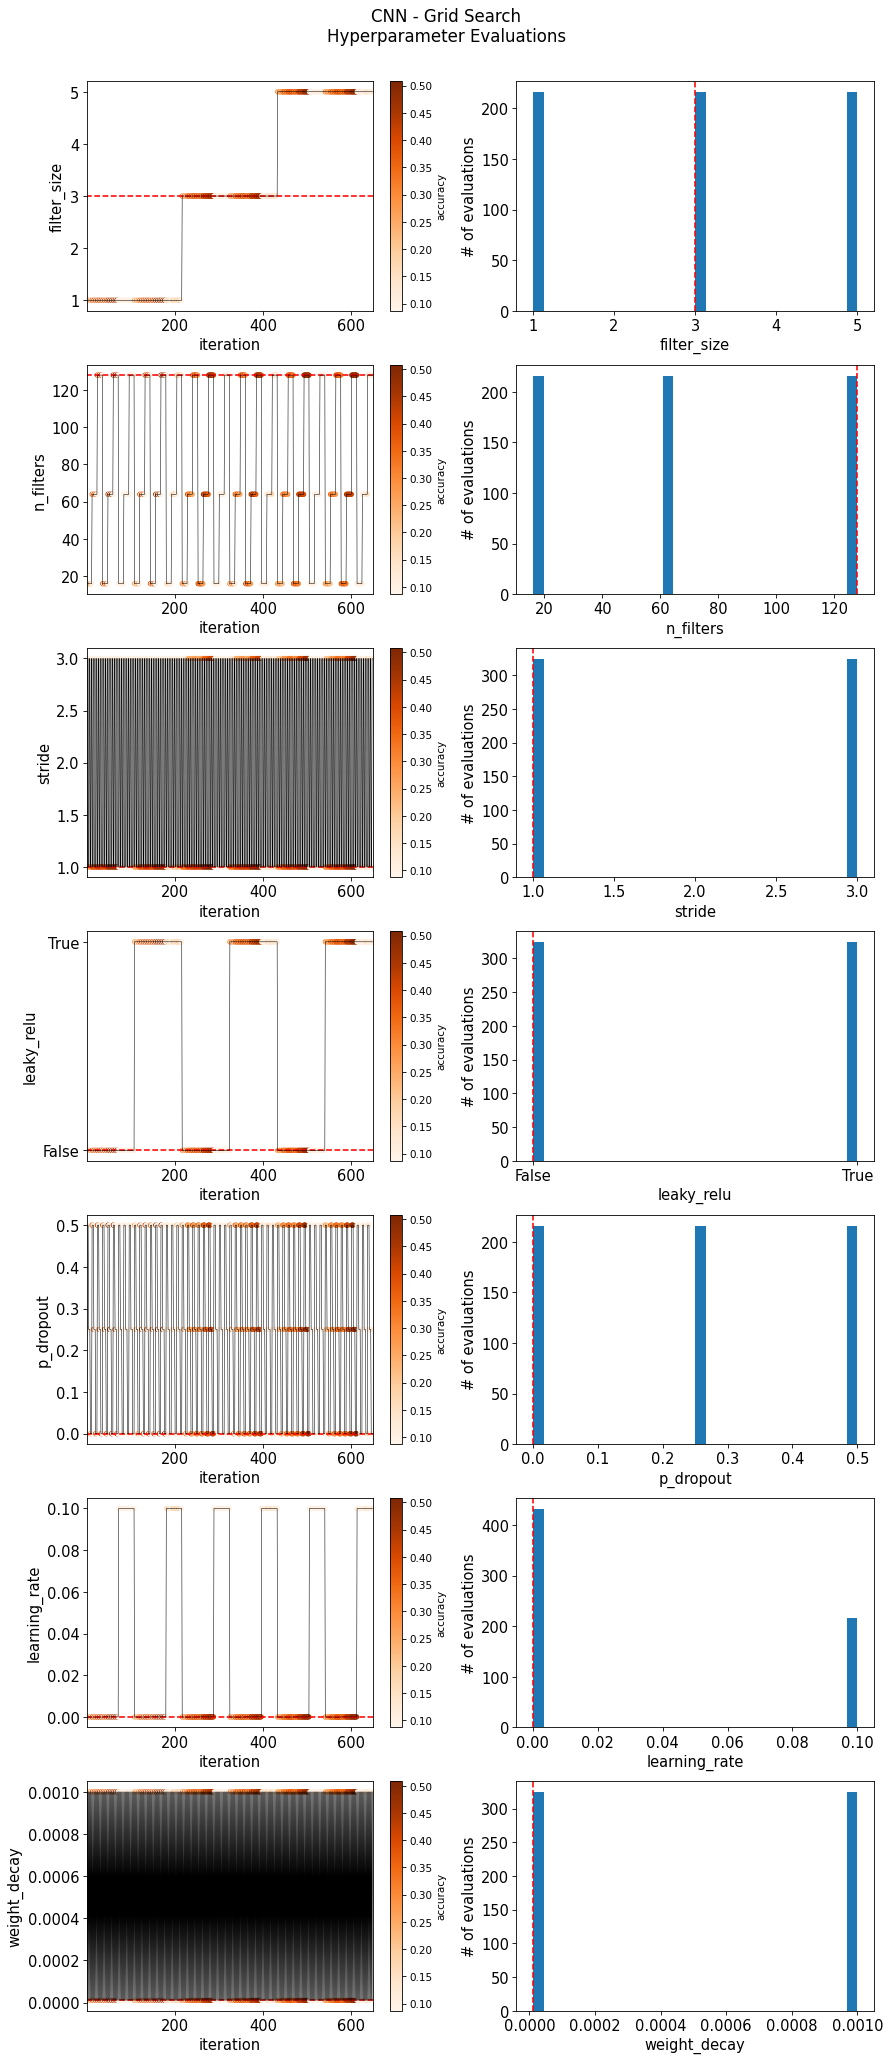

In [24]:
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

params = gs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in gs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = gs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("CNN - Grid Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.95])

# Random Search

In [29]:
rs_hyperparameters = {
    'filter_size': [1, 3, 5],  # 1, 3, 5 
    'n_filters': [16, 32, 64, 128], 
    'stride': [1, 3],
    'leaky_relu': [False, True],
    'p_dropout': [0.5, 0.25, 0.0],  # 0 = same as no dropout
    'learning_rate': list(np.logspace(-6, -1, num=20)),
    'weight_decay': list(np.logspace(-5, -2, num=10))
}

N_EVALS = 648  # same number as were evaluated in grid search

In [26]:
np.random.seed(682)
clf = CNNClassifier(n_epochs=N_EPOCHS, loader_val=loader_val)

rs = RandomizedSearchCV(clf,
                        param_distributions=rs_hyperparameters,
                        n_iter=N_EVALS,
                        scoring=_custom_scorer,
                        cv=presplit,
                        refit=False,
                        verbose=5, 
                        n_jobs=1,
                        random_state=682)

print('\n--------------------------------------\nBeginning random search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

rs.fit(x_train_full, y_train_full)

print("")
rs_results = []
for i in range(len(rs.cv_results_['params'])):
    result = {'params' : rs.cv_results_['params'][i], 
              'mean_metric' : rs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': rs.cv_results_['mean_fit_time'][i],
              'mean_score_time': rs.cv_results_['mean_score_time'][i]}
    rs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']))


print('\n\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))

the_time = datetime.now().strftime('%Y%m%d_%H%M%S')

for obj, obj_name in [(rs_results, 'rs_results'), (rs, 'rs')]:
    with open(f'cnn_{obj_name}_{the_time}.pkl', 'wb') as f:
        pickle.dump(obj, f)

print('\nFinished random search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))


--------------------------------------
Beginning random search at 19:02:33...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 1 folds for each of 648 candidates, totalling 648 fits
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e617c3898>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3022987842559814, accuracy = 13.08%
        Epoch 1, iteration 200: loss = 1.8928396701812744, accuracy = 27.51%
        Epoch 1, iteration 400: loss = 1.84539794921875, accuracy = 32.1%
        Epoch 1, iteration 600: loss = 1.9408016204833984, accuracy = 33.68%
        End of Epoch 1: accuracy = 35.07%
        Epoch 2, iteration 1: loss = 1.6186057329177856, accuracy = 35.23%
        Epoch 2, iteration 200: loss = 1.8301887512207031, accuracy = 37.04%
        Epoch 2, iteration 400: loss = 1.5477288961410522, accuracy = 37.37%
        Epoch 2, iteration 600: loss = 1.6940680742263794, accuracy = 3

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.416, total=  17.6s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s

------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853db38>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.302696466445923, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.293076992034912, accuracy = 11.16%
        Epoch 1, iteration 400: loss = 2.139348268508911, accuracy = 20.68%
        Epoch 1, iteration 600: loss = 2.0416336059570312, accuracy = 23.52%
        End of Epoch 1: accuracy = 24.98%
        Epoch 2, iteration 1: loss = 2.0875751972198486, accuracy = 24.93%
        Epoch 2, iteration 200: loss = 1.9854854345321655, accuracy = 25.24%
        Epoch 2, iteration 400: loss = 1.9660658836364746, accuracy = 2

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5, score=0.280, total=  14.2s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.8s remaining:    0.0s

------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced4278>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.303924083709717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8670322895050049, accuracy = 28.63%
        Epoch 1, iteration 400: loss = 1.7236261367797852, accuracy = 34.71%
        Epoch 1, iteration 600: loss = 1.776185393333435, accuracy = 38.37%
        End of Epoch 1: accuracy = 39.44%
        Epoch 2, iteration 1: loss = 1.6942987442016602, accuracy = 39.25%
        Epoch 2, iteration 200: loss = 1.4249790906906128, accuracy = 41.58%
        Epoch 2, iteration 400: loss = 1.5951979160308838, accuracy =

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=5, score=0.474, total=  14.1s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.9s remaining:    0.0s

------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e584342b0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.306647300720215, accuracy = 11.06%
        Epoch 1, iteration 200: loss = 2.3069546222686768, accuracy = 10.25%
        Epoch 1, iteration 400: loss = 2.307055950164795, accuracy = 10.77%
        Epoch 1, iteration 600: loss = 2.3107800483703613, accuracy = 11.05%
        End of Epoch 1: accuracy = 11.2%
        Epoch 2, iteration 1: loss = 2.305954933166504, accuracy = 11.2%
        Epoch 2, iteration 200: loss = 2.2992660999298096, accuracy = 10.88%
        Epoch 2, iteration 400: loss = 2.3006579875946045, accuracy = 10.3

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3, score=0.122, total=  14.2s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50264f60>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.2913625240325928, accuracy = 18.35%
        Epoch 1, iteration 400: loss = 2.2792389392852783, accuracy = 20.81%
        Epoch 1, iteration 600: loss = 2.24836802482605, accuracy = 24.43%
        End of Epoch 1: accuracy = 23.98%
        Epoch 2, iteration 1: loss = 2.2061541080474854, accuracy = 23.99%
        Epoch 2, iteration 200: loss = 2.213926315307617, accuracy = 27.44%
        Epoch 2, iteration 400: loss = 2.1379992961883545, accuracy = 28.57%
        Epoch 2, iteration 600: loss = 2.222193717956543, accuracy = 28.94%
        End of 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1, score=0.318, total=  21.6s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.309921979904175, accuracy = 13.27%
        Epoch 1, iteration 400: loss = 2.0781359672546387, accuracy = 19.24%
        Epoch 1, iteration 600: loss = 2.0599288940429688, accuracy = 23.07%
        End of Epoch 1: accuracy = 23.65%
        Epoch 2, iteration 1: loss = 2.088118076324463, accuracy = 23.54%
        Epoch 2, iteration 200: loss = 2.086050510406494, accuracy = 24.69%
        Epoch 2, iteration 400: loss = 2.089467763900757, accuracy = 24.78%
        Epoch 2, iteration 600: loss = 1.993167519569397, accuracy = 26.04%
        End of

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3, score=0.294, total=  14.4s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced4278>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3010408878326416, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3009095191955566, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3016562461853027, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302046298980713, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303095579147339, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302969455718994, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.301908493041992, accuracy = 10.0%
      

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e500592b0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301328182220459, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3006577491760254, accuracy = 13.75%
        Epoch 1, iteration 400: loss = 15.65246868133545, accuracy = 11.94%
        Epoch 1, iteration 600: loss = 2.2578108310699463, accuracy = 15.8%
        End of Epoch 1: accuracy = 12.62%
        Epoch 2, iteration 1: loss = 2.508483648300171, accuracy = 13.0%
        Epoch 2, iteration 200: loss = 2.2432878017425537, accuracy = 14.25%
        Epoch 2, iteration 400: loss = 2.30306339263916, accuracy = 15.42%
        Epoch 2, iteration 600: loss = 507.9602355957031, accuracy = 10.73%
        End of Epoch

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3, score=0.165, total=  15.0s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5031b6d8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 9.95%
        Epoch 1, iteration 200: loss = 2.2805252075195312, accuracy = 17.78%
        Epoch 1, iteration 400: loss = 2.2451047897338867, accuracy = 22.74%
        Epoch 1, iteration 600: loss = 2.1702616214752197, accuracy = 27.19%
        End of Epoch 1: accuracy = 28.03%
        Epoch 2, iteration 1: loss = 2.0856049060821533, accuracy = 27.95%
        Epoch 2, iteration 200: loss = 2.123230457305908, accuracy = 30.27%
        Epoch 2, iteration 400: loss = 2.003037452697754, accuracy = 31.04%
        Epoch 2, iteration 600: loss = 2.1468091011047363, accuracy = 31.8%
        End o

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1, score=0.346, total=  22.0s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58455630>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.30165433883667, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9039772748947144, accuracy = 35.45%
        Epoch 1, iteration 400: loss = 1.6549017429351807, accuracy = 38.94%
        Epoch 1, iteration 600: loss = 1.6877543926239014, accuracy = 42.59%
        End of Epoch 1: accuracy = 43.01%
        Epoch 2, iteration 1: loss = 1.362181305885315, accuracy = 43.18%
        Epoch 2, iteration 200: loss = 1.4106184244155884, accuracy = 44.39%
        Epoch 2, iteration 400: loss = 1.3696993589401245, accuracy = 45.7%
        Epoch 2, iteration 600: loss = 1.384465217590332, accuracy = 45.83%
        End of E

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3, score=0.491, total=  15.0s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 10.6%
        Epoch 1, iteration 200: loss = 1.9122834205627441, accuracy = 28.73%
        Epoch 1, iteration 400: loss = 1.8875186443328857, accuracy = 33.07%
        Epoch 1, iteration 600: loss = 1.7018476724624634, accuracy = 35.72%
        End of Epoch 1: accuracy = 35.29%
        Epoch 2, iteration 1: loss = 1.6429232358932495, accuracy = 34.89%
        Epoch 2, iteration 200: loss = 1.5782722234725952, accuracy = 38.03%
        Epoch 2, iteration 400: loss = 1.7486289739608765, accuracy = 37.98%
        Epoch 2, iteration 600: loss = 1.7240393161773682, accuracy = 

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5, score=0.435, total=  14.1s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf650f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.297914981842041, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.304224967956543, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3021645545959473, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3015003204345703, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3044564723968506, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3043112754821777, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3007876873016357, accuracy = 10.0%
     

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3017916679382324, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2884202003479004, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.296233654022217, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3053228855133057, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3048741817474365, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.308093309402466, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3055782318115234, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320908>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.063593864440918, accuracy = 24.11%
        Epoch 1, iteration 400: loss = 1.9596924781799316, accuracy = 24.19%
        Epoch 1, iteration 600: loss = 2.017011880874634, accuracy = 26.9%
        End of Epoch 1: accuracy = 20.81%
        Epoch 2, iteration 1: loss = 2.0851051807403564, accuracy = 21.25%
        Epoch 2, iteration 200: loss = 2.0557236671447754, accuracy = 18.67%
        Epoch 2, iteration 400: loss = 2.1736040115356445, accuracy = 21.86%
        Epoch 2, iteration 600: loss = 2.094057321548462, accuracy = 19.08%

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3, score=0.155, total=  14.4s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590059e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1599485874176025, accuracy = 22.04%
        Epoch 1, iteration 400: loss = 2.5718088150024414, accuracy = 10.7%
        Epoch 1, iteration 600: loss = 2.1739602088928223, accuracy = 18.8%
        End of Epoch 1: accuracy = 16.65%
        Epoch 2, iteration 1: loss = 2.3067867755889893, accuracy = 16.78%
        Epoch 2, iteration 200: loss = 2.0961194038391113, accuracy = 18.78%
        Epoch 2, iteration 400: loss = 1.9614601135253906, accuracy = 22.19%
        Epoch 2, iteration 600: loss = 2.0956568717956543, accuracy = 17.43%

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5, score=0.141, total=  40.6s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4b780>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.39%
        Epoch 1, iteration 200: loss = 2.289318084716797, accuracy = 16.63%
        Epoch 1, iteration 400: loss = 2.259120225906372, accuracy = 26.61%
        Epoch 1, iteration 600: loss = 2.1496529579162598, accuracy = 28.73%
        End of Epoch 1: accuracy = 28.64%
        Epoch 2, iteration 1: loss = 2.0999228954315186, accuracy = 28.71%
        Epoch 2, iteration 200: loss = 2.0523650646209717, accuracy = 30.98%
        Epoch 2, iteration 400: loss = 1.9921696186065674, accuracy = 31.46%
        Epoch 2, iteration 600: loss = 1.9604796171188354, accuracy = 

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1, score=0.350, total=  38.9s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502be2e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2994470596313477, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3027994632720947, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3019254207611084, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301661729812622, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303398370742798, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302943229675293, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3015105724334717, accuracy = 10.0%
    

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590059e8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2089626789093018, accuracy = 18.63%
        Epoch 1, iteration 400: loss = 38.30632019042969, accuracy = 10.04%
        Epoch 1, iteration 600: loss = 2.3278393745422363, accuracy = 15.43%
        End of Epoch 1: accuracy = 17.09%
        Epoch 2, iteration 1: loss = 2.357067584991455, accuracy = 14.98%
        Epoch 2, iteration 200: loss = 2.2069637775421143, accuracy = 17.28%
        Epoch 2, iteration 400: loss = 2.320499897003174, accuracy = 15.42%
        Epoch 2, iteration 600: loss = 2.8704354763031006, accuracy = 16.87%

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=5, score=0.160, total=  14.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5024b160>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9642314910888672, accuracy = 26.64%
        Epoch 1, iteration 400: loss = 1.9429993629455566, accuracy = 30.04%
        Epoch 1, iteration 600: loss = 2.0929906368255615, accuracy = 31.1%
        End of Epoch 1: accuracy = 31.33%
        Epoch 2, iteration 1: loss = 1.7728403806686401, accuracy = 31.28%
        Epoch 2, iteration 200: loss = 2.059373140335083, accuracy = 29.98%
        Epoch 2, iteration 400: loss = 1.8192287683486938, accuracy = 32.46%
        Epoch 2, iteration 600: loss = 1.95887291431427, accuracy = 33.31%
   

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3, score=0.318, total=  14.2s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58436c50>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 9.85%
        Epoch 1, iteration 200: loss = 2.3103928565979004, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.314767837524414, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3119187355041504, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3002867698669434, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.325916290283203, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.308861255645752, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2957448959350586, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5, score=0.100, total=  14.3s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590059e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.31351900100708, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.317542552947998, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3232359886169434, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3152477741241455, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30281138420105, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.31565523147583, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303013801574707, accuracy = 10.0%
        End of Epoch 2: ac

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 9.44%
        Epoch 1, iteration 200: loss = 2.0461692810058594, accuracy = 28.1%
        Epoch 1, iteration 400: loss = 1.9048707485198975, accuracy = 32.31%
        Epoch 1, iteration 600: loss = 1.8363127708435059, accuracy = 34.5%
        End of Epoch 1: accuracy = 35.93%
        Epoch 2, iteration 1: loss = 1.7483205795288086, accuracy = 35.51%
        Epoch 2, iteration 200: loss = 1.8218852281570435, accuracy = 36.78%
        Epoch 2, iteration 400: loss = 1.57052481174469, accuracy = 38.34%
        Epoch 2, iteration 600: loss = 1.5928839445114136, accuracy = 38.9%
        End of Ep

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=3, score=0.411, total=  30.5s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5843a390>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 8.75%
        Epoch 1, iteration 200: loss = 2.2815701961517334, accuracy = 13.59%
        Epoch 1, iteration 400: loss = 2.098996639251709, accuracy = 21.94%
        Epoch 1, iteration 600: loss = 2.1614606380462646, accuracy = 24.43%
        End of Epoch 1: accuracy = 27.02%
        Epoch 2, iteration 1: loss = 2.05208158493042, accuracy = 26.99%
        Epoch 2, iteration 200: loss = 1.9442216157913208, accuracy = 29.56%
        Epoch 2, iteration 400: loss = 1.997104525566101, accuracy = 29.88%
        Epoch 2, iteration 600: loss = 1.8165353536605835, accuracy = 31.28%
        En

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5, score=0.327, total= 2.1min
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d358>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3297417163848877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2989630699157715, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.33855938911438, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.335561752319336, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.323732614517212, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.332643747329712, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3244078159332275, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.283984899520874, accuracy = 10.0%
        End of Epoch 2: ac

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58455c50>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.306647300720215, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.853489875793457, accuracy = 26.59%
        Epoch 1, iteration 400: loss = 1.9043205976486206, accuracy = 30.56%
        Epoch 1, iteration 600: loss = 1.9020116329193115, accuracy = 34.04%
        End of Epoch 1: accuracy = 35.56%
        Epoch 2, iteration 1: loss = 1.5983155965805054, accuracy = 35.38%
        Epoch 2, iteration 200: loss = 1.7157893180847168, accuracy = 36.3%
        Epoch 2, iteration 400: loss = 1.7687673568725586, accuracy = 36.95%
        Epoch 2, iteration 600: loss = 1.7275865077972412, accuracy = 37.7%

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=3, score=0.413, total=  14.0s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590305c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298105239868164, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2986912727355957, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2687113285064697, accuracy = 16.32%
        End of Epoch 1: accuracy = 20.66%
        Epoch 2, iteration 1: loss = 2.2286274433135986, accuracy = 20.64%
        Epoch 2, iteration 200: loss = 2.112870216369629, accuracy = 21.79%
        Epoch 2, iteration 400: loss = 2.180356740951538, accuracy = 23.08%
        Epoch 2, iteration 600: loss = 2.0894718170166016, accuracy = 23.63%

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.253, total=  14.0s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.301668643951416, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3064966201782227, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299285650253296, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3050460815429688, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.294274091720581, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2957324981689453, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.292058229446411, accuracy = 10.0%
      

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=3, score=0.100, total= 1.4min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e584348d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3130269050598145, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3102030754089355, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3060665130615234, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3028647899627686, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.305140972137451, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.301858425140381, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.301196575164795, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee4470>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3007757663726807, accuracy = 9.92%
        Epoch 1, iteration 200: loss = 2.3055572509765625, accuracy = 10.7%
        Epoch 1, iteration 400: loss = 2.3028247356414795, accuracy = 12.88%
        Epoch 1, iteration 600: loss = 2.2912449836730957, accuracy = 13.77%
        End of Epoch 1: accuracy = 13.94%
        Epoch 2, iteration 1: loss = 2.2953836917877197, accuracy = 14.07%
        Epoch 2, iteration 200: loss = 2.291738986968994, accuracy = 13.5%
        Epoch 2, iteration 400: loss = 2.294797897338867, accuracy = 14.1%
        Epoch 2, iteration 600: loss = 2.2944319248199463, accuracy = 19.32%
        End of E

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1, score=0.188, total=  14.2s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced4278>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.173142433166504, accuracy = 25.4%
        Epoch 1, iteration 400: loss = 1.8897639513015747, accuracy = 27.35%
        Epoch 1, iteration 600: loss = 1.9056581258773804, accuracy = 28.08%
        End of Epoch 1: accuracy = 30.85%
        Epoch 2, iteration 1: loss = 1.8604049682617188, accuracy = 30.99%
        Epoch 2, iteration 200: loss = 2.1110920906066895, accuracy = 33.1%
        Epoch 2, iteration 400: loss = 1.740116000175476, accuracy = 34.84%
        Epoch 2, iteration 600: loss = 2.005375385284424, accuracy = 35.11%
        End of E

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.367, total=  14.4s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320908>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3015711307525635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 693643.75, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 137679.328125, accuracy = 9.59%
        Epoch 1, iteration 600: loss = 15896.671875, accuracy = 11.05%
        End of Epoch 1: accuracy = 9.99%
        Epoch 2, iteration 1: loss = 2875.18359375, accuracy = 10.01%
        Epoch 2, iteration 200: loss = 1557.5560302734375, accuracy = 9.8%
        Epoch 2, iteration 400: loss = 782.9144897460938, accuracy = 10.01%
        Epoch 2, iteration 600: loss = 826.8233642578125, accuracy = 10.0%
        End of Epoch 2: accur

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=5, score=0.114, total=  17.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58455630>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3038089275360107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7946960926055908, accuracy = 32.11%
        Epoch 1, iteration 400: loss = 1.7404146194458008, accuracy = 36.38%
        Epoch 1, iteration 600: loss = 1.7863740921020508, accuracy = 36.49%
        End of Epoch 1: accuracy = 38.44%
        Epoch 2, iteration 1: loss = 1.6621417999267578, accuracy = 38.81%
        Epoch 2, iteration 200: loss = 1.8463377952575684, accuracy = 38.21%
        Epoch 2, iteration 400: loss = 1.8418611288070679, accuracy = 39.96%
        Epoch 2, iteration 600: loss = 1.7404471635818481, accuracy = 3

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1, score=0.423, total=  38.9s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5031b6d8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 9.76%
        Epoch 1, iteration 200: loss = 1.9646812677383423, accuracy = 32.93%
        Epoch 1, iteration 400: loss = 1.5714811086654663, accuracy = 36.24%
        Epoch 1, iteration 600: loss = 1.7208789587020874, accuracy = 38.47%
        End of Epoch 1: accuracy = 37.53%
        Epoch 2, iteration 1: loss = 1.7175449132919312, accuracy = 37.46%
        Epoch 2, iteration 200: loss = 1.688990592956543, accuracy = 40.22%
        Epoch 2, iteration 400: loss = 1.6639337539672852, accuracy = 41.34%
        Epoch 2, iteration 600: loss = 1.3336995840072632, accuracy = 41

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3, score=0.447, total=  14.1s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1e5c0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.329800605773926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3042829036712646, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3235275745391846, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.294637441635132, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.299102783203125, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30562162399292, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.298914909362793, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.311354637145996, accuracy = 10.0%
        

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee4470>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.7873034477233887, accuracy = 11.01%
        Epoch 1, iteration 400: loss = 2.651204824447632, accuracy = 12.23%
        Epoch 1, iteration 600: loss = 2.750486135482788, accuracy = 9.92%
        End of Epoch 1: accuracy = 12.2%
        Epoch 2, iteration 1: loss = 2.501596212387085, accuracy = 15.53%
        Epoch 2, iteration 200: loss = 3.10510516166687, accuracy = 13.08%
        Epoch 2, iteration 400: loss = 2.5306947231292725, accuracy = 11.06%
        Epoch 2, iteration 600: loss = 2.9982316493988037, accuracy = 15.79%
        End of Epoch 2: accuracy = 1

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.176, total=  21.6s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5ecb1063c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 12.87%
        Epoch 1, iteration 200: loss = 2.181920289993286, accuracy = 21.28%
        Epoch 1, iteration 400: loss = 2.056403636932373, accuracy = 25.29%
        Epoch 1, iteration 600: loss = 2.0897974967956543, accuracy = 29.92%
        End of Epoch 1: accuracy = 31.02%
        Epoch 2, iteration 1: loss = 1.9413200616836548, accuracy = 31.03%
        Epoch 2, iteration 200: loss = 1.7822564840316772, accuracy = 32.46%
        Epoch 2, iteration 400: loss = 2.0011773109436035, accuracy = 33.57%
        Epoch 2, iteration 600: loss = 1.9087517261505127, accuracy = 34.27%
        E

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=3, score=0.370, total= 1.4min
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320908>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.204739809036255, accuracy = 14.61%
        Epoch 1, iteration 400: loss = 2.0269360542297363, accuracy = 21.5%
        Epoch 1, iteration 600: loss = 2.1039397716522217, accuracy = 22.58%
        End of Epoch 1: accuracy = 25.15%
        Epoch 2, iteration 1: loss = 2.166072130203247, accuracy = 24.98%
        Epoch 2, iteration 200: loss = 2.1195530891418457, accuracy = 26.55%
        Epoch 2, iteration 400: loss = 1.9878140687942505, accuracy = 27.62%
        Epoch 2, iteration 600: loss = 1.9816850423812866, accuracy = 26.9

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.298, total=  14.1s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.306427478790283, accuracy = 11.09%
        Epoch 1, iteration 200: loss = 2.307621479034424, accuracy = 10.71%
        Epoch 1, iteration 400: loss = 2.306899070739746, accuracy = 10.99%
        Epoch 1, iteration 600: loss = 2.3088643550872803, accuracy = 11.2%
        End of Epoch 1: accuracy = 11.27%
        Epoch 2, iteration 1: loss = 2.304903507232666, accuracy = 11.27%
        Epoch 2, iteration 200: loss = 2.299325942993164, accuracy = 11.08%
        Epoch 2, iteration 400: loss = 2.300907611846924, accuracy = 10.78%
        Epoch 2, iteration 600: loss = 2.306872606277466, accuracy = 11.01%


[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3, score=0.114, total=  14.6s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.1, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d240>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3008198738098145, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3443057537078857, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2974612712860107, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.280806303024292, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3051600456237793, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299607276916504, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3124706745147705, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3636133670806885, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.1, leaky_relu=False, filter_size=1, score=0.100, total=  15.0s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 12.28%
        Epoch 1, iteration 200: loss = 1.9641045331954956, accuracy = 28.63%
        Epoch 1, iteration 400: loss = 1.800819993019104, accuracy = 34.32%
        Epoch 1, iteration 600: loss = 1.9580384492874146, accuracy = 35.96%
        End of Epoch 1: accuracy = 37.2%
        Epoch 2, iteration 1: loss = 1.7265758514404297, accuracy = 37.52%
        Epoch 2, iteration 200: loss = 1.65092134475708, accuracy = 38.57%
        Epoch 2, iteration 400: loss = 1.9006679058074951, accuracy = 38.99%
        Epoch 2, iteration 600: loss = 1.7389556169509888, accuracy = 39

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=3, score=0.419, total= 1.4min
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50052ac8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.29164981842041, accuracy = 17.59%
        Epoch 1, iteration 400: loss = 2.101209878921509, accuracy = 23.13%
        Epoch 1, iteration 600: loss = 2.0473220348358154, accuracy = 25.44%
        End of Epoch 1: accuracy = 25.77%
        Epoch 2, iteration 1: loss = 1.8194541931152344, accuracy = 25.75%
        Epoch 2, iteration 200: loss = 1.9210104942321777, accuracy = 26.64%
        Epoch 2, iteration 400: loss = 1.9358539581298828, accuracy = 26.82%
        Epoch 2, iteration 600: loss = 1.8616098165512085, accuracy = 27

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5, score=0.292, total=  22.4s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e584348d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9273979663848877, accuracy = 28.77%
        Epoch 1, iteration 400: loss = 1.9006397724151611, accuracy = 28.67%
        Epoch 1, iteration 600: loss = 1.7462170124053955, accuracy = 34.05%
        End of Epoch 1: accuracy = 35.34%
        Epoch 2, iteration 1: loss = 1.7732722759246826, accuracy = 35.49%
        Epoch 2, iteration 200: loss = 1.8128492832183838, accuracy = 34.26%
        Epoch 2, iteration 400: loss = 2.0026562213897705, accuracy = 34.43%
        Epoch 2, iteration 600: loss = 1.5114784240722656, accuracy = 3

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=3, score=0.346, total=  14.9s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced4278>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 10.33%
        Epoch 1, iteration 200: loss = 2.2954564094543457, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.304535388946533, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2966065406799316, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2981648445129395, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3130264282226562, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.300743341445923, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2983009815216064, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3, score=0.100, total=  30.3s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50052ac8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.05049467086792, accuracy = 28.71%
        Epoch 1, iteration 400: loss = 1.7503890991210938, accuracy = 35.05%
        Epoch 1, iteration 600: loss = 1.8696825504302979, accuracy = 37.51%
        End of Epoch 1: accuracy = 41.58%
        Epoch 2, iteration 1: loss = 1.5320043563842773, accuracy = 41.05%
        Epoch 2, iteration 200: loss = 1.583446979522705, accuracy = 41.41%
        Epoch 2, iteration 400: loss = 1.7645844221115112, accuracy = 42.58%
        Epoch 2, iteration 600: loss = 1.676723837852478, accuracy = 43.3

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3, score=0.450, total= 1.4min
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5024b3c8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.312502861022949, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.305138111114502, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.29936146736145, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.296281337738037, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3142921924591064, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.304027557373047, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3018128871917725, accuracy = 10.0%
        E

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  14.6s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e500592b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 12.64%
        Epoch 1, iteration 200: loss = 1.8564517498016357, accuracy = 28.35%
        Epoch 1, iteration 400: loss = 1.850844383239746, accuracy = 35.34%
        Epoch 1, iteration 600: loss = 1.6374189853668213, accuracy = 40.02%
        End of Epoch 1: accuracy = 41.05%
        Epoch 2, iteration 1: loss = 1.389083743095398, accuracy = 40.87%
        Epoch 2, iteration 200: loss = 1.2014037370681763, accuracy = 43.41%
        Epoch 2, iteration 400: loss = 1.4662424325942993, accuracy = 46.37%
        Epoch 2, iteration 600: loss = 1.311968207359314, accuracy =

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5, score=0.507, total=  22.5s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf177b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.959814190864563, accuracy = 29.4%
        Epoch 1, iteration 400: loss = 1.8871690034866333, accuracy = 32.4%
        Epoch 1, iteration 600: loss = 1.9143974781036377, accuracy = 37.72%
        End of Epoch 1: accuracy = 38.09%
        Epoch 2, iteration 1: loss = 1.6213924884796143, accuracy = 37.97%
        Epoch 2, iteration 200: loss = 1.7930679321289062, accuracy = 40.84%
        Epoch 2, iteration 400: loss = 1.608787178993225, accuracy = 40.7%
        Epoch 2, iteration 600: loss = 1.7179844379425049, accuracy = 41.57%
        End of Ep

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3, score=0.426, total=  14.3s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf094e0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.303924083709717, accuracy = 11.94%
        Epoch 1, iteration 200: loss = 2.011702299118042, accuracy = 19.55%
        Epoch 1, iteration 400: loss = 1.8283727169036865, accuracy = 22.61%
        Epoch 1, iteration 600: loss = 2.0674755573272705, accuracy = 25.03%
        End of Epoch 1: accuracy = 21.55%
        Epoch 2, iteration 1: loss = 2.1045942306518555, accuracy = 22.25%
        Epoch 2, iteration 200: loss = 1.9482555389404297, accuracy = 23.64%
        Epoch 2, iteration 400: loss = 1.9132885932922363, accuracy = 25.96%
        Epoch 2, iteration 600: loss = 1.9053841829299927, accuracy = 25.32

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=5, score=0.259, total=  14.3s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.2961649894714355, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3180923461914062, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.308685779571533, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2976877689361572, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.290050506591797, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302248001098633, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2954678535461426, accuracy = 10.0%
    

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5, score=0.100, total= 2.1min
[CV] weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcefff28>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.12947154045105, accuracy = 17.34%
        Epoch 1, iteration 400: loss = 1.9846936464309692, accuracy = 25.38%
        Epoch 1, iteration 600: loss = 1.8836816549301147, accuracy = 27.16%
        End of Epoch 1: accuracy = 29.03%
        Epoch 2, iteration 1: loss = 1.89913010597229, accuracy = 29.05%
        Epoch 2, iteration 200: loss = 1.8579597473144531, accuracy = 30.83%
        Epoch 2, iteration 400: loss = 1.8926715850830078, accuracy = 31.73%
        Epoch 2, iteration 600: loss = 1.6031452417373657, accuracy = 32.72%
        End of

[CV]  weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3, score=0.349, total=  14.2s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023390>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.306419610977173, accuracy = 11.1%
        Epoch 1, iteration 200: loss = 2.3062808513641357, accuracy = 10.4%
        Epoch 1, iteration 400: loss = 2.306312322616577, accuracy = 10.91%
        Epoch 1, iteration 600: loss = 2.309264659881592, accuracy = 11.25%
        End of Epoch 1: accuracy = 11.37%
        Epoch 2, iteration 1: loss = 2.306166172027588, accuracy = 11.37%
        Epoch 2, iteration 200: loss = 2.300036907196045, accuracy = 10.96%
        Epoch 2, iteration 400: loss = 2.3010244369506836, accuracy = 10.48%
        Epoch 2, iteration 600: loss = 2.3049421310424805, accuracy = 11.12%
        End of

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=3, score=0.122, total=  14.5s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5024bf98>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3010528087615967, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8822906017303467, accuracy = 31.55%
        Epoch 1, iteration 400: loss = 1.8973493576049805, accuracy = 38.55%
        Epoch 1, iteration 600: loss = 1.871651291847229, accuracy = 40.36%
        End of Epoch 1: accuracy = 41.36%
        Epoch 2, iteration 1: loss = 1.5325286388397217, accuracy = 41.02%
        Epoch 2, iteration 200: loss = 1.6193065643310547, accuracy = 41.85%
        Epoch 2, iteration 400: loss = 1.653659462928772, accuracy = 43.34%
        Epoch 2, iteration 600: loss = 1.5745021104812622, accuracy = 43.39%
        En

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=1, score=0.457, total=  14.2s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d358>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.70283043384552, accuracy = 41.45%
        Epoch 1, iteration 400: loss = 1.8449673652648926, accuracy = 43.66%
        Epoch 1, iteration 600: loss = 1.5154125690460205, accuracy = 44.69%
        End of Epoch 1: accuracy = 44.27%
        Epoch 2, iteration 1: loss = 1.4584708213806152, accuracy = 44.28%
        Epoch 2, iteration 200: loss = 1.7153139114379883, accuracy = 45.15%
        Epoch 2, iteration 400: loss = 1.480700969696045, accuracy = 45.08%
        Epoch 2, iteration 600: loss = 1.3978447914123535, accuracy = 45.21%
        End of

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1, score=0.454, total=  22.0s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3014955520629883, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.309400796890259, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3021602630615234, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300747871398926, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.31010103225708, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302229642868042, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2981159687042236, accuracy = 10.0%
        E

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5024bf98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9169846773147583, accuracy = 31.21%
        Epoch 1, iteration 400: loss = 1.97732675075531, accuracy = 35.13%
        Epoch 1, iteration 600: loss = 1.6714892387390137, accuracy = 38.56%
        End of Epoch 1: accuracy = 39.95%
        Epoch 2, iteration 1: loss = 1.8927592039108276, accuracy = 40.35%
        Epoch 2, iteration 200: loss = 1.5835059881210327, accuracy = 41.48%
        Epoch 2, iteration 400: loss = 1.6271557807922363, accuracy = 41.88%
        Epoch 2, iteration 600: loss = 1.5454356670379639, accuracy = 43.19%
        En

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5, score=0.453, total=  40.6s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502be2e8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3007757663726807, accuracy = 9.94%
        Epoch 1, iteration 200: loss = 2.306239366531372, accuracy = 10.5%
        Epoch 1, iteration 400: loss = 2.3038787841796875, accuracy = 13.52%
        Epoch 1, iteration 600: loss = 2.2922005653381348, accuracy = 13.24%
        End of Epoch 1: accuracy = 13.46%
        Epoch 2, iteration 1: loss = 2.2999186515808105, accuracy = 13.47%
        Epoch 2, iteration 200: loss = 2.2969930171966553, accuracy = 15.22%
        Epoch 2, iteration 400: loss = 2.305392265319824, accuracy = 12.52%
        Epoch 2, iteration 600: loss = 2.300671100616455, accuracy = 13.64

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1, score=0.185, total=  14.3s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcedd4a8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6295632123947144, accuracy = 38.19%
        Epoch 1, iteration 400: loss = 1.4415793418884277, accuracy = 41.08%
        Epoch 1, iteration 600: loss = 1.6645833253860474, accuracy = 40.72%
        End of Epoch 1: accuracy = 42.63%
        Epoch 2, iteration 1: loss = 1.5150015354156494, accuracy = 42.61%
        Epoch 2, iteration 200: loss = 1.874309778213501, accuracy = 43.82%
        Epoch 2, iteration 400: loss = 1.6601725816726685, accuracy = 44.62%
        Epoch 2, iteration 600: loss = 1.533467173576355, accuracy = 44

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1, score=0.447, total=  38.9s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50360978>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 9.42%
        Epoch 1, iteration 200: loss = 2.0427439212799072, accuracy = 28.7%
        Epoch 1, iteration 400: loss = 1.901196002960205, accuracy = 32.46%
        Epoch 1, iteration 600: loss = 1.8316019773483276, accuracy = 34.58%
        End of Epoch 1: accuracy = 35.98%
        Epoch 2, iteration 1: loss = 1.743584394454956, accuracy = 35.79%
        Epoch 2, iteration 200: loss = 1.8069510459899902, accuracy = 36.97%
        Epoch 2, iteration 400: loss = 1.567731261253357, accuracy = 38.4%
        Epoch 2, iteration 600: loss = 1.5732197761535645, accuracy = 39.3%
  

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3, score=0.413, total=  30.5s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5bd68>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3007757663726807, accuracy = 9.94%
        Epoch 1, iteration 200: loss = 2.306239366531372, accuracy = 10.5%
        Epoch 1, iteration 400: loss = 2.3038787841796875, accuracy = 13.52%
        Epoch 1, iteration 600: loss = 2.2922005653381348, accuracy = 13.24%
        End of Epoch 1: accuracy = 13.46%
        Epoch 2, iteration 1: loss = 2.2999186515808105, accuracy = 13.47%
        Epoch 2, iteration 200: loss = 2.2969930171966553, accuracy = 15.22%
        Epoch 2, iteration 400: loss = 2.305392265319824, accuracy = 12.52%
        Epoch 2, iteration 600: loss = 2.300671100616455, accuracy = 13.64%
        End of

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1, score=0.185, total=  14.4s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d358>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 11.45%
        Epoch 1, iteration 200: loss = 2.234496593475342, accuracy = 19.91%
        Epoch 1, iteration 400: loss = 2.15478515625, accuracy = 28.88%
        Epoch 1, iteration 600: loss = 2.0199930667877197, accuracy = 31.68%
        End of Epoch 1: accuracy = 32.25%
        Epoch 2, iteration 1: loss = 1.9016122817993164, accuracy = 32.2%
        Epoch 2, iteration 200: loss = 1.997114658355713, accuracy = 33.97%
        Epoch 2, iteration 400: loss = 1.820473551750183, accuracy = 34.92%
        Epoch 2, iteration 600: loss = 1.9744274616241455, accuracy = 35.83%
  

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=1, score=0.390, total=  21.6s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502be2e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 757430.125, accuracy = 9.9%
        Epoch 1, iteration 400: loss = 399420.03125, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 187397.875, accuracy = 14.11%
        End of Epoch 1: accuracy = 13.78%
        Epoch 2, iteration 1: loss = 55930.015625, accuracy = 12.33%
        Epoch 2, iteration 200: loss = 37345.4296875, accuracy = 10.01%
        Epoch 2, iteration 400: loss = 22846.8984375, accuracy = 11.19%
        Epoch 2, iteration 600: loss = 25855.2421875, accuracy = 13.56%
        End of Epoch 2: accuracy = 12.65

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.133, total=  22.4s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590303c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 29.759666442871094, accuracy = 13.42%
        Epoch 1, iteration 400: loss = 47.9809684753418, accuracy = 10.17%
        Epoch 1, iteration 600: loss = 4.143126487731934, accuracy = 11.62%
        End of Epoch 1: accuracy = 11.77%
        Epoch 2, iteration 1: loss = 5.214620113372803, accuracy = 11.73%
        Epoch 2, iteration 200: loss = 2.464919328689575, accuracy = 11.33%
        Epoch 2, iteration 400: loss = 2.5383169651031494, accuracy = 15.49%
        Epoch 2, iteration 600: loss = 2.62037992477417, accuracy = 15.28%
        End of Epoch 

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=5, score=0.182, total=  14.5s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceddcf8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.306455373764038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.953140377998352, accuracy = 24.61%
        Epoch 1, iteration 400: loss = 1.982055425643921, accuracy = 29.21%
        Epoch 1, iteration 600: loss = 1.955997109413147, accuracy = 31.72%
        End of Epoch 1: accuracy = 33.82%
        Epoch 2, iteration 1: loss = 1.636837363243103, accuracy = 33.89%
        Epoch 2, iteration 200: loss = 1.8297466039657593, accuracy = 33.91%
        Epoch 2, iteration 400: loss = 1.8063814640045166, accuracy = 35.43%
        Epoch 2, iteration 600: loss = 1.8429476022720337, accuracy = 36.76%

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=3, score=0.389, total=  14.7s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502be2e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0013301372528076, accuracy = 24.17%
        Epoch 1, iteration 400: loss = 1.9519321918487549, accuracy = 27.11%
        Epoch 1, iteration 600: loss = 1.949587345123291, accuracy = 27.73%
        End of Epoch 1: accuracy = 29.34%
        Epoch 2, iteration 1: loss = 2.0416605472564697, accuracy = 29.36%
        Epoch 2, iteration 200: loss = 1.9436891078948975, accuracy = 32.04%
        Epoch 2, iteration 400: loss = 1.8032238483428955, accuracy = 33.21%
        Epoch 2, iteration 600: loss = 1.9467377662658691, accuracy = 33

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5, score=0.370, total=  14.2s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 9.5%
        Epoch 1, iteration 200: loss = 2.08130145072937, accuracy = 28.28%
        Epoch 1, iteration 400: loss = 2.1058943271636963, accuracy = 30.59%
        Epoch 1, iteration 600: loss = 1.8668277263641357, accuracy = 32.9%
        End of Epoch 1: accuracy = 35.36%
        Epoch 2, iteration 1: loss = 2.0629870891571045, accuracy = 34.99%
        Epoch 2, iteration 200: loss = 1.6586216688156128, accuracy = 35.5%
        Epoch 2, iteration 400: loss = 1.7617321014404297, accuracy = 35.71%
        Epoch 2, iteration 600: loss = 1.7796111106872559, accuracy = 36.37%
        End of Ep

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5, score=0.398, total=  40.6s
[CV] weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcedd4a8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 9.8%
        Epoch 1, iteration 200: loss = 2.299492835998535, accuracy = 14.57%
        Epoch 1, iteration 400: loss = 2.2990779876708984, accuracy = 15.98%
        Epoch 1, iteration 600: loss = 2.2868547439575195, accuracy = 20.91%
        End of Epoch 1: accuracy = 18.66%
        Epoch 2, iteration 1: loss = 2.2791836261749268, accuracy = 18.56%
        Epoch 2, iteration 200: loss = 2.279336929321289, accuracy = 22.55%
        Epoch 2, iteration 400: loss = 2.2598531246185303, accuracy = 25.34%
        Epoch 2, iteration 600: loss = 2.2843828201293945, accuracy = 25.93%
        End of

[CV]  weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1, score=0.273, total=  22.0s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf094a8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3029897212982178, accuracy = 10.3%
        Epoch 1, iteration 400: loss = 2.29724383354187, accuracy = 15.39%
        Epoch 1, iteration 600: loss = 2.300661563873291, accuracy = 18.15%
        End of Epoch 1: accuracy = 17.25%
        Epoch 2, iteration 1: loss = 2.2808103561401367, accuracy = 17.22%
        Epoch 2, iteration 200: loss = 2.2504589557647705, accuracy = 17.03%
        Epoch 2, iteration 400: loss = 2.1703927516937256, accuracy = 19.07%
        Epoch 2, iteration 600: loss = 2.084599494934082, accuracy = 23.04%

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.254, total=  22.4s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.300321102142334, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.305636167526245, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3008320331573486, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3037261962890625, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303745746612549, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.297433853149414, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.30019474029541, accuracy = 10.0%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5, score=0.100, total=  22.5s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1e5c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 84.96971130371094, accuracy = 12.38%
        Epoch 1, iteration 400: loss = 31.907835006713867, accuracy = 12.79%
        Epoch 1, iteration 600: loss = 20.22686004638672, accuracy = 12.66%
        End of Epoch 1: accuracy = 11.06%
        Epoch 2, iteration 1: loss = 24.139225006103516, accuracy = 11.31%
        Epoch 2, iteration 200: loss = 20.14240074157715, accuracy = 12.21%
        Epoch 2, iteration 400: loss = 10.366778373718262, accuracy = 13.28%
        Epoch 2, iteration 600: loss = 9.290336608886719, accuracy = 14.85%


[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=3, score=0.155, total= 1.4min
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303929090499878, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3121957778930664, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3152339458465576, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.310485601425171, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300935745239258, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.314566135406494, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.301905870437622, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceff940>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.21%
        Epoch 1, iteration 200: loss = 2.302406072616577, accuracy = 13.51%
        Epoch 1, iteration 400: loss = 2.2951557636260986, accuracy = 21.77%
        Epoch 1, iteration 600: loss = 2.2843093872070312, accuracy = 18.47%
        End of Epoch 1: accuracy = 24.05%
        Epoch 2, iteration 1: loss = 2.2781331539154053, accuracy = 24.03%
        Epoch 2, iteration 200: loss = 2.260620594024658, accuracy = 25.55%
        Epoch 2, iteration 400: loss = 2.242716073989868, accuracy = 27.5%
        Epoch 2, iteration 600: loss = 2.227810859680176, accuracy = 27.25%
        End 

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1e-06, leaky_relu=True, filter_size=1, score=0.281, total=  38.9s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.1, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1e5c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 121741.1796875, accuracy = 9.52%
        Epoch 1, iteration 400: loss = 79241.96875, accuracy = 10.73%
        Epoch 1, iteration 600: loss = 15476.888671875, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.02%
        Epoch 2, iteration 1: loss = 7542882304.0, accuracy = 10.02%
        Epoch 2, iteration 200: loss = 1084838400.0, accuracy = 10.01%
        Epoch 2, iteration 400: loss = 188757088.0, accuracy = 12.61%
        Epoch 2, iteration 600: loss = 217077808.0, accuracy = 10.6%
        End of Epoch 2: accuracy = 12.26%
        Epoch 3, iteration 1: 

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.1, leaky_relu=True, filter_size=5, score=0.132, total=  22.4s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3084628582000732, accuracy = 9.99%
        Epoch 1, iteration 400: loss = 2.299488067626953, accuracy = 10.08%
        Epoch 1, iteration 600: loss = 2.3054726123809814, accuracy = 13.39%
        End of Epoch 1: accuracy = 15.46%
        Epoch 2, iteration 1: loss = 2.291846752166748, accuracy = 15.48%
        Epoch 2, iteration 200: loss = 2.281313419342041, accuracy = 18.12%
        Epoch 2, iteration 400: loss = 2.2136974334716797, accuracy = 18.56%
        Epoch 2, iteration 600: loss = 2.272818088531494, accuracy = 20.18%
 

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5, score=0.252, total=  14.3s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d710>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.318361520767212, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3027048110961914, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3075997829437256, accuracy = 13.26%
        End of Epoch 1: accuracy = 15.81%
        Epoch 2, iteration 1: loss = 2.2868118286132812, accuracy = 15.85%
        Epoch 2, iteration 200: loss = 2.243988513946533, accuracy = 18.17%
        Epoch 2, iteration 400: loss = 2.185359477996826, accuracy = 18.97%
        Epoch 2, iteration 600: loss = 2.1574034690856934, accuracy = 20.02%

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3, score=0.234, total=  14.5s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf094a8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3022987842559814, accuracy = 12.61%
        Epoch 1, iteration 200: loss = 2.0952088832855225, accuracy = 20.8%
        Epoch 1, iteration 400: loss = 1.9424090385437012, accuracy = 30.16%
        Epoch 1, iteration 600: loss = 1.967029333114624, accuracy = 31.37%
        End of Epoch 1: accuracy = 33.01%
        Epoch 2, iteration 1: loss = 1.7223268747329712, accuracy = 33.06%
        Epoch 2, iteration 200: loss = 1.8820488452911377, accuracy = 34.54%
        Epoch 2, iteration 400: loss = 1.6376440525054932, accuracy = 34.9%
        Epoch 2, iteration 600: loss = 1.8021577596664429, accuracy = 35.78%
        End

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5, score=0.389, total=  17.6s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023390>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.303122043609619, accuracy = 10.07%
        Epoch 1, iteration 400: loss = 2.295586109161377, accuracy = 11.6%
        Epoch 1, iteration 600: loss = 2.209172010421753, accuracy = 17.7%
        End of Epoch 1: accuracy = 22.31%
        Epoch 2, iteration 1: loss = 2.1519997119903564, accuracy = 22.38%
        Epoch 2, iteration 200: loss = 2.0628819465637207, accuracy = 24.48%
        Epoch 2, iteration 400: loss = 2.0484237670898438, accuracy = 24.79%
        Epoch 2, iteration 600: loss = 1.9975085258483887, accuracy = 25.07%


[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3, score=0.270, total=  14.2s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b9e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3177363872528076, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.321000576019287, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3030946254730225, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3029348850250244, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.322819232940674, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.319927930831909, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3026177883148193, accuracy = 10.0%
      

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5, score=0.100, total=  14.3s
[CV] weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1e470>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.306647300720215, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7621183395385742, accuracy = 34.64%
        Epoch 1, iteration 400: loss = 1.6974351406097412, accuracy = 38.74%
        Epoch 1, iteration 600: loss = 1.5773080587387085, accuracy = 40.95%
        End of Epoch 1: accuracy = 40.94%
        Epoch 2, iteration 1: loss = 1.5661580562591553, accuracy = 40.75%
        Epoch 2, iteration 200: loss = 1.5619434118270874, accuracy = 43.47%
        Epoch 2, iteration 400: loss = 1.6265311241149902, accuracy = 44.47%
        Epoch 2, iteration 600: loss = 1.5646616220474243, accuracy = 44.7%
        End of

[CV]  weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3, score=0.474, total=  14.3s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf68eb8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 76899.359375, accuracy = 9.27%
        Epoch 1, iteration 400: loss = 131672.484375, accuracy = 10.14%
        Epoch 1, iteration 600: loss = 32742.287109375, accuracy = 9.84%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 25472.1484375, accuracy = 11.53%
        Epoch 2, iteration 200: loss = 19707.1015625, accuracy = 10.24%
        Epoch 2, iteration 400: loss = 8378.298828125, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 5758.17333984375, accuracy = 11.4%
        End of Epoch 2: accuracy = 10.0%
       

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.100, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee4470>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.737945795059204, accuracy = 36.29%
        Epoch 1, iteration 400: loss = 1.8735100030899048, accuracy = 39.87%
        Epoch 1, iteration 600: loss = 1.456525206565857, accuracy = 42.26%
        End of Epoch 1: accuracy = 41.84%
        Epoch 2, iteration 1: loss = 1.6650609970092773, accuracy = 42.02%
        Epoch 2, iteration 200: loss = 1.6209365129470825, accuracy = 42.23%
        Epoch 2, iteration 400: loss = 1.5057486295700073, accuracy = 43.02%
        Epoch 2, iteration 600: loss = 1.8010724782943726, accuracy = 43.66%

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=1, score=0.423, total=  14.1s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf09d30>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3034558296203613, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303225517272949, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3036324977874756, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3070478439331055, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3054888248443604, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3056161403656006, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.309417963027954, accuracy = 10.0%
   

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1, score=0.100, total=  38.9s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf17400>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.8%
        Epoch 1, iteration 200: loss = 1.8583382368087769, accuracy = 36.72%
        Epoch 1, iteration 400: loss = 1.6483521461486816, accuracy = 39.58%
        Epoch 1, iteration 600: loss = 1.8358573913574219, accuracy = 42.21%
        End of Epoch 1: accuracy = 44.35%
        Epoch 2, iteration 1: loss = 1.4041028022766113, accuracy = 43.96%
        Epoch 2, iteration 200: loss = 1.5052154064178467, accuracy = 45.87%
        Epoch 2, iteration 400: loss = 1.6926517486572266, accuracy = 45.76%
        Epoch 2, iteration 600: loss = 1.5044111013412476, accuracy = 47

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3, score=0.495, total= 1.4min
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceffcf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.021705150604248, accuracy = 27.09%
        Epoch 1, iteration 400: loss = 1.9042246341705322, accuracy = 31.75%
        Epoch 1, iteration 600: loss = 1.8649976253509521, accuracy = 34.33%
        End of Epoch 1: accuracy = 35.33%
        Epoch 2, iteration 1: loss = 1.9128947257995605, accuracy = 35.34%
        Epoch 2, iteration 200: loss = 1.8845065832138062, accuracy = 37.65%
        Epoch 2, iteration 400: loss = 1.859352469444275, accuracy = 38.8%
        Epoch 2, iteration 600: loss = 1.5188989639282227, accuracy = 39.17%
        End 

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3, score=0.427, total=  14.1s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.725995659828186, accuracy = 31.97%
        Epoch 1, iteration 400: loss = 1.880562663078308, accuracy = 36.09%
        Epoch 1, iteration 600: loss = 1.6238818168640137, accuracy = 38.68%
        End of Epoch 1: accuracy = 38.61%
        Epoch 2, iteration 1: loss = 1.7895032167434692, accuracy = 38.63%
        Epoch 2, iteration 200: loss = 1.6937968730926514, accuracy = 40.78%
        Epoch 2, iteration 400: loss = 1.5993671417236328, accuracy = 41.9%
        Epoch 2, iteration 600: loss = 1.7972506284713745, accuracy = 41.99%
        End 

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=1, score=0.442, total=  14.2s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.306427478790283, accuracy = 10.99%
        Epoch 1, iteration 200: loss = 2.30645489692688, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.265726089477539, accuracy = 14.61%
        Epoch 1, iteration 600: loss = 2.1015870571136475, accuracy = 22.24%
        End of Epoch 1: accuracy = 24.22%
        Epoch 2, iteration 1: loss = 1.9829668998718262, accuracy = 24.22%
        Epoch 2, iteration 200: loss = 2.0488626956939697, accuracy = 26.2%
        Epoch 2, iteration 400: loss = 2.0482184886932373, accuracy = 26.13%
        Epoch 2, iteration 600: loss = 1.992347002029419, accuracy = 28.22%
        End of Ep

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3, score=0.312, total=  14.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1e5c0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.306427478790283, accuracy = 11.14%
        Epoch 1, iteration 200: loss = 2.3073794841766357, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.306452512741089, accuracy = 11.52%
        Epoch 1, iteration 600: loss = 2.307330846786499, accuracy = 12.27%
        End of Epoch 1: accuracy = 11.35%
        Epoch 2, iteration 1: loss = 2.302672863006592, accuracy = 11.35%
        Epoch 2, iteration 200: loss = 2.296598434448242, accuracy = 14.58%
        Epoch 2, iteration 400: loss = 2.2869036197662354, accuracy = 14.17%
        Epoch 2, iteration 600: loss = 2.2599997520446777, accuracy = 16.02%
        End of 

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3, score=0.233, total=  14.4s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf094e0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3015711307525635, accuracy = 11.61%
        Epoch 1, iteration 200: loss = 2.2963950634002686, accuracy = 14.68%
        Epoch 1, iteration 400: loss = 2.252696990966797, accuracy = 17.27%
        Epoch 1, iteration 600: loss = 2.28671932220459, accuracy = 20.01%
        End of Epoch 1: accuracy = 21.95%
        Epoch 2, iteration 1: loss = 2.1013667583465576, accuracy = 21.97%
        Epoch 2, iteration 200: loss = 2.1874916553497314, accuracy = 22.06%
        Epoch 2, iteration 400: loss = 2.1929731369018555, accuracy = 22.42%
        Epoch 2, iteration 600: loss = 2.01754093170166, accuracy = 22.86%
        End of E

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5, score=0.290, total=  17.6s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf177b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2997803688049316, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3077826499938965, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3000574111938477, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3071749210357666, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.305333375930786, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2947750091552734, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3009188175201416, accuracy = 10.0%
        End of Epo

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=5, score=0.100, total=  22.5s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b748>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 796295364608.0, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 25169870848.0, accuracy = 9.61%
        Epoch 1, iteration 600: loss = 14535825408.0, accuracy = 12.94%
        End of Epoch 1: accuracy = 13.04%
        Epoch 2, iteration 1: loss = 63188451328.0, accuracy = 11.43%
        Epoch 2, iteration 200: loss = 28260126720.0, accuracy = 12.51%
        Epoch 2, iteration 400: loss = 8604700672.0, accuracy = 11.73%
        Epoch 2, iteration 600: loss = 2368385024.0, accuracy = 14.38%
        End of Epoch 2: accuracy 

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.142, total= 2.1min
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320908>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.332552909851074, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298611640930176, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3193085193634033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2932140827178955, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3009250164031982, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3042943477630615, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3029794692993164, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3052127361297607, accuracy = 10.0%
        End of Epoc

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2933075428009033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3078677654266357, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.293840169906616, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.305619716644287, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2758333683013916, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.296086549758911, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3282413482666016, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50052ac8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 11.15%
        Epoch 1, iteration 200: loss = 2.3040270805358887, accuracy = 11.49%
        Epoch 1, iteration 400: loss = 2.301581859588623, accuracy = 11.78%
        Epoch 1, iteration 600: loss = 2.300227642059326, accuracy = 11.95%
        End of Epoch 1: accuracy = 12.21%
        Epoch 2, iteration 1: loss = 2.303469181060791, accuracy = 12.22%
        Epoch 2, iteration 200: loss = 2.303126811981201, accuracy = 12.64%
        Epoch 2, iteration 400: loss = 2.3010947704315186, accuracy = 12.88%
        Epoch 2, iteration 600: loss = 2.302593469619751, accuracy = 13.36%
        End o

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=5, score=0.158, total=  14.2s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf177b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 11.07%
        Epoch 1, iteration 200: loss = 2.303499698638916, accuracy = 12.2%
        Epoch 1, iteration 400: loss = 2.3008320331573486, accuracy = 13.14%
        Epoch 1, iteration 600: loss = 2.2936415672302246, accuracy = 15.06%
        End of Epoch 1: accuracy = 16.38%
        Epoch 2, iteration 1: loss = 2.2946279048919678, accuracy = 16.38%
        Epoch 2, iteration 200: loss = 2.281006336212158, accuracy = 16.93%
        Epoch 2, iteration 400: loss = 2.1916604042053223, accuracy = 19.43%
        Epoch 2, iteration 600: loss = 2.194624900817871, accuracy = 20.7%
        End o

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5, score=0.232, total=  14.3s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 3362.819580078125, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 1281.7730712890625, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 526.7703857421875, accuracy = 11.91%
        End of Epoch 1: accuracy = 10.93%
        Epoch 2, iteration 1: loss = 181.0699005126953, accuracy = 11.06%
        Epoch 2, iteration 200: loss = 82.28804779052734, accuracy = 10.03%
        Epoch 2, iteration 400: loss = 22.731306076049805, accuracy = 14.0%
        Epoch 2, iteration 600: loss = 93.85574340820312, accuracy = 10.76%
        End of Epoch

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=5, score=0.108, total=  22.4s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3008198738098145, accuracy = 9.94%
        Epoch 1, iteration 200: loss = 2.3069143295288086, accuracy = 9.9%
        Epoch 1, iteration 400: loss = 2.304842948913574, accuracy = 10.61%
        Epoch 1, iteration 600: loss = 2.2917747497558594, accuracy = 10.8%
        End of Epoch 1: accuracy = 12.43%
        Epoch 2, iteration 1: loss = 2.302830457687378, accuracy = 12.48%
        Epoch 2, iteration 200: loss = 2.2988593578338623, accuracy = 12.51%
        Epoch 2, iteration 400: loss = 2.309685468673706, accuracy = 12.94%
        Epoch 2, iteration 600: loss = 2.302493095397949, accuracy = 12.02%
        End of Epoch 2: accuracy 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.145, total=  14.3s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2996153831481934, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303368091583252, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.304690361022949, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3043391704559326, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3016059398651123, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3023464679718018, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304957389831543, accuracy = 10.0%
    

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5, score=0.100, total= 2.1min
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 8.64%
        Epoch 1, iteration 200: loss = 2.299715518951416, accuracy = 13.92%
        Epoch 1, iteration 400: loss = 2.2536497116088867, accuracy = 14.86%
        Epoch 1, iteration 600: loss = 2.2358436584472656, accuracy = 22.37%
        End of Epoch 1: accuracy = 21.74%
        Epoch 2, iteration 1: loss = 2.152256965637207, accuracy = 21.63%
        Epoch 2, iteration 200: loss = 2.2077229022979736, accuracy = 22.97%
        Epoch 2, iteration 400: loss = 2.193013906478882, accuracy = 24.32%
        Epoch 2, iteration 600: loss = 2.030531406402588, accuracy = 25.57%
        End of Epoch 2: accur

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=5, score=0.305, total= 2.1min
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3015308380126953, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301508903503418, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2989540100097656, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302432060241699, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.307945489883423, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2948567867279053, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2990901470184326, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  22.0s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee43c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 12.91%
        Epoch 1, iteration 200: loss = 2.0971713066101074, accuracy = 24.55%
        Epoch 1, iteration 400: loss = 1.9382749795913696, accuracy = 30.63%
        Epoch 1, iteration 600: loss = 2.0380289554595947, accuracy = 33.1%
        End of Epoch 1: accuracy = 33.39%
        Epoch 2, iteration 1: loss = 1.8723483085632324, accuracy = 33.49%
        Epoch 2, iteration 200: loss = 1.7216867208480835, accuracy = 34.25%
        Epoch 2, iteration 400: loss = 1.9539681673049927, accuracy = 35.61%
        Epoch 2, iteration 600: loss = 1.877799391746521, accuracy = 37.04%
        End

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.399, total= 1.4min
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b9e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9148242473602295, accuracy = 31.2%
        Epoch 1, iteration 400: loss = 1.7090637683868408, accuracy = 37.4%
        Epoch 1, iteration 600: loss = 1.5340951681137085, accuracy = 42.66%
        End of Epoch 1: accuracy = 43.86%
        Epoch 2, iteration 1: loss = 1.7611454725265503, accuracy = 43.89%
        Epoch 2, iteration 200: loss = 1.7210272550582886, accuracy = 45.74%
        Epoch 2, iteration 400: loss = 1.6877362728118896, accuracy = 46.23%
        Epoch 2, iteration 600: loss = 1.4593778848648071, accuracy = 47.42%
        End

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3, score=0.503, total=  14.7s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b9e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304657459259033, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302705764770508, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3027143478393555, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301882743835449, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3029537200927734, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306039810180664, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3044049739837646, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b9e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9975086450576782, accuracy = 23.88%
        Epoch 1, iteration 400: loss = 1.9284433126449585, accuracy = 29.91%
        Epoch 1, iteration 600: loss = 2.005277156829834, accuracy = 34.49%
        End of Epoch 1: accuracy = 36.72%
        Epoch 2, iteration 1: loss = 1.6020156145095825, accuracy = 36.59%
        Epoch 2, iteration 200: loss = 1.868839144706726, accuracy = 38.55%
        Epoch 2, iteration 400: loss = 1.6673693656921387, accuracy = 39.07%
        Epoch 2, iteration 600: loss = 1.7699413299560547, accuracy = 39.91

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3, score=0.413, total=  14.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b9e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.301346778869629, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 130.26708984375, accuracy = 10.26%
        Epoch 1, iteration 400: loss = 9.790298461914062, accuracy = 11.16%
        Epoch 1, iteration 600: loss = 19.331850051879883, accuracy = 9.95%
        End of Epoch 1: accuracy = 9.53%
        Epoch 2, iteration 1: loss = 5.933803081512451, accuracy = 10.51%
        Epoch 2, iteration 200: loss = 3.999187707901001, accuracy = 16.38%
        Epoch 2, iteration 400: loss = 3.3138508796691895, accuracy = 15.78%
        Epoch 2, iteration 600: loss = 458.7102966308594, accuracy = 10.08%
    

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=5, score=0.111, total=  40.6s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b9e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298311710357666, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302645444869995, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.302039384841919, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3059239387512207, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302358388900757, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2992441654205322, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3067448139190674, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceff8d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 9.29%
        Epoch 1, iteration 200: loss = 2.295274257659912, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.292790651321411, accuracy = 19.67%
        Epoch 1, iteration 600: loss = 2.2602767944335938, accuracy = 20.46%
        End of Epoch 1: accuracy = 22.78%
        Epoch 2, iteration 1: loss = 2.185253620147705, accuracy = 22.82%
        Epoch 2, iteration 200: loss = 2.1643476486206055, accuracy = 24.56%
        Epoch 2, iteration 400: loss = 2.104144811630249, accuracy = 26.42%
        Epoch 2, iteration 600: loss = 2.083028554916382, accuracy = 26.0%
        End of Epo

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=3, score=0.316, total=  30.3s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.303475856781006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.956406593322754, accuracy = 26.87%
        Epoch 1, iteration 400: loss = 1.716343641281128, accuracy = 32.83%
        Epoch 1, iteration 600: loss = 1.8155956268310547, accuracy = 38.78%
        End of Epoch 1: accuracy = 39.84%
        Epoch 2, iteration 1: loss = 1.7448960542678833, accuracy = 39.5%
        Epoch 2, iteration 200: loss = 1.4786256551742554, accuracy = 41.81%
        Epoch 2, iteration 400: loss = 1.6432650089263916, accuracy = 44.09%
        Epoch 2, iteration 600: loss = 1.4290021657943726, accuracy = 43.0

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5, score=0.466, total=  14.7s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3120057582855225, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3106930255889893, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3006813526153564, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2933409214019775, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3028972148895264, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.314560651779175, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.300771474838257, accuracy = 10.0%
      

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1, score=0.100, total=  14.8s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 9.11%
        Epoch 1, iteration 200: loss = 2.075132131576538, accuracy = 29.76%
        Epoch 1, iteration 400: loss = 1.7282333374023438, accuracy = 33.09%
        Epoch 1, iteration 600: loss = 1.8016645908355713, accuracy = 36.43%
        End of Epoch 1: accuracy = 36.41%
        Epoch 2, iteration 1: loss = 1.7417995929718018, accuracy = 35.99%
        Epoch 2, iteration 200: loss = 1.7670546770095825, accuracy = 37.83%
        Epoch 2, iteration 400: loss = 1.7369402647018433, accuracy = 38.97%
        Epoch 2, iteration 600: loss = 1.4089235067367554, accuracy = 3

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3, score=0.416, total=  14.9s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b7f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.321718215942383, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.315638542175293, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3027782440185547, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3010809421539307, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3105032444000244, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2932116985321045, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3083553314208984, accuracy = 10.0%
     

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5, score=0.100, total=  14.8s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceffcc0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.874894380569458, accuracy = 34.72%
        Epoch 1, iteration 400: loss = 1.736396074295044, accuracy = 37.18%
        Epoch 1, iteration 600: loss = 1.4905256032943726, accuracy = 43.48%
        End of Epoch 1: accuracy = 44.95%
        Epoch 2, iteration 1: loss = 1.6778030395507812, accuracy = 45.31%
        Epoch 2, iteration 200: loss = 1.7307754755020142, accuracy = 45.34%
        Epoch 2, iteration 400: loss = 1.661197543144226, accuracy = 45.94%
        Epoch 2, iteration 600: loss = 1.4748482704162598, accuracy = 45.11%
        End o

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3, score=0.488, total=  14.9s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2198>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 10.57%
        Epoch 1, iteration 200: loss = 2.2872934341430664, accuracy = 17.85%
        Epoch 1, iteration 400: loss = 2.209841251373291, accuracy = 22.95%
        Epoch 1, iteration 600: loss = 2.0423617362976074, accuracy = 28.8%
        End of Epoch 1: accuracy = 31.6%
        Epoch 2, iteration 1: loss = 1.9331943988800049, accuracy = 31.55%
        Epoch 2, iteration 200: loss = 1.9050880670547485, accuracy = 32.4%
        Epoch 2, iteration 400: loss = 1.877379298210144, accuracy = 32.97%
        Epoch 2, iteration 600: loss = 1.700653314590454, accuracy = 34.05%
        End of Ep

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=3, score=0.360, total=  14.6s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2898>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3010857105255127, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.023911952972412, accuracy = 27.39%
        Epoch 1, iteration 400: loss = 1.9349123239517212, accuracy = 36.82%
        Epoch 1, iteration 600: loss = 1.923288345336914, accuracy = 38.7%
        End of Epoch 1: accuracy = 39.4%
        Epoch 2, iteration 1: loss = 1.5736428499221802, accuracy = 39.47%
        Epoch 2, iteration 200: loss = 1.6572597026824951, accuracy = 40.3%
        Epoch 2, iteration 400: loss = 1.6420632600784302, accuracy = 41.94%
        Epoch 2, iteration 600: loss = 1.6536097526550293, accuracy = 42.06%


[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1, score=0.450, total=  14.6s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee43c8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0016181468963623, accuracy = 24.58%
        Epoch 1, iteration 400: loss = 1.9948594570159912, accuracy = 27.65%
        Epoch 1, iteration 600: loss = 1.9079111814498901, accuracy = 28.97%
        End of Epoch 1: accuracy = 30.94%
        Epoch 2, iteration 1: loss = 1.9926143884658813, accuracy = 30.71%
        Epoch 2, iteration 200: loss = 1.7830591201782227, accuracy = 34.27%
        Epoch 2, iteration 400: loss = 1.8606082201004028, accuracy = 35.06%
        Epoch 2, iteration 600: loss = 1.9432692527770996, accuracy = 35.72%
        En

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5, score=0.381, total=  14.8s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.1, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf686d8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 11860352000.0, accuracy = 9.91%
        Epoch 1, iteration 400: loss = 788389184.0, accuracy = 11.54%
        Epoch 1, iteration 600: loss = 201216736.0, accuracy = 12.81%
        End of Epoch 1: accuracy = 11.44%
        Epoch 2, iteration 1: loss = 207809632.0, accuracy = 10.76%
        Epoch 2, iteration 200: loss = 282101120.0, accuracy = 12.11%
        Epoch 2, iteration 400: loss = 228371888.0, accuracy = 9.04%
        Epoch 2, iteration 600: loss = 117389280.0, accuracy = 10.71%
        End of Epoch 2: accuracy = 9.74%
        Epoch 3, iteration 1: loss 

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.1, leaky_relu=True, filter_size=5, score=0.122, total= 2.1min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.032168388366699, accuracy = 30.11%
        Epoch 1, iteration 400: loss = 1.9068212509155273, accuracy = 34.79%
        Epoch 1, iteration 600: loss = 1.6433370113372803, accuracy = 37.19%
        End of Epoch 1: accuracy = 39.04%
        Epoch 2, iteration 1: loss = 1.6518471240997314, accuracy = 39.01%
        Epoch 2, iteration 200: loss = 1.5231114625930786, accuracy = 41.69%
        Epoch 2, iteration 400: loss = 1.6911969184875488, accuracy = 42.95%
        Epoch 2, iteration 600: loss = 1.2947239875793457, accuracy = 44.21%
        En

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3, score=0.471, total=  14.5s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2198>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.817971706390381, accuracy = 12.42%
        Epoch 1, iteration 400: loss = 13.84904956817627, accuracy = 9.79%
        Epoch 1, iteration 600: loss = 493354.375, accuracy = 9.95%
        End of Epoch 1: accuracy = 11.36%
        Epoch 2, iteration 1: loss = 169278.59375, accuracy = 10.49%
        Epoch 2, iteration 200: loss = 65321.671875, accuracy = 8.97%
        Epoch 2, iteration 400: loss = 53214.8359375, accuracy = 9.87%
        Epoch 2, iteration 600: loss = 29963.435546875, accuracy = 10.06%
        End of Epoch 2: accura

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3, score=0.138, total=  14.3s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee43c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9093948602676392, accuracy = 32.62%
        Epoch 1, iteration 400: loss = 1.7172937393188477, accuracy = 37.01%
        Epoch 1, iteration 600: loss = 1.5684148073196411, accuracy = 42.5%
        End of Epoch 1: accuracy = 43.05%
        Epoch 2, iteration 1: loss = 1.7321550846099854, accuracy = 43.09%
        Epoch 2, iteration 200: loss = 1.3598508834838867, accuracy = 45.72%
        Epoch 2, iteration 400: loss = 1.6628062725067139, accuracy = 45.91%
        Epoch 2, iteration 600: loss = 1.1999343633651733, accuracy = 47.04

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3, score=0.493, total=  14.3s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee43c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304104804992676, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.296302556991577, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.298731803894043, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302096366882324, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3042421340942383, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3031210899353027, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303807497024536, accuracy = 10.0%
        En

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b9e8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.303475856781006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9338226318359375, accuracy = 26.94%
        Epoch 1, iteration 400: loss = 1.840502381324768, accuracy = 30.05%
        Epoch 1, iteration 600: loss = 2.0241589546203613, accuracy = 33.7%
        End of Epoch 1: accuracy = 33.05%
        Epoch 2, iteration 1: loss = 1.777808666229248, accuracy = 32.86%
        Epoch 2, iteration 200: loss = 1.5533753633499146, accuracy = 33.28%
        Epoch 2, iteration 400: loss = 1.7491291761398315, accuracy = 37.81%
        Epoch 2, iteration 600: loss = 1.8950923681259155, accuracy = 35.66%


[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5, score=0.385, total=  14.4s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320908>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.3149993419647217, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3129658699035645, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2989635467529297, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2885422706604004, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.359999179840088, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3301401138305664, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3055949211120605, accuracy = 10.0%
        End of Epoch

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=False, filter_size=3, score=0.100, total=  30.3s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320908>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.302696466445923, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9211642742156982, accuracy = 28.04%
        Epoch 1, iteration 400: loss = 1.7754276990890503, accuracy = 34.04%
        Epoch 1, iteration 600: loss = 1.8133931159973145, accuracy = 36.01%
        End of Epoch 1: accuracy = 37.48%
        Epoch 2, iteration 1: loss = 1.7609986066818237, accuracy = 37.48%
        Epoch 2, iteration 200: loss = 1.475799798965454, accuracy = 39.72%
        Epoch 2, iteration 400: loss = 1.5711337327957153, accuracy = 40.87%
        Epoch 2, iteration 600: loss = 1.51537024974823, accuracy = 41.27%

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=5, score=0.458, total=  15.9s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2964940071105957, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303842067718506, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3080124855041504, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3148343563079834, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2970046997070312, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3183364868164062, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313201427459717, accuracy = 10.0%
        End of Epoc

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1, score=0.100, total=  38.9s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303550958633423, accuracy = 9.12%
        Epoch 1, iteration 200: loss = 2.0829076766967773, accuracy = 29.52%
        Epoch 1, iteration 400: loss = 1.737793207168579, accuracy = 33.19%
        Epoch 1, iteration 600: loss = 1.8199368715286255, accuracy = 36.47%
        End of Epoch 1: accuracy = 36.38%
        Epoch 2, iteration 1: loss = 1.74357271194458, accuracy = 36.08%
        Epoch 2, iteration 200: loss = 1.758414387702942, accuracy = 37.43%
        Epoch 2, iteration 400: loss = 1.7362174987792969, accuracy = 38.65%
        Epoch 2, iteration 600: loss = 1.4208799600601196, accuracy = 39.1%
        End of

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3, score=0.414, total=  15.8s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceff8d0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305756092071533, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3070480823516846, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.297769069671631, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30352520942688, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3029685020446777, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302013397216797, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305800199508667, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1, score=0.100, total=  15.5s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3025593757629395, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.298121452331543, accuracy = 13.22%
        Epoch 1, iteration 600: loss = 2.3032984733581543, accuracy = 15.53%
        End of Epoch 1: accuracy = 17.19%
        Epoch 2, iteration 1: loss = 2.299622058868408, accuracy = 17.26%
        Epoch 2, iteration 200: loss = 2.2940077781677246, accuracy = 17.96%
        Epoch 2, iteration 400: loss = 2.285598039627075, accuracy = 17.01%
        Epoch 2, iteration 600: loss = 2.2506301403045654, accuracy = 18.06%
        End o

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1e-06, leaky_relu=True, filter_size=5, score=0.229, total=  22.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5b9e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3034045696258545, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3034543991088867, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.301604747772217, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303805351257324, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304182767868042, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3037185668945312, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3042795658111572, accuracy = 10.0%
        End of Epoc

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.6s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceecfd0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3062686920166016, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.306881904602051, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3017325401306152, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3013100624084473, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3041281700134277, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302090883255005, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3013665676116943, accuracy = 10.0%
        End of Epoch 

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ae10>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.3027124404907227, accuracy = 10.08%
        Epoch 1, iteration 400: loss = 2.305147409439087, accuracy = 10.84%
        Epoch 1, iteration 600: loss = 2.2919085025787354, accuracy = 12.92%
        End of Epoch 1: accuracy = 13.94%
        Epoch 2, iteration 1: loss = 2.313267230987549, accuracy = 13.95%
        Epoch 2, iteration 200: loss = 2.2893617153167725, accuracy = 14.88%
        Epoch 2, iteration 400: loss = 2.32342791557312, accuracy = 15.16%
        Epoch 2, iteration 600: loss = 2.295637845993042, accuracy = 14.9

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5, score=0.138, total=  14.7s
[CV] weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee4470>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.306427478790283, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8624720573425293, accuracy = 28.24%
        Epoch 1, iteration 400: loss = 1.9349799156188965, accuracy = 33.71%
        Epoch 1, iteration 600: loss = 1.8000437021255493, accuracy = 36.06%
        End of Epoch 1: accuracy = 38.29%
        Epoch 2, iteration 1: loss = 1.5238845348358154, accuracy = 38.04%
        Epoch 2, iteration 200: loss = 1.65057373046875, accuracy = 39.56%
        Epoch 2, iteration 400: loss = 1.687983512878418, accuracy = 40.95%
        Epoch 2, iteration 600: loss = 1.7615653276443481, accuracy = 41.03%
        End of

[CV]  weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3, score=0.445, total=  14.5s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3026978969573975, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9734642505645752, accuracy = 26.01%
        Epoch 1, iteration 400: loss = 1.8149288892745972, accuracy = 28.49%
        Epoch 1, iteration 600: loss = 1.8854963779449463, accuracy = 33.06%
        End of Epoch 1: accuracy = 34.66%
        Epoch 2, iteration 1: loss = 1.8727408647537231, accuracy = 34.8%
        Epoch 2, iteration 200: loss = 1.617120623588562, accuracy = 36.28%
        Epoch 2, iteration 400: loss = 1.660624384880066, accuracy = 37.33%
        Epoch 2, iteration 600: loss = 1.560118556022644, accuracy = 37.76%
        End

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5, score=0.412, total=  14.4s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceddcf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.303483724594116, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3080806732177734, accuracy = 10.01%
        Epoch 1, iteration 400: loss = 2.2970480918884277, accuracy = 11.92%
        Epoch 1, iteration 600: loss = 2.297022581100464, accuracy = 15.2%
        End of Epoch 1: accuracy = 16.25%
        Epoch 2, iteration 1: loss = 2.2652556896209717, accuracy = 16.29%
        Epoch 2, iteration 200: loss = 2.226505994796753, accuracy = 18.52%
        Epoch 2, iteration 400: loss = 2.117910385131836, accuracy = 20.33%
        Epoch 2, iteration 600: loss = 2.232741594314575, accuracy = 23.49%


[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5, score=0.254, total=  14.8s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.303727149963379, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296083927154541, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3023908138275146, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.301954746246338, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3028242588043213, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302399158477783, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.300635576248169, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3049442768096924, accuracy = 10.0%
      

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.001526117324829, accuracy = 24.0%
        Epoch 1, iteration 400: loss = 1.9338480234146118, accuracy = 28.87%
        Epoch 1, iteration 600: loss = 2.0430169105529785, accuracy = 33.11%
        End of Epoch 1: accuracy = 34.83%
        Epoch 2, iteration 1: loss = 1.6601405143737793, accuracy = 34.63%
        Epoch 2, iteration 200: loss = 1.848378300666809, accuracy = 36.95%
        Epoch 2, iteration 400: loss = 1.7402863502502441, accuracy = 37.85%
        Epoch 2, iteration 600: loss = 1.810441017150879, accuracy = 38.77%
        End of 

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3, score=0.409, total=  14.6s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee2be0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.30165433883667, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 29469.07421875, accuracy = 10.51%
        Epoch 1, iteration 400: loss = 2252.57275390625, accuracy = 11.47%
        Epoch 1, iteration 600: loss = 1159.7572021484375, accuracy = 10.67%
        End of Epoch 1: accuracy = 10.74%
        Epoch 2, iteration 1: loss = 702.202880859375, accuracy = 10.28%
        Epoch 2, iteration 200: loss = 569.5897827148438, accuracy = 10.3%
        Epoch 2, iteration 400: loss = 276.9812927246094, accuracy = 15.08%
        Epoch 2, iteration 600: loss = 246.5691375732422, accuracy = 15.05%
        End of Epoch 2: a

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3, score=0.169, total=  15.1s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320908>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 9.49%
        Epoch 1, iteration 200: loss = 1.8300323486328125, accuracy = 33.72%
        Epoch 1, iteration 400: loss = 1.7679097652435303, accuracy = 38.14%
        Epoch 1, iteration 600: loss = 1.7632763385772705, accuracy = 39.93%
        End of Epoch 1: accuracy = 41.43%
        Epoch 2, iteration 1: loss = 1.6007832288742065, accuracy = 41.3%
        Epoch 2, iteration 200: loss = 1.7862143516540527, accuracy = 41.15%
        Epoch 2, iteration 400: loss = 1.4727808237075806, accuracy = 43.65%
        Epoch 2, iteration 600: loss = 1.3627139329910278, accuracy = 44.

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3, score=0.478, total=  30.3s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2898>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2879040241241455, accuracy = 10.8%
        Epoch 1, iteration 400: loss = 2.157287836074829, accuracy = 20.71%
        Epoch 1, iteration 600: loss = 2.086643695831299, accuracy = 24.17%
        End of Epoch 1: accuracy = 25.11%
        Epoch 2, iteration 1: loss = 2.0404820442199707, accuracy = 25.13%
        Epoch 2, iteration 200: loss = 1.9623788595199585, accuracy = 26.11%
        Epoch 2, iteration 400: loss = 2.138823986053467, accuracy = 27.77%
        Epoch 2, iteration 600: loss = 2.0451135635375977, accuracy = 27.48%

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3, score=0.298, total=  14.7s
[CV] weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3065943717956543, accuracy = 14.31%
        Epoch 1, iteration 400: loss = 2.0692238807678223, accuracy = 20.85%
        Epoch 1, iteration 600: loss = 2.005330801010132, accuracy = 25.24%
        End of Epoch 1: accuracy = 25.07%
        Epoch 2, iteration 1: loss = 2.0647597312927246, accuracy = 25.1%
        Epoch 2, iteration 200: loss = 2.2265143394470215, accuracy = 25.73%
        Epoch 2, iteration 400: loss = 1.935371994972229, accuracy = 25.88%
        Epoch 2, iteration 600: loss = 2.2362236976623535, accuracy = 26.23%
        End o

[CV]  weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.280, total=  14.7s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d710>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2957441806793213, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303295373916626, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.308408737182617, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3113181591033936, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307328224182129, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299347162246704, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3083157539367676, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3055992126464844, accuracy = 10.0%
        End of Epoch

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2198>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302354574203491, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 104944.4140625, accuracy = 9.96%
        Epoch 1, iteration 400: loss = 24456.720703125, accuracy = 10.58%
        Epoch 1, iteration 600: loss = 46031.078125, accuracy = 10.38%
        End of Epoch 1: accuracy = 10.16%
        Epoch 2, iteration 1: loss = 65970.90625, accuracy = 10.65%
        Epoch 2, iteration 200: loss = 228059312.0, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 1142023424.0, accuracy = 11.36%
        Epoch 2, iteration 600: loss = 347400192.0, accuracy = 9.41%
        End of Epoch 2: accuracy = 10.09%
        Epoch 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.117, total=  17.6s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.989753007888794, accuracy = 23.63%
        Epoch 1, iteration 400: loss = 1.8860312700271606, accuracy = 26.16%
        Epoch 1, iteration 600: loss = 2.005544900894165, accuracy = 27.97%
        End of Epoch 1: accuracy = 28.89%
        Epoch 2, iteration 1: loss = 2.0253264904022217, accuracy = 28.97%
        Epoch 2, iteration 200: loss = 1.857697606086731, accuracy = 29.52%
        Epoch 2, iteration 400: loss = 1.7702785730361938, accuracy = 32.07%
        Epoch 2, iteration 600: loss = 1.6917777061462402, accuracy = 32.68%

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5, score=0.353, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3a6d8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 10.92%
        Epoch 1, iteration 200: loss = 1.8054816722869873, accuracy = 35.26%
        Epoch 1, iteration 400: loss = 1.6881741285324097, accuracy = 39.94%
        Epoch 1, iteration 600: loss = 1.6663248538970947, accuracy = 40.39%
        End of Epoch 1: accuracy = 44.33%
        Epoch 2, iteration 1: loss = 1.46266770362854, accuracy = 43.98%
        Epoch 2, iteration 200: loss = 1.6169979572296143, accuracy = 44.28%
        Epoch 2, iteration 400: loss = 1.3342903852462769, accuracy = 45.41%
        Epoch 2, iteration 600: loss = 1.187820553779602, accuracy = 48.1

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3, score=0.500, total=  30.5s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d710>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 10.41%
        Epoch 1, iteration 200: loss = 2.2936596870422363, accuracy = 12.97%
        Epoch 1, iteration 400: loss = 2.293656349182129, accuracy = 12.53%
        Epoch 1, iteration 600: loss = 180.76275634765625, accuracy = 10.52%
        End of Epoch 1: accuracy = 10.97%
        Epoch 2, iteration 1: loss = 2.626023054122925, accuracy = 12.06%
        Epoch 2, iteration 200: loss = 2.8872532844543457, accuracy = 12.85%
        Epoch 2, iteration 400: loss = 2.560295581817627, accuracy = 13.82%
        Epoch 2, iteration 600: loss = 2.3988037109375, accuracy = 15.44%
  

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=5, score=0.190, total=  14.4s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee24e0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 11.27%
        Epoch 1, iteration 200: loss = 1.8662673234939575, accuracy = 30.34%
        Epoch 1, iteration 400: loss = 1.646385908126831, accuracy = 37.33%
        Epoch 1, iteration 600: loss = 1.6432141065597534, accuracy = 40.8%
        End of Epoch 1: accuracy = 42.08%
        Epoch 2, iteration 1: loss = 1.6158826351165771, accuracy = 41.99%
        Epoch 2, iteration 200: loss = 1.4351743459701538, accuracy = 44.48%
        Epoch 2, iteration 400: loss = 1.8186509609222412, accuracy = 43.72%
        Epoch 2, iteration 600: loss = 1.7180238962173462, accuracy = 

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5, score=0.500, total= 2.1min
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3afd0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3010528087615967, accuracy = 9.94%
        Epoch 1, iteration 200: loss = 2.302384614944458, accuracy = 10.48%
        Epoch 1, iteration 400: loss = 2.301231622695923, accuracy = 14.17%
        Epoch 1, iteration 600: loss = 2.299705743789673, accuracy = 13.87%
        End of Epoch 1: accuracy = 14.13%
        Epoch 2, iteration 1: loss = 2.2910804748535156, accuracy = 14.89%
        Epoch 2, iteration 200: loss = 2.2877237796783447, accuracy = 13.29%
        Epoch 2, iteration 400: loss = 2.2759974002838135, accuracy = 16.47%
        Epoch 2, iteration 600: loss = 2.289486885070801, accuracy = 20.7

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1, score=0.195, total=  14.3s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d710>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302659034729004, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2934398651123047, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299516201019287, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300368309020996, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025641441345215, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3059868812561035, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3046703338623047, accuracy = 10.0%
        End of Epoch 

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d710>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.302354574203491, accuracy = 11.25%
        Epoch 1, iteration 200: loss = 4.214561939239502, accuracy = 9.35%
        Epoch 1, iteration 400: loss = 152.31398010253906, accuracy = 12.38%
        Epoch 1, iteration 600: loss = 50.318817138671875, accuracy = 11.75%
        End of Epoch 1: accuracy = 12.77%
        Epoch 2, iteration 1: loss = 12.815120697021484, accuracy = 12.93%
        Epoch 2, iteration 200: loss = 13.23945140838623, accuracy = 13.49%
        Epoch 2, iteration 400: loss = 9.535102844238281, accuracy = 12.83%
        Epoch 2, iteration 600: loss = 3.105562210083008, accuracy = 15.6%


[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5, score=0.117, total=  17.6s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf686d8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3118765354156494, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3113951683044434, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3147799968719482, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3094990253448486, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3011765480041504, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3068604469299316, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304004669189453, accuracy = 10.0%
     

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3afd0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.3027570247650146, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.305238962173462, accuracy = 10.04%
        Epoch 1, iteration 600: loss = 2.291876792907715, accuracy = 10.07%
        End of Epoch 1: accuracy = 10.09%
        Epoch 2, iteration 1: loss = 2.313462734222412, accuracy = 10.09%
        Epoch 2, iteration 200: loss = 2.2893927097320557, accuracy = 10.25%
        Epoch 2, iteration 400: loss = 2.323969602584839, accuracy = 10.35%
        Epoch 2, iteration 600: loss = 2.2960588932037354, accuracy = 10.56%
        End of Epoch 2: accu

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=5, score=0.128, total=  14.7s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3a6d8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303478717803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.078315496444702, accuracy = 22.17%
        Epoch 1, iteration 400: loss = 1.9415441751480103, accuracy = 25.09%
        Epoch 1, iteration 600: loss = 2.0364534854888916, accuracy = 27.02%
        End of Epoch 1: accuracy = 27.26%
        Epoch 2, iteration 1: loss = 2.062739849090576, accuracy = 27.29%
        Epoch 2, iteration 200: loss = 1.9387959241867065, accuracy = 28.32%
        Epoch 2, iteration 400: loss = 1.8555320501327515, accuracy = 30.33%
        Epoch 2, iteration 600: loss = 1.7636232376098633, accuracy = 31.16%
        End o

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5, score=0.350, total=  14.7s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2048>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 392.484130859375, accuracy = 10.12%
        Epoch 1, iteration 400: loss = 26437.12109375, accuracy = 9.85%
        Epoch 1, iteration 600: loss = 19504.5859375, accuracy = 9.75%
        End of Epoch 1: accuracy = 9.98%
        Epoch 2, iteration 1: loss = 4346.83154296875, accuracy = 11.55%
        Epoch 2, iteration 200: loss = 1617.93505859375, accuracy = 10.92%
        Epoch 2, iteration 400: loss = 1017.017333984375, accuracy = 12.58%
        Epoch 2, iteration 600: loss = 789.6112060546875, accuracy = 12.26%
        End of

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=5, score=0.119, total=  14.5s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca20>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 1.8055572509765625, accuracy = 34.33%
        Epoch 1, iteration 400: loss = 1.7193087339401245, accuracy = 38.78%
        Epoch 1, iteration 600: loss = 1.7321217060089111, accuracy = 39.98%
        End of Epoch 1: accuracy = 42.59%
        Epoch 2, iteration 1: loss = 1.5391297340393066, accuracy = 42.39%
        Epoch 2, iteration 200: loss = 1.7051788568496704, accuracy = 42.8%
        Epoch 2, iteration 400: loss = 1.4086041450500488, accuracy = 45.46%
        Epoch 2, iteration 600: loss = 1.278721809387207, accuracy = 46.13%
        En

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3, score=0.488, total=  30.5s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee2358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 11.07%
        Epoch 1, iteration 200: loss = 1.872227668762207, accuracy = 37.95%
        Epoch 1, iteration 400: loss = 1.6705536842346191, accuracy = 41.2%
        Epoch 1, iteration 600: loss = 1.7765908241271973, accuracy = 43.2%
        End of Epoch 1: accuracy = 46.27%
        Epoch 2, iteration 1: loss = 1.337904930114746, accuracy = 46.47%
        Epoch 2, iteration 200: loss = 1.4633759260177612, accuracy = 47.98%
        Epoch 2, iteration 400: loss = 1.559375286102295, accuracy = 47.7%
        Epoch 2, iteration 600: loss = 1.4743471145629883, accuracy = 48.71%

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=3, score=0.511, total= 1.4min
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 10.15%
        Epoch 1, iteration 200: loss = 13816.3203125, accuracy = 10.88%
        Epoch 1, iteration 400: loss = 76.84636688232422, accuracy = 9.86%
        Epoch 1, iteration 600: loss = 22.04346466064453, accuracy = 10.0%
        End of Epoch 1: accuracy = 11.44%
        Epoch 2, iteration 1: loss = 9.55263614654541, accuracy = 11.13%
        Epoch 2, iteration 200: loss = 5.653462886810303, accuracy = 12.41%
        Epoch 2, iteration 400: loss = 33472.59765625, accuracy = 10.37%
        Epoch 2, iteration 600: loss = 7970.55224609375, accuracy = 10.38%
        End 

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=5, score=0.127, total= 2.1min
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3a2e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.08%
        Epoch 1, iteration 200: loss = 1.9766629934310913, accuracy = 29.29%
        Epoch 1, iteration 400: loss = 1.8690286874771118, accuracy = 32.45%
        Epoch 1, iteration 600: loss = 1.6135145425796509, accuracy = 36.41%
        End of Epoch 1: accuracy = 36.93%
        Epoch 2, iteration 1: loss = 1.7076557874679565, accuracy = 36.59%
        Epoch 2, iteration 200: loss = 1.643131971359253, accuracy = 39.44%
        Epoch 2, iteration 400: loss = 1.674639344215393, accuracy = 40.26%
        Epoch 2, iteration 600: loss = 1.3361977338790894, accuracy = 41.

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3, score=0.451, total=  14.3s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee24e0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.306429147720337, accuracy = 10.77%
        Epoch 1, iteration 200: loss = 2.304499387741089, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.1809775829315186, accuracy = 17.52%
        Epoch 1, iteration 600: loss = 2.0696659088134766, accuracy = 23.8%
        End of Epoch 1: accuracy = 25.76%
        Epoch 2, iteration 1: loss = 1.8813972473144531, accuracy = 25.79%
        Epoch 2, iteration 200: loss = 2.015103816986084, accuracy = 27.27%
        Epoch 2, iteration 400: loss = 2.0050737857818604, accuracy = 29.38%
        Epoch 2, iteration 600: loss = 1.9236462116241455, accuracy = 30.3

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3, score=0.324, total=  14.3s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9216605424880981, accuracy = 29.11%
        Epoch 1, iteration 400: loss = 1.9035176038742065, accuracy = 34.12%
        Epoch 1, iteration 600: loss = 1.8836400508880615, accuracy = 36.59%
        End of Epoch 1: accuracy = 38.3%
        Epoch 2, iteration 1: loss = 1.5179359912872314, accuracy = 37.84%
        Epoch 2, iteration 200: loss = 1.789607048034668, accuracy = 39.74%
        Epoch 2, iteration 400: loss = 1.6725460290908813, accuracy = 39.16%
        Epoch 2, iteration 600: loss = 1.573943018913269, accuracy = 40.47%
        End of 

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=3, score=0.426, total=  14.3s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee5ef0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3007757663726807, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.081707715988159, accuracy = 21.12%
        Epoch 1, iteration 400: loss = 2.1032936573028564, accuracy = 26.59%
        Epoch 1, iteration 600: loss = 2.152588129043579, accuracy = 28.1%
        End of Epoch 1: accuracy = 30.47%
        Epoch 2, iteration 1: loss = 1.7657636404037476, accuracy = 30.78%
        Epoch 2, iteration 200: loss = 1.784005880355835, accuracy = 31.92%
        Epoch 2, iteration 400: loss = 1.8808010816574097, accuracy = 34.26%
        Epoch 2, iteration 600: loss = 1.9413065910339355, accuracy = 32.59%


[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1, score=0.334, total=  14.3s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.302729845046997, accuracy = 10.05%
        Epoch 1, iteration 400: loss = 2.3037095069885254, accuracy = 11.05%
        Epoch 1, iteration 600: loss = 2.2904632091522217, accuracy = 14.57%
        End of Epoch 1: accuracy = 15.23%
        Epoch 2, iteration 1: loss = 2.3126885890960693, accuracy = 15.21%
        Epoch 2, iteration 200: loss = 2.2901837825775146, accuracy = 14.77%
        Epoch 2, iteration 400: loss = 2.3207032680511475, accuracy = 14.45%
        Epoch 2, iteration 600: loss = 2.2932868003845215, accuracy = 

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=5, score=0.138, total=  14.4s
[CV] weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee2358>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1738390922546387, accuracy = 25.37%
        Epoch 1, iteration 400: loss = 1.8923085927963257, accuracy = 27.43%
        Epoch 1, iteration 600: loss = 1.9055086374282837, accuracy = 28.13%
        End of Epoch 1: accuracy = 30.95%
        Epoch 2, iteration 1: loss = 1.8629895448684692, accuracy = 31.09%
        Epoch 2, iteration 200: loss = 2.1160316467285156, accuracy = 33.23%
        Epoch 2, iteration 400: loss = 1.7419260740280151, accuracy = 34.59%
        Epoch 2, iteration 600: loss = 1.9941904544830322, accuracy = 35.23%
        End

[CV]  weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.366, total=  14.5s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceec438>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.95565664768219, accuracy = 30.5%
        Epoch 1, iteration 400: loss = 2.0978288650512695, accuracy = 25.6%
        Epoch 1, iteration 600: loss = 2.0216453075408936, accuracy = 27.06%
        End of Epoch 1: accuracy = 31.64%
        Epoch 2, iteration 1: loss = 2.028886318206787, accuracy = 31.06%
        Epoch 2, iteration 200: loss = 1.8295674324035645, accuracy = 32.32%
        Epoch 2, iteration 400: loss = 40.062225341796875, accuracy = 11.43%
        Epoch 2, iteration 600: loss = 4.282183647155762, accuracy = 15.87%
        End of Ep

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3, score=0.212, total=  14.4s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2160>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3010857105255127, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2295749187469482, accuracy = 11.48%
        Epoch 1, iteration 400: loss = 2.974363088607788, accuracy = 13.95%
        Epoch 1, iteration 600: loss = 2.779364585876465, accuracy = 13.76%
        End of Epoch 1: accuracy = 10.04%
        Epoch 2, iteration 1: loss = 3.20241641998291, accuracy = 9.93%
        Epoch 2, iteration 200: loss = 2976.580810546875, accuracy = 15.62%
        Epoch 2, iteration 400: loss = 1094.0821533203125, accuracy = 17.5%
        Epoch 2, iteration 600: loss = 1498.298095703125, accuracy = 15.64%
        End of Epoch 2: accuracy = 1

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.187, total=  14.1s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 9.71%
        Epoch 1, iteration 200: loss = 2.0462329387664795, accuracy = 28.65%
        Epoch 1, iteration 400: loss = 1.8125662803649902, accuracy = 31.55%
        Epoch 1, iteration 600: loss = 1.8365912437438965, accuracy = 33.45%
        End of Epoch 1: accuracy = 33.58%
        Epoch 2, iteration 1: loss = 1.8868108987808228, accuracy = 33.24%
        Epoch 2, iteration 200: loss = 1.6643121242523193, accuracy = 35.95%
        Epoch 2, iteration 400: loss = 1.8079924583435059, accuracy = 37.19%
        Epoch 2, iteration 600: loss = 1.7790825366973877, accuracy = 37.83%
        

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5, score=0.407, total= 2.1min
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 9.86%
        Epoch 1, iteration 200: loss = 2.256804943084717, accuracy = 18.74%
        Epoch 1, iteration 400: loss = 2.1829562187194824, accuracy = 26.5%
        Epoch 1, iteration 600: loss = 2.05462384223938, accuracy = 30.37%
        End of Epoch 1: accuracy = 31.54%
        Epoch 2, iteration 1: loss = 1.9445499181747437, accuracy = 31.44%
        Epoch 2, iteration 200: loss = 2.0273096561431885, accuracy = 33.11%
        Epoch 2, iteration 400: loss = 1.8666130304336548, accuracy = 33.99%
        Epoch 2, iteration 600: loss = 2.027169704437256, accuracy = 34.76

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.379, total=  22.0s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2198>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.3007287979125977, accuracy = 13.53%
        Epoch 1, iteration 400: loss = 2.20457124710083, accuracy = 17.71%
        Epoch 1, iteration 600: loss = 2.117732286453247, accuracy = 21.76%
        End of Epoch 1: accuracy = 23.26%
        Epoch 2, iteration 1: loss = 2.0831379890441895, accuracy = 23.13%
        Epoch 2, iteration 200: loss = 2.095280885696411, accuracy = 25.72%
        Epoch 2, iteration 400: loss = 2.0239226818084717, accuracy = 26.71%
        Epoch 2, iteration 600: loss = 2.0420665740966797, accuracy = 28.61%
        End 

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.298, total=  13.9s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 13.86%
        Epoch 1, iteration 200: loss = 1.864705204963684, accuracy = 29.76%
        Epoch 1, iteration 400: loss = 1.8273831605911255, accuracy = 36.65%
        Epoch 1, iteration 600: loss = 1.5544264316558838, accuracy = 43.54%
        End of Epoch 1: accuracy = 43.78%
        Epoch 2, iteration 1: loss = 1.3449633121490479, accuracy = 43.64%
        Epoch 2, iteration 200: loss = 1.1898376941680908, accuracy = 46.69%
        Epoch 2, iteration 400: loss = 1.4211474657058716, accuracy = 48.44%
        Epoch 2, iteration 600: loss = 1.2113908529281616, accuracy =

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5, score=0.529, total=  22.5s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee50b8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3045666217803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9241904020309448, accuracy = 29.02%
        Epoch 1, iteration 400: loss = 1.804945945739746, accuracy = 36.68%
        Epoch 1, iteration 600: loss = 1.6665786504745483, accuracy = 39.99%
        End of Epoch 1: accuracy = 42.58%
        Epoch 2, iteration 1: loss = 1.567199945449829, accuracy = 42.37%
        Epoch 2, iteration 200: loss = 1.8949393033981323, accuracy = 43.48%
        Epoch 2, iteration 400: loss = 1.4081827402114868, accuracy = 45.63%
        Epoch 2, iteration 600: loss = 1.6877895593643188, accuracy = 47.

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=5, score=0.500, total=  14.1s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceec160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 9.67%
        Epoch 1, iteration 200: loss = 2.304579257965088, accuracy = 10.53%
        Epoch 1, iteration 400: loss = 2.3004252910614014, accuracy = 16.69%
        Epoch 1, iteration 600: loss = 2.2861526012420654, accuracy = 19.46%
        End of Epoch 1: accuracy = 17.27%
        Epoch 2, iteration 1: loss = 2.2843616008758545, accuracy = 17.25%
        Epoch 2, iteration 200: loss = 2.186044692993164, accuracy = 17.72%
        Epoch 2, iteration 400: loss = 2.1537413597106934, accuracy = 20.65%
        Epoch 2, iteration 600: loss = 2.1549665927886963, accuracy = 22.27%
        End of 

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=True, filter_size=5, score=0.256, total=  40.6s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca20>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 1.9340935945510864, accuracy = 28.4%
        Epoch 1, iteration 400: loss = 1.8075510263442993, accuracy = 33.74%
        Epoch 1, iteration 600: loss = 1.5679974555969238, accuracy = 37.53%
        End of Epoch 1: accuracy = 37.83%
        Epoch 2, iteration 1: loss = 1.5970903635025024, accuracy = 37.77%
        Epoch 2, iteration 200: loss = 1.4740016460418701, accuracy = 40.59%
        Epoch 2, iteration 400: loss = 1.568160057067871, accuracy = 40.34%
        Epoch 2, iteration 600: loss = 1.5645442008972168, accuracy = 43

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5, score=0.455, total=  13.8s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee43c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.48%
        Epoch 1, iteration 200: loss = 2.0925216674804688, accuracy = 27.43%
        Epoch 1, iteration 400: loss = 1.905947208404541, accuracy = 33.23%
        Epoch 1, iteration 600: loss = 1.799106240272522, accuracy = 35.38%
        End of Epoch 1: accuracy = 37.03%
        Epoch 2, iteration 1: loss = 1.8082576990127563, accuracy = 36.96%
        Epoch 2, iteration 200: loss = 1.9213281869888306, accuracy = 38.08%
        Epoch 2, iteration 400: loss = 1.660098910331726, accuracy = 39.49%
        Epoch 2, iteration 600: loss = 1.6575520038604736, accuracy = 40.26%
        En

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=1, score=0.421, total=  38.1s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee43c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3085994720458984, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.276728868484497, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.325112819671631, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.337125778198242, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3201305866241455, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3515756130218506, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2943005561828613, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.100, total=  13.2s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590303c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3013315200805664, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3040287494659424, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.298795700073242, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30267071723938, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.292123794555664, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2935822010040283, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.301318645477295, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3, score=0.100, total= 1.4min
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590303c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298383951187134, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303603410720825, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.305541753768921, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3116440773010254, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302591562271118, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3154609203338623, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3136565685272217, accuracy = 10.0%
      

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  38.9s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590303c8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.313490867614746, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3174664974212646, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.323220729827881, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3152782917022705, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3027658462524414, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3157191276550293, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303391218185425, accuracy = 10.0%
     

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=1, score=0.100, total=  13.6s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceec7b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3202455043792725, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3022170066833496, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3146140575408936, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3090367317199707, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301926374435425, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.285693883895874, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3122410774230957, accuracy = 10.0%
   

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3, score=0.100, total=  14.0s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.028644561767578, accuracy = 21.88%
        Epoch 1, iteration 400: loss = 2.020534038543701, accuracy = 25.62%
        Epoch 1, iteration 600: loss = 2.038665771484375, accuracy = 25.96%
        End of Epoch 1: accuracy = 25.73%
        Epoch 2, iteration 1: loss = 1.8932642936706543, accuracy = 25.93%
        Epoch 2, iteration 200: loss = 2.1871705055236816, accuracy = 25.15%
        Epoch 2, iteration 400: loss = 1.8567345142364502, accuracy = 26.21%
        Epoch 2, iteration 600: loss = 2.0206611156463623, accuracy = 26.27%
        End of

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5, score=0.241, total=  13.8s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.1, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca58>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.329800605773926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.301971673965454, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3437206745147705, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3512611389160156, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301715850830078, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2998921871185303, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.311394453048706, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2956154346466064, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.1, leaky_relu=False, filter_size=1, score=0.100, total=  13.1s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.1, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1b70>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3022987842559814, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.3121511936187744, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3116514682769775, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3071658611297607, accuracy = 10.0%
        End of Epoch 1: accuracy = 9.99%
        Epoch 2, iteration 1: loss = 2.3287763595581055, accuracy = 9.99%
        Epoch 2, iteration 200: loss = 2.2776339054107666, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.324547529220581, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.310094118118286, accuracy = 10.0%
        End of Epoch 2: accuracy = 10

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.1, leaky_relu=False, filter_size=5, score=0.100, total=  17.6s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceffcc0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 9.62%
        Epoch 1, iteration 200: loss = 1.8447511196136475, accuracy = 33.59%
        Epoch 1, iteration 400: loss = 1.7895796298980713, accuracy = 37.62%
        Epoch 1, iteration 600: loss = 1.7653957605361938, accuracy = 39.35%
        End of Epoch 1: accuracy = 41.07%
        Epoch 2, iteration 1: loss = 1.615209937095642, accuracy = 40.79%
        Epoch 2, iteration 200: loss = 1.7894965410232544, accuracy = 40.6%
        Epoch 2, iteration 400: loss = 1.4642417430877686, accuracy = 43.38%
        Epoch 2, iteration 600: loss = 1.3428469896316528, accuracy = 44.23%
        End o

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3, score=0.478, total=  30.3s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee5198>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3049094676971436, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3024401664733887, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.303163766860962, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3011670112609863, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302701234817505, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3071348667144775, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3048410415649414, accuracy = 10.0%
 

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.7s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee2828>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.321087121963501, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.006552219390869, accuracy = 23.4%
        Epoch 1, iteration 400: loss = 1.9819447994232178, accuracy = 30.54%
        Epoch 1, iteration 600: loss = 2.059556484222412, accuracy = 33.98%
        End of Epoch 1: accuracy = 35.85%
        Epoch 2, iteration 1: loss = 1.6401987075805664, accuracy = 35.74%
        Epoch 2, iteration 200: loss = 1.8951925039291382, accuracy = 35.94%
        Epoch 2, iteration 400: loss = 1.782917857170105, accuracy = 37.39%
        Epoch 2, iteration 600: loss = 1.7818893194198608, accuracy = 39.31%
        End of 

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3, score=0.420, total=  15.0s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ae80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 10.58%
        Epoch 1, iteration 200: loss = 2.3016533851623535, accuracy = 11.81%
        Epoch 1, iteration 400: loss = 2.298419713973999, accuracy = 15.6%
        Epoch 1, iteration 600: loss = 2.2905972003936768, accuracy = 17.12%
        End of Epoch 1: accuracy = 16.99%
        Epoch 2, iteration 1: loss = 2.2475669384002686, accuracy = 16.98%
        Epoch 2, iteration 200: loss = 2.2189078330993652, accuracy = 16.99%
        Epoch 2, iteration 400: loss = 2.1171164512634277, accuracy = 18.25%
        Epoch 2, iteration 600: loss = 2.13342022895813, accuracy = 20.13%
        End o

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.290, total=  14.7s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee5198>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.48%
        Epoch 1, iteration 200: loss = 2.278167247772217, accuracy = 17.25%
        Epoch 1, iteration 400: loss = 2.238142490386963, accuracy = 26.63%
        Epoch 1, iteration 600: loss = 2.1043899059295654, accuracy = 28.99%
        End of Epoch 1: accuracy = 29.63%
        Epoch 2, iteration 1: loss = 2.0625193119049072, accuracy = 29.69%
        Epoch 2, iteration 200: loss = 2.0180726051330566, accuracy = 32.0%
        Epoch 2, iteration 400: loss = 1.9451557397842407, accuracy = 32.43%
        Epoch 2, iteration 600: loss = 1.9173132181167603, accuracy = 32.95%
        End o

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1, score=0.360, total=  38.2s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590303c8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3007757663726807, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 2.0611181259155273, accuracy = 26.79%
        Epoch 1, iteration 400: loss = 1.9578535556793213, accuracy = 36.74%
        Epoch 1, iteration 600: loss = 1.9324527978897095, accuracy = 38.36%
        End of Epoch 1: accuracy = 38.61%
        Epoch 2, iteration 1: loss = 1.5974905490875244, accuracy = 38.68%
        Epoch 2, iteration 200: loss = 1.6715227365493774, accuracy = 39.91%
        Epoch 2, iteration 400: loss = 1.6711580753326416, accuracy = 41.43%
        Epoch 2, iteration 600: loss = 1.667521595954895, accuracy = 41.56%
        En

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1, score=0.445, total=  14.6s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0de48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 10.66%
        Epoch 1, iteration 200: loss = 2.299302577972412, accuracy = 18.79%
        Epoch 1, iteration 400: loss = 2.270732879638672, accuracy = 18.35%
        Epoch 1, iteration 600: loss = 2.237725019454956, accuracy = 19.73%
        End of Epoch 1: accuracy = 25.18%
        Epoch 2, iteration 1: loss = 2.11911940574646, accuracy = 25.2%
        Epoch 2, iteration 200: loss = 2.049811601638794, accuracy = 27.12%
        Epoch 2, iteration 400: loss = 1.9861094951629639, accuracy = 30.39%
        Epoch 2, iteration 600: loss = 1.8694170713424683, accuracy = 31.3%


[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=3, score=0.336, total=  14.4s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0dbe0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8994961977005005, accuracy = 27.37%
        Epoch 1, iteration 400: loss = 1.9406412839889526, accuracy = 33.9%
        Epoch 1, iteration 600: loss = 1.6545640230178833, accuracy = 37.67%
        End of Epoch 1: accuracy = 38.25%
        Epoch 2, iteration 1: loss = 1.8213133811950684, accuracy = 38.35%
        Epoch 2, iteration 200: loss = 1.7261857986450195, accuracy = 39.78%
        Epoch 2, iteration 400: loss = 1.6183128356933594, accuracy = 40.68%
        Epoch 2, iteration 600: loss = 1.77382493019104, accuracy = 41

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=1, score=0.433, total=  14.5s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee2b70>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30165433883667, accuracy = 8.39%
        Epoch 1, iteration 200: loss = 2.021510124206543, accuracy = 29.58%
        Epoch 1, iteration 400: loss = 1.6994781494140625, accuracy = 32.9%
        Epoch 1, iteration 600: loss = 2.0344667434692383, accuracy = 34.03%
        End of Epoch 1: accuracy = 35.4%
        Epoch 2, iteration 1: loss = 1.6220299005508423, accuracy = 35.52%
        Epoch 2, iteration 200: loss = 1.7105658054351807, accuracy = 36.3%
        Epoch 2, iteration 400: loss = 1.7798882722854614, accuracy = 35.9%
        Epoch 2, iteration 600: loss = 1.6259572505950928, accuracy = 37.59%
        End of Ep

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3, score=0.408, total=  15.1s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ae80>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025004863739014, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 100912.9609375, accuracy = 10.62%
        Epoch 1, iteration 400: loss = 104292.3984375, accuracy = 9.96%
        Epoch 1, iteration 600: loss = 209521024.0, accuracy = 11.3%
        End of Epoch 1: accuracy = 10.1%
        Epoch 2, iteration 1: loss = 38014640.0, accuracy = 10.21%
        Epoch 2, iteration 200: loss = 25109100.0, accuracy = 10.66%
        Epoch 2, iteration 400: loss = 12745928.0, accuracy = 11.04%
        Epoch 2, iteration 600: loss = 7392726.5, accuracy = 10.19%
        End of Epoch 2: accuracy = 10.9%
        Epoch 3, iterat

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.118, total=  17.6s
[CV] weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8cc0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2898807525634766, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.309452772140503, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3010103702545166, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3045520782470703, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.287221670150757, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.294011354446411, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.317178726196289, accuracy = 10.0%
        End of Epoch 2: accur

[CV]  weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee20b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3057565689086914, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.307051181793213, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2977652549743652, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303527593612671, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3029685020446777, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3020126819610596, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3058042526245117, accuracy = 10.0%
     

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1, score=0.100, total=  14.6s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ae80>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 9.38%
        Epoch 1, iteration 200: loss = 2.057147979736328, accuracy = 27.4%
        Epoch 1, iteration 400: loss = 1.9123497009277344, accuracy = 32.17%
        Epoch 1, iteration 600: loss = 1.8384506702423096, accuracy = 34.15%
        End of Epoch 1: accuracy = 35.57%
        Epoch 2, iteration 1: loss = 1.7573907375335693, accuracy = 35.35%
        Epoch 2, iteration 200: loss = 1.8227990865707397, accuracy = 36.42%
        Epoch 2, iteration 400: loss = 1.585187315940857, accuracy = 38.18%
        Epoch 2, iteration 600: loss = 1.5940208435058594, accuracy = 38.7

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3, score=0.411, total=  30.5s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8e80>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 11.58%
        Epoch 1, iteration 200: loss = 1.8397233486175537, accuracy = 28.75%
        Epoch 1, iteration 400: loss = 1.9580925703048706, accuracy = 33.18%
        Epoch 1, iteration 600: loss = 1.6867233514785767, accuracy = 38.23%
        End of Epoch 1: accuracy = 39.25%
        Epoch 2, iteration 1: loss = 1.550101637840271, accuracy = 39.33%
        Epoch 2, iteration 200: loss = 1.2948803901672363, accuracy = 41.32%
        Epoch 2, iteration 400: loss = 1.570643663406372, accuracy = 43.38%
        Epoch 2, iteration 600: loss = 1.440098524093628, accuracy = 44.

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5, score=0.476, total=  22.4s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0d8d0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.959642767906189, accuracy = 30.68%
        Epoch 1, iteration 400: loss = 1.7724566459655762, accuracy = 35.02%
        Epoch 1, iteration 600: loss = 1.767746090888977, accuracy = 37.16%
        End of Epoch 1: accuracy = 39.08%
        Epoch 2, iteration 1: loss = 1.7370315790176392, accuracy = 39.12%
        Epoch 2, iteration 200: loss = 1.9168832302093506, accuracy = 40.17%
        Epoch 2, iteration 400: loss = 1.614744782447815, accuracy = 41.48%
        Epoch 2, iteration 600: loss = 1.6330347061157227, accuracy = 42.

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1, score=0.441, total=  38.9s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 11.0%
        Epoch 1, iteration 200: loss = 1.910251498222351, accuracy = 31.86%
        Epoch 1, iteration 400: loss = 1.7779613733291626, accuracy = 33.59%
        Epoch 1, iteration 600: loss = 1.7813736200332642, accuracy = 35.67%
        End of Epoch 1: accuracy = 37.34%
        Epoch 2, iteration 1: loss = 1.7819710969924927, accuracy = 37.17%
        Epoch 2, iteration 200: loss = 1.583405613899231, accuracy = 38.74%
        Epoch 2, iteration 400: loss = 1.8367992639541626, accuracy = 40.31%
        Epoch 2, iteration 600: loss = 1.8544609546661377, accuracy = 40.24%
        End o

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5, score=0.440, total= 2.1min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceec470>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3066699504852295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2729694843292236, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3194239139556885, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.335423231124878, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.322611093521118, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.353752374649048, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.316905975341797, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceec860>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.302354574203491, accuracy = 11.78%
        Epoch 1, iteration 200: loss = 2.167640447616577, accuracy = 18.15%
        Epoch 1, iteration 400: loss = 2.133152484893799, accuracy = 22.35%
        Epoch 1, iteration 600: loss = 2.2066588401794434, accuracy = 25.4%
        End of Epoch 1: accuracy = 28.08%
        Epoch 2, iteration 1: loss = 1.8934028148651123, accuracy = 28.1%
        Epoch 2, iteration 200: loss = 1.9732004404067993, accuracy = 29.83%
        Epoch 2, iteration 400: loss = 1.801072359085083, accuracy = 31.0%
        Epoch 2, iteration 600: loss = 1.9083906412124634, accuracy = 31.68%

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.337, total=  17.6s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34a58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 10.25%
        Epoch 1, iteration 200: loss = 1.9407624006271362, accuracy = 29.43%
        Epoch 1, iteration 400: loss = 1.8835071325302124, accuracy = 32.85%
        Epoch 1, iteration 600: loss = 1.704914927482605, accuracy = 35.62%
        End of Epoch 1: accuracy = 36.12%
        Epoch 2, iteration 1: loss = 1.6577049493789673, accuracy = 35.82%
        Epoch 2, iteration 200: loss = 1.5390827655792236, accuracy = 38.55%
        Epoch 2, iteration 400: loss = 1.6824482679367065, accuracy = 37.73%
        Epoch 2, iteration 600: loss = 1.7214984893798828, accuracy =

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5, score=0.437, total=  14.3s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3025004863739014, accuracy = 11.51%
        Epoch 1, iteration 200: loss = 2.3005831241607666, accuracy = 14.91%
        Epoch 1, iteration 400: loss = 2.2967655658721924, accuracy = 15.25%
        Epoch 1, iteration 600: loss = 2.3017568588256836, accuracy = 14.87%
        End of Epoch 1: accuracy = 15.73%
        Epoch 2, iteration 1: loss = 2.267604112625122, accuracy = 15.73%
        Epoch 2, iteration 200: loss = 2.30004620552063, accuracy = 17.78%
        Epoch 2, iteration 400: loss = 2.24279522895813, accuracy = 18.22%
        Epoch 2, iteration 600: loss = 2.130852699279785, accuracy = 19.37

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.217, total=  17.6s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceec470>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3049333095550537, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.29502010345459, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2975637912750244, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3019890785217285, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3056864738464355, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30368709564209, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305314064025879, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.2806739807128906, accuracy = 13.63%
        Epoch 1, iteration 400: loss = 2.095510721206665, accuracy = 21.91%
        Epoch 1, iteration 600: loss = 2.157503604888916, accuracy = 24.64%
        End of Epoch 1: accuracy = 27.28%
        Epoch 2, iteration 1: loss = 2.0459983348846436, accuracy = 27.31%
        Epoch 2, iteration 200: loss = 1.9324005842208862, accuracy = 29.87%
        Epoch 2, iteration 400: loss = 1.993536114692688, accuracy = 29.9%
        Epoch 2, iteration 600: loss = 1.8113274574279785, accuracy = 31.34

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.329, total= 2.1min
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ae80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 9.69%
        Epoch 1, iteration 200: loss = 2.2984859943389893, accuracy = 11.04%
        Epoch 1, iteration 400: loss = 2.303187131881714, accuracy = 9.94%
        Epoch 1, iteration 600: loss = 2.301265001296997, accuracy = 10.22%
        End of Epoch 1: accuracy = 12.06%
        Epoch 2, iteration 1: loss = 2.300328493118286, accuracy = 11.95%
        Epoch 2, iteration 200: loss = 2.301513433456421, accuracy = 10.04%
        Epoch 2, iteration 400: loss = 2.2974839210510254, accuracy = 10.44%
        Epoch 2, iteration 600: loss = 2.3011820316314697, accuracy = 15.31%
        End of E

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1, score=0.171, total=  14.0s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee26d8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.332552909851074, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298717498779297, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3164193630218506, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.294750213623047, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3008766174316406, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3042409420013428, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3030102252960205, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3032748699188232, accuracy = 10.0%
    

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1, score=0.100, total=  13.6s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34ba8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3048951625823975, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.295077085494995, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2976150512695312, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3019888401031494, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3056046962738037, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303647756576538, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3052191734313965, accuracy = 10.0%
        End of Epoch

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0d470>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3086509704589844, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3000173568725586, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3242297172546387, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.312331199645996, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.319038152694702, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.315887212753296, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3218770027160645, accuracy = 10.0%
      

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5, score=0.100, total=  40.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3a2e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.307389736175537, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.29860782623291, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3237192630767822, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3123881816864014, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3192975521087646, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.316176176071167, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3226921558380127, accuracy = 10.0%
       

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5, score=0.100, total=  40.6s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1208>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.111923933029175, accuracy = 28.96%
        Epoch 1, iteration 400: loss = 1.7393944263458252, accuracy = 34.71%
        Epoch 1, iteration 600: loss = 1.7061512470245361, accuracy = 37.82%
        End of Epoch 1: accuracy = 37.81%
        Epoch 2, iteration 1: loss = 1.944948434829712, accuracy = 37.73%
        Epoch 2, iteration 200: loss = 1.7023624181747437, accuracy = 41.33%
        Epoch 2, iteration 400: loss = 1.8050501346588135, accuracy = 40.74%
        Epoch 2, iteration 600: loss = 1.5967985391616821, accuracy = 40

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3, score=0.424, total=  14.3s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34ba8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3938639163970947, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.4093620777130127, accuracy = 15.11%
        Epoch 1, iteration 600: loss = 2.1193199157714844, accuracy = 26.14%
        End of Epoch 1: accuracy = 23.97%
        Epoch 2, iteration 1: loss = 2.0380966663360596, accuracy = 28.2%
        Epoch 2, iteration 200: loss = 6502.94091796875, accuracy = 10.01%
        Epoch 2, iteration 400: loss = 1731.143798828125, accuracy = 15.23%
        Epoch 2, iteration 600: loss = 553.7083740234375, accuracy = 15.43%
  

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1, score=0.173, total=  22.0s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0d438>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3013319969177246, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301623821258545, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.301589250564575, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.304576873779297, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2969789505004883, accuracy = 11.75%
        Epoch 2, iteration 400: loss = 2.2695624828338623, accuracy = 16.27%
        Epoch 2, iteration 600: loss = 2.2524497509002686, accuracy = 15.75%
        End of Epo

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5, score=0.201, total=  13.8s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ae80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.753851294517517, accuracy = 32.99%
        Epoch 1, iteration 400: loss = 1.8538553714752197, accuracy = 37.56%
        Epoch 1, iteration 600: loss = 1.4884740114212036, accuracy = 41.27%
        End of Epoch 1: accuracy = 42.02%
        Epoch 2, iteration 1: loss = 1.6669925451278687, accuracy = 41.8%
        Epoch 2, iteration 200: loss = 1.6025632619857788, accuracy = 41.26%
        Epoch 2, iteration 400: loss = 1.5822652578353882, accuracy = 42.43%
        Epoch 2, iteration 600: loss = 1.7246586084365845, accuracy = 43.49%
        End 

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=1, score=0.433, total=  14.2s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34b00>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305020570755005, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3073995113372803, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.304999589920044, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3038439750671387, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3023152351379395, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.304269552230835, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3013081550598145, accuracy = 10.0%
      

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.306645154953003, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.960117220878601, accuracy = 22.01%
        Epoch 1, iteration 400: loss = 1.9830244779586792, accuracy = 27.42%
        Epoch 1, iteration 600: loss = 2.0177059173583984, accuracy = 29.99%
        End of Epoch 1: accuracy = 31.98%
        Epoch 2, iteration 1: loss = 1.7022353410720825, accuracy = 31.88%
        Epoch 2, iteration 200: loss = 1.8137472867965698, accuracy = 33.28%
        Epoch 2, iteration 400: loss = 1.8549363613128662, accuracy = 33.46%
        Epoch 2, iteration 600: loss = 1.8122891187667847, accuracy = 35.0%
        End o

[CV]  weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3, score=0.367, total=  14.1s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee26d8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 13.35%
        Epoch 1, iteration 200: loss = 1.8519631624221802, accuracy = 31.43%
        Epoch 1, iteration 400: loss = 1.704241394996643, accuracy = 37.68%
        Epoch 1, iteration 600: loss = 1.6728790998458862, accuracy = 39.8%
        End of Epoch 1: accuracy = 41.4%
        Epoch 2, iteration 1: loss = 1.6380083560943604, accuracy = 41.29%
        Epoch 2, iteration 200: loss = 1.4903678894042969, accuracy = 43.79%
        Epoch 2, iteration 400: loss = 1.8452813625335693, accuracy = 43.29%
        Epoch 2, iteration 600: loss = 1.799861192703247, accuracy = 45

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5, score=0.494, total= 2.1min
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34cf8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.312645435333252, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3045003414154053, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.298821210861206, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2969160079956055, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3142247200012207, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.304225206375122, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.302276134490967, accuracy = 10.0%
        E

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 9.67%
        Epoch 1, iteration 200: loss = 1.9787620306015015, accuracy = 26.22%
        Epoch 1, iteration 400: loss = 1.889482021331787, accuracy = 32.28%
        Epoch 1, iteration 600: loss = 1.6668102741241455, accuracy = 35.24%
        End of Epoch 1: accuracy = 36.18%
        Epoch 2, iteration 1: loss = 1.6056016683578491, accuracy = 36.0%
        Epoch 2, iteration 200: loss = 1.5430248975753784, accuracy = 37.64%
        Epoch 2, iteration 400: loss = 1.6591991186141968, accuracy = 36.34%
        Epoch 2, iteration 600: loss = 1.71380615234375, accuracy = 37.8

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5, score=0.436, total=  14.0s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3013012409210205, accuracy = 9.44%
        Epoch 1, iteration 200: loss = 1.8784509897232056, accuracy = 33.96%
        Epoch 1, iteration 400: loss = 1.5938267707824707, accuracy = 39.31%
        Epoch 1, iteration 600: loss = 1.8222182989120483, accuracy = 41.38%
        End of Epoch 1: accuracy = 43.82%
        Epoch 2, iteration 1: loss = 1.305666208267212, accuracy = 43.11%
        Epoch 2, iteration 200: loss = 1.4216221570968628, accuracy = 44.48%
        Epoch 2, iteration 400: loss = 1.515687108039856, accuracy = 45.11%
        Epoch 2, iteration 600: loss = 1.4497202634811401, accuracy = 45.62%
        En

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3, score=0.483, total=  14.9s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ae80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9347074031829834, accuracy = 33.64%
        Epoch 1, iteration 400: loss = 1.505737543106079, accuracy = 37.72%
        Epoch 1, iteration 600: loss = 1.6103968620300293, accuracy = 40.41%
        End of Epoch 1: accuracy = 39.48%
        Epoch 2, iteration 1: loss = 1.6523596048355103, accuracy = 39.03%
        Epoch 2, iteration 200: loss = 1.5603325366973877, accuracy = 41.7%
        Epoch 2, iteration 400: loss = 1.5971494913101196, accuracy = 44.53%
        Epoch 2, iteration 600: loss = 1.2766077518463135, accuracy = 44.87%
        End of

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3, score=0.464, total=  14.1s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee26d8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3022987842559814, accuracy = 11.56%
        Epoch 1, iteration 200: loss = 2.2956504821777344, accuracy = 14.88%
        Epoch 1, iteration 400: loss = 2.270890474319458, accuracy = 16.2%
        Epoch 1, iteration 600: loss = 2.2846107482910156, accuracy = 18.84%
        End of Epoch 1: accuracy = 21.28%
        Epoch 2, iteration 1: loss = 2.1162593364715576, accuracy = 21.33%
        Epoch 2, iteration 200: loss = 2.1988747119903564, accuracy = 22.0%
        Epoch 2, iteration 400: loss = 2.209184408187866, accuracy = 22.26%
        Epoch 2, iteration 600: loss = 2.047318458557129, accuracy = 22.46%
        End o

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5, score=0.275, total=  17.6s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34358>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304485559463501, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2956926822662354, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2981765270233154, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3020553588867188, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3047966957092285, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3033151626586914, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3043694496154785, accuracy = 10.0%
    

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 11.41%
        Epoch 1, iteration 200: loss = 4.007163047790527, accuracy = 9.87%
        Epoch 1, iteration 400: loss = 2.301819086074829, accuracy = 12.59%
        Epoch 1, iteration 600: loss = 2.1481692790985107, accuracy = 18.82%
        End of Epoch 1: accuracy = 20.12%
        Epoch 2, iteration 1: loss = 2.180449962615967, accuracy = 19.39%
        Epoch 2, iteration 200: loss = 2.107694387435913, accuracy = 21.77%
        Epoch 2, iteration 400: loss = 2.011733055114746, accuracy = 25.12%
        Epoch 2, iteration 600: loss = 1.8373099565505981, accuracy = 27.94%
        End of E

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5, score=0.338, total= 2.1min
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcecec50>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305825710296631, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3011281490325928, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.304856061935425, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2979531288146973, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3011982440948486, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.307657241821289, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3054490089416504, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee2630>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1496293544769287, accuracy = 25.85%
        Epoch 1, iteration 400: loss = 1.9116488695144653, accuracy = 28.02%
        Epoch 1, iteration 600: loss = 1.8853031396865845, accuracy = 29.67%
        End of Epoch 1: accuracy = 32.26%
        Epoch 2, iteration 1: loss = 1.7685261964797974, accuracy = 32.44%
        Epoch 2, iteration 200: loss = 2.0510213375091553, accuracy = 33.91%
        Epoch 2, iteration 400: loss = 1.7114990949630737, accuracy = 35.62%
        Epoch 2, iteration 600: loss = 1.9122283458709717, accuracy = 35.95%
        E

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.375, total=  14.3s
[CV] weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.1, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec22b0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305964708328247, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2906556129455566, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3065052032470703, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3031837940216064, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.312298059463501, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.321279287338257, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.298374891281128, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.1, leaky_relu=False, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec22b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3124890327453613, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3051342964172363, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2993593215942383, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.296281337738037, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3142940998077393, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.304028272628784, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3018131256103516, accuracy = 10.0%
      

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  13.8s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1e978>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2993106842041016, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2865967750549316, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3007731437683105, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307957649230957, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3210744857788086, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30822491645813, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.300469160079956, accuracy = 10.0%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 9.76%
        Epoch 1, iteration 200: loss = 2.3015456199645996, accuracy = 11.23%
        Epoch 1, iteration 400: loss = 2.310255527496338, accuracy = 9.99%
        Epoch 1, iteration 600: loss = 2.300877094268799, accuracy = 10.08%
        End of Epoch 1: accuracy = 16.24%
        Epoch 2, iteration 1: loss = 2.3041977882385254, accuracy = 16.28%
        Epoch 2, iteration 200: loss = 2.2997264862060547, accuracy = 11.97%
        Epoch 2, iteration 400: loss = 2.295788288116455, accuracy = 11.45%
        Epoch 2, iteration 600: loss = 2.299962282180786, accuracy = 17.33

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1, score=0.186, total=  14.3s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1d30>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3030335903167725, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3265390396118164, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2904839515686035, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025569915771484, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.307035207748413, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2980663776397705, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3149547576904297, accuracy = 10.0%
  

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8cc0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3025004863739014, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.333371877670288, accuracy = 13.83%
        Epoch 1, iteration 400: loss = 2.342257499694824, accuracy = 11.5%
        Epoch 1, iteration 600: loss = 2.3385894298553467, accuracy = 11.81%
        End of Epoch 1: accuracy = 15.9%
        Epoch 2, iteration 1: loss = 2.2658205032348633, accuracy = 15.9%
        Epoch 2, iteration 200: loss = 2.2592108249664307, accuracy = 14.29%
        Epoch 2, iteration 400: loss = 2.246210813522339, accuracy = 16.03%
        Epoch 2, iteration 600: loss = 2.2641072273254395, accuracy = 14.83%
  

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=5, score=0.120, total=  17.6s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee2b00>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 1.9856561422348022, accuracy = 27.01%
        Epoch 1, iteration 400: loss = 1.9209452867507935, accuracy = 29.6%
        Epoch 1, iteration 600: loss = 1.8229750394821167, accuracy = 34.87%
        End of Epoch 1: accuracy = 36.09%
        Epoch 2, iteration 1: loss = 1.6041542291641235, accuracy = 36.07%
        Epoch 2, iteration 200: loss = 1.4859702587127686, accuracy = 38.05%
        Epoch 2, iteration 400: loss = 1.7355514764785767, accuracy = 38.94%
        Epoch 2, iteration 600: loss = 1.534977674484253, accuracy = 40

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.442, total=  22.4s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec22b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 1.9501428604125977, accuracy = 32.84%
        Epoch 1, iteration 400: loss = 1.5111593008041382, accuracy = 37.04%
        Epoch 1, iteration 600: loss = 1.6179600954055786, accuracy = 39.94%
        End of Epoch 1: accuracy = 40.15%
        Epoch 2, iteration 1: loss = 1.6143653392791748, accuracy = 39.88%
        Epoch 2, iteration 200: loss = 1.5690233707427979, accuracy = 42.23%
        Epoch 2, iteration 400: loss = 1.729926586151123, accuracy = 43.63%
        Epoch 2, iteration 600: loss = 1.3107073307037354, accuracy = 44

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3, score=0.475, total=  14.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8cc0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3297417163848877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3043956756591797, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3190462589263916, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2971622943878174, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.299194812774658, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.305659055709839, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2987489700317383, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3083155155181885, accuracy = 10.0%
     

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf349e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.3036482334136963, accuracy = 10.09%
        Epoch 1, iteration 400: loss = 2.299049139022827, accuracy = 10.01%
        Epoch 1, iteration 600: loss = 2.2931714057922363, accuracy = 10.04%
        End of Epoch 1: accuracy = 10.35%
        Epoch 2, iteration 1: loss = 2.308885097503662, accuracy = 10.36%
        Epoch 2, iteration 200: loss = 2.301330804824829, accuracy = 10.72%
        Epoch 2, iteration 400: loss = 2.300788640975952, accuracy = 10.18%
        Epoch 2, iteration 600: loss = 2.3027231693267822, accuracy = 14.54%
        End of E

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.219, total=  14.2s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1b38>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.1580965518951416, accuracy = 20.62%
        Epoch 1, iteration 400: loss = 1.9913610219955444, accuracy = 25.31%
        Epoch 1, iteration 600: loss = 1.9999831914901733, accuracy = 26.5%
        End of Epoch 1: accuracy = 26.96%
        Epoch 2, iteration 1: loss = 1.7689182758331299, accuracy = 27.07%
        Epoch 2, iteration 200: loss = 1.8203831911087036, accuracy = 28.05%
        Epoch 2, iteration 400: loss = 1.8963689804077148, accuracy = 29.07%
        Epoch 2, iteration 600: loss = 1.784095048904419, accuracy = 2

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.338, total=  22.4s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee2358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.369858741760254, accuracy = 8.62%
        Epoch 1, iteration 400: loss = 2.285888195037842, accuracy = 9.93%
        Epoch 1, iteration 600: loss = 2.267129898071289, accuracy = 10.8%
        End of Epoch 1: accuracy = 17.02%
        Epoch 2, iteration 1: loss = 2.142592668533325, accuracy = 16.78%
        Epoch 2, iteration 200: loss = 2.1994824409484863, accuracy = 16.37%
        Epoch 2, iteration 400: loss = 2.1315975189208984, accuracy = 19.34%
        Epoch 2, iteration 600: loss = 2.2361931800842285, accuracy = 18.17%
        End of Epoch 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3, score=0.229, total=  13.9s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34358>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 10.89%
        Epoch 1, iteration 200: loss = 1.830295443534851, accuracy = 36.57%
        Epoch 1, iteration 400: loss = 1.7248550653457642, accuracy = 42.07%
        Epoch 1, iteration 600: loss = 1.617710828781128, accuracy = 39.75%
        End of Epoch 1: accuracy = 45.73%
        Epoch 2, iteration 1: loss = 1.426408290863037, accuracy = 45.55%
        Epoch 2, iteration 200: loss = 1.713416576385498, accuracy = 45.36%
        Epoch 2, iteration 400: loss = 1.283530354499817, accuracy = 47.59%
        Epoch 2, iteration 600: loss = 1.2288013696670532, accuracy = 48.42%
        End of

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=3, score=0.504, total=  30.5s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3a2e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3059544563293457, accuracy = 12.88%
        Epoch 1, iteration 200: loss = 2.264768123626709, accuracy = 19.72%
        Epoch 1, iteration 400: loss = 2.1822614669799805, accuracy = 21.45%
        Epoch 1, iteration 600: loss = 2.1814842224121094, accuracy = 24.47%
        End of Epoch 1: accuracy = 25.83%
        Epoch 2, iteration 1: loss = 2.055731773376465, accuracy = 25.74%
        Epoch 2, iteration 200: loss = 1.9473451375961304, accuracy = 28.22%
        Epoch 2, iteration 400: loss = 2.120086669921875, accuracy = 30.57%
        Epoch 2, iteration 600: loss = 1.9509776830673218, accuracy = 3

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3, score=0.340, total= 1.4min
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0dbe0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3196771144866943, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3043017387390137, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3150765895843506, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3093791007995605, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301644802093506, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2872815132141113, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.314868927001953, accuracy = 10.0%
     

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=3, score=0.100, total=  13.9s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=16, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceffcc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3196206092834473, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3042609691619873, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.314955949783325, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30926251411438, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301607847213745, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2874112129211426, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.314610004425049, accuracy = 10.0%
        E

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=16, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3, score=0.100, total=  14.0s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8c88>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0464742183685303, accuracy = 29.97%
        Epoch 1, iteration 400: loss = 1.719215989112854, accuracy = 36.24%
        Epoch 1, iteration 600: loss = 1.7151103019714355, accuracy = 39.89%
        End of Epoch 1: accuracy = 41.09%
        Epoch 2, iteration 1: loss = 1.8326939344406128, accuracy = 41.34%
        Epoch 2, iteration 200: loss = 1.8268569707870483, accuracy = 43.65%
        Epoch 2, iteration 400: loss = 1.8212391138076782, accuracy = 43.67%
        Epoch 2, iteration 600: loss = 1.4961965084075928, accuracy = 

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3, score=0.493, total=  14.1s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34128>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2990689277648926, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301128387451172, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2975857257843018, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3058481216430664, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3077685832977295, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3016881942749023, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3032939434051514, accuracy = 10.0%
        End of Epoch 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca58>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3024630546569824, accuracy = 12.06%
        Epoch 1, iteration 200: loss = 2.1474609375, accuracy = 21.38%
        Epoch 1, iteration 400: loss = 2.08408260345459, accuracy = 24.09%
        Epoch 1, iteration 600: loss = 2.0354678630828857, accuracy = 29.34%
        End of Epoch 1: accuracy = 31.05%
        Epoch 2, iteration 1: loss = 1.8134899139404297, accuracy = 31.06%
        Epoch 2, iteration 200: loss = 1.9382599592208862, accuracy = 32.11%
        Epoch 2, iteration 400: loss = 1.7253235578536987, accuracy = 32.21%
        Epoch 2, iteration 600: loss = 1.8422846794128418, accuracy = 33.09%
   

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5, score=0.360, total=  17.6s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466cf8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3045220375061035, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.308394432067871, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.298851251602173, accuracy = 10.41%
        Epoch 1, iteration 600: loss = 2.3016560077667236, accuracy = 15.24%
        End of Epoch 1: accuracy = 16.62%
        Epoch 2, iteration 1: loss = 2.27718186378479, accuracy = 16.62%
        Epoch 2, iteration 200: loss = 2.243581533432007, accuracy = 17.31%
        Epoch 2, iteration 400: loss = 2.1567347049713135, accuracy = 19.71%
        Epoch 2, iteration 600: loss = 2.2405810356140137, accuracy = 21.25%

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5, score=0.251, total=  14.3s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3001255989074707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7203929424285889, accuracy = 33.99%
        Epoch 1, iteration 400: loss = 1.840869426727295, accuracy = 37.69%
        Epoch 1, iteration 600: loss = 1.4864379167556763, accuracy = 41.13%
        End of Epoch 1: accuracy = 42.55%
        Epoch 2, iteration 1: loss = 1.6698685884475708, accuracy = 42.46%
        Epoch 2, iteration 200: loss = 1.625454306602478, accuracy = 41.8%
        Epoch 2, iteration 400: loss = 1.4695870876312256, accuracy = 42.87%
        Epoch 2, iteration 600: loss = 1.7457579374313354, accuracy = 43.29

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1, score=0.423, total=  14.0s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8cc0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 9.85%
        Epoch 1, iteration 200: loss = 8166.90283203125, accuracy = 13.15%
        Epoch 1, iteration 400: loss = 5675.99462890625, accuracy = 15.48%
        Epoch 1, iteration 600: loss = 5251.01123046875, accuracy = 11.43%
        End of Epoch 1: accuracy = 12.5%
        Epoch 2, iteration 1: loss = 1993.12060546875, accuracy = 17.89%
        Epoch 2, iteration 200: loss = 1243.0457763671875, accuracy = 16.14%
        Epoch 2, iteration 400: loss = 691.795654296875, accuracy = 13.5%
        Epoch 2, iteration 600: loss = 600.9745483398438, accuracy = 14.37%
        End of Epoch 2: 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3, score=0.171, total= 1.4min
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34160>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3024630546569824, accuracy = 12.8%
        Epoch 1, iteration 200: loss = 1.9205405712127686, accuracy = 26.97%
        Epoch 1, iteration 400: loss = 1.8404406309127808, accuracy = 31.13%
        Epoch 1, iteration 600: loss = 1.938781499862671, accuracy = 32.67%
        End of Epoch 1: accuracy = 34.26%
        Epoch 2, iteration 1: loss = 1.6281304359436035, accuracy = 34.49%
        Epoch 2, iteration 200: loss = 1.857506275177002, accuracy = 36.49%
        Epoch 2, iteration 400: loss = 1.582456350326538, accuracy = 37.03%
        Epoch 2, iteration 600: loss = 1.6990392208099365, accuracy = 37.96%
        End o

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.411, total=  17.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceec7b8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3010528087615967, accuracy = 10.79%
        Epoch 1, iteration 200: loss = 2.163456916809082, accuracy = 21.08%
        Epoch 1, iteration 400: loss = 2.0219662189483643, accuracy = 32.4%
        Epoch 1, iteration 600: loss = 2.0330209732055664, accuracy = 34.96%
        End of Epoch 1: accuracy = 36.31%
        Epoch 2, iteration 1: loss = 1.697262167930603, accuracy = 36.47%
        Epoch 2, iteration 200: loss = 1.6867191791534424, accuracy = 37.91%
        Epoch 2, iteration 400: loss = 1.7247626781463623, accuracy = 39.08%
        Epoch 2, iteration 600: loss = 1.768692135810852, accuracy = 39.

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1, score=0.422, total=  13.9s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 9.69%
        Epoch 1, iteration 200: loss = 2.2984859943389893, accuracy = 11.04%
        Epoch 1, iteration 400: loss = 2.303187131881714, accuracy = 9.94%
        Epoch 1, iteration 600: loss = 2.301265001296997, accuracy = 10.22%
        End of Epoch 1: accuracy = 12.06%
        Epoch 2, iteration 1: loss = 2.300328493118286, accuracy = 11.95%
        Epoch 2, iteration 200: loss = 2.301513433456421, accuracy = 10.04%
        Epoch 2, iteration 400: loss = 2.2974839210510254, accuracy = 10.44%
        Epoch 2, iteration 600: loss = 2.3011820316314697, accuracy = 15.31%
        End of Epo

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1, score=0.171, total=  13.9s
[CV] weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1160>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.321707010269165, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.25374436378479, accuracy = 13.77%
        Epoch 1, iteration 400: loss = 2.110734701156616, accuracy = 21.27%
        Epoch 1, iteration 600: loss = 2.13070011138916, accuracy = 23.8%
        End of Epoch 1: accuracy = 24.99%
        Epoch 2, iteration 1: loss = 2.1762735843658447, accuracy = 25.09%
        Epoch 2, iteration 200: loss = 2.118701457977295, accuracy = 26.24%
        Epoch 2, iteration 400: loss = 2.0498056411743164, accuracy = 25.83%
        Epoch 2, iteration 600: loss = 1.994763970375061, accuracy = 26.1%
        End of Epoch 

[CV]  weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5, score=0.283, total=  14.1s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee11d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 11.05%
        Epoch 1, iteration 200: loss = 1.9350128173828125, accuracy = 28.47%
        Epoch 1, iteration 400: loss = 1.8929214477539062, accuracy = 31.22%
        Epoch 1, iteration 600: loss = 1.8010506629943848, accuracy = 33.97%
        End of Epoch 1: accuracy = 35.32%
        Epoch 2, iteration 1: loss = 1.6956853866577148, accuracy = 34.81%
        Epoch 2, iteration 200: loss = 1.615934133529663, accuracy = 36.24%
        Epoch 2, iteration 400: loss = 1.75642991065979, accuracy = 36.89%
        Epoch 2, iteration 600: loss = 1.777092695236206, accuracy = 37.07%
        End o

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5, score=0.400, total=  13.7s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=128, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 10.43%
        Epoch 1, iteration 200: loss = 1.9201196432113647, accuracy = 34.57%
        Epoch 1, iteration 400: loss = 1.6921024322509766, accuracy = 37.51%
        Epoch 1, iteration 600: loss = 1.8690147399902344, accuracy = 40.28%
        End of Epoch 1: accuracy = 42.53%
        Epoch 2, iteration 1: loss = 1.511031150817871, accuracy = 42.19%
        Epoch 2, iteration 200: loss = 1.5436692237854004, accuracy = 42.83%
        Epoch 2, iteration 400: loss = 1.815831184387207, accuracy = 43.09%
        Epoch 2, iteration 600: loss = 1.564526915550232, accuracy = 44.65%
        End 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=128, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3, score=0.478, total= 1.4min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee26d8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.1337873935699463, accuracy = 19.21%
        Epoch 1, iteration 400: loss = 1.9888237714767456, accuracy = 25.03%
        Epoch 1, iteration 600: loss = 1.8907322883605957, accuracy = 27.33%
        End of Epoch 1: accuracy = 28.95%
        Epoch 2, iteration 1: loss = 1.8976815938949585, accuracy = 29.06%
        Epoch 2, iteration 200: loss = 1.9091322422027588, accuracy = 31.05%
        Epoch 2, iteration 400: loss = 1.9367914199829102, accuracy = 31.7%
        Epoch 2, iteration 600: loss = 1.625342607498169, accuracy = 32.42%
        End o

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3, score=0.350, total=  14.0s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8c88>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.025993585586548, accuracy = 19.11%
        Epoch 1, iteration 400: loss = 2.1527280807495117, accuracy = 19.97%
        Epoch 1, iteration 600: loss = 2.355898380279541, accuracy = 19.07%
        End of Epoch 1: accuracy = 11.53%
        Epoch 2, iteration 1: loss = 32.20978546142578, accuracy = 13.07%
        Epoch 2, iteration 200: loss = 31.56390380859375, accuracy = 10.64%
        Epoch 2, iteration 400: loss = 7.618837833404541, accuracy = 12.06%
        Epoch 2, iteration 600: loss = 5.890208721160889, accuracy = 15.65%
        End of Epoc

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=5, score=0.165, total=  22.4s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8f98>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298105239868164, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2986912727355957, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2687113285064697, accuracy = 16.32%
        End of Epoch 1: accuracy = 20.66%
        Epoch 2, iteration 1: loss = 2.2286274433135986, accuracy = 20.64%
        Epoch 2, iteration 200: loss = 2.112870216369629, accuracy = 21.79%
        Epoch 2, iteration 400: loss = 2.180356740951538, accuracy = 23.08%
        Epoch 2, iteration 600: loss = 2.0894718170166016, accuracy = 23.63%

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.253, total=  14.0s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 12.69%
        Epoch 1, iteration 200: loss = 1.9708153009414673, accuracy = 28.48%
        Epoch 1, iteration 400: loss = 1.809773325920105, accuracy = 34.26%
        Epoch 1, iteration 600: loss = 1.9729920625686646, accuracy = 35.9%
        End of Epoch 1: accuracy = 37.05%
        Epoch 2, iteration 1: loss = 1.737708568572998, accuracy = 37.1%
        Epoch 2, iteration 200: loss = 1.6588466167449951, accuracy = 38.51%
        Epoch 2, iteration 400: loss = 1.8966186046600342, accuracy = 38.84%
        Epoch 2, iteration 600: loss = 1.7505847215652466, accuracy = 38.86%
        End

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3, score=0.419, total= 1.4min
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34128>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302929401397705, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.325092077255249, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.291201591491699, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302361011505127, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3067193031311035, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.297854423522949, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3130991458892822, accuracy = 10.0%
        

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1390>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3010878562927246, accuracy = 10.53%
        Epoch 1, iteration 200: loss = 2.0352721214294434, accuracy = 30.29%
        Epoch 1, iteration 400: loss = 1.9725555181503296, accuracy = 34.27%
        Epoch 1, iteration 600: loss = 1.9298679828643799, accuracy = 36.72%
        End of Epoch 1: accuracy = 37.19%
        Epoch 2, iteration 1: loss = 1.6744318008422852, accuracy = 37.1%
        Epoch 2, iteration 200: loss = 1.7018753290176392, accuracy = 37.8%
        Epoch 2, iteration 400: loss = 1.7441858053207397, accuracy = 39.86%
        Epoch 2, iteration 600: loss = 1.7658122777938843, accuracy = 3

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=1, score=0.419, total=  14.1s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1160>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3297417163848877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304481029510498, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3152859210968018, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299349069595337, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.299396514892578, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3063671588897705, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.298952102661133, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3066983222961426, accuracy = 10.0%
        End of Epoch

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34128>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3013012409210205, accuracy = 9.44%
        Epoch 1, iteration 200: loss = 1.8784509897232056, accuracy = 33.96%
        Epoch 1, iteration 400: loss = 1.5938267707824707, accuracy = 39.31%
        Epoch 1, iteration 600: loss = 1.8222182989120483, accuracy = 41.38%
        End of Epoch 1: accuracy = 43.82%
        Epoch 2, iteration 1: loss = 1.305666208267212, accuracy = 43.11%
        Epoch 2, iteration 200: loss = 1.4216221570968628, accuracy = 44.48%
        Epoch 2, iteration 400: loss = 1.515687108039856, accuracy = 45.11%
        Epoch 2, iteration 600: loss = 1.4497202634811401, accuracy = 4

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3, score=0.483, total=  14.9s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0dbe0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 1.9129242897033691, accuracy = 27.93%
        Epoch 1, iteration 400: loss = 1.9129387140274048, accuracy = 31.66%
        Epoch 1, iteration 600: loss = 1.7784850597381592, accuracy = 36.05%
        End of Epoch 1: accuracy = 37.09%
        Epoch 2, iteration 1: loss = 1.5875312089920044, accuracy = 37.22%
        Epoch 2, iteration 200: loss = 1.3919981718063354, accuracy = 38.75%
        Epoch 2, iteration 400: loss = 1.6671844720840454, accuracy = 40.53%
        Epoch 2, iteration 600: loss = 1.5103071928024292, accuracy = 41.01%
        En

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5, score=0.449, total=  22.4s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1160>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 8.75%
        Epoch 1, iteration 200: loss = 2.2815701961517334, accuracy = 13.59%
        Epoch 1, iteration 400: loss = 2.098996639251709, accuracy = 21.94%
        Epoch 1, iteration 600: loss = 2.1614606380462646, accuracy = 24.43%
        End of Epoch 1: accuracy = 27.02%
        Epoch 2, iteration 1: loss = 2.05208158493042, accuracy = 26.99%
        Epoch 2, iteration 200: loss = 1.9442216157913208, accuracy = 29.56%
        Epoch 2, iteration 400: loss = 1.997104525566101, accuracy = 29.88%
        Epoch 2, iteration 600: loss = 1.8165353536605835, accuracy = 3

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5, score=0.327, total= 2.1min
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf5beb8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3030710220336914, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.305757999420166, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3081202507019043, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.305457830429077, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2996747493743896, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306175947189331, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.30495548248291, accuracy = 10.0%
       

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=1, score=0.100, total=  13.8s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.1, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca58>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.301328182220459, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 116479.640625, accuracy = 12.16%
        Epoch 1, iteration 400: loss = 9876.263671875, accuracy = 11.55%
        Epoch 1, iteration 600: loss = 1748.71142578125, accuracy = 11.55%
        End of Epoch 1: accuracy = 10.84%
        Epoch 2, iteration 1: loss = 873.2869262695312, accuracy = 10.07%
        Epoch 2, iteration 200: loss = 355.39349365234375, accuracy = 11.09%
        Epoch 2, iteration 400: loss = 351.95751953125, accuracy = 12.7%
        Epoch 2, iteration 600: loss = 1681.3121337890625, accuracy = 12.16%
        End of Epoch 2: accurac

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.1, leaky_relu=True, filter_size=3, score=0.116, total=  14.9s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.232168436050415, accuracy = 14.92%
        Epoch 1, iteration 400: loss = 2.2379982471466064, accuracy = 15.82%
        Epoch 1, iteration 600: loss = 2.1682465076446533, accuracy = 18.73%
        End of Epoch 1: accuracy = 12.71%
        Epoch 2, iteration 1: loss = 2.3055927753448486, accuracy = 11.47%
        Epoch 2, iteration 200: loss = 6.142623424530029, accuracy = 12.93%
        Epoch 2, iteration 400: loss = 2.6328940391540527, accuracy = 14.79%
        Epoch 2, iteration 600: loss = 2.542095184326172, accuracy = 15.26%

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3, score=0.172, total=  13.9s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3169307708740234, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3060309886932373, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3001537322998047, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.299675226211548, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3178324699401855, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3038456439971924, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.30733323097229, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 10.04%
        Epoch 1, iteration 200: loss = 1.8104432821273804, accuracy = 30.65%
        Epoch 1, iteration 400: loss = 1.7826236486434937, accuracy = 37.42%
        Epoch 1, iteration 600: loss = 1.5596840381622314, accuracy = 40.8%
        End of Epoch 1: accuracy = 43.84%
        Epoch 2, iteration 1: loss = 1.2855193614959717, accuracy = 43.41%
        Epoch 2, iteration 200: loss = 1.2970879077911377, accuracy = 45.83%
        Epoch 2, iteration 400: loss = 1.4732704162597656, accuracy = 45.74%
        Epoch 2, iteration 600: loss = 1.3308252096176147, accuracy = 

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5, score=0.512, total=  22.5s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34a58>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.301328182220459, accuracy = 9.49%
        Epoch 1, iteration 200: loss = 2.292698621749878, accuracy = 10.47%
        Epoch 1, iteration 400: loss = 2.2160544395446777, accuracy = 15.48%
        Epoch 1, iteration 600: loss = 2.2210774421691895, accuracy = 21.63%
        End of Epoch 1: accuracy = 26.37%
        Epoch 2, iteration 1: loss = 1.9913415908813477, accuracy = 26.43%
        Epoch 2, iteration 200: loss = 1.970790147781372, accuracy = 29.15%
        Epoch 2, iteration 400: loss = 2.0034308433532715, accuracy = 30.5%
        Epoch 2, iteration 600: loss = 1.8641060590744019, accuracy = 31.31%


[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.331, total=  14.9s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34a58>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 9.15%
        Epoch 1, iteration 200: loss = 2.287684679031372, accuracy = 10.03%
        Epoch 1, iteration 400: loss = 2.2769641876220703, accuracy = 19.05%
        Epoch 1, iteration 600: loss = 2.2173943519592285, accuracy = 24.57%
        End of Epoch 1: accuracy = 25.45%
        Epoch 2, iteration 1: loss = 2.0881335735321045, accuracy = 25.43%
        Epoch 2, iteration 200: loss = 2.1290080547332764, accuracy = 27.54%
        Epoch 2, iteration 400: loss = 1.9872846603393555, accuracy = 29.59%
        Epoch 2, iteration 600: loss = 1.9616291522979736, accuracy = 30.36

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3, score=0.337, total=  30.5s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.297226667404175, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 57.839359283447266, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2919373512268066, accuracy = 12.86%
        Epoch 1, iteration 600: loss = 2.233706474304199, accuracy = 14.49%
        End of Epoch 1: accuracy = 16.83%
        Epoch 2, iteration 1: loss = 2.2898809909820557, accuracy = 16.28%
        Epoch 2, iteration 200: loss = 2.3531084060668945, accuracy = 18.91%
        Epoch 2, iteration 400: loss = 2.316134452819824, accuracy = 18.84%
        Epoch 2, iteration 600: loss = 2.177064895629883, accuracy = 21.03%
        End of Ep

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=3, score=0.108, total=  30.5s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 9.54%
        Epoch 1, iteration 200: loss = 2.2416868209838867, accuracy = 19.47%
        Epoch 1, iteration 400: loss = 2.1657450199127197, accuracy = 28.04%
        Epoch 1, iteration 600: loss = 2.0317940711975098, accuracy = 31.3%
        End of Epoch 1: accuracy = 31.81%
        Epoch 2, iteration 1: loss = 1.9160315990447998, accuracy = 31.85%
        Epoch 2, iteration 200: loss = 2.0044193267822266, accuracy = 33.6%
        Epoch 2, iteration 400: loss = 1.837324619293213, accuracy = 34.67%
        Epoch 2, iteration 600: loss = 1.9953389167785645, accuracy = 35.43%
        End

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=1, score=0.387, total=  22.0s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34ac8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.302354574203491, accuracy = 10.91%
        Epoch 1, iteration 200: loss = 2.1962597370147705, accuracy = 12.89%
        Epoch 1, iteration 400: loss = 2.469153642654419, accuracy = 10.81%
        Epoch 1, iteration 600: loss = 2.355319023132324, accuracy = 14.51%
        End of Epoch 1: accuracy = 17.8%
        Epoch 2, iteration 1: loss = 2.2268664836883545, accuracy = 18.27%
        Epoch 2, iteration 200: loss = 2.1662728786468506, accuracy = 18.28%
        Epoch 2, iteration 400: loss = 2.2380313873291016, accuracy = 15.91%
        Epoch 2, iteration 600: loss = 2.0870091915130615, accuracy = 16.72%
        End of

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=5, score=0.226, total=  17.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8f98>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.302781581878662, accuracy = 9.59%
        Epoch 1, iteration 200: loss = 1.8940584659576416, accuracy = 32.35%
        Epoch 1, iteration 400: loss = 1.6239274740219116, accuracy = 36.58%
        Epoch 1, iteration 600: loss = 1.9551639556884766, accuracy = 37.14%
        End of Epoch 1: accuracy = 39.59%
        Epoch 2, iteration 1: loss = 1.478698492050171, accuracy = 39.45%
        Epoch 2, iteration 200: loss = 1.5996462106704712, accuracy = 41.2%
        Epoch 2, iteration 400: loss = 1.6504278182983398, accuracy = 41.24%
        Epoch 2, iteration 600: loss = 1.531764030456543, accuracy = 42.

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3, score=0.455, total=  15.0s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8f98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.3036482334136963, accuracy = 10.09%
        Epoch 1, iteration 400: loss = 2.2990493774414062, accuracy = 10.01%
        Epoch 1, iteration 600: loss = 2.293170690536499, accuracy = 10.04%
        End of Epoch 1: accuracy = 10.36%
        Epoch 2, iteration 1: loss = 2.308884859085083, accuracy = 10.36%
        Epoch 2, iteration 200: loss = 2.3013291358947754, accuracy = 10.72%
        Epoch 2, iteration 400: loss = 2.300785541534424, accuracy = 10.17%
        Epoch 2, iteration 600: loss = 2.302717447280884, accuracy = 14.55%

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.219, total=  14.1s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34a58>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.2965941429138184, accuracy = 15.94%
        Epoch 1, iteration 400: loss = 2.2941346168518066, accuracy = 17.33%
        Epoch 1, iteration 600: loss = 2.283217668533325, accuracy = 21.79%
        End of Epoch 1: accuracy = 20.05%
        Epoch 2, iteration 1: loss = 2.2705910205841064, accuracy = 20.01%
        Epoch 2, iteration 200: loss = 2.2700140476226807, accuracy = 24.46%
        Epoch 2, iteration 400: loss = 2.236004114151001, accuracy = 26.81%
        Epoch 2, iteration 600: loss = 2.268900156021118, accuracy = 26.38%
        End 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1, score=0.283, total=  21.6s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34a58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 10.35%
        Epoch 1, iteration 200: loss = 2.2944796085357666, accuracy = 18.88%
        Epoch 1, iteration 400: loss = 1.9935460090637207, accuracy = 28.15%
        Epoch 1, iteration 600: loss = 1.8955028057098389, accuracy = 32.75%
        End of Epoch 1: accuracy = 33.39%
        Epoch 2, iteration 1: loss = 1.8537715673446655, accuracy = 33.3%
        Epoch 2, iteration 200: loss = 1.8586070537567139, accuracy = 34.51%
        Epoch 2, iteration 400: loss = 1.8233551979064941, accuracy = 35.48%
        Epoch 2, iteration 600: loss = 1.5890891551971436, accuracy = 36.03%
        En

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3, score=0.382, total=  14.0s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34a58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8239521980285645, accuracy = 32.85%
        Epoch 1, iteration 400: loss = 1.968003749847412, accuracy = 36.55%
        Epoch 1, iteration 600: loss = 1.6503933668136597, accuracy = 39.33%
        End of Epoch 1: accuracy = 41.12%
        Epoch 2, iteration 1: loss = 1.6776551008224487, accuracy = 40.93%
        Epoch 2, iteration 200: loss = 1.6602839231491089, accuracy = 42.06%
        Epoch 2, iteration 400: loss = 1.531326413154602, accuracy = 41.49%
        Epoch 2, iteration 600: loss = 1.7874010801315308, accuracy = 41.58%


[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1, score=0.418, total=  13.8s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34a58>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 13.08%
        Epoch 1, iteration 200: loss = 1.952773094177246, accuracy = 29.65%
        Epoch 1, iteration 400: loss = 1.6902958154678345, accuracy = 36.91%
        Epoch 1, iteration 600: loss = 1.6217687129974365, accuracy = 39.44%
        End of Epoch 1: accuracy = 40.85%
        Epoch 2, iteration 1: loss = 1.6382619142532349, accuracy = 40.94%
        Epoch 2, iteration 200: loss = 1.4687243700027466, accuracy = 42.68%
        Epoch 2, iteration 400: loss = 1.7970727682113647, accuracy = 43.02%
        Epoch 2, iteration 600: loss = 1.708748698234558, accuracy 

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5, score=0.486, total= 2.1min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1e978>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.0806689262390137, accuracy = 26.1%
        Epoch 1, iteration 400: loss = 1.9344550371170044, accuracy = 31.55%
        Epoch 1, iteration 600: loss = 1.711203694343567, accuracy = 34.25%
        End of Epoch 1: accuracy = 35.31%
        Epoch 2, iteration 1: loss = 1.75114107131958, accuracy = 35.29%
        Epoch 2, iteration 200: loss = 1.7714786529541016, accuracy = 36.52%
        Epoch 2, iteration 400: loss = 1.8712457418441772, accuracy = 36.95%
        Epoch 2, iteration 600: loss = 1.3894619941711426, accuracy = 38.56%
        End of

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=3, score=0.418, total=  13.7s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1a20>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 10.85%
        Epoch 1, iteration 200: loss = 1.8563907146453857, accuracy = 36.84%
        Epoch 1, iteration 400: loss = 1.6132456064224243, accuracy = 40.01%
        Epoch 1, iteration 600: loss = 1.7938036918640137, accuracy = 42.09%
        End of Epoch 1: accuracy = 45.65%
        Epoch 2, iteration 1: loss = 1.3766192197799683, accuracy = 45.39%
        Epoch 2, iteration 200: loss = 1.4819605350494385, accuracy = 46.85%
        Epoch 2, iteration 400: loss = 1.5980315208435059, accuracy = 47.21%
        Epoch 2, iteration 600: loss = 1.4750535488128662, accuracy = 47.69%
       

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3, score=0.507, total= 1.4min
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34a58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2922348976135254, accuracy = 9.65%
        Epoch 1, iteration 200: loss = 2.3004093170166016, accuracy = 11.03%
        Epoch 1, iteration 400: loss = 2.3105733394622803, accuracy = 9.89%
        Epoch 1, iteration 600: loss = 2.3015635013580322, accuracy = 10.3%
        End of Epoch 1: accuracy = 11.36%
        Epoch 2, iteration 1: loss = 2.30421781539917, accuracy = 11.35%
        Epoch 2, iteration 200: loss = 2.30159068107605, accuracy = 10.11%
        Epoch 2, iteration 400: loss = 2.2990262508392334, accuracy = 10.14%
        Epoch 2, iteration 600: loss = 2.3013391494750977, accuracy = 14.21%
        End of E

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1, score=0.170, total=  13.7s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d5f8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3027877807617188, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3416812419891357, accuracy = 14.47%
        Epoch 1, iteration 400: loss = 2.308286666870117, accuracy = 12.82%
        Epoch 1, iteration 600: loss = 3.516554355621338, accuracy = 10.59%
        End of Epoch 1: accuracy = 11.7%
        Epoch 2, iteration 1: loss = 1196159.875, accuracy = 8.87%
        Epoch 2, iteration 200: loss = 149372.4375, accuracy = 13.12%
        Epoch 2, iteration 400: loss = 57410.79296875, accuracy = 16.8%
        Epoch 2, iteration 600: loss = 16702.8359375, accuracy = 10.68%
        End of Epoch 2:

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=3, score=0.141, total=  15.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.303475856781006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3020870685577393, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3060970306396484, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3103444576263428, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.292895555496216, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304187297821045, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2965009212493896, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.296285390853882, accuracy = 10.0%
        

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5, score=0.100, total=  14.0s
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.0795738697052, accuracy = 26.36%
        Epoch 1, iteration 400: loss = 1.9380861520767212, accuracy = 31.56%
        Epoch 1, iteration 600: loss = 1.7152913808822632, accuracy = 34.32%
        End of Epoch 1: accuracy = 35.22%
        Epoch 2, iteration 1: loss = 1.7502983808517456, accuracy = 35.22%
        Epoch 2, iteration 200: loss = 1.7818641662597656, accuracy = 36.46%
        Epoch 2, iteration 400: loss = 1.8730295896530151, accuracy = 37.01%
        Epoch 2, iteration 600: loss = 1.379047155380249, accuracy = 38.38%
        End of

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=3, score=0.419, total=  13.9s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.953817367553711, accuracy = 30.71%
        Epoch 1, iteration 400: loss = 1.949095606803894, accuracy = 35.44%
        Epoch 1, iteration 600: loss = 1.671821117401123, accuracy = 38.65%
        End of Epoch 1: accuracy = 40.31%
        Epoch 2, iteration 1: loss = 1.7592869997024536, accuracy = 40.38%
        Epoch 2, iteration 200: loss = 1.6986063718795776, accuracy = 41.9%
        Epoch 2, iteration 400: loss = 1.7467706203460693, accuracy = 42.02%
        Epoch 2, iteration 600: loss = 1.5346500873565674, accuracy = 41.8

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3, score=0.443, total=  13.7s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010878562927246, accuracy = 9.83%
        Epoch 1, iteration 200: loss = 2.298408269882202, accuracy = 12.37%
        Epoch 1, iteration 400: loss = 2.2940733432769775, accuracy = 15.6%
        Epoch 1, iteration 600: loss = 2.2835867404937744, accuracy = 19.86%
        End of Epoch 1: accuracy = 16.27%
        Epoch 2, iteration 1: loss = 2.190898895263672, accuracy = 16.22%
        Epoch 2, iteration 200: loss = 2.1872408390045166, accuracy = 19.51%
        Epoch 2, iteration 400: loss = 2.140585422515869, accuracy = 22.79%
        Epoch 2, iteration 600: loss = 2.170198917388916, accuracy = 24.75%
        End o

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.329, total=  14.0s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34358>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296705484390259, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3018314838409424, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.303656816482544, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.299243450164795, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302271842956543, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3041248321533203, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.302253484725952, accuracy = 10.0%
        End of Epoch 2: 

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=1, score=0.100, total=  13.7s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1015360355377197, accuracy = 25.26%
        Epoch 1, iteration 400: loss = 2.28535795211792, accuracy = 27.27%
        Epoch 1, iteration 600: loss = 2.018507719039917, accuracy = 30.49%
        End of Epoch 1: accuracy = 33.17%
        Epoch 2, iteration 1: loss = 1.8463540077209473, accuracy = 34.49%
        Epoch 2, iteration 200: loss = 2.084001064300537, accuracy = 34.06%
        Epoch 2, iteration 400: loss = 1.8654074668884277, accuracy = 32.27%
        Epoch 2, iteration 600: loss = 1.8571666479110718, accuracy = 36.06%
        End of Ep

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1, score=0.226, total=  21.6s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcecec50>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3007757663726807, accuracy = 10.04%
        Epoch 1, iteration 200: loss = 2.2703394889831543, accuracy = 15.6%
        Epoch 1, iteration 400: loss = 2.2323431968688965, accuracy = 22.1%
        Epoch 1, iteration 600: loss = 2.1621949672698975, accuracy = 30.4%
        End of Epoch 1: accuracy = 33.08%
        Epoch 2, iteration 1: loss = 1.7658833265304565, accuracy = 32.95%
        Epoch 2, iteration 200: loss = 1.753098964691162, accuracy = 35.7%
        Epoch 2, iteration 400: loss = 1.8627090454101562, accuracy = 36.72%
        Epoch 2, iteration 600: loss = 1.883945107460022, accuracy = 36.73%
        End of E

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=1, score=0.397, total=  14.0s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcecec50>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8678443431854248, accuracy = 27.85%
        Epoch 1, iteration 400: loss = 1.92396080493927, accuracy = 32.69%
        Epoch 1, iteration 600: loss = 1.782949447631836, accuracy = 34.34%
        End of Epoch 1: accuracy = 36.19%
        Epoch 2, iteration 1: loss = 1.8391376733779907, accuracy = 36.08%
        Epoch 2, iteration 200: loss = 1.8070138692855835, accuracy = 38.78%
        Epoch 2, iteration 400: loss = 1.7426426410675049, accuracy = 40.18%
        Epoch 2, iteration 600: loss = 1.8479864597320557, accuracy = 41.6

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5, score=0.456, total=  13.7s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcecec50>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.2964584827423096, accuracy = 14.44%
        Epoch 1, iteration 400: loss = 2.192805767059326, accuracy = 18.07%
        Epoch 1, iteration 600: loss = 2.2044191360473633, accuracy = 21.69%
        End of Epoch 1: accuracy = 23.48%
        Epoch 2, iteration 1: loss = 2.138411045074463, accuracy = 23.33%
        Epoch 2, iteration 200: loss = 2.1728901863098145, accuracy = 24.41%
        Epoch 2, iteration 400: loss = 2.1646728515625, accuracy = 26.24%
        Epoch 2, iteration 600: loss = 1.964151382446289, accuracy = 28.48%
        End of 

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=5, score=0.314, total= 2.1min
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e617c3860>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3003242015838623, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2627639770507812, accuracy = 16.38%
        Epoch 1, iteration 600: loss = 2.1618540287017822, accuracy = 17.3%
        End of Epoch 1: accuracy = 22.28%
        Epoch 2, iteration 1: loss = 2.155810832977295, accuracy = 22.32%
        Epoch 2, iteration 200: loss = 2.0182766914367676, accuracy = 23.67%
        Epoch 2, iteration 400: loss = 1.9592472314834595, accuracy = 24.24%
        Epoch 2, iteration 600: loss = 1.9452638626098633, accuracy = 24.

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.260, total=  13.4s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.1, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8c88>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3026978969573975, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.290825128555298, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3056442737579346, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.298586368560791, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.296553134918213, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30588698387146, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3100826740264893, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2873318195343018, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.1, leaky_relu=False, filter_size=5, score=0.100, total=  13.8s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3021979331970215, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3114278316497803, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.326977491378784, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2966296672821045, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.292607069015503, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3062517642974854, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3232452869415283, accuracy = 10.0%
     

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5, score=0.100, total=  13.5s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 9.65%
        Epoch 1, iteration 200: loss = 2.2898290157318115, accuracy = 16.44%
        Epoch 1, iteration 400: loss = 2.2164950370788574, accuracy = 23.28%
        Epoch 1, iteration 600: loss = 2.012798547744751, accuracy = 26.19%
        End of Epoch 1: accuracy = 29.59%
        Epoch 2, iteration 1: loss = 2.1145496368408203, accuracy = 29.52%
        Epoch 2, iteration 200: loss = 1.9258397817611694, accuracy = 29.35%
        Epoch 2, iteration 400: loss = 1.783230185508728, accuracy = 30.04%
        Epoch 2, iteration 600: loss = 1.918251633644104, accuracy = 30.1%
        End of 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5, score=0.323, total=  40.6s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceceb70>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.317019462585449, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.291550874710083, accuracy = 13.62%
        Epoch 1, iteration 600: loss = 2.1839852333068848, accuracy = 18.85%
        End of Epoch 1: accuracy = 20.46%
        Epoch 2, iteration 1: loss = 2.16520094871521, accuracy = 20.38%
        Epoch 2, iteration 200: loss = 2.132071018218994, accuracy = 22.08%
        Epoch 2, iteration 400: loss = 2.131135940551758, accuracy = 22.87%
        Epoch 2, iteration 600: loss = 2.0567846298217773, accuracy = 23.91%
        End of Epo

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3, score=0.254, total=  13.9s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.311887741088867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3050408363342285, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3036131858825684, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3092846870422363, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3018383979797363, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.314448595046997, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3194234371185303, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.296415328979492, accuracy = 10.0%
        E

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1, score=0.100, total=  13.6s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1b70>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3218681812286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.30124831199646, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3157100677490234, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.315829038619995, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3000590801239014, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.296502113342285, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3020312786102295, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2982048988342285, accuracy = 10.0%
       

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=1, score=0.100, total=  13.8s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8f98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304900646209717, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2950549125671387, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.297607660293579, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302046060562134, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3055579662323, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3036410808563232, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3052453994750977, accuracy = 10.0%
        E

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1, score=0.100, total=  13.7s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcee1240>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.306427478790283, accuracy = 11.11%
        Epoch 1, iteration 200: loss = 2.3076322078704834, accuracy = 10.89%
        Epoch 1, iteration 400: loss = 2.3069169521331787, accuracy = 11.08%
        Epoch 1, iteration 600: loss = 2.3089163303375244, accuracy = 11.19%
        End of Epoch 1: accuracy = 11.18%
        Epoch 2, iteration 1: loss = 2.304947853088379, accuracy = 11.18%
        Epoch 2, iteration 200: loss = 2.299333333969116, accuracy = 11.09%
        Epoch 2, iteration 400: loss = 2.3009138107299805, accuracy = 10.86%
        Epoch 2, iteration 600: loss = 2.3069539070129395, accuracy = 11.03%
        End of Epoch 2: acc

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1e-06, leaky_relu=False, filter_size=3, score=0.113, total=  14.0s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca58>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3008198738098145, accuracy = 9.95%
        Epoch 1, iteration 200: loss = 1.8999356031417847, accuracy = 31.39%
        Epoch 1, iteration 400: loss = 1.9307664632797241, accuracy = 38.64%
        Epoch 1, iteration 600: loss = 1.8737462759017944, accuracy = 39.95%
        End of Epoch 1: accuracy = 40.54%
        Epoch 2, iteration 1: loss = 1.5158385038375854, accuracy = 40.58%
        Epoch 2, iteration 200: loss = 1.646152138710022, accuracy = 41.51%
        Epoch 2, iteration 400: loss = 1.7032525539398193, accuracy = 42.59%
        Epoch 2, iteration 600: loss = 1.6099112033843994, accuracy = 

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=1, score=0.456, total=  14.1s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca58>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 1.9625215530395508, accuracy = 28.66%
        Epoch 1, iteration 400: loss = 1.8508954048156738, accuracy = 35.78%
        Epoch 1, iteration 600: loss = 1.715775966644287, accuracy = 36.16%
        End of Epoch 1: accuracy = 39.81%
        Epoch 2, iteration 1: loss = 1.6024047136306763, accuracy = 38.96%
        Epoch 2, iteration 200: loss = 1.7415885925292969, accuracy = 39.82%
        Epoch 2, iteration 400: loss = 1.4775729179382324, accuracy = 42.2%
        Epoch 2, iteration 600: loss = 1.3473087549209595, accuracy = 44.4%
        End

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3, score=0.465, total=  30.5s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceeca58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 1.9286894798278809, accuracy = 29.45%
        Epoch 1, iteration 400: loss = 1.8252032995224, accuracy = 34.07%
        Epoch 1, iteration 600: loss = 1.6087493896484375, accuracy = 36.68%
        End of Epoch 1: accuracy = 37.6%
        Epoch 2, iteration 1: loss = 1.5624516010284424, accuracy = 37.63%
        Epoch 2, iteration 200: loss = 1.4730224609375, accuracy = 40.36%
        Epoch 2, iteration 400: loss = 1.5661579370498657, accuracy = 39.73%
        Epoch 2, iteration 600: loss = 1.6244078874588013, accuracy = 42.28%


[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5, score=0.460, total=  13.7s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfa8c88>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3008198738098145, accuracy = 9.95%
        Epoch 1, iteration 200: loss = 1.901304006576538, accuracy = 31.37%
        Epoch 1, iteration 400: loss = 1.9339797496795654, accuracy = 38.58%
        Epoch 1, iteration 600: loss = 1.8717176914215088, accuracy = 39.91%
        End of Epoch 1: accuracy = 40.44%
        Epoch 2, iteration 1: loss = 1.5146154165267944, accuracy = 40.37%
        Epoch 2, iteration 200: loss = 1.6439310312271118, accuracy = 41.46%
        Epoch 2, iteration 400: loss = 1.7011314630508423, accuracy = 42.77%
        Epoch 2, iteration 600: loss = 1.6074947118759155, accuracy = 43

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=1, score=0.454, total=  14.3s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900cd68>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305853843688965, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3010976314544678, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3049328327178955, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2978503704071045, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301189422607422, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3078601360321045, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3055951595306396, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.100, total=  13.8s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5ebce73940>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.037895441055298, accuracy = 25.57%
        Epoch 1, iteration 400: loss = 1.9444549083709717, accuracy = 26.25%
        Epoch 1, iteration 600: loss = 1.9745460748672485, accuracy = 27.88%
        End of Epoch 1: accuracy = 29.31%
        Epoch 2, iteration 1: loss = 1.7322711944580078, accuracy = 29.2%
        Epoch 2, iteration 200: loss = 1.7028714418411255, accuracy = 31.8%
        Epoch 2, iteration 400: loss = 1.8257423639297485, accuracy = 32.36%
        Epoch 2, iteration 600: loss = 1.7132658958435059, accuracy = 33

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5, score=0.361, total=  22.4s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=1e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e584187f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 8.72%
        Epoch 1, iteration 200: loss = 2.299611806869507, accuracy = 14.1%
        Epoch 1, iteration 400: loss = 2.2511942386627197, accuracy = 14.92%
        Epoch 1, iteration 600: loss = 2.23459529876709, accuracy = 22.06%
        End of Epoch 1: accuracy = 21.71%
        Epoch 2, iteration 1: loss = 2.1497316360473633, accuracy = 21.67%
        Epoch 2, iteration 200: loss = 2.205894708633423, accuracy = 23.03%
        Epoch 2, iteration 400: loss = 2.1899921894073486, accuracy = 24.49%
        Epoch 2, iteration 600: loss = 2.0212888717651367, accuracy = 25.78%
        End of Epoch 2: accuracy

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=1e-06, leaky_relu=True, filter_size=5, score=0.305, total= 2.1min
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900fe80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 10.19%
        Epoch 1, iteration 200: loss = 2.296759605407715, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.306006669998169, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3068721294403076, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.304687976837158, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2993946075439453, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2974274158477783, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304107427597046, accuracy = 10.0%
       

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5, score=0.100, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e940>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3022987842559814, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 2.304769992828369, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2994346618652344, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3052234649658203, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.308621644973755, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3013246059417725, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305039644241333, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3001837730407715, accuracy = 10.0%
      

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=5, score=0.100, total=  17.6s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853e6d8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3125150203704834, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3051416873931885, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2993600368499756, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.296280860900879, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3142950534820557, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.304027795791626, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3018124103546143, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900f320>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9571949243545532, accuracy = 26.16%
        Epoch 1, iteration 400: loss = 1.9666582345962524, accuracy = 31.53%
        Epoch 1, iteration 600: loss = 1.9194536209106445, accuracy = 34.27%
        End of Epoch 1: accuracy = 36.12%
        Epoch 2, iteration 1: loss = 1.5561459064483643, accuracy = 36.09%
        Epoch 2, iteration 200: loss = 1.8122540712356567, accuracy = 36.21%
        Epoch 2, iteration 400: loss = 1.6396375894546509, accuracy = 38.05%
        Epoch 2, iteration 600: loss = 1.7102009057998657, accuracy = 38

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3, score=0.396, total=  13.9s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853c710>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2993035316467285, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.310697078704834, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.298792839050293, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.310703754425049, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3067595958709717, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2934112548828125, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3047096729278564, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5, score=0.100, total=  22.5s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58ffff98>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 2.2916781902313232, accuracy = 18.65%
        Epoch 1, iteration 400: loss = 2.283782482147217, accuracy = 20.44%
        Epoch 1, iteration 600: loss = 2.2536392211914062, accuracy = 23.45%
        End of Epoch 1: accuracy = 23.81%
        Epoch 2, iteration 1: loss = 2.2151126861572266, accuracy = 23.67%
        Epoch 2, iteration 200: loss = 2.221436023712158, accuracy = 27.17%
        Epoch 2, iteration 400: loss = 2.1546435356140137, accuracy = 28.25%
        Epoch 2, iteration 600: loss = 2.232696771621704, accuracy = 28.

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1, score=0.314, total=  22.0s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff080>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 9.24%
        Epoch 1, iteration 200: loss = 2.083212375640869, accuracy = 23.37%
        Epoch 1, iteration 400: loss = 1.9902540445327759, accuracy = 30.26%
        Epoch 1, iteration 600: loss = 1.8901540040969849, accuracy = 32.44%
        End of Epoch 1: accuracy = 33.62%
        Epoch 2, iteration 1: loss = 1.7822768688201904, accuracy = 33.28%
        Epoch 2, iteration 200: loss = 1.884450912475586, accuracy = 34.81%
        Epoch 2, iteration 400: loss = 1.6407121419906616, accuracy = 36.32%
        Epoch 2, iteration 600: loss = 1.6555982828140259, accuracy = 36.

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3, score=0.390, total=  30.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff080>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.306419610977173, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.011995553970337, accuracy = 21.47%
        Epoch 1, iteration 400: loss = 2.005514621734619, accuracy = 27.1%
        Epoch 1, iteration 600: loss = 2.039968967437744, accuracy = 29.9%
        End of Epoch 1: accuracy = 31.65%
        Epoch 2, iteration 1: loss = 1.7214345932006836, accuracy = 31.55%
        Epoch 2, iteration 200: loss = 1.8681894540786743, accuracy = 32.41%
        Epoch 2, iteration 400: loss = 1.9084970951080322, accuracy = 32.59%
        Epoch 2, iteration 600: loss = 1.8293111324310303, accuracy = 34.56%

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3, score=0.365, total=  14.2s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fff080>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2930331230163574, accuracy = 9.72%
        Epoch 1, iteration 200: loss = 2.296978712081909, accuracy = 11.53%
        Epoch 1, iteration 400: loss = 2.314772129058838, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299259662628174, accuracy = 10.06%
        End of Epoch 1: accuracy = 17.0%
        Epoch 2, iteration 1: loss = 2.3080365657806396, accuracy = 17.01%
        Epoch 2, iteration 200: loss = 2.2993533611297607, accuracy = 10.39%
        Epoch 2, iteration 400: loss = 2.2920854091644287, accuracy = 10.96%
        Epoch 2, iteration 600: loss = 2.2996106147766113, accuracy = 17.16%

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1, score=0.180, total=  14.3s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58fffba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.17%
        Epoch 1, iteration 200: loss = 2.2950406074523926, accuracy = 12.7%
        Epoch 1, iteration 400: loss = 2.281521797180176, accuracy = 25.31%
        Epoch 1, iteration 600: loss = 2.2358760833740234, accuracy = 27.83%
        End of Epoch 1: accuracy = 26.74%
        Epoch 2, iteration 1: loss = 2.210054636001587, accuracy = 26.77%
        Epoch 2, iteration 200: loss = 2.158694267272949, accuracy = 28.38%
        Epoch 2, iteration 400: loss = 2.121727466583252, accuracy = 29.45%
        Epoch 2, iteration 600: loss = 2.0790727138519287, accuracy = 29.

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1, score=0.322, total=  38.2s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021e10>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9563368558883667, accuracy = 28.37%
        Epoch 1, iteration 400: loss = 1.8128571510314941, accuracy = 32.81%
        Epoch 1, iteration 600: loss = 1.8701616525650024, accuracy = 35.65%
        End of Epoch 1: accuracy = 37.8%
        Epoch 2, iteration 1: loss = 1.6723157167434692, accuracy = 37.7%
        Epoch 2, iteration 200: loss = 1.5962560176849365, accuracy = 39.86%
        Epoch 2, iteration 400: loss = 2.4379189014434814, accuracy = 14.03%
        Epoch 2, iteration 600: loss = 2.164712429046631, accuracy = 15.

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3, score=0.307, total= 1.4min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59021e10>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.1397299766540527, accuracy = 21.24%
        Epoch 1, iteration 400: loss = 2.020258903503418, accuracy = 25.12%
        Epoch 1, iteration 600: loss = 1.9712070226669312, accuracy = 26.6%
        End of Epoch 1: accuracy = 27.07%
        Epoch 2, iteration 1: loss = 1.7697944641113281, accuracy = 27.04%
        Epoch 2, iteration 200: loss = 1.8221626281738281, accuracy = 28.38%
        Epoch 2, iteration 400: loss = 1.899308204650879, accuracy = 28.95%
        Epoch 2, iteration 600: loss = 1.7808048725128174, accuracy = 29.99%
        End 

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5, score=0.334, total=  22.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000d68>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.3032798767089844, accuracy = 10.12%
        Epoch 1, iteration 400: loss = 2.3002285957336426, accuracy = 10.01%
        Epoch 1, iteration 600: loss = 2.2929670810699463, accuracy = 10.19%
        End of Epoch 1: accuracy = 10.6%
        Epoch 2, iteration 1: loss = 2.3091535568237305, accuracy = 10.59%
        Epoch 2, iteration 200: loss = 2.301008939743042, accuracy = 12.18%
        Epoch 2, iteration 400: loss = 2.289201259613037, accuracy = 15.39%
        Epoch 2, iteration 600: loss = 2.262178659439087, accuracy = 15.97%
        End o

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.229, total=  14.4s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559400>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.332552909851074, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2985239028930664, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.323364734649658, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.291243076324463, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301229238510132, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3053150177001953, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303663730621338, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.309666633605957, accuracy = 10.0%
       

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559a90>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 9.75%
        Epoch 1, iteration 200: loss = 1.9791959524154663, accuracy = 29.6%
        Epoch 1, iteration 400: loss = 1.7779568433761597, accuracy = 32.49%
        Epoch 1, iteration 600: loss = 1.8309153318405151, accuracy = 33.78%
        End of Epoch 1: accuracy = 34.2%
        Epoch 2, iteration 1: loss = 1.846515417098999, accuracy = 34.07%
        Epoch 2, iteration 200: loss = 1.6262232065200806, accuracy = 36.64%
        Epoch 2, iteration 400: loss = 1.8156403303146362, accuracy = 37.63%
        Epoch 2, iteration 600: loss = 1.7749289274215698, accuracy = 38.54%
        End 

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.410, total= 2.1min
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000080>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.05%
        Epoch 1, iteration 200: loss = 2.299069881439209, accuracy = 13.75%
        Epoch 1, iteration 400: loss = 2.2994675636291504, accuracy = 15.48%
        Epoch 1, iteration 600: loss = 2.2939517498016357, accuracy = 19.59%
        End of Epoch 1: accuracy = 16.93%
        Epoch 2, iteration 1: loss = 2.2901761531829834, accuracy = 16.73%
        Epoch 2, iteration 200: loss = 2.288919687271118, accuracy = 17.58%
        Epoch 2, iteration 400: loss = 2.2745327949523926, accuracy = 21.4%
        Epoch 2, iteration 600: loss = 2.2909996509552, accuracy = 26.05%
        End of Epoch 2: accurac

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1e-06, leaky_relu=True, filter_size=1, score=0.264, total=  21.6s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590004e0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 10.16%
        Epoch 1, iteration 200: loss = 2.303208351135254, accuracy = 10.32%
        Epoch 1, iteration 400: loss = 2.2925429344177246, accuracy = 17.06%
        Epoch 1, iteration 600: loss = 2.1409549713134766, accuracy = 18.7%
        End of Epoch 1: accuracy = 22.58%
        Epoch 2, iteration 1: loss = 2.097817897796631, accuracy = 22.63%
        Epoch 2, iteration 200: loss = 2.045771598815918, accuracy = 24.72%
        Epoch 2, iteration 400: loss = 2.0231943130493164, accuracy = 25.44%
        Epoch 2, iteration 600: loss = 1.9543174505233765, accuracy = 25.6%


[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3, score=0.281, total=  14.3s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585505f8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.317819595336914, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.293666124343872, accuracy = 13.49%
        Epoch 1, iteration 600: loss = 2.2258965969085693, accuracy = 18.01%
        End of Epoch 1: accuracy = 19.64%
        Epoch 2, iteration 1: loss = 2.150369167327881, accuracy = 19.6%
        Epoch 2, iteration 200: loss = 2.17482852935791, accuracy = 21.54%
        Epoch 2, iteration 400: loss = 2.1403682231903076, accuracy = 22.42%
        Epoch 2, iteration 600: loss = 2.058950662612915, accuracy = 23.31%
        End of Epoc

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3, score=0.247, total=  14.4s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559c18>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298077344894409, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303077459335327, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3015637397766113, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3013837337493896, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303441286087036, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3027939796447754, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.301136016845703, accuracy = 10.0%
       

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000978>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301619052886963, accuracy = 9.48%
        Epoch 1, iteration 200: loss = 2.2998292446136475, accuracy = 9.99%
        Epoch 1, iteration 400: loss = 2.2959258556365967, accuracy = 10.36%
        Epoch 1, iteration 600: loss = 2.301150321960449, accuracy = 15.21%
        End of Epoch 1: accuracy = 15.06%
        Epoch 2, iteration 1: loss = 2.2941815853118896, accuracy = 15.06%
        Epoch 2, iteration 200: loss = 2.2874937057495117, accuracy = 15.76%
        Epoch 2, iteration 400: loss = 2.2888448238372803, accuracy = 15.5%
        Epoch 2, iteration 600: loss = 2.2890572547912598, accuracy = 16.26%
        End 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3, score=0.225, total=  15.0s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58558a20>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3049333095550537, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.29502010345459, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2975637912750244, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3019890785217285, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3056864738464355, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.30368709564209, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305314064025879, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58539eb8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3027877807617188, accuracy = 9.31%
        Epoch 1, iteration 200: loss = 2.297215223312378, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2533507347106934, accuracy = 15.73%
        Epoch 1, iteration 600: loss = 2.251271963119507, accuracy = 17.32%
        End of Epoch 1: accuracy = 23.15%
        Epoch 2, iteration 1: loss = 2.090374231338501, accuracy = 23.17%
        Epoch 2, iteration 200: loss = 2.0262701511383057, accuracy = 26.88%
        Epoch 2, iteration 400: loss = 2.0350193977355957, accuracy = 29.4%
        Epoch 2, iteration 600: loss = 1.9050672054290771, accuracy = 30.38%
 

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.324, total=  15.0s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585391d0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.907611608505249, accuracy = 27.63%
        Epoch 1, iteration 400: loss = 1.8409144878387451, accuracy = 34.31%
        Epoch 1, iteration 600: loss = 1.84676992893219, accuracy = 37.74%
        End of Epoch 1: accuracy = 41.34%
        Epoch 2, iteration 1: loss = 1.489524483680725, accuracy = 41.01%
        Epoch 2, iteration 200: loss = 1.4321489334106445, accuracy = 41.86%
        Epoch 2, iteration 400: loss = 1.540494441986084, accuracy = 43.64%
        Epoch 2, iteration 600: loss = 1.7063772678375244, accuracy = 44.85%

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=3, score=0.456, total= 1.4min
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58062b00>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.306419610977173, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8392560482025146, accuracy = 28.68%
        Epoch 1, iteration 400: loss = 1.8912633657455444, accuracy = 30.46%
        Epoch 1, iteration 600: loss = 2.010176658630371, accuracy = 28.07%
        End of Epoch 1: accuracy = 28.43%
        Epoch 2, iteration 1: loss = 1.6975007057189941, accuracy = 28.23%
        Epoch 2, iteration 200: loss = 1.8538075685501099, accuracy = 28.34%
        Epoch 2, iteration 400: loss = 1.9925510883331299, accuracy = 27.55%
        Epoch 2, iteration 600: loss = 1.9742844104766846, accuracy = 28.15%
        End o

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3, score=0.231, total=  14.6s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504e5828>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 9.11%
        Epoch 1, iteration 200: loss = 2.0243074893951416, accuracy = 28.79%
        Epoch 1, iteration 400: loss = 2.084341526031494, accuracy = 31.01%
        Epoch 1, iteration 600: loss = 1.868480920791626, accuracy = 33.76%
        End of Epoch 1: accuracy = 35.25%
        Epoch 2, iteration 1: loss = 2.058743715286255, accuracy = 35.2%
        Epoch 2, iteration 200: loss = 1.6330547332763672, accuracy = 35.76%
        Epoch 2, iteration 400: loss = 1.7435635328292847, accuracy = 36.42%
        Epoch 2, iteration 600: loss = 1.7235411405563354, accuracy = 37.18%
        End of 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5, score=0.400, total=  40.6s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58559828>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2947287559509277, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.304115056991577, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.296926975250244, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2981576919555664, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3129210472106934, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.300654411315918, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.298445701599121, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3, score=0.100, total=  30.5s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000be0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.303475856781006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3017194271087646, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2987730503082275, accuracy = 10.38%
        Epoch 1, iteration 600: loss = 2.2186522483825684, accuracy = 14.7%
        End of Epoch 1: accuracy = 19.67%
        Epoch 2, iteration 1: loss = 2.256875514984131, accuracy = 19.66%
        Epoch 2, iteration 200: loss = 2.124016284942627, accuracy = 21.04%
        Epoch 2, iteration 400: loss = 2.0259146690368652, accuracy = 23.33%
        Epoch 2, iteration 600: loss = 2.0378336906433105, accuracy = 23.94%

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5, score=0.257, total=  14.5s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59000be0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6565418243408203, accuracy = 38.52%
        Epoch 1, iteration 400: loss = 1.4463289976119995, accuracy = 41.81%
        Epoch 1, iteration 600: loss = 1.6980845928192139, accuracy = 42.45%
        End of Epoch 1: accuracy = 45.52%
        Epoch 2, iteration 1: loss = 1.3929615020751953, accuracy = 45.4%
        Epoch 2, iteration 200: loss = 1.8023732900619507, accuracy = 45.51%
        Epoch 2, iteration 400: loss = 1.5831446647644043, accuracy = 46.31%
        Epoch 2, iteration 600: loss = 1.4685672521591187, accuracy =

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=1, score=0.469, total=  38.9s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504e5828>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.303786039352417, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6947730779647827, accuracy = 36.38%
        Epoch 1, iteration 400: loss = 1.516371488571167, accuracy = 40.15%
        Epoch 1, iteration 600: loss = 1.6977932453155518, accuracy = 40.57%
        End of Epoch 1: accuracy = 44.44%
        Epoch 2, iteration 1: loss = 1.4918088912963867, accuracy = 44.26%
        Epoch 2, iteration 200: loss = 1.8654981851577759, accuracy = 44.76%
        Epoch 2, iteration 400: loss = 1.6050761938095093, accuracy = 45.67%
        Epoch 2, iteration 600: loss = 1.5172892808914185, accuracy = 4

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1, score=0.462, total=  38.2s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853b438>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.294914960861206, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3035624027252197, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3014140129089355, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307795763015747, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299349546432495, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.297131061553955, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3109090328216553, accuracy = 10.0%
        

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e585583c8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 9.76%
        Epoch 1, iteration 200: loss = 2.3015456199645996, accuracy = 11.23%
        Epoch 1, iteration 400: loss = 2.310255527496338, accuracy = 9.99%
        Epoch 1, iteration 600: loss = 2.300877094268799, accuracy = 10.08%
        End of Epoch 1: accuracy = 16.24%
        Epoch 2, iteration 1: loss = 2.3041977882385254, accuracy = 16.28%
        Epoch 2, iteration 200: loss = 2.2997264862060547, accuracy = 11.97%
        Epoch 2, iteration 400: loss = 2.295788288116455, accuracy = 11.45%
        Epoch 2, iteration 600: loss = 2.299962282180786, accuracy = 17.33%
        End of

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=1, score=0.186, total=  14.6s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58062c18>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0417261123657227, accuracy = 23.08%
        Epoch 1, iteration 400: loss = 2.0242722034454346, accuracy = 30.46%
        Epoch 1, iteration 600: loss = 2.1260571479797363, accuracy = 32.7%
        End of Epoch 1: accuracy = 35.03%
        Epoch 2, iteration 1: loss = 1.7328200340270996, accuracy = 35.14%
        Epoch 2, iteration 200: loss = 1.9836437702178955, accuracy = 35.6%
        Epoch 2, iteration 400: loss = 1.8411370515823364, accuracy = 37.63%
        Epoch 2, iteration 600: loss = 1.8774073123931885, accuracy = 38.61%
        End o

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=3, score=0.403, total=  14.5s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580620f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.2%
        Epoch 1, iteration 200: loss = 2.1307802200317383, accuracy = 25.28%
        Epoch 1, iteration 400: loss = 2.0894880294799805, accuracy = 31.92%
        Epoch 1, iteration 600: loss = 1.9265718460083008, accuracy = 34.23%
        End of Epoch 1: accuracy = 35.76%
        Epoch 2, iteration 1: loss = 1.717238187789917, accuracy = 35.61%
        Epoch 2, iteration 200: loss = 1.9032305479049683, accuracy = 37.46%
        Epoch 2, iteration 400: loss = 1.6961085796356201, accuracy = 38.42%
        Epoch 2, iteration 600: loss = 1.8410604000091553, accuracy = 39.26%
        End 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=1, score=0.423, total=  22.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5045c198>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.306429147720337, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8051708936691284, accuracy = 28.21%
        Epoch 1, iteration 400: loss = 1.92084801197052, accuracy = 32.83%
        Epoch 1, iteration 600: loss = 1.841953158378601, accuracy = 35.6%
        End of Epoch 1: accuracy = 37.43%
        Epoch 2, iteration 1: loss = 1.5109517574310303, accuracy = 37.22%
        Epoch 2, iteration 200: loss = 1.6773269176483154, accuracy = 37.71%
        Epoch 2, iteration 400: loss = 1.788014531135559, accuracy = 39.75%
        Epoch 2, iteration 600: loss = 1.6881173849105835, accuracy = 40.54%
 

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3, score=0.438, total=  14.7s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50474588>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3015387058258057, accuracy = 11.57%
        Epoch 1, iteration 200: loss = 2.3004391193389893, accuracy = 14.81%
        Epoch 1, iteration 400: loss = 2.2962629795074463, accuracy = 15.39%
        Epoch 1, iteration 600: loss = 2.3043301105499268, accuracy = 14.96%
        End of Epoch 1: accuracy = 17.0%
        Epoch 2, iteration 1: loss = 2.2234768867492676, accuracy = 17.01%
        Epoch 2, iteration 200: loss = 2.261883497238159, accuracy = 17.79%
        Epoch 2, iteration 400: loss = 2.2383322715759277, accuracy = 20.79%
        Epoch 2, iteration 600: loss = 2.0962584018707275, accuracy = 21

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5, score=0.223, total=  17.6s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504743c8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.303475856781006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.217823028564453, accuracy = 15.37%
        Epoch 1, iteration 400: loss = 2.030369520187378, accuracy = 23.33%
        Epoch 1, iteration 600: loss = 2.0581674575805664, accuracy = 24.8%
        End of Epoch 1: accuracy = 26.13%
        Epoch 2, iteration 1: loss = 2.1151695251464844, accuracy = 26.14%
        Epoch 2, iteration 200: loss = 2.0207619667053223, accuracy = 26.23%
        Epoch 2, iteration 400: loss = 1.9258918762207031, accuracy = 26.42%
        Epoch 2, iteration 600: loss = 1.905419111251831, accuracy = 27.7%
 

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5, score=0.305, total=  14.8s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=1e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5045c320>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.14%
        Epoch 1, iteration 200: loss = 2.3041229248046875, accuracy = 10.15%
        Epoch 1, iteration 400: loss = 2.300422191619873, accuracy = 10.06%
        Epoch 1, iteration 600: loss = 2.29282808303833, accuracy = 10.06%
        End of Epoch 1: accuracy = 10.07%
        Epoch 2, iteration 1: loss = 2.3099303245544434, accuracy = 10.07%
        Epoch 2, iteration 200: loss = 2.3052163124084473, accuracy = 10.07%
        Epoch 2, iteration 400: loss = 2.304208993911743, accuracy = 10.11%
        Epoch 2, iteration 600: loss = 2.3107194900512695, accuracy = 10.11%
        End of

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=1e-06, leaky_relu=True, filter_size=3, score=0.101, total=  14.6s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5045c400>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.301619052886963, accuracy = 8.34%
        Epoch 1, iteration 200: loss = 2.018749952316284, accuracy = 28.88%
        Epoch 1, iteration 400: loss = 1.7092859745025635, accuracy = 32.88%
        Epoch 1, iteration 600: loss = 2.0392327308654785, accuracy = 34.02%
        End of Epoch 1: accuracy = 35.39%
        Epoch 2, iteration 1: loss = 1.620721697807312, accuracy = 35.44%
        Epoch 2, iteration 200: loss = 1.7091100215911865, accuracy = 36.31%
        Epoch 2, iteration 400: loss = 1.7829002141952515, accuracy = 35.99%
        Epoch 2, iteration 600: loss = 1.6242882013320923, accuracy = 37

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3, score=0.403, total=  15.1s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a7f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 2.3034472465515137, accuracy = 10.12%
        Epoch 1, iteration 400: loss = 2.3002700805664062, accuracy = 10.07%
        Epoch 1, iteration 600: loss = 2.293205499649048, accuracy = 10.05%
        End of Epoch 1: accuracy = 10.06%
        Epoch 2, iteration 1: loss = 2.311319351196289, accuracy = 10.06%
        Epoch 2, iteration 200: loss = 2.305209159851074, accuracy = 10.07%
        Epoch 2, iteration 400: loss = 2.3035130500793457, accuracy = 10.09%
        Epoch 2, iteration 600: loss = 2.3103506565093994, accuracy = 10.09%
        End

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=3, score=0.101, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011b38>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.300414800643921, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.32546067237854, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3328020572662354, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.297835350036621, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.291628360748291, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3037972450256348, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.297328472137451, accuracy = 10.0%
        End

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59011358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 11.58%
        Epoch 1, iteration 200: loss = 1.8357247114181519, accuracy = 29.0%
        Epoch 1, iteration 400: loss = 1.9641779661178589, accuracy = 33.08%
        Epoch 1, iteration 600: loss = 1.69328773021698, accuracy = 38.33%
        End of Epoch 1: accuracy = 38.97%
        Epoch 2, iteration 1: loss = 1.5588855743408203, accuracy = 39.27%
        Epoch 2, iteration 200: loss = 1.3023680448532104, accuracy = 41.31%
        Epoch 2, iteration 400: loss = 1.5710819959640503, accuracy = 43.23%
        Epoch 2, iteration 600: loss = 1.438859462738037, accuracy = 44.0

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5, score=0.480, total=  22.4s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50429cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3183820247650146, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302812337875366, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.30854868888855, accuracy = 13.18%
        End of Epoch 1: accuracy = 14.26%
        Epoch 2, iteration 1: loss = 2.2930729389190674, accuracy = 14.26%
        Epoch 2, iteration 200: loss = 2.2541873455047607, accuracy = 17.96%
        Epoch 2, iteration 400: loss = 2.1938891410827637, accuracy = 18.59%
        Epoch 2, iteration 600: loss = 2.155695915222168, accuracy = 19.8%
        End of Epo

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3, score=0.234, total=  14.5s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50429cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3038954734802246, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3119959831237793, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3150033950805664, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3102807998657227, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300793170928955, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3140480518341064, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3020880222320557, accuracy = 10.0%
 

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50433da0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.321087121963501, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.318686008453369, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302314043045044, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3152644634246826, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3090856075286865, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3050882816314697, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.283109188079834, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3146486282348633, accuracy = 10.0%
        

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.100, total=  14.4s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504f13c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 9.95%
        Epoch 1, iteration 200: loss = 2.280522584915161, accuracy = 17.78%
        Epoch 1, iteration 400: loss = 2.245093584060669, accuracy = 22.75%
        Epoch 1, iteration 600: loss = 2.1702497005462646, accuracy = 27.18%
        End of Epoch 1: accuracy = 28.03%
        Epoch 2, iteration 1: loss = 2.0855941772460938, accuracy = 27.93%
        Epoch 2, iteration 200: loss = 2.123239755630493, accuracy = 30.27%
        Epoch 2, iteration 400: loss = 2.003068447113037, accuracy = 31.04%
        Epoch 2, iteration 600: loss = 2.1467931270599365, accuracy = 31.8%

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1, score=0.346, total=  22.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50433da0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3396456241607666, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2975635528564453, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2927086353302, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.288769483566284, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.31392502784729, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2943239212036133, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.32840895652771, accuracy = 10.0%
        End of Epoch 2: accura

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.1, leaky_relu=False, filter_size=5, score=0.100, total=  14.4s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50429cc0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.301896572113037, accuracy = 12.01%
        Epoch 1, iteration 400: loss = 2.3033607006073, accuracy = 14.97%
        Epoch 1, iteration 600: loss = 2.2890567779541016, accuracy = 13.87%
        End of Epoch 1: accuracy = 13.32%
        Epoch 2, iteration 1: loss = 2.303291082382202, accuracy = 13.31%
        Epoch 2, iteration 200: loss = 2.1894779205322266, accuracy = 13.61%
        Epoch 2, iteration 400: loss = 2.2343926429748535, accuracy = 17.88%
        Epoch 2, iteration 600: loss = 2.1517906188964844, accuracy = 19.71%


[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.214, total=  14.4s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503ff2e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1930971145629883, accuracy = 20.41%
        Epoch 1, iteration 400: loss = 2.0707132816314697, accuracy = 26.17%
        Epoch 1, iteration 600: loss = 1.9470224380493164, accuracy = 29.97%
        End of Epoch 1: accuracy = 30.65%
        Epoch 2, iteration 1: loss = 1.9425991773605347, accuracy = 30.58%
        Epoch 2, iteration 200: loss = 1.9005120992660522, accuracy = 33.12%
        Epoch 2, iteration 400: loss = 1.8247122764587402, accuracy = 33.67%
        Epoch 2, iteration 600: loss = 1.935522437095642, accuracy = 35

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=1, score=0.374, total=  14.6s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5041c080>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 10.89%
        Epoch 1, iteration 200: loss = 1.8364439010620117, accuracy = 36.42%
        Epoch 1, iteration 400: loss = 1.6883512735366821, accuracy = 42.03%
        Epoch 1, iteration 600: loss = 1.6449772119522095, accuracy = 39.93%
        End of Epoch 1: accuracy = 45.68%
        Epoch 2, iteration 1: loss = 1.4251608848571777, accuracy = 45.38%
        Epoch 2, iteration 200: loss = 1.6423230171203613, accuracy = 45.06%
        Epoch 2, iteration 400: loss = 1.295137882232666, accuracy = 47.19%
        Epoch 2, iteration 600: loss = 1.2227094173431396, accuracy = 48.13%
        End

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=3, score=0.511, total=  30.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5041c320>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3045220375061035, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1408274173736572, accuracy = 20.77%
        Epoch 1, iteration 400: loss = 45.57834243774414, accuracy = 9.81%
        Epoch 1, iteration 600: loss = 2.4173331260681152, accuracy = 13.61%
        End of Epoch 1: accuracy = 13.83%
        Epoch 2, iteration 1: loss = 2.1633036136627197, accuracy = 13.07%
        Epoch 2, iteration 200: loss = 2.321512222290039, accuracy = 18.49%
        Epoch 2, iteration 400: loss = 2.4275896549224854, accuracy = 13.73%
        Epoch 2, iteration 600: loss = 2.3645927906036377, accuracy = 19.41%

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5, score=0.216, total=  14.6s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5041c080>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303478717803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3016889095306396, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.296199083328247, accuracy = 12.83%
        Epoch 1, iteration 600: loss = 2.2027194499969482, accuracy = 14.97%
        End of Epoch 1: accuracy = 20.31%
        Epoch 2, iteration 1: loss = 2.246307611465454, accuracy = 20.28%
        Epoch 2, iteration 200: loss = 2.1091833114624023, accuracy = 22.74%
        Epoch 2, iteration 400: loss = 1.9922517538070679, accuracy = 24.02%
        Epoch 2, iteration 600: loss = 2.0045738220214844, accuracy = 24.22%
        End o

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.255, total=  14.4s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503bf9e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 11.31%
        Epoch 1, iteration 200: loss = 2.1258738040924072, accuracy = 23.4%
        Epoch 1, iteration 400: loss = 1.9591575860977173, accuracy = 28.92%
        Epoch 1, iteration 600: loss = 1.8908607959747314, accuracy = 30.29%
        End of Epoch 1: accuracy = 32.79%
        Epoch 2, iteration 1: loss = 1.7726924419403076, accuracy = 32.39%
        Epoch 2, iteration 200: loss = 1.7632761001586914, accuracy = 33.92%
        Epoch 2, iteration 400: loss = 1.8484433889389038, accuracy = 35.04%
        Epoch 2, iteration 600: loss = 1.8639183044433594, accuracy = 35.19%
        End

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5, score=0.376, total=  14.6s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503bf9e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2092089653015137, accuracy = 23.81%
        Epoch 1, iteration 400: loss = 1.929160237312317, accuracy = 26.22%
        Epoch 1, iteration 600: loss = 1.9109563827514648, accuracy = 26.95%
        End of Epoch 1: accuracy = 28.68%
        Epoch 2, iteration 1: loss = 1.886873483657837, accuracy = 28.73%
        Epoch 2, iteration 200: loss = 2.139303207397461, accuracy = 29.56%
        Epoch 2, iteration 400: loss = 1.7923097610473633, accuracy = 30.91%
        Epoch 2, iteration 600: loss = 2.0470495223999023, accuracy = 32.

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5, score=0.346, total=  14.6s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50456710>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 11.1%
        Epoch 1, iteration 200: loss = 2.302607536315918, accuracy = 12.64%
        Epoch 1, iteration 400: loss = 2.2928507328033447, accuracy = 15.61%
        Epoch 1, iteration 600: loss = 2.205428123474121, accuracy = 18.45%
        End of Epoch 1: accuracy = 20.73%
        Epoch 2, iteration 1: loss = 2.1227171421051025, accuracy = 20.87%
        Epoch 2, iteration 200: loss = 2.166348695755005, accuracy = 22.33%
        Epoch 2, iteration 400: loss = 2.1076443195343018, accuracy = 22.81%
        Epoch 2, iteration 600: loss = 2.1404409408569336, accuracy = 24.1%
        End of 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5, score=0.284, total=  14.4s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504560f0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3015387058258057, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3042285442352295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3001139163970947, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3052122592926025, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3077964782714844, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30179500579834, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3048739433288574, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.300039052963257, accuracy = 10.0%
      

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=5, score=0.100, total=  17.6s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503bfb00>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2981343269348145, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2990987300872803, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2757792472839355, accuracy = 15.25%
        End of Epoch 1: accuracy = 19.46%
        Epoch 2, iteration 1: loss = 2.2448880672454834, accuracy = 19.56%
        Epoch 2, iteration 200: loss = 2.14734148979187, accuracy = 21.37%
        Epoch 2, iteration 400: loss = 2.1960644721984863, accuracy = 22.75%
        Epoch 2, iteration 600: loss = 2.095024347305298, accuracy = 23.2

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3, score=0.249, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503bfb00>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2953367233276367, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2984163761138916, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.301881790161133, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3013479709625244, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301868200302124, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3040120601654053, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3035664558410645, accuracy = 10.0%
      

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503cf780>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.313471555709839, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.317366600036621, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.323004961013794, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3150272369384766, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3026721477508545, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.315216302871704, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3030738830566406, accuracy = 10.0%
        End of Epoch 

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.6s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503cf320>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 8.6%
        Epoch 1, iteration 200: loss = 466.9092712402344, accuracy = 11.91%
        Epoch 1, iteration 400: loss = 32.99226760864258, accuracy = 11.66%
        Epoch 1, iteration 600: loss = 14.527189254760742, accuracy = 11.25%
        End of Epoch 1: accuracy = 12.06%
        Epoch 2, iteration 1: loss = 4.7859954833984375, accuracy = 12.14%
        Epoch 2, iteration 200: loss = 3.405130386352539, accuracy = 13.3%
        Epoch 2, iteration 400: loss = 2.7628190517425537, accuracy = 12.24%
        Epoch 2, iteration 600: loss = 2.373203754425049, accuracy = 13.05%
        End of Epoc

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.122, total=  14.3s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503cf320>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027877807617188, accuracy = 9.46%
        Epoch 1, iteration 200: loss = 2.299938440322876, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.292001247406006, accuracy = 14.19%
        Epoch 1, iteration 600: loss = 2.2946012020111084, accuracy = 14.99%
        End of Epoch 1: accuracy = 15.52%
        Epoch 2, iteration 1: loss = 2.257607936859131, accuracy = 15.53%
        Epoch 2, iteration 200: loss = 2.237746000289917, accuracy = 16.73%
        Epoch 2, iteration 400: loss = 2.243967294692993, accuracy = 18.67%
        Epoch 2, iteration 600: loss = 2.192361354827881, accuracy = 22.28%
        End of Epo

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3, score=0.301, total=  15.1s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503cf320>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 9.69%
        Epoch 1, iteration 200: loss = 2.2598438262939453, accuracy = 25.26%
        Epoch 1, iteration 400: loss = 1.7949566841125488, accuracy = 30.95%
        Epoch 1, iteration 600: loss = 1.8577773571014404, accuracy = 34.22%
        End of Epoch 1: accuracy = 34.97%
        Epoch 2, iteration 1: loss = 1.7894057035446167, accuracy = 34.69%
        Epoch 2, iteration 200: loss = 1.82093346118927, accuracy = 35.79%
        Epoch 2, iteration 400: loss = 1.7895301580429077, accuracy = 37.07%
        Epoch 2, iteration 600: loss = 1.513442039489746, accuracy = 37.6

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3, score=0.400, total=  14.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503cfdd8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9884859323501587, accuracy = 27.58%
        Epoch 1, iteration 400: loss = 1.9144649505615234, accuracy = 32.3%
        Epoch 1, iteration 600: loss = 1.9663807153701782, accuracy = 33.6%
        End of Epoch 1: accuracy = 35.04%
        Epoch 2, iteration 1: loss = 1.7164428234100342, accuracy = 34.75%
        Epoch 2, iteration 200: loss = 1.7514046430587769, accuracy = 35.79%
        Epoch 2, iteration 400: loss = 1.733790397644043, accuracy = 37.76%
        Epoch 2, iteration 600: loss = 1.8304691314697266, accuracy = 37.38%
        End of

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=3, score=0.390, total=  14.4s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ac50>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3029026985168457, accuracy = 10.1%
        Epoch 1, iteration 200: loss = 2.298856258392334, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.31980037689209, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.309034585952759, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.293943405151367, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2893521785736084, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302828550338745, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2930619716644287, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5, score=0.100, total= 2.1min
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853ac50>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.329800605773926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3027944564819336, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3108601570129395, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.309434413909912, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3025636672973633, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3064422607421875, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3013432025909424, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2982962131500244, accuracy = 10.0%
    

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504568d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 9.59%
        Epoch 1, iteration 200: loss = 2.2620797157287598, accuracy = 22.42%
        Epoch 1, iteration 400: loss = 2.1353979110717773, accuracy = 26.96%
        Epoch 1, iteration 600: loss = 1.9893743991851807, accuracy = 30.01%
        End of Epoch 1: accuracy = 30.56%
        Epoch 2, iteration 1: loss = 2.0557336807250977, accuracy = 30.64%
        Epoch 2, iteration 200: loss = 1.8564653396606445, accuracy = 31.13%
        Epoch 2, iteration 400: loss = 1.7639883756637573, accuracy = 31.98%
        Epoch 2, iteration 600: loss = 1.8753538131713867, accuracy = 3

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=5, score=0.349, total=  40.6s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504568d0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303072214126587, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.32708740234375, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2902181148529053, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3026485443115234, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.307199001312256, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2981998920440674, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.315789222717285, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5853a7f0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010830879211426, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 1.8616780042648315, accuracy = 34.61%
        Epoch 1, iteration 400: loss = 1.8399795293807983, accuracy = 39.03%
        Epoch 1, iteration 600: loss = 1.7753801345825195, accuracy = 42.87%
        End of Epoch 1: accuracy = 42.8%
        Epoch 2, iteration 1: loss = 1.467119812965393, accuracy = 42.91%
        Epoch 2, iteration 200: loss = 1.5780928134918213, accuracy = 43.67%
        Epoch 2, iteration 400: loss = 1.6413342952728271, accuracy = 44.84%
        Epoch 2, iteration 600: loss = 1.5844895839691162, accuracy = 44.89%
        End 

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=1, score=0.463, total=  14.4s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503e9748>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.301968574523926, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2944862842559814, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3005030155181885, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004562854766846, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3011724948883057, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305414915084839, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.30366587638855, accuracy = 10.0%
      

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50409c50>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.30305814743042, accuracy = 10.15%
        Epoch 1, iteration 200: loss = 2.1091814041137695, accuracy = 23.9%
        Epoch 1, iteration 400: loss = 1.957239031791687, accuracy = 28.59%
        Epoch 1, iteration 600: loss = 1.7926276922225952, accuracy = 31.11%
        End of Epoch 1: accuracy = 32.98%
        Epoch 2, iteration 1: loss = 1.8037835359573364, accuracy = 33.11%
        Epoch 2, iteration 200: loss = 1.8643189668655396, accuracy = 34.38%
        Epoch 2, iteration 400: loss = 1.8929035663604736, accuracy = 35.15%
        Epoch 2, iteration 600: loss = 1.49191153049469, accuracy = 35.4%


[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3, score=0.378, total=  14.2s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50409828>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3042044639587402, accuracy = 10.85%
        Epoch 1, iteration 200: loss = 1.8563907146453857, accuracy = 36.84%
        Epoch 1, iteration 400: loss = 1.6132456064224243, accuracy = 40.01%
        Epoch 1, iteration 600: loss = 1.7938036918640137, accuracy = 42.09%
        End of Epoch 1: accuracy = 45.65%
        Epoch 2, iteration 1: loss = 1.3766192197799683, accuracy = 45.39%
        Epoch 2, iteration 200: loss = 1.4819605350494385, accuracy = 46.85%
        Epoch 2, iteration 400: loss = 1.5980315208435059, accuracy = 47.21%
        Epoch 2, iteration 600: loss = 1.4750535488128662, accuracy = 47.69%
      

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3, score=0.507, total= 1.4min
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e500b1588>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9650145769119263, accuracy = 25.28%
        Epoch 1, iteration 400: loss = 1.9470000267028809, accuracy = 28.32%
        Epoch 1, iteration 600: loss = 1.8828572034835815, accuracy = 29.82%
        End of Epoch 1: accuracy = 32.51%
        Epoch 2, iteration 1: loss = 1.9420725107192993, accuracy = 32.56%
        Epoch 2, iteration 200: loss = 1.7917062044143677, accuracy = 35.19%
        Epoch 2, iteration 400: loss = 1.7561044692993164, accuracy = 36.01%
        Epoch 2, iteration 600: loss = 1.9507687091827393, accuracy = 36.1

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=5, score=0.401, total=  14.1s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50409630>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3015387058258057, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3031976222991943, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.300325393676758, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3064022064208984, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303281307220459, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299703359603882, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.301238775253296, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.299229860305786, accuracy = 10.0%
       

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5, score=0.100, total=  17.6s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50409630>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.303924083709717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.950828194618225, accuracy = 24.54%
        Epoch 1, iteration 400: loss = 1.852957844734192, accuracy = 27.67%
        Epoch 1, iteration 600: loss = 1.928852915763855, accuracy = 30.18%
        End of Epoch 1: accuracy = 32.38%
        Epoch 2, iteration 1: loss = 1.9515538215637207, accuracy = 32.31%
        Epoch 2, iteration 200: loss = 1.7152886390686035, accuracy = 33.59%
        Epoch 2, iteration 400: loss = 1.7011866569519043, accuracy = 34.74%
        Epoch 2, iteration 600: loss = 1.590940237045288, accuracy = 34.97%
        End of

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5, score=0.377, total=  14.2s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590264a8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6927467584609985, accuracy = 29.72%
        Epoch 1, iteration 400: loss = 1.6830166578292847, accuracy = 34.5%
        Epoch 1, iteration 600: loss = 1.7993220090866089, accuracy = 37.06%
        End of Epoch 1: accuracy = 37.27%
        Epoch 2, iteration 1: loss = 1.806206464767456, accuracy = 37.27%
        Epoch 2, iteration 200: loss = 2.04327654838562, accuracy = 39.54%
        Epoch 2, iteration 400: loss = 1.7525899410247803, accuracy = 40.89%
        Epoch 2, iteration 600: loss = 1.5718700885772705, accuracy = 41.43%
        End of E

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1, score=0.414, total=  38.1s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590268d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0795845985412598, accuracy = 22.75%
        Epoch 1, iteration 400: loss = 2.0980377197265625, accuracy = 23.94%
        Epoch 1, iteration 600: loss = 2.0825371742248535, accuracy = 23.54%
        End of Epoch 1: accuracy = 20.26%
        Epoch 2, iteration 1: loss = 2.245696544647217, accuracy = 20.12%
        Epoch 2, iteration 200: loss = 2.208219528198242, accuracy = 21.64%
        Epoch 2, iteration 400: loss = 2.2556562423706055, accuracy = 22.06%
        Epoch 2, iteration 600: loss = 2.196108341217041, accuracy = 20.5

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=3, score=0.168, total=  14.3s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfeedd8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3026978969573975, accuracy = 10.35%
        Epoch 1, iteration 200: loss = 2.3019886016845703, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3061351776123047, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3103818893432617, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2928919792175293, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304213047027588, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2964797019958496, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2963004112243652, accuracy = 10.0%
 

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5, score=0.100, total=  14.3s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfee400>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8738633394241333, accuracy = 34.74%
        Epoch 1, iteration 400: loss = 1.908113956451416, accuracy = 40.43%
        Epoch 1, iteration 600: loss = 1.6123379468917847, accuracy = 42.74%
        End of Epoch 1: accuracy = 43.38%
        Epoch 2, iteration 1: loss = 1.49098801612854, accuracy = 43.46%
        Epoch 2, iteration 200: loss = 1.7653323411941528, accuracy = 44.89%
        Epoch 2, iteration 400: loss = 1.509893774986267, accuracy = 45.26%
        Epoch 2, iteration 600: loss = 1.493276834487915, accuracy = 45.04%


[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=1, score=0.465, total=  22.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfee400>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.318380832672119, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3028130531311035, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.308547258377075, accuracy = 13.2%
        End of Epoch 1: accuracy = 14.25%
        Epoch 2, iteration 1: loss = 2.293063163757324, accuracy = 14.24%
        Epoch 2, iteration 200: loss = 2.2540998458862305, accuracy = 17.99%
        Epoch 2, iteration 400: loss = 2.194106101989746, accuracy = 18.58%
        Epoch 2, iteration 600: loss = 2.156277656555176, accuracy = 19.8%
     

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3, score=0.233, total=  14.0s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5010b780>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.311887741088867, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2954394817352295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.298462390899658, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.301893711090088, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301316738128662, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301893472671509, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3039894104003906, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3035545349121094, accuracy = 10.0%
        End of Epoch 2: 

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902b160>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3024630546569824, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3042993545532227, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.299121379852295, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3060739040374756, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.304703712463379, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3014566898345947, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3022611141204834, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2986056804656982, accuracy = 10.0%
        End of Epoch 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5, score=0.100, total=  17.6s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902b208>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.302781581878662, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8520022630691528, accuracy = 35.1%
        Epoch 1, iteration 400: loss = 1.6502251625061035, accuracy = 39.17%
        Epoch 1, iteration 600: loss = 1.8203331232070923, accuracy = 41.78%
        End of Epoch 1: accuracy = 43.94%
        Epoch 2, iteration 1: loss = 1.3212761878967285, accuracy = 43.87%
        Epoch 2, iteration 200: loss = 1.4685360193252563, accuracy = 44.76%
        Epoch 2, iteration 400: loss = 1.369189977645874, accuracy = 45.99%
        Epoch 2, iteration 600: loss = 1.4834903478622437, accuracy = 45.89

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3, score=0.496, total=  15.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50358240>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.306455373764038, accuracy = 11.3%
        Epoch 1, iteration 200: loss = 2.3070931434631348, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3054795265197754, accuracy = 12.4%
        Epoch 1, iteration 600: loss = 2.2918403148651123, accuracy = 15.1%
        End of Epoch 1: accuracy = 18.05%
        Epoch 2, iteration 1: loss = 2.1998372077941895, accuracy = 18.06%
        Epoch 2, iteration 200: loss = 2.109841823577881, accuracy = 22.71%
        Epoch 2, iteration 400: loss = 2.114217758178711, accuracy = 23.58%
        Epoch 2, iteration 600: loss = 2.039987325668335, accuracy = 24.71%
   

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3, score=0.276, total=  14.3s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50358240>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3010878562927246, accuracy = 10.33%
        Epoch 1, iteration 200: loss = 2.3031468391418457, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3005096912384033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299834728240967, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306206226348877, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302284002304077, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2977278232574463, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.311660051345825, accuracy = 10.0%
      

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d400>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.318723201751709, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3023364543914795, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3153138160705566, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.309110164642334, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3050966262817383, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.283175468444824, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.314605712890625, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3, score=0.100, total=  14.0s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50358240>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2920000553131104, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2592906951904297, accuracy = 16.99%
        Epoch 1, iteration 400: loss = 2.169039249420166, accuracy = 23.45%
        Epoch 1, iteration 600: loss = 2.083289623260498, accuracy = 25.75%
        End of Epoch 1: accuracy = 27.88%
        Epoch 2, iteration 1: loss = 2.0479583740234375, accuracy = 27.81%
        Epoch 2, iteration 200: loss = 2.0120837688446045, accuracy = 29.3%
        Epoch 2, iteration 400: loss = 1.8772412538528442, accuracy = 30.43%
        Epoch 2, iteration 600: loss = 1.9813333749771118, accuracy = 32.2

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=1, score=0.342, total=  14.0s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5902d400>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.290839195251465, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3042173385620117, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312933921813965, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.311157464981079, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306183099746704, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3054184913635254, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.310771942138672, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.299376964569092, accuracy = 10.0%
        E

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=1, score=0.100, total=  13.7s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590302e8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3022987842559814, accuracy = 12.18%
        Epoch 1, iteration 200: loss = 2.129456043243408, accuracy = 21.48%
        Epoch 1, iteration 400: loss = 2.0665063858032227, accuracy = 25.47%
        Epoch 1, iteration 600: loss = 2.0198967456817627, accuracy = 29.76%
        End of Epoch 1: accuracy = 31.36%
        Epoch 2, iteration 1: loss = 1.816705584526062, accuracy = 31.45%
        Epoch 2, iteration 200: loss = 1.9162101745605469, accuracy = 32.5%
        Epoch 2, iteration 400: loss = 1.7017451524734497, accuracy = 32.58%
        Epoch 2, iteration 600: loss = 1.854671597480774, accuracy = 33.4

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5, score=0.360, total=  17.6s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030c18>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.24%
        Epoch 1, iteration 200: loss = 1.8836655616760254, accuracy = 32.22%
        Epoch 1, iteration 400: loss = 1.9174607992172241, accuracy = 38.95%
        Epoch 1, iteration 600: loss = 1.6763874292373657, accuracy = 41.7%
        End of Epoch 1: accuracy = 42.48%
        Epoch 2, iteration 1: loss = 1.4922807216644287, accuracy = 42.33%
        Epoch 2, iteration 200: loss = 1.7926768064498901, accuracy = 44.28%
        Epoch 2, iteration 400: loss = 1.5013482570648193, accuracy = 44.46%
        Epoch 2, iteration 600: loss = 1.527357816696167, accuracy = 44.19%
        End 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=1, score=0.459, total=  21.6s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59030c18>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.9413747787475586, accuracy = 11.47%
        Epoch 1, iteration 400: loss = 2.4753620624542236, accuracy = 14.12%
        Epoch 1, iteration 600: loss = 2.4879469871520996, accuracy = 15.73%
        End of Epoch 1: accuracy = 20.7%
        Epoch 2, iteration 1: loss = 2.2058751583099365, accuracy = 20.06%
        Epoch 2, iteration 200: loss = 2.2390317916870117, accuracy = 21.42%
        Epoch 2, iteration 400: loss = 2.293609142303467, accuracy = 19.69%
        Epoch 2, iteration 600: loss = 2.0744454860687256, accuracy = 21.57

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3, score=0.227, total=  13.9s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556e10>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3459713459014893, accuracy = 13.09%
        Epoch 1, iteration 400: loss = 2.7195005416870117, accuracy = 14.1%
        Epoch 1, iteration 600: loss = 4.258955478668213, accuracy = 10.69%
        End of Epoch 1: accuracy = 12.95%
        Epoch 2, iteration 1: loss = 2.6766107082366943, accuracy = 11.32%
        Epoch 2, iteration 200: loss = 2.562295913696289, accuracy = 13.56%
        Epoch 2, iteration 400: loss = 2.300151824951172, accuracy = 15.58%
        Epoch 2, iteration 600: loss = 2.556535482406616, accuracy = 15.2%
        End of Epoch

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3, score=0.168, total=  14.0s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5047f940>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 11.25%
        Epoch 1, iteration 200: loss = 2.220963954925537, accuracy = 17.9%
        Epoch 1, iteration 400: loss = 2.098153591156006, accuracy = 23.0%
        Epoch 1, iteration 600: loss = 2.023022174835205, accuracy = 26.76%
        End of Epoch 1: accuracy = 29.22%
        Epoch 2, iteration 1: loss = 1.8496376276016235, accuracy = 29.08%
        Epoch 2, iteration 200: loss = 1.8320094347000122, accuracy = 29.65%
        Epoch 2, iteration 400: loss = 1.9344757795333862, accuracy = 30.22%
        Epoch 2, iteration 600: loss = 1.9921921491622925, accuracy = 31.04%
        End of

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5, score=0.328, total=  14.1s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3055102825164795, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2650485038757324, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.317964792251587, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303955554962158, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3223764896392822, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3426284790039062, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3223862648010254, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50495320>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 9.79%
        Epoch 1, iteration 200: loss = 1.777983546257019, accuracy = 35.16%
        Epoch 1, iteration 400: loss = 1.6847137212753296, accuracy = 40.5%
        Epoch 1, iteration 600: loss = 1.7151318788528442, accuracy = 40.71%
        End of Epoch 1: accuracy = 44.38%
        Epoch 2, iteration 1: loss = 1.499232530593872, accuracy = 43.58%
        Epoch 2, iteration 200: loss = 1.676625370979309, accuracy = 43.45%
        Epoch 2, iteration 400: loss = 1.4103106260299683, accuracy = 45.8%
        Epoch 2, iteration 600: loss = 1.265464425086975, accuracy = 46.67%


[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=3, score=0.497, total=  30.3s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5047fef0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3040170669555664, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 1.7962428331375122, accuracy = 38.28%
        Epoch 1, iteration 400: loss = 1.8311954736709595, accuracy = 43.02%
        Epoch 1, iteration 600: loss = 1.4989861249923706, accuracy = 44.59%
        End of Epoch 1: accuracy = 45.07%
        Epoch 2, iteration 1: loss = 1.4242514371871948, accuracy = 44.94%
        Epoch 2, iteration 200: loss = 1.7562482357025146, accuracy = 45.85%
        Epoch 2, iteration 400: loss = 1.4101200103759766, accuracy = 45.95%
        Epoch 2, iteration 600: loss = 1.3756083250045776, accuracy = 46.15%
        En

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=1, score=0.461, total=  21.6s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5047f940>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303483724594116, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.307410478591919, accuracy = 10.43%
        Epoch 1, iteration 400: loss = 2.24263858795166, accuracy = 14.53%
        Epoch 1, iteration 600: loss = 2.1425116062164307, accuracy = 21.12%
        End of Epoch 1: accuracy = 24.1%
        Epoch 2, iteration 1: loss = 2.102179765701294, accuracy = 24.18%
        Epoch 2, iteration 200: loss = 2.1841955184936523, accuracy = 25.12%
        Epoch 2, iteration 400: loss = 1.9500350952148438, accuracy = 24.98%
        Epoch 2, iteration 600: loss = 2.2125296592712402, accuracy = 25.18%
        End of E

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5, score=0.265, total=  14.0s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5048a128>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.145334482192993, accuracy = 24.23%
        Epoch 1, iteration 400: loss = 1.899188756942749, accuracy = 26.1%
        Epoch 1, iteration 600: loss = 1.9221004247665405, accuracy = 27.26%
        End of Epoch 1: accuracy = 29.14%
        Epoch 2, iteration 1: loss = 1.8775098323822021, accuracy = 29.28%
        Epoch 2, iteration 200: loss = 2.106919765472412, accuracy = 30.06%
        Epoch 2, iteration 400: loss = 1.7446321249008179, accuracy = 31.65%
        Epoch 2, iteration 600: loss = 2.0098788738250732, accuracy = 32.95

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5, score=0.343, total=  14.1s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5048a128>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2957441806793213, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303060293197632, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.306730031967163, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.309614658355713, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3062243461608887, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299250364303589, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306964874267578, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3059263229370117, accuracy = 10.0%
       

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504b17b8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 13.0%
        Epoch 1, iteration 200: loss = 1.7847411632537842, accuracy = 35.62%
        Epoch 1, iteration 400: loss = 1.9051107168197632, accuracy = 38.88%
        Epoch 1, iteration 600: loss = 1.5558688640594482, accuracy = 42.78%
        End of Epoch 1: accuracy = 44.75%
        Epoch 2, iteration 1: loss = 1.2684134244918823, accuracy = 44.41%
        Epoch 2, iteration 200: loss = 1.2448712587356567, accuracy = 46.98%
        Epoch 2, iteration 400: loss = 1.4471945762634277, accuracy = 46.99%
        Epoch 2, iteration 600: loss = 1.33712637424469, accuracy = 48.

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5, score=0.494, total=  22.4s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5043bba8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3195297718048096, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.30419921875, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3147642612457275, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.309077024459839, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301567792892456, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2876462936401367, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.314126968383789, accuracy = 10.0%
        En

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3, score=0.100, total=  14.0s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5043b860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 11.44%
        Epoch 1, iteration 200: loss = 1.957471251487732, accuracy = 27.61%
        Epoch 1, iteration 400: loss = 1.913135290145874, accuracy = 30.88%
        Epoch 1, iteration 600: loss = 1.771784782409668, accuracy = 34.54%
        End of Epoch 1: accuracy = 34.74%
        Epoch 2, iteration 1: loss = 1.690779447555542, accuracy = 34.22%
        Epoch 2, iteration 200: loss = 1.6808854341506958, accuracy = 36.64%
        Epoch 2, iteration 400: loss = 1.7939733266830444, accuracy = 37.24%
        Epoch 2, iteration 600: loss = 1.7924360036849976, accuracy = 37.4%
        End o

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5, score=0.399, total=  14.0s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5043b860>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 10.04%
        Epoch 1, iteration 200: loss = 1.7992980480194092, accuracy = 29.4%
        Epoch 1, iteration 400: loss = 1.8071209192276, accuracy = 38.85%
        Epoch 1, iteration 600: loss = 1.5634126663208008, accuracy = 42.3%
        End of Epoch 1: accuracy = 42.45%
        Epoch 2, iteration 1: loss = 1.4122140407562256, accuracy = 42.33%
        Epoch 2, iteration 200: loss = 1.309932827949524, accuracy = 46.19%
        Epoch 2, iteration 400: loss = 1.40495765209198, accuracy = 46.17%
        Epoch 2, iteration 600: loss = 1.3334881067276, accuracy = 47.32%
 

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5, score=0.497, total=  22.5s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.303072690963745, accuracy = 10.15%
        Epoch 1, iteration 400: loss = 2.2996201515197754, accuracy = 10.04%
        Epoch 1, iteration 600: loss = 2.283327579498291, accuracy = 14.93%
        End of Epoch 1: accuracy = 16.21%
        Epoch 2, iteration 1: loss = 2.255506753921509, accuracy = 16.25%
        Epoch 2, iteration 200: loss = 2.176203966140747, accuracy = 20.55%
        Epoch 2, iteration 400: loss = 2.077533483505249, accuracy = 22.96%
        Epoch 2, iteration 600: loss = 2.0390303134918213, accuracy = 24.01

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3, score=0.256, total=  14.0s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50258ef0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 2.2916781902313232, accuracy = 18.65%
        Epoch 1, iteration 400: loss = 2.283782482147217, accuracy = 20.44%
        Epoch 1, iteration 600: loss = 2.2536392211914062, accuracy = 23.45%
        End of Epoch 1: accuracy = 23.81%
        Epoch 2, iteration 1: loss = 2.2151126861572266, accuracy = 23.67%
        Epoch 2, iteration 200: loss = 2.221436023712158, accuracy = 27.17%
        Epoch 2, iteration 400: loss = 2.1546435356140137, accuracy = 28.25%
        Epoch 2, iteration 600: loss = 2.232696771621704, accuracy = 28.

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1, score=0.314, total=  22.0s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504a3a20>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.373227119445801, accuracy = 13.17%
        Epoch 1, iteration 400: loss = 1774.4365234375, accuracy = 12.4%
        Epoch 1, iteration 600: loss = 264.60015869140625, accuracy = 14.6%
        End of Epoch 1: accuracy = 13.77%
        Epoch 2, iteration 1: loss = 88.08393859863281, accuracy = 12.23%
        Epoch 2, iteration 200: loss = 158.23085021972656, accuracy = 10.19%
        Epoch 2, iteration 400: loss = 81.55675506591797, accuracy = 14.34%
        Epoch 2, iteration 600: loss = 121.25110626220703, accuracy = 10.77%
        End of Ep

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=3, score=0.124, total=  14.1s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5004a198>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302901029586792, accuracy = 11.32%
        Epoch 1, iteration 200: loss = 1.9678432941436768, accuracy = 30.64%
        Epoch 1, iteration 400: loss = 1.8210859298706055, accuracy = 33.82%
        Epoch 1, iteration 600: loss = 1.7927827835083008, accuracy = 35.01%
        End of Epoch 1: accuracy = 35.88%
        Epoch 2, iteration 1: loss = 1.7936217784881592, accuracy = 35.69%
        Epoch 2, iteration 200: loss = 1.593931794166565, accuracy = 38.46%
        Epoch 2, iteration 400: loss = 1.8212471008300781, accuracy = 39.3%
        Epoch 2, iteration 600: loss = 1.8065589666366577, accuracy = 40.47%
        End o

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5, score=0.434, total= 2.1min
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50258ef0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.30519700050354, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3060414791107178, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2990245819091797, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3006811141967773, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3025949001312256, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3084046840667725, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.308727741241455, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3, score=0.100, total=  13.9s
[CV] weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504a36d8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 9.84%
        Epoch 1, iteration 200: loss = 1.958198070526123, accuracy = 30.75%
        Epoch 1, iteration 400: loss = 1.8658316135406494, accuracy = 34.55%
        Epoch 1, iteration 600: loss = 1.8233829736709595, accuracy = 36.6%
        End of Epoch 1: accuracy = 37.72%
        Epoch 2, iteration 1: loss = 1.7087409496307373, accuracy = 37.38%
        Epoch 2, iteration 200: loss = 1.816840410232544, accuracy = 38.6%
        Epoch 2, iteration 400: loss = 1.5471547842025757, accuracy = 40.06%
        Epoch 2, iteration 600: loss = 1.487310528755188, accuracy = 41.15%
        End of E

[CV]  weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=3, score=0.434, total=  30.5s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.1, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5037ecf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 4041688064.0, accuracy = 9.13%
        Epoch 1, iteration 400: loss = 55486000.0, accuracy = 12.17%
        Epoch 1, iteration 600: loss = 95668672.0, accuracy = 11.12%
        End of Epoch 1: accuracy = 14.71%
        Epoch 2, iteration 1: loss = 13397627.0, accuracy = 17.32%
        Epoch 2, iteration 200: loss = 12135694.0, accuracy = 13.16%
        Epoch 2, iteration 400: loss = 8477656.0, accuracy = 14.17%
        Epoch 2, iteration 600: loss = 5967296.0, accuracy = 13.94%
        End of Epoch 2: accuracy = 10.48%
        Epoch 3, iteration

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.1, leaky_relu=True, filter_size=3, score=0.121, total= 1.4min
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5037ecf8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3297417163848877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.299708366394043, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.332521438598633, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.332603693008423, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2977190017700195, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.289762496948242, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3048956394195557, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3003852367401123, accuracy = 10.0%
       

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50398e48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.302334785461426, accuracy = 10.69%
        Epoch 1, iteration 200: loss = 2.30228328704834, accuracy = 13.9%
        Epoch 1, iteration 400: loss = 2.2935233116149902, accuracy = 17.29%
        Epoch 1, iteration 600: loss = 2.284654140472412, accuracy = 17.15%
        End of Epoch 1: accuracy = 17.51%
        Epoch 2, iteration 1: loss = 2.2129135131835938, accuracy = 17.51%
        Epoch 2, iteration 200: loss = 2.1851680278778076, accuracy = 18.89%
        Epoch 2, iteration 400: loss = 2.09826397895813, accuracy = 21.79%
        Epoch 2, iteration 600: loss = 2.102924108505249, accuracy = 23.49%
 

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.306, total=  13.7s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50398b00>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.332552909851074, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302792549133301, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3108608722686768, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.309436798095703, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302565097808838, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3064424991607666, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3013434410095215, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2982959747314453, accuracy = 10.0%
       

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  13.8s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503989b0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.302781581878662, accuracy = 9.27%
        Epoch 1, iteration 200: loss = 2.297488212585449, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.256700038909912, accuracy = 15.84%
        Epoch 1, iteration 600: loss = 2.253607749938965, accuracy = 17.21%
        End of Epoch 1: accuracy = 22.35%
        Epoch 2, iteration 1: loss = 2.103639602661133, accuracy = 22.3%
        Epoch 2, iteration 200: loss = 2.0441887378692627, accuracy = 26.58%
        Epoch 2, iteration 400: loss = 2.043320655822754, accuracy = 28.99%
        Epoch 2, iteration 600: loss = 1.914754033088684, accuracy = 30.18%
  

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3, score=0.323, total=  15.0s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503a3ba8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.301328182220459, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.024182081222534, accuracy = 28.44%
        Epoch 1, iteration 400: loss = 1.7554957866668701, accuracy = 30.42%
        Epoch 1, iteration 600: loss = 1.7854061126708984, accuracy = 33.42%
        End of Epoch 1: accuracy = 35.02%
        Epoch 2, iteration 1: loss = 1.7364673614501953, accuracy = 35.27%
        Epoch 2, iteration 200: loss = 1.6312329769134521, accuracy = 34.86%
        Epoch 2, iteration 400: loss = 1.7211050987243652, accuracy = 33.04%
        Epoch 2, iteration 600: loss = 34.66698455810547, accuracy = 11.35%


[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=3, score=0.158, total=  14.9s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503a33c8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3014936447143555, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3094115257263184, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3021578788757324, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300745725631714, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.310105085372925, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3022308349609375, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2981128692626953, accuracy = 10.0%
    

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503b2278>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8119750022888184, accuracy = 39.52%
        Epoch 1, iteration 400: loss = 1.7855583429336548, accuracy = 42.45%
        Epoch 1, iteration 600: loss = 1.5114893913269043, accuracy = 44.17%
        End of Epoch 1: accuracy = 44.09%
        Epoch 2, iteration 1: loss = 1.4646421670913696, accuracy = 44.11%
        Epoch 2, iteration 200: loss = 1.708898663520813, accuracy = 44.8%
        Epoch 2, iteration 400: loss = 1.390261173248291, accuracy = 44.6%
        Epoch 2, iteration 600: loss = 1.4026756286621094, accuracy = 44.85%
        End 

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1, score=0.449, total=  22.0s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503a33c8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.63%
        Epoch 1, iteration 200: loss = 2.3023664951324463, accuracy = 11.19%
        Epoch 1, iteration 400: loss = 2.302926540374756, accuracy = 10.62%
        Epoch 1, iteration 600: loss = 2.3027796745300293, accuracy = 12.59%
        End of Epoch 1: accuracy = 14.11%
        Epoch 2, iteration 1: loss = 2.3013083934783936, accuracy = 14.09%
        Epoch 2, iteration 200: loss = 2.295806646347046, accuracy = 15.48%
        Epoch 2, iteration 400: loss = 2.291815996170044, accuracy = 15.88%
        Epoch 2, iteration 600: loss = 2.2820932865142822, accuracy = 16.6

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=3, score=0.173, total=  14.0s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503b2128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9790434837341309, accuracy = 25.6%
        Epoch 1, iteration 400: loss = 2.0567727088928223, accuracy = 28.77%
        Epoch 1, iteration 600: loss = 1.9254487752914429, accuracy = 29.65%
        End of Epoch 1: accuracy = 29.53%
        Epoch 2, iteration 1: loss = 1.8077948093414307, accuracy = 29.57%
        Epoch 2, iteration 200: loss = 1.6737855672836304, accuracy = 32.09%
        Epoch 2, iteration 400: loss = 1.92964506149292, accuracy = 31.81%
        Epoch 2, iteration 600: loss = 1.7725499868392944, accuracy = 32.4%

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5, score=0.339, total=  22.5s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e503b27b8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.332519054412842, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.300377130508423, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3063478469848633, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3003556728363037, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3001952171325684, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3082773685455322, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3032870292663574, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2991607189178467, accuracy = 10.0%
    

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=True, filter_size=1, score=0.100, total=  13.7s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5038bf98>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2988855838775635, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3035855293273926, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.296454668045044, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306208848953247, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299581527709961, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.299100160598755, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.303891897201538, accuracy = 10.0%
        End of Epoch 

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=3, score=0.100, total=  14.2s
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5038bd68>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.30141544342041, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2953624725341797, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3013486862182617, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30053973197937, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3003766536712646, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3052189350128174, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3031997680664062, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502d92e8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3297417163848877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304414987564087, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.325778007507324, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2934799194335938, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.29911470413208, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3060996532440186, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2995834350585938, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313842535018921, accuracy = 10.0%
       

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502d9cc0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 11.93%
        Epoch 1, iteration 200: loss = 1.8385356664657593, accuracy = 29.1%
        Epoch 1, iteration 400: loss = 1.9483649730682373, accuracy = 33.44%
        Epoch 1, iteration 600: loss = 1.6525537967681885, accuracy = 39.14%
        End of Epoch 1: accuracy = 39.78%
        Epoch 2, iteration 1: loss = 1.499790072441101, accuracy = 39.93%
        Epoch 2, iteration 200: loss = 1.2555001974105835, accuracy = 42.48%
        Epoch 2, iteration 400: loss = 1.538770318031311, accuracy = 44.32%
        Epoch 2, iteration 600: loss = 1.4196826219558716, accuracy = 45.

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5, score=0.484, total=  22.4s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556e10>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.304062843322754, accuracy = 11.31%
        Epoch 1, iteration 200: loss = 2.2366132736206055, accuracy = 19.65%
        Epoch 1, iteration 400: loss = 2.156446933746338, accuracy = 28.73%
        Epoch 1, iteration 600: loss = 2.024670124053955, accuracy = 31.57%
        End of Epoch 1: accuracy = 32.21%
        Epoch 2, iteration 1: loss = 1.9031647443771362, accuracy = 32.18%
        Epoch 2, iteration 200: loss = 1.9994018077850342, accuracy = 33.66%
        Epoch 2, iteration 400: loss = 1.821907877922058, accuracy = 34.73%
        Epoch 2, iteration 600: loss = 1.9807305335998535, accuracy = 35.49%
        End 

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.387, total=  21.7s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58556e80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8936606645584106, accuracy = 27.61%
        Epoch 1, iteration 400: loss = 1.8478848934173584, accuracy = 32.4%
        Epoch 1, iteration 600: loss = 1.8447961807250977, accuracy = 36.05%
        End of Epoch 1: accuracy = 39.17%
        Epoch 2, iteration 1: loss = 1.8497155904769897, accuracy = 39.2%
        Epoch 2, iteration 200: loss = 1.7129075527191162, accuracy = 39.44%
        Epoch 2, iteration 400: loss = 1.6284804344177246, accuracy = 40.77%
        Epoch 2, iteration 600: loss = 1.7687702178955078, accuracy = 41.

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5, score=0.441, total=  14.1s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.1, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50067ba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3245112895965576, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.313762664794922, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3296940326690674, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.270010232925415, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3400137424468994, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2999932765960693, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2934346199035645, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.1, leaky_relu=False, filter_size=3, score=0.100, total=  14.1s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502a49b0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3015711307525635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 223.64755249023438, accuracy = 10.42%
        Epoch 1, iteration 400: loss = 83.07002258300781, accuracy = 13.07%
        Epoch 1, iteration 600: loss = 42.14121627807617, accuracy = 12.71%
        End of Epoch 1: accuracy = 11.03%
        Epoch 2, iteration 1: loss = 86.18560791015625, accuracy = 9.97%
        Epoch 2, iteration 200: loss = 49.10774612426758, accuracy = 10.15%
        Epoch 2, iteration 400: loss = 22.23589515686035, accuracy = 11.05%
        Epoch 2, iteration 600: loss = 12.913542747497559, accuracy = 12.49%
 

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5, score=0.128, total=  17.6s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502a4cf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 13.92%
        Epoch 1, iteration 200: loss = 1.761934518814087, accuracy = 33.85%
        Epoch 1, iteration 400: loss = 1.7409476041793823, accuracy = 39.57%
        Epoch 1, iteration 600: loss = 1.5398194789886475, accuracy = 44.23%
        End of Epoch 1: accuracy = 45.08%
        Epoch 2, iteration 1: loss = 1.2797333002090454, accuracy = 45.06%
        Epoch 2, iteration 200: loss = 1.15212881565094, accuracy = 47.55%
        Epoch 2, iteration 400: loss = 1.3359285593032837, accuracy = 48.22%
        Epoch 2, iteration 600: loss = 1.1626040935516357, accuracy = 50.

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5, score=0.518, total=  22.4s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502975c0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30165433883667, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 186767.6875, accuracy = 11.09%
        Epoch 1, iteration 400: loss = 52110.671875, accuracy = 11.87%
        Epoch 1, iteration 600: loss = 55950.4140625, accuracy = 11.67%
        End of Epoch 1: accuracy = 10.96%
        Epoch 2, iteration 1: loss = 22597.75390625, accuracy = 10.75%
        Epoch 2, iteration 200: loss = 6515.9326171875, accuracy = 9.9%
        Epoch 2, iteration 400: loss = 5418.6572265625, accuracy = 11.3%
        Epoch 2, iteration 600: loss = 3143.068603515625, accuracy = 11.21%
        End of Epoch 2: accuracy = 10.23%
    

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3, score=0.108, total=  15.0s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502b15c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303809642791748, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.306858777999878, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2978837490081787, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3040688037872314, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303426742553711, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.301654100418091, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.305936336517334, accuracy = 10.0%
       

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=1, score=0.100, total=  13.7s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502becc0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3088269233703613, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3030288219451904, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.307215929031372, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3002524375915527, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2980620861053467, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3238399028778076, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2913882732391357, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5023c470>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.3026010990142822, accuracy = 11.74%
        Epoch 1, iteration 400: loss = 2.30460262298584, accuracy = 15.03%
        Epoch 1, iteration 600: loss = 2.2910962104797363, accuracy = 13.99%
        End of Epoch 1: accuracy = 13.27%
        Epoch 2, iteration 1: loss = 2.307986259460449, accuracy = 13.26%
        Epoch 2, iteration 200: loss = 2.210153102874756, accuracy = 12.92%
        Epoch 2, iteration 400: loss = 2.2740325927734375, accuracy = 16.09%
        Epoch 2, iteration 600: loss = 2.1817708015441895, accuracy = 18.

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=5, score=0.214, total=  13.9s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005320>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.129181146621704, accuracy = 18.92%
        Epoch 1, iteration 400: loss = 2.091376304626465, accuracy = 23.98%
        Epoch 1, iteration 600: loss = 2.101655960083008, accuracy = 24.65%
        End of Epoch 1: accuracy = 25.84%
        Epoch 2, iteration 1: loss = 2.1308398246765137, accuracy = 25.82%
        Epoch 2, iteration 200: loss = 2.0803580284118652, accuracy = 27.43%
        Epoch 2, iteration 400: loss = 2.0586726665496826, accuracy = 27.92%
        Epoch 2, iteration 600: loss = 1.995592474937439, accuracy = 28.

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5, score=0.303, total=  13.9s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59005438>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3122220039367676, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2980871200561523, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.304165840148926, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3017799854278564, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3009049892425537, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.303983449935913, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3032400608062744, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.301506280899048, accuracy = 10.0%
       

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=1, score=0.100, total=  13.8s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5028bba8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3010528087615967, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.2968151569366455, accuracy = 12.29%
        Epoch 1, iteration 400: loss = 2.2905807495117188, accuracy = 16.45%
        Epoch 1, iteration 600: loss = 2.2870969772338867, accuracy = 19.88%
        End of Epoch 1: accuracy = 16.6%
        Epoch 2, iteration 1: loss = 2.175577402114868, accuracy = 16.5%
        Epoch 2, iteration 200: loss = 2.1714417934417725, accuracy = 20.82%
        Epoch 2, iteration 400: loss = 2.1230955123901367, accuracy = 23.46%
        Epoch 2, iteration 600: loss = 2.156081438064575, accuracy = 25

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.333, total=  13.9s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=64, learning_rate=1e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5028bba8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3027005195617676, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.293388605117798, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.29948091506958, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3004229068756104, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302616596221924, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3060436248779297, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304769277572632, accuracy = 10.0%
        End of Epoch 2: 

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=64, learning_rate=1e-06, leaky_relu=True, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50419b70>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 10.07%
        Epoch 1, iteration 200: loss = 1.9802212715148926, accuracy = 26.93%
        Epoch 1, iteration 400: loss = 1.795997142791748, accuracy = 33.94%
        Epoch 1, iteration 600: loss = 1.6944069862365723, accuracy = 37.68%
        End of Epoch 1: accuracy = 39.25%
        Epoch 2, iteration 1: loss = 1.6246813535690308, accuracy = 39.32%
        Epoch 2, iteration 200: loss = 1.6278960704803467, accuracy = 41.08%
        Epoch 2, iteration 400: loss = 1.7712445259094238, accuracy = 38.97%
        Epoch 2, iteration 600: loss = 1.8113678693771362, accuracy 

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=5, score=0.465, total= 2.1min
[CV] weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf22be0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7034199237823486, accuracy = 36.2%
        Epoch 1, iteration 400: loss = 1.8901911973953247, accuracy = 38.89%
        Epoch 1, iteration 600: loss = 1.4363512992858887, accuracy = 41.76%
        End of Epoch 1: accuracy = 42.03%
        Epoch 2, iteration 1: loss = 1.6483300924301147, accuracy = 42.0%
        Epoch 2, iteration 200: loss = 1.5509185791015625, accuracy = 42.71%
        Epoch 2, iteration 400: loss = 1.4612233638763428, accuracy = 43.22%
        Epoch 2, iteration 600: loss = 1.6933987140655518, accuracy = 44.36%
        End of

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1, score=0.444, total=  13.7s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf228d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 10.68%
        Epoch 1, iteration 200: loss = 2.3023674488067627, accuracy = 13.55%
        Epoch 1, iteration 400: loss = 2.2941484451293945, accuracy = 17.17%
        Epoch 1, iteration 600: loss = 2.2855582237243652, accuracy = 17.13%
        End of Epoch 1: accuracy = 17.58%
        Epoch 2, iteration 1: loss = 2.219703435897827, accuracy = 17.59%
        Epoch 2, iteration 200: loss = 2.1892945766448975, accuracy = 19.03%
        Epoch 2, iteration 400: loss = 2.1031644344329834, accuracy = 22.05%
        Epoch 2, iteration 600: loss = 2.101985216140747, accuracy = 23.56%
        End o

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3, score=0.303, total=  13.7s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504cfa58>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3007757663726807, accuracy = 9.9%
        Epoch 1, iteration 200: loss = 2.304264783859253, accuracy = 10.31%
        Epoch 1, iteration 400: loss = 2.3007049560546875, accuracy = 14.75%
        Epoch 1, iteration 600: loss = 2.2881429195404053, accuracy = 15.01%
        End of Epoch 1: accuracy = 16.77%
        Epoch 2, iteration 1: loss = 2.2793490886688232, accuracy = 16.71%
        Epoch 2, iteration 200: loss = 2.27229380607605, accuracy = 15.27%
        Epoch 2, iteration 400: loss = 2.2547295093536377, accuracy = 19.14%
        Epoch 2, iteration 600: loss = 2.2640318870544434, accuracy = 20.21%


[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=1, score=0.228, total=  14.1s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50449d68>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0930233001708984, accuracy = 16.61%
        Epoch 1, iteration 400: loss = 2.0652363300323486, accuracy = 17.61%
        Epoch 1, iteration 600: loss = 1.9362016916275024, accuracy = 21.37%
        End of Epoch 1: accuracy = 21.96%
        Epoch 2, iteration 1: loss = 1.9876657724380493, accuracy = 21.7%
        Epoch 2, iteration 200: loss = 1.8644685745239258, accuracy = 28.2%
        Epoch 2, iteration 400: loss = 1.598792314529419, accuracy = 31.35%
        Epoch 2, iteration 600: loss = 1.7609360218048096, accuracy = 32.24

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5, score=0.359, total=  40.6s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf22be0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 9.61%
        Epoch 1, iteration 200: loss = 2.2087411880493164, accuracy = 26.86%
        Epoch 1, iteration 400: loss = 2.1070556640625, accuracy = 28.55%
        Epoch 1, iteration 600: loss = 1.9458457231521606, accuracy = 30.78%
        End of Epoch 1: accuracy = 32.05%
        Epoch 2, iteration 1: loss = 2.0538299083709717, accuracy = 31.94%
        Epoch 2, iteration 200: loss = 1.7243237495422363, accuracy = 33.79%
        Epoch 2, iteration 400: loss = 1.7243688106536865, accuracy = 34.34%
        Epoch 2, iteration 600: loss = 1.8417208194732666, accuracy = 35.

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=64, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5, score=0.364, total=  40.6s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504cf2e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3011274337768555, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 1.9331841468811035, accuracy = 26.15%
        Epoch 1, iteration 400: loss = 1.869728922843933, accuracy = 32.47%
        Epoch 1, iteration 600: loss = 1.7293308973312378, accuracy = 33.99%
        End of Epoch 1: accuracy = 34.79%
        Epoch 2, iteration 1: loss = 1.721364974975586, accuracy = 34.58%
        Epoch 2, iteration 200: loss = 1.5635921955108643, accuracy = 37.14%
        Epoch 2, iteration 400: loss = 1.6173858642578125, accuracy = 37.26%
        Epoch 2, iteration 600: loss = 1.7140697240829468, accuracy = 40.54%
        End

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5, score=0.439, total=  13.6s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504cf160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298800468444824, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.305950880050659, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.302445888519287, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2993783950805664, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.307054281234741, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305635452270508, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3007068634033203, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1, score=0.100, total=  13.9s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504cf160>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3297417163848877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304414987564087, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.325778007507324, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2934799194335938, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.29911470413208, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3060996532440186, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2995834350585938, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313842535018921, accuracy = 10.0%
     

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1, score=0.100, total=  13.8s
[CV] weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504497f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302274465560913, accuracy = 14.62%
        Epoch 1, iteration 400: loss = 2.290799140930176, accuracy = 17.41%
        Epoch 1, iteration 600: loss = 2.231182098388672, accuracy = 19.45%
        End of Epoch 1: accuracy = 22.38%
        Epoch 2, iteration 1: loss = 2.039576292037964, accuracy = 22.42%
        Epoch 2, iteration 200: loss = 2.0726571083068848, accuracy = 23.77%
        Epoch 2, iteration 400: loss = 2.059039831161499, accuracy = 25.02%
        Epoch 2, iteration 600: loss = 1.96257483959198, accuracy = 25.48%
        End of E

[CV]  weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5, score=0.266, total=  22.4s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf22c50>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.302354574203491, accuracy = 12.65%
        Epoch 1, iteration 200: loss = 2.080946207046509, accuracy = 21.96%
        Epoch 1, iteration 400: loss = 1.9322153329849243, accuracy = 30.4%
        Epoch 1, iteration 600: loss = 1.966439127922058, accuracy = 31.73%
        End of Epoch 1: accuracy = 33.24%
        Epoch 2, iteration 1: loss = 1.7170443534851074, accuracy = 33.46%
        Epoch 2, iteration 200: loss = 1.8631768226623535, accuracy = 34.64%
        Epoch 2, iteration 400: loss = 1.6326559782028198, accuracy = 35.12%
        Epoch 2, iteration 600: loss = 1.7772753238677979, accuracy = 35.89%
        End of

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=5, score=0.394, total=  17.6s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504198d0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3007023334503174, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.296353816986084, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2976763248443604, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2939445972442627, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.312406063079834, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.299875020980835, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.329598903656006, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=3, score=0.100, total=  13.5s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf65668>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 13.08%
        Epoch 1, iteration 200: loss = 1.9289143085479736, accuracy = 30.03%
        Epoch 1, iteration 400: loss = 1.6836230754852295, accuracy = 36.27%
        Epoch 1, iteration 600: loss = 1.622542142868042, accuracy = 38.85%
        End of Epoch 1: accuracy = 41.34%
        Epoch 2, iteration 1: loss = 1.6189301013946533, accuracy = 40.85%
        Epoch 2, iteration 200: loss = 1.4563804864883423, accuracy = 42.06%
        Epoch 2, iteration 400: loss = 1.855927586555481, accuracy = 42.81%
        Epoch 2, iteration 600: loss = 1.7186279296875, accuracy = 45.39%
        End

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5, score=0.497, total= 2.1min
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf65780>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0872204303741455, accuracy = 19.63%
        Epoch 1, iteration 400: loss = 2.082463264465332, accuracy = 21.27%
        Epoch 1, iteration 600: loss = 2.034639596939087, accuracy = 24.42%
        End of Epoch 1: accuracy = 24.45%
        Epoch 2, iteration 1: loss = 1.789238691329956, accuracy = 24.35%
        Epoch 2, iteration 200: loss = 1.8426661491394043, accuracy = 25.6%
        Epoch 2, iteration 400: loss = 1.952649712562561, accuracy = 23.95%
        Epoch 2, iteration 600: loss = 1.8793946504592896, accuracy = 27.53

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5, score=0.280, total=  22.5s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf65f60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7995359897613525, accuracy = 26.17%
        Epoch 1, iteration 400: loss = 1.830085277557373, accuracy = 30.35%
        Epoch 1, iteration 600: loss = 1.84214186668396, accuracy = 33.38%
        End of Epoch 1: accuracy = 32.21%
        Epoch 2, iteration 1: loss = 1.8540410995483398, accuracy = 29.47%
        Epoch 2, iteration 200: loss = 2.0044496059417725, accuracy = 36.99%
        Epoch 2, iteration 400: loss = 1.8626031875610352, accuracy = 35.46%
        Epoch 2, iteration 600: loss = 1.7274247407913208, accuracy = 36.87%
        End of

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1, score=0.225, total=  38.1s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf65f60>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3010528087615967, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.3151121139526367, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2960474491119385, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2989284992218018, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3075110912323, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3038978576660156, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2997169494628906, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.327580690383911, accuracy = 10.0%
        

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1, score=0.100, total=  13.7s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5031b7f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.19272518157959, accuracy = 17.99%
        Epoch 1, iteration 400: loss = 2.1141254901885986, accuracy = 22.8%
        Epoch 1, iteration 600: loss = 2.173292398452759, accuracy = 25.34%
        End of Epoch 1: accuracy = 28.35%
        Epoch 2, iteration 1: loss = 1.8207768201828003, accuracy = 29.62%
        Epoch 2, iteration 200: loss = 1.8522207736968994, accuracy = 24.5%
        Epoch 2, iteration 400: loss = 2.0007972717285156, accuracy = 29.56%
        Epoch 2, iteration 600: loss = 1.8765851259231567, accuracy = 26.08%
 

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3, score=0.113, total= 1.4min
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf09da0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3010787963867188, accuracy = 9.65%
        Epoch 1, iteration 200: loss = 2.3022122383117676, accuracy = 18.99%
        Epoch 1, iteration 400: loss = 2.278872013092041, accuracy = 17.89%
        Epoch 1, iteration 600: loss = 2.0829989910125732, accuracy = 22.58%
        End of Epoch 1: accuracy = 24.16%
        Epoch 2, iteration 1: loss = 2.216933012008667, accuracy = 24.23%
        Epoch 2, iteration 200: loss = 2.0203135013580322, accuracy = 25.72%
        Epoch 2, iteration 400: loss = 1.895799160003662, accuracy = 27.55%
        Epoch 2, iteration 600: loss = 1.963053822517395, accuracy = 28.55%
        End o

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.303, total=  40.5s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0411837100982666, accuracy = 21.24%
        Epoch 1, iteration 400: loss = 1.8661803007125854, accuracy = 27.6%
        Epoch 1, iteration 600: loss = 1.8616193532943726, accuracy = 27.0%
        End of Epoch 1: accuracy = 29.95%
        Epoch 2, iteration 1: loss = 1.925844430923462, accuracy = 29.46%
        Epoch 2, iteration 200: loss = 2.050795316696167, accuracy = 34.14%
        Epoch 2, iteration 400: loss = 1.7885286808013916, accuracy = 32.42%
        Epoch 2, iteration 600: loss = 1823.71484375, accuracy = 8.43%
        End of Epoch

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=1, score=0.224, total=  38.9s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50320160>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2968909740448, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2987523078918457, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303213357925415, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2957069873809814, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.304352283477783, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2960989475250244, accuracy = 10.06%
        Epoch 2, iteration 400: loss = 2.294607400894165, accuracy = 13.35%
        Epoch 2, iteration 600: loss = 2.25993275642395, accuracy = 15.77%
        

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3, score=0.211, total=  13.4s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50043e48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.302783727645874, accuracy = 10.03%
        Epoch 1, iteration 400: loss = 2.3039190769195557, accuracy = 10.03%
        Epoch 1, iteration 600: loss = 2.2905116081237793, accuracy = 10.04%
        End of Epoch 1: accuracy = 10.06%
        Epoch 2, iteration 1: loss = 2.31310772895813, accuracy = 10.06%
        Epoch 2, iteration 200: loss = 2.2903101444244385, accuracy = 10.12%
        Epoch 2, iteration 400: loss = 2.3221542835235596, accuracy = 10.16%
        Epoch 2, iteration 600: loss = 2.2953851222991943, accuracy = 10.32%
        End o

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=5, score=0.118, total=  12.9s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50419240>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3084847927093506, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3059029579162598, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2995731830596924, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300178289413452, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300616979598999, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305985927581787, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3067545890808105, accuracy = 10.0%
     

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1, score=0.100, total=  12.9s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=32, learning_rate=1e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf09be0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.30145263671875, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301797389984131, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.302232503890991, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3059966564178467, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3043558597564697, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2972819805145264, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3034920692443848, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=32, learning_rate=1e-06, leaky_relu=True, filter_size=5, score=0.100, total=  13.3s
[CV] weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf09c18>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2972092628479004, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2930731773376465, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3023650646209717, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2979185581207275, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300166606903076, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3098394870758057, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.301323175430298, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.299727439880371, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=3, score=0.100, total=  30.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf09c18>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3085296154022217, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3059043884277344, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.29960036277771, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3001856803894043, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.300588846206665, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.306020736694336, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.306756019592285, accuracy = 10.0%
        E

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf09358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.2%
        Epoch 1, iteration 200: loss = 1.9301207065582275, accuracy = 30.0%
        Epoch 1, iteration 400: loss = 2.0005242824554443, accuracy = 33.48%
        Epoch 1, iteration 600: loss = 1.703203558921814, accuracy = 34.54%
        End of Epoch 1: accuracy = 36.85%
        Epoch 2, iteration 1: loss = 1.9184887409210205, accuracy = 36.85%
        Epoch 2, iteration 200: loss = 1.95203697681427, accuracy = 36.99%
        Epoch 2, iteration 400: loss = 1.6767091751098633, accuracy = 37.02%
        Epoch 2, iteration 600: loss = 1.9453320503234863, accuracy = 35.98%


[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1, score=0.370, total=  14.3s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf7bdd8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3297417163848877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306210994720459, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.308178186416626, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.303272008895874, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.29978084564209, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3100407123565674, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3016247749328613, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3003482818603516, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf76160>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.5406277179718018, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.4242939949035645, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 12.612613677978516, accuracy = 9.98%
        End of Epoch 1: accuracy = 10.06%
        Epoch 2, iteration 1: loss = 6.293257713317871, accuracy = 10.01%
        Epoch 2, iteration 200: loss = 3.583665132522583, accuracy = 10.05%
        Epoch 2, iteration 400: loss = 5.3182759284973145, accuracy = 9.97%
        Epoch 2, iteration 600: loss = 8.717650413513184, accuracy = 10.0%
        End of Epoch 2: accuracy = 9

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf76588>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3031563758850098, accuracy = 9.99%
        Epoch 1, iteration 400: loss = 2.3106658458709717, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299386501312256, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307298421859741, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.305551528930664, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2942731380462646, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.311105966567993, accuracy = 10.0%
       

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=5, score=0.100, total=  22.5s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504194a8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.312291145324707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304100513458252, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2962992191314697, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2986953258514404, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302039861679077, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304304599761963, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3031458854675293, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3037796020507812, accuracy = 10.0%
      

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.0s
[CV] weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504194a8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3021597862243652, accuracy = 12.08%
        Epoch 1, iteration 400: loss = 2.2965428829193115, accuracy = 17.5%
        Epoch 1, iteration 600: loss = 2.292999267578125, accuracy = 18.27%
        End of Epoch 1: accuracy = 17.84%
        Epoch 2, iteration 1: loss = 2.2442800998687744, accuracy = 17.81%
        Epoch 2, iteration 200: loss = 2.1997463703155518, accuracy = 18.46%
        Epoch 2, iteration 400: loss = 2.105694055557251, accuracy = 23.11%
        Epoch 2, iteration 600: loss = 2.0476999282836914, accuracy = 24.36%
        End o

[CV]  weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5, score=0.255, total=  22.4s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e502fe780>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302889347076416, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2977728843688965, accuracy = 12.19%
        Epoch 1, iteration 600: loss = 2.303983449935913, accuracy = 14.87%
        End of Epoch 1: accuracy = 16.28%
        Epoch 2, iteration 1: loss = 2.3004631996154785, accuracy = 16.23%
        Epoch 2, iteration 200: loss = 2.295956611633301, accuracy = 18.3%
        Epoch 2, iteration 400: loss = 2.2940375804901123, accuracy = 17.69%
        Epoch 2, iteration 600: loss = 2.2696969509124756, accuracy = 17.04%
        End of 

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1e-06, leaky_relu=True, filter_size=5, score=0.215, total=  22.4s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e504190f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.152796983718872, accuracy = 27.41%
        Epoch 1, iteration 400: loss = 2.019634485244751, accuracy = 34.59%
        Epoch 1, iteration 600: loss = 1.8648319244384766, accuracy = 38.11%
        End of Epoch 1: accuracy = 38.04%
        Epoch 2, iteration 1: loss = 1.7140002250671387, accuracy = 37.18%
        Epoch 2, iteration 200: loss = 1.9173332452774048, accuracy = 39.52%
        Epoch 2, iteration 400: loss = 1.6664745807647705, accuracy = 37.91%
        Epoch 2, iteration 600: loss = 1.7129788398742676, accuracy = 39.

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1, score=0.409, total=  22.0s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5018d6d8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.306645154953003, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.854148268699646, accuracy = 26.11%
        Epoch 1, iteration 400: loss = 1.917285442352295, accuracy = 30.24%
        Epoch 1, iteration 600: loss = 1.918418526649475, accuracy = 33.14%
        End of Epoch 1: accuracy = 35.08%
        Epoch 2, iteration 1: loss = 1.6056183576583862, accuracy = 35.03%
        Epoch 2, iteration 200: loss = 1.7285020351409912, accuracy = 35.56%
        Epoch 2, iteration 400: loss = 1.7959846258163452, accuracy = 36.42%
        Epoch 2, iteration 600: loss = 1.7773789167404175, accuracy = 37.38%
        End o

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3, score=0.400, total=  14.1s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50198438>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.927786946296692, accuracy = 32.64%
        Epoch 1, iteration 400: loss = 1.4919737577438354, accuracy = 37.77%
        Epoch 1, iteration 600: loss = 1.610994577407837, accuracy = 40.76%
        End of Epoch 1: accuracy = 41.43%
        Epoch 2, iteration 1: loss = 1.6190769672393799, accuracy = 41.06%
        Epoch 2, iteration 200: loss = 1.4832212924957275, accuracy = 43.55%
        Epoch 2, iteration 400: loss = 1.5147510766983032, accuracy = 45.52%
        Epoch 2, iteration 600: loss = 1.2774075269699097, accuracy = 46.08%
        End o

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3, score=0.476, total=  13.8s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50116fd0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.264522075653076, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3120999336242676, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.4388623237609863, accuracy = 9.71%
        End of Epoch 1: accuracy = 16.12%
        Epoch 2, iteration 1: loss = 31.727785110473633, accuracy = 16.87%
        Epoch 2, iteration 200: loss = 6.446506500244141, accuracy = 14.28%
        Epoch 2, iteration 400: loss = 5.834550380706787, accuracy = 16.46%
        Epoch 2, iteration 600: loss = 4.66234827041626, accuracy = 17.97%
        End of Epoch

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=1, score=0.207, total=  22.0s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf76198>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.134962797164917, accuracy = 26.39%
        Epoch 1, iteration 400: loss = 1.735929012298584, accuracy = 28.59%
        Epoch 1, iteration 600: loss = 1.8414167165756226, accuracy = 30.33%
        End of Epoch 1: accuracy = 30.15%
        Epoch 2, iteration 1: loss = 1.8483484983444214, accuracy = 30.02%
        Epoch 2, iteration 200: loss = 1.768625020980835, accuracy = 34.37%
        Epoch 2, iteration 400: loss = 1.7536410093307495, accuracy = 37.31%
        Epoch 2, iteration 600: loss = 1.4550014734268188, accuracy = 37.37

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=3, score=0.389, total=  13.7s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e501a5470>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3010497093200684, accuracy = 10.27%
        Epoch 1, iteration 200: loss = 1.9273589849472046, accuracy = 29.75%
        Epoch 1, iteration 400: loss = 1.85942542552948, accuracy = 32.83%
        Epoch 1, iteration 600: loss = 1.6697657108306885, accuracy = 35.99%
        End of Epoch 1: accuracy = 36.03%
        Epoch 2, iteration 1: loss = 1.6389046907424927, accuracy = 36.1%
        Epoch 2, iteration 200: loss = 1.5620745420455933, accuracy = 38.71%
        Epoch 2, iteration 400: loss = 1.7141361236572266, accuracy = 38.22%
        Epoch 2, iteration 600: loss = 1.6990256309509277, accuracy = 39.8%
        End 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5, score=0.439, total=  13.5s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e501a5e48>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 11.57%
        Epoch 1, iteration 200: loss = 1.8701826333999634, accuracy = 27.4%
        Epoch 1, iteration 400: loss = 1.928013801574707, accuracy = 35.84%
        Epoch 1, iteration 600: loss = 1.664432168006897, accuracy = 39.36%
        End of Epoch 1: accuracy = 40.87%
        Epoch 2, iteration 1: loss = 1.4100062847137451, accuracy = 40.79%
        Epoch 2, iteration 200: loss = 1.2692134380340576, accuracy = 43.52%
        Epoch 2, iteration 400: loss = 1.495517373085022, accuracy = 46.14%
        Epoch 2, iteration 600: loss = 1.3418593406677246, accuracy = 4

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5, score=0.506, total=  22.4s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf763c8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2968645095825195, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0441737174987793, accuracy = 28.71%
        Epoch 1, iteration 400: loss = 1.7481900453567505, accuracy = 36.1%
        Epoch 1, iteration 600: loss = 1.7010715007781982, accuracy = 39.18%
        End of Epoch 1: accuracy = 40.72%
        Epoch 2, iteration 1: loss = 1.8380507230758667, accuracy = 40.85%
        Epoch 2, iteration 200: loss = 1.7683964967727661, accuracy = 42.31%
        Epoch 2, iteration 400: loss = 1.7843161821365356, accuracy = 42.84%
        Epoch 2, iteration 600: loss = 1.490980625152588, accuracy = 4

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3, score=0.480, total=  13.3s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf766d8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.6835898160934448, accuracy = 34.34%
        Epoch 1, iteration 400: loss = 1.868147850036621, accuracy = 38.0%
        Epoch 1, iteration 600: loss = 1.5186349153518677, accuracy = 40.64%
        End of Epoch 1: accuracy = 41.41%
        Epoch 2, iteration 1: loss = 1.7166818380355835, accuracy = 41.41%
        Epoch 2, iteration 200: loss = 1.5903066396713257, accuracy = 42.54%
        Epoch 2, iteration 400: loss = 1.5004175901412964, accuracy = 42.76%
        Epoch 2, iteration 600: loss = 1.7015466690063477, accuracy = 44.5

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=1, score=0.445, total=  13.3s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf314a8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.294281482696533, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3079028129577637, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.310382604598999, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3023111820220947, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2974090576171875, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.296250820159912, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3043994903564453, accuracy = 10.0%
     

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5, score=0.100, total=  13.3s
[CV] weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf31ef0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306938409805298, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3700222969055176, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2971577644348145, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2963755130767822, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.351836681365967, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3659112453460693, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2882442474365234, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  weight_decay=0.01, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.100, total=  13.5s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5014a9b0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9011973142623901, accuracy = 26.26%
        Epoch 1, iteration 400: loss = 1.8448063135147095, accuracy = 31.72%
        Epoch 1, iteration 600: loss = 1.7970713376998901, accuracy = 35.15%
        End of Epoch 1: accuracy = 36.23%
        Epoch 2, iteration 1: loss = 1.7778853178024292, accuracy = 36.19%
        Epoch 2, iteration 200: loss = 1.7454897165298462, accuracy = 38.72%
        Epoch 2, iteration 400: loss = 1.623570442199707, accuracy = 37.06%
        Epoch 2, iteration 600: loss = 1.798663854598999, accuracy = 39.0

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5, score=0.417, total=  15.4s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5014acf8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7642344236373901, accuracy = 32.48%
        Epoch 1, iteration 400: loss = 1.9460073709487915, accuracy = 36.26%
        Epoch 1, iteration 600: loss = 1.6625458002090454, accuracy = 39.58%
        End of Epoch 1: accuracy = 40.97%
        Epoch 2, iteration 1: loss = 1.723791241645813, accuracy = 40.93%
        Epoch 2, iteration 200: loss = 1.8075242042541504, accuracy = 39.8%
        Epoch 2, iteration 400: loss = 1.6489485502243042, accuracy = 41.65%
        Epoch 2, iteration 600: loss = 1.773534893989563, accuracy = 42.25%
        End of 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1, score=0.413, total=  13.8s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58424e80>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 1.9938669204711914, accuracy = 31.99%
        Epoch 1, iteration 400: loss = 1.5998077392578125, accuracy = 35.79%
        Epoch 1, iteration 600: loss = 1.7354226112365723, accuracy = 38.24%
        End of Epoch 1: accuracy = 37.61%
        Epoch 2, iteration 1: loss = 1.7450467348098755, accuracy = 37.22%
        Epoch 2, iteration 200: loss = 1.6959177255630493, accuracy = 39.75%
        Epoch 2, iteration 400: loss = 1.6526751518249512, accuracy = 41.02%
        Epoch 2, iteration 600: loss = 1.3370003700256348, accuracy = 

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=3, score=0.444, total=  14.1s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561f60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 13.03%
        Epoch 1, iteration 200: loss = 1.8862961530685425, accuracy = 30.64%
        Epoch 1, iteration 400: loss = 1.667987585067749, accuracy = 36.53%
        Epoch 1, iteration 600: loss = 1.7070109844207764, accuracy = 39.01%
        End of Epoch 1: accuracy = 40.48%
        Epoch 2, iteration 1: loss = 1.6589303016662598, accuracy = 40.44%
        Epoch 2, iteration 200: loss = 1.5387372970581055, accuracy = 41.54%
        Epoch 2, iteration 400: loss = 1.8148397207260132, accuracy = 43.04%
        Epoch 2, iteration 600: loss = 1.8308950662612915, accuracy 

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.477, total= 2.1min
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5016d2e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3027048110961914, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.291797399520874, accuracy = 17.42%
        Epoch 1, iteration 400: loss = 2.0747811794281006, accuracy = 22.47%
        Epoch 1, iteration 600: loss = 1.9594475030899048, accuracy = 24.94%
        End of Epoch 1: accuracy = 26.65%
        Epoch 2, iteration 1: loss = 1.9726816415786743, accuracy = 26.59%
        Epoch 2, iteration 200: loss = 1.9153120517730713, accuracy = 27.53%
        Epoch 2, iteration 400: loss = 1.9356883764266968, accuracy = 29.04%
        Epoch 2, iteration 600: loss = 1.752842903137207, accuracy = 29.2

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3, score=0.323, total=  14.6s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58561ac8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.306647300720215, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7546207904815674, accuracy = 32.52%
        Epoch 1, iteration 400: loss = 1.7143900394439697, accuracy = 36.53%
        Epoch 1, iteration 600: loss = 1.7214723825454712, accuracy = 37.84%
        End of Epoch 1: accuracy = 40.07%
        Epoch 2, iteration 1: loss = 1.4498612880706787, accuracy = 39.59%
        Epoch 2, iteration 200: loss = 1.6272281408309937, accuracy = 41.31%
        Epoch 2, iteration 400: loss = 1.651301383972168, accuracy = 43.1%
        Epoch 2, iteration 600: loss = 1.581843376159668, accuracy = 44.35%


[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3, score=0.469, total=  14.7s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50127fd0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3038134574890137, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302511215209961, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3024961948394775, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30192232131958, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3030881881713867, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302445411682129, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3038151264190674, accuracy = 10.0%
        En

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.6s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=128, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1ec18>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.308196783065796, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.307676076889038, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3064794540405273, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2984344959259033, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301900863647461, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3013925552368164, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303471565246582, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3056468963623047, accuracy = 10.0%
    

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=128, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.9s
[CV] weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50080a20>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3029956817626953, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.326012134552002, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.290743112564087, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302478790283203, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.306901454925537, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2979671955108643, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.314225435256958, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.6s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58424e80>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3015711307525635, accuracy = 10.51%
        Epoch 1, iteration 200: loss = 1.8844020366668701, accuracy = 27.23%
        Epoch 1, iteration 400: loss = 1.7839828729629517, accuracy = 33.28%
        Epoch 1, iteration 600: loss = 2.4272820949554443, accuracy = 17.43%
        End of Epoch 1: accuracy = 26.16%
        Epoch 2, iteration 1: loss = 1.9800108671188354, accuracy = 26.6%
        Epoch 2, iteration 200: loss = 1.946205973625183, accuracy = 30.11%
        Epoch 2, iteration 400: loss = 1.7196745872497559, accuracy = 31.46%
        Epoch 2, iteration 600: loss = 1.643937587738037, accuracy = 34.2

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5, score=0.324, total=  17.6s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e500b7860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 11.56%
        Epoch 1, iteration 200: loss = 2.063676357269287, accuracy = 25.27%
        Epoch 1, iteration 400: loss = 1.940292477607727, accuracy = 29.29%
        Epoch 1, iteration 600: loss = 1.926863431930542, accuracy = 30.04%
        End of Epoch 1: accuracy = 33.3%
        Epoch 2, iteration 1: loss = 1.7450913190841675, accuracy = 32.67%
        Epoch 2, iteration 200: loss = 1.6893643140792847, accuracy = 34.07%
        Epoch 2, iteration 400: loss = 1.8464632034301758, accuracy = 34.59%
        Epoch 2, iteration 600: loss = 1.8715770244598389, accuracy = 35.09%
        End o

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.375, total=  14.3s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfd5f28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.321953296661377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.002448797225952, accuracy = 23.13%
        Epoch 1, iteration 400: loss = 1.9690794944763184, accuracy = 26.6%
        Epoch 1, iteration 600: loss = 1.9707095623016357, accuracy = 27.44%
        End of Epoch 1: accuracy = 28.3%
        Epoch 2, iteration 1: loss = 2.0534112453460693, accuracy = 28.31%
        Epoch 2, iteration 200: loss = 1.969383955001831, accuracy = 30.66%
        Epoch 2, iteration 400: loss = 1.835601568222046, accuracy = 31.51%
        Epoch 2, iteration 600: loss = 1.951685905456543, accuracy = 32.16%
        End of 

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5, score=0.362, total=  14.0s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.1, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcffbf98>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 9.95%
        Epoch 1, iteration 200: loss = 2.31522798538208, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301852226257324, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.342726945877075, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.295370578765869, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2886595726013184, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.310041666030884, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.327303647994995, accuracy = 10.0%
        End of Epoch 2: accu

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.1, leaky_relu=False, filter_size=5, score=0.100, total=  14.0s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf829e8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3015711307525635, accuracy = 10.29%
        Epoch 1, iteration 200: loss = 2.142538070678711, accuracy = 17.49%
        Epoch 1, iteration 400: loss = 2.2444636821746826, accuracy = 12.32%
        Epoch 1, iteration 600: loss = 2.245248794555664, accuracy = 17.39%
        End of Epoch 1: accuracy = 17.46%
        Epoch 2, iteration 1: loss = 3.0101592540740967, accuracy = 16.63%
        Epoch 2, iteration 200: loss = 2.2126617431640625, accuracy = 17.3%
        Epoch 2, iteration 400: loss = 2.12217116355896, accuracy = 20.31%
        Epoch 2, iteration 600: loss = 41.86569595336914, accuracy = 10.67%

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=5, score=0.104, total=  17.6s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e500d4eb8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3082799911499023, accuracy = 9.99%
        Epoch 1, iteration 400: loss = 2.3005056381225586, accuracy = 10.01%
        Epoch 1, iteration 600: loss = 2.3086304664611816, accuracy = 10.12%
        End of Epoch 1: accuracy = 11.73%
        Epoch 2, iteration 1: loss = 2.2975964546203613, accuracy = 11.77%
        Epoch 2, iteration 200: loss = 2.3033366203308105, accuracy = 14.9%
        Epoch 2, iteration 400: loss = 2.2939107418060303, accuracy = 15.55%
        Epoch 2, iteration 600: loss = 2.2872958183288574, accuracy = 16.59%
        End

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5, score=0.209, total=  14.1s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5017e748>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 1.9747403860092163, accuracy = 28.88%
        Epoch 1, iteration 400: loss = 2.0128002166748047, accuracy = 35.25%
        Epoch 1, iteration 600: loss = 1.8071717023849487, accuracy = 37.92%
        End of Epoch 1: accuracy = 39.56%
        Epoch 2, iteration 1: loss = 1.5818259716033936, accuracy = 39.58%
        Epoch 2, iteration 200: loss = 1.8352222442626953, accuracy = 40.92%
        Epoch 2, iteration 400: loss = 1.5871739387512207, accuracy = 41.78%
        Epoch 2, iteration 600: loss = 1.680956482887268, accuracy = 

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=1, score=0.446, total=  22.0s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5013df98>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 11.12%
        Epoch 1, iteration 200: loss = 2.149205446243286, accuracy = 25.78%
        Epoch 1, iteration 400: loss = 1.9737305641174316, accuracy = 31.97%
        Epoch 1, iteration 600: loss = 1.823350191116333, accuracy = 34.14%
        End of Epoch 1: accuracy = 35.69%
        Epoch 2, iteration 1: loss = 1.8356354236602783, accuracy = 35.73%
        Epoch 2, iteration 200: loss = 1.9373427629470825, accuracy = 36.87%
        Epoch 2, iteration 400: loss = 1.6973843574523926, accuracy = 38.43%
        Epoch 2, iteration 600: loss = 1.7009797096252441, accuracy = 3

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=1, score=0.412, total=  38.9s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf31198>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3015387058258057, accuracy = 12.28%
        Epoch 1, iteration 200: loss = 2.127419948577881, accuracy = 21.4%
        Epoch 1, iteration 400: loss = 2.0583925247192383, accuracy = 26.48%
        Epoch 1, iteration 600: loss = 2.0322601795196533, accuracy = 29.84%
        End of Epoch 1: accuracy = 31.63%
        Epoch 2, iteration 1: loss = 1.8072961568832397, accuracy = 31.67%
        Epoch 2, iteration 200: loss = 1.9079933166503906, accuracy = 32.57%
        Epoch 2, iteration 400: loss = 1.6969395875930786, accuracy = 32.5%
        Epoch 2, iteration 600: loss = 1.8131088018417358, accuracy = 33.62%
        End o

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5, score=0.361, total=  17.6s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf314a8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 1.8716832399368286, accuracy = 30.54%
        Epoch 1, iteration 400: loss = 2.0073797702789307, accuracy = 34.79%
        Epoch 1, iteration 600: loss = 1.730953574180603, accuracy = 37.97%
        End of Epoch 1: accuracy = 38.67%
        Epoch 2, iteration 1: loss = 1.910873532295227, accuracy = 39.54%
        Epoch 2, iteration 200: loss = 1.5951709747314453, accuracy = 40.85%
        Epoch 2, iteration 400: loss = 1.629380226135254, accuracy = 42.05%
        Epoch 2, iteration 600: loss = 1.5542171001434326, accuracy = 43

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=5, score=0.460, total=  40.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5013dc50>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 723250.625, accuracy = 9.95%
        Epoch 1, iteration 400: loss = 3507024.5, accuracy = 10.91%
        Epoch 1, iteration 600: loss = 315382.40625, accuracy = 8.95%
        End of Epoch 1: accuracy = 7.79%
        Epoch 2, iteration 1: loss = 106890.2109375, accuracy = 10.66%
        Epoch 2, iteration 200: loss = 56814.83203125, accuracy = 11.91%
        Epoch 2, iteration 400: loss = 40519.78515625, accuracy = 9.67%
        Epoch 2, iteration 600: loss = 24294.08203125, accuracy = 11.14%
        End of Epoch 2: accuracy = 10.07

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.117, total=  14.1s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0d978>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.46%
        Epoch 1, iteration 200: loss = 1.8961974382400513, accuracy = 31.57%
        Epoch 1, iteration 400: loss = 1.7228204011917114, accuracy = 36.39%
        Epoch 1, iteration 600: loss = 1.7530933618545532, accuracy = 37.84%
        End of Epoch 1: accuracy = 40.16%
        Epoch 2, iteration 1: loss = 1.6914101839065552, accuracy = 40.32%
        Epoch 2, iteration 200: loss = 1.8912323713302612, accuracy = 41.51%
        Epoch 2, iteration 400: loss = 1.595765233039856, accuracy = 42.53%
        Epoch 2, iteration 600: loss = 1.6086862087249756, accuracy = 43

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=1, score=0.445, total=  38.1s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e584347f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3042616844177246, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2943408489227295, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3055176734924316, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2990617752075195, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.30597186088562, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.295541763305664, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.296738862991333, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2898783683776855, accuracy = 10.0%
       

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1, score=0.100, total=  14.1s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58434828>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 9.7%
        Epoch 1, iteration 200: loss = 2.3022594451904297, accuracy = 18.72%
        Epoch 1, iteration 400: loss = 2.280071258544922, accuracy = 17.71%
        Epoch 1, iteration 600: loss = 2.086676597595215, accuracy = 22.23%
        End of Epoch 1: accuracy = 24.14%
        Epoch 2, iteration 1: loss = 2.2176146507263184, accuracy = 24.19%
        Epoch 2, iteration 200: loss = 2.02593731880188, accuracy = 25.5%
        Epoch 2, iteration 400: loss = 1.9057846069335938, accuracy = 27.53%
        Epoch 2, iteration 600: loss = 1.9685899019241333, accuracy = 28.47

[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5, score=0.303, total=  40.5s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58434b00>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8015108108520508, accuracy = 30.29%
        Epoch 1, iteration 400: loss = 1.9105571508407593, accuracy = 36.09%
        Epoch 1, iteration 600: loss = 1.6644102334976196, accuracy = 39.31%
        End of Epoch 1: accuracy = 39.0%
        Epoch 2, iteration 1: loss = 1.8870352506637573, accuracy = 38.72%
        Epoch 2, iteration 200: loss = 1.7633203268051147, accuracy = 42.48%
        Epoch 2, iteration 400: loss = 1.504936695098877, accuracy = 43.39%
        Epoch 2, iteration 600: loss = 1.61141037940979, accuracy = 44.6%


[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5, score=0.490, total=  40.6s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5034aa58>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 9.97%
        Epoch 1, iteration 200: loss = 1.9305368661880493, accuracy = 27.32%
        Epoch 1, iteration 400: loss = 1.9031742811203003, accuracy = 30.43%
        Epoch 1, iteration 600: loss = 1.8092049360275269, accuracy = 35.38%
        End of Epoch 1: accuracy = 36.35%
        Epoch 2, iteration 1: loss = 1.5866575241088867, accuracy = 36.32%
        Epoch 2, iteration 200: loss = 1.4104384183883667, accuracy = 37.86%
        Epoch 2, iteration 400: loss = 1.700684905052185, accuracy = 39.52%
        Epoch 2, iteration 600: loss = 1.5335832834243774, accuracy = 4

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=5, score=0.443, total=  22.4s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5034ab38>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.332552909851074, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298717498779297, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3164193630218506, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.294750213623047, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3008766174316406, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3042409420013428, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3030102252960205, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3032748699188232, accuracy = 10.0%
    

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.6s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5034ab38>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3017916679382324, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2884202003479004, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.296233654022217, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3053228855133057, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3048741817474365, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.308093309402466, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3055782318115234, accuracy = 10.0%
        End of Epoch

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58573da0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7370305061340332, accuracy = 30.71%
        Epoch 1, iteration 400: loss = 2.0138421058654785, accuracy = 35.39%
        Epoch 1, iteration 600: loss = 1.701900601387024, accuracy = 38.96%
        End of Epoch 1: accuracy = 39.16%
        Epoch 2, iteration 1: loss = 1.882950782775879, accuracy = 39.33%
        Epoch 2, iteration 200: loss = 1.5971763134002686, accuracy = 41.85%
        Epoch 2, iteration 400: loss = 1.535630226135254, accuracy = 42.93%
        Epoch 2, iteration 600: loss = 1.5404142141342163, accuracy = 43.69%
        End 

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5, score=0.481, total=  40.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58573ac8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3297417163848877, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3046343326568604, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3083956241607666, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3030896186828613, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300959587097168, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3096823692321777, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.302769899368286, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3000972270965576, accuracy = 10.0%
     

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58573780>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 12.15%
        Epoch 1, iteration 200: loss = 1.8847092390060425, accuracy = 28.87%
        Epoch 1, iteration 400: loss = 1.9320995807647705, accuracy = 36.3%
        Epoch 1, iteration 600: loss = 1.627864122390747, accuracy = 40.16%
        End of Epoch 1: accuracy = 41.3%
        Epoch 2, iteration 1: loss = 1.4053688049316406, accuracy = 41.23%
        Epoch 2, iteration 200: loss = 1.2377015352249146, accuracy = 44.95%
        Epoch 2, iteration 400: loss = 1.4451202154159546, accuracy = 47.08%
        Epoch 2, iteration 600: loss = 1.2818228006362915, accuracy = 48.33%
        End

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5, score=0.514, total=  22.4s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5034a278>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2931222915649414, accuracy = 9.67%
        Epoch 1, iteration 200: loss = 2.2959442138671875, accuracy = 10.66%
        Epoch 1, iteration 400: loss = 2.315092086791992, accuracy = 10.48%
        Epoch 1, iteration 600: loss = 2.299992561340332, accuracy = 10.54%
        End of Epoch 1: accuracy = 11.13%
        Epoch 2, iteration 1: loss = 2.307739734649658, accuracy = 11.26%
        Epoch 2, iteration 200: loss = 2.3010811805725098, accuracy = 10.22%
        Epoch 2, iteration 400: loss = 2.2947750091552734, accuracy = 9.98%
        Epoch 2, iteration 600: loss = 2.3004815578460693, accuracy = 13.04%
        End of

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.5, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1, score=0.164, total=  14.4s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e500f6860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.302729845046997, accuracy = 10.05%
        Epoch 1, iteration 400: loss = 2.3037095069885254, accuracy = 11.05%
        Epoch 1, iteration 600: loss = 2.2904632091522217, accuracy = 14.57%
        End of Epoch 1: accuracy = 15.23%
        Epoch 2, iteration 1: loss = 2.3126885890960693, accuracy = 15.21%
        Epoch 2, iteration 200: loss = 2.2901837825775146, accuracy = 14.77%
        Epoch 2, iteration 400: loss = 2.3207032680511475, accuracy = 14.45%
        Epoch 2, iteration 600: loss = 2.2932868003845215, accuracy = 13

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=5, score=0.138, total=  14.6s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e500f6860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.302009105682373, accuracy = 10.39%
        Epoch 1, iteration 400: loss = 2.303957462310791, accuracy = 13.38%
        Epoch 1, iteration 600: loss = 2.290700912475586, accuracy = 14.89%
        End of Epoch 1: accuracy = 14.8%
        Epoch 2, iteration 1: loss = 2.3123281002044678, accuracy = 14.79%
        Epoch 2, iteration 200: loss = 2.28840708732605, accuracy = 14.02%
        Epoch 2, iteration 400: loss = 2.318726062774658, accuracy = 13.91%
        Epoch 2, iteration 600: loss = 2.2840769290924072, accuracy = 13.59%
        End of Epo

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5, score=0.182, total=  14.3s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0d9e8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3010787963867188, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 381.18212890625, accuracy = 9.67%
        Epoch 1, iteration 400: loss = 46.706146240234375, accuracy = 11.17%
        Epoch 1, iteration 600: loss = 37.12604904174805, accuracy = 10.35%
        End of Epoch 1: accuracy = 13.29%
        Epoch 2, iteration 1: loss = 27.058488845825195, accuracy = 10.26%
        Epoch 2, iteration 200: loss = 60.54852294921875, accuracy = 12.36%
        Epoch 2, iteration 400: loss = 1009.7138061523438, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 271253.875, accuracy = 10.24%
        End 

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5, score=0.105, total=  40.5s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5006f208>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.302354574203491, accuracy = 11.52%
        Epoch 1, iteration 200: loss = 2.298861503601074, accuracy = 14.85%
        Epoch 1, iteration 400: loss = 2.2969954013824463, accuracy = 15.23%
        Epoch 1, iteration 600: loss = 2.30328106880188, accuracy = 14.8%
        End of Epoch 1: accuracy = 16.6%
        Epoch 2, iteration 1: loss = 2.2426342964172363, accuracy = 16.63%
        Epoch 2, iteration 200: loss = 2.283612012863159, accuracy = 17.57%
        Epoch 2, iteration 400: loss = 2.2424473762512207, accuracy = 19.72%
        Epoch 2, iteration 600: loss = 2.1221606731414795, accuracy = 21.24%
        End of E

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.222, total=  17.6s
[CV] weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50078e48>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.321962594985962, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.862019419670105, accuracy = 28.87%
        Epoch 1, iteration 400: loss = 1.9373853206634521, accuracy = 31.79%
        Epoch 1, iteration 600: loss = 1.8585538864135742, accuracy = 33.03%
        End of Epoch 1: accuracy = 34.33%
        Epoch 2, iteration 1: loss = 1.9173799753189087, accuracy = 34.36%
        Epoch 2, iteration 200: loss = 1.9895031452178955, accuracy = 33.33%
        Epoch 2, iteration 400: loss = 1.8661783933639526, accuracy = 34.9%
        Epoch 2, iteration 600: loss = 2.0446510314941406, accuracy = 34.88%
        End of E

[CV]  weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=5, score=0.383, total=  14.2s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf1e630>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.302751064300537, accuracy = 8.67%
        Epoch 1, iteration 200: loss = 2.2806739807128906, accuracy = 13.63%
        Epoch 1, iteration 400: loss = 2.095510721206665, accuracy = 21.91%
        Epoch 1, iteration 600: loss = 2.157503604888916, accuracy = 24.64%
        End of Epoch 1: accuracy = 27.28%
        Epoch 2, iteration 1: loss = 2.0459983348846436, accuracy = 27.31%
        Epoch 2, iteration 200: loss = 1.9324005842208862, accuracy = 29.87%
        Epoch 2, iteration 400: loss = 1.993536114692688, accuracy = 29.9%
        Epoch 2, iteration 600: loss = 1.8113274574279785, accuracy = 31.34%
        End o

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.329, total= 2.1min
[CV] weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e501e0208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.304239511489868, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3132994174957275, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3114843368530273, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306331157684326, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3056726455688477, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.311457872390747, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.299098491668701, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%

[CV]  weight_decay=0.01, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e501e00f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.303790807723999, accuracy = 11.76%
        Epoch 1, iteration 200: loss = 1.8766669034957886, accuracy = 31.92%
        Epoch 1, iteration 400: loss = 1.6677416563034058, accuracy = 34.51%
        Epoch 1, iteration 600: loss = 1.6072521209716797, accuracy = 41.04%
        End of Epoch 1: accuracy = 42.97%
        Epoch 2, iteration 1: loss = 1.7925775051116943, accuracy = 43.08%
        Epoch 2, iteration 200: loss = 1.3645846843719482, accuracy = 44.21%
        Epoch 2, iteration 400: loss = 1.667590856552124, accuracy = 44.91%
        Epoch 2, iteration 600: loss = 1.2587716579437256, accuracy = 45.4

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3, score=0.474, total=  14.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5024b1d0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.306419610977173, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.7597241401672363, accuracy = 31.63%
        Epoch 1, iteration 400: loss = 1.816658616065979, accuracy = 36.06%
        Epoch 1, iteration 600: loss = 1.8437347412109375, accuracy = 36.64%
        End of Epoch 1: accuracy = 35.38%
        Epoch 2, iteration 1: loss = 1.5226281881332397, accuracy = 35.1%
        Epoch 2, iteration 200: loss = 1.7701140642166138, accuracy = 38.05%
        Epoch 2, iteration 400: loss = 1.8148162364959717, accuracy = 37.36%
        Epoch 2, iteration 600: loss = 1.7894928455352783, accuracy = 37.35%
        End 

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=3, score=0.390, total=  14.7s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5024be80>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8206366300582886, accuracy = 39.09%
        Epoch 1, iteration 400: loss = 1.8890371322631836, accuracy = 42.47%
        Epoch 1, iteration 600: loss = 1.5622022151947021, accuracy = 44.13%
        End of Epoch 1: accuracy = 44.03%
        Epoch 2, iteration 1: loss = 1.4792369604110718, accuracy = 44.34%
        Epoch 2, iteration 200: loss = 1.7631635665893555, accuracy = 44.65%
        Epoch 2, iteration 400: loss = 1.4870606660842896, accuracy = 44.56%
        Epoch 2, iteration 600: loss = 1.4703370332717896, accuracy = 44.74%
        End

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1, score=0.454, total=  22.1s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0d358>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.303550958633423, accuracy = 10.75%
        Epoch 1, iteration 200: loss = 2.3014445304870605, accuracy = 10.94%
        Epoch 1, iteration 400: loss = 2.302544355392456, accuracy = 10.84%
        Epoch 1, iteration 600: loss = 2.3011703491210938, accuracy = 11.26%
        End of Epoch 1: accuracy = 11.39%
        Epoch 2, iteration 1: loss = 2.3044052124023438, accuracy = 11.39%
        Epoch 2, iteration 200: loss = 2.29738712310791, accuracy = 12.13%
        Epoch 2, iteration 400: loss = 2.301683187484741, accuracy = 12.26%
        Epoch 2, iteration 600: loss = 2.29831600189209, accuracy = 12.35%
        End of Epoch 2: accurac

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=16, learning_rate=1e-06, leaky_relu=False, filter_size=3, score=0.165, total=  14.5s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0d358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.308234691619873, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3086469173431396, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3058085441589355, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2998464107513428, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.299863576889038, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3005428314208984, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3066539764404297, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.30720591545105, accuracy = 10.0%
        End of Epoch

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e501dcf60>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.304567337036133, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.308647871017456, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301173210144043, accuracy = 9.99%
        Epoch 1, iteration 600: loss = 2.309760808944702, accuracy = 9.99%
        End of Epoch 1: accuracy = 9.99%
        Epoch 2, iteration 1: loss = 2.2989375591278076, accuracy = 9.99%
        Epoch 2, iteration 200: loss = 2.307905435562134, accuracy = 9.99%
        Epoch 2, iteration 400: loss = 2.305997610092163, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.299504280090332, accuracy = 10.02%
        End of Epoch 2: accuracy = 10.0

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=5, score=0.143, total=  14.5s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf0db00>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.304244041442871, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2986254692077637, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3018455505371094, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.302560806274414, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3038604259490967, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3033740520477295, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.300907850265503, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3046276569366455, accuracy = 10.0%
  

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf765c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3170084953308105, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.299560070037842, accuracy = 9.99%
        Epoch 1, iteration 600: loss = 2.3160228729248047, accuracy = 10.0%
        End of Epoch 1: accuracy = 9.99%
        Epoch 2, iteration 1: loss = 2.2673027515411377, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3236570358276367, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3114266395568848, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.296673536300659, accuracy = 10.0%
   

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=3, score=0.100, total=  14.6s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfe7470>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 10.21%
        Epoch 1, iteration 200: loss = 1.870742678642273, accuracy = 28.6%
        Epoch 1, iteration 400: loss = 1.6884114742279053, accuracy = 36.43%
        Epoch 1, iteration 600: loss = 1.6413207054138184, accuracy = 39.32%
        End of Epoch 1: accuracy = 39.49%
        Epoch 2, iteration 1: loss = 1.6577454805374146, accuracy = 39.41%
        Epoch 2, iteration 200: loss = 1.4918886423110962, accuracy = 42.3%
        Epoch 2, iteration 400: loss = 1.7461434602737427, accuracy = 43.56%
        Epoch 2, iteration 600: loss = 1.7723301649093628, accuracy = 44

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5, score=0.477, total= 2.1min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf760f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3100361824035645, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302562952041626, accuracy = 11.36%
        Epoch 1, iteration 400: loss = 2.2966532707214355, accuracy = 16.54%
        Epoch 1, iteration 600: loss = 2.297501564025879, accuracy = 18.43%
        End of Epoch 1: accuracy = 17.33%
        Epoch 2, iteration 1: loss = 2.2667932510375977, accuracy = 17.28%
        Epoch 2, iteration 200: loss = 2.224679946899414, accuracy = 17.88%
        Epoch 2, iteration 400: loss = 2.128005027770996, accuracy = 22.2%
        Epoch 2, iteration 600: loss = 2.0684256553649902, accuracy = 24.0%
        End o

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=5, score=0.253, total=  22.5s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf760f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3037846088409424, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 6.996886253356934, accuracy = 10.02%
        Epoch 1, iteration 400: loss = 2.3678503036499023, accuracy = 8.73%
        Epoch 1, iteration 600: loss = 2.5882017612457275, accuracy = 10.08%
        End of Epoch 1: accuracy = 10.18%
        Epoch 2, iteration 1: loss = 2.3699474334716797, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 22.061412811279297, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 8.360326766967773, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 7587691.0, accuracy = 11.23%
        End of Epoch 2: accuracy = 18.36%
 

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=1, score=0.204, total=  22.0s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf76b70>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.303490161895752, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.308105945587158, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.297316312789917, accuracy = 11.51%
        Epoch 1, iteration 600: loss = 2.2993109226226807, accuracy = 15.36%
        End of Epoch 1: accuracy = 18.02%
        Epoch 2, iteration 1: loss = 2.272881507873535, accuracy = 18.04%
        Epoch 2, iteration 200: loss = 2.2386462688446045, accuracy = 19.38%
        Epoch 2, iteration 400: loss = 2.139589548110962, accuracy = 20.36%
        Epoch 2, iteration 600: loss = 2.237471103668213, accuracy = 21.46%


[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5, score=0.255, total=  14.4s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.1, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e500a6ac8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3210418224334717, accuracy = 11.27%
        Epoch 1, iteration 200: loss = 2.3158814907073975, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3163046836853027, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.334939479827881, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3075482845306396, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.308037042617798, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.325685501098633, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313283920288086, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.1, leaky_relu=False, filter_size=3, score=0.100, total=  14.5s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf244e0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9062013626098633, accuracy = 31.74%
        Epoch 1, iteration 400: loss = 1.6655356884002686, accuracy = 37.77%
        Epoch 1, iteration 600: loss = 1.5902379751205444, accuracy = 41.28%
        End of Epoch 1: accuracy = 43.77%
        Epoch 2, iteration 1: loss = 1.828534722328186, accuracy = 43.6%
        Epoch 2, iteration 200: loss = 1.7151588201522827, accuracy = 44.2%
        Epoch 2, iteration 400: loss = 1.6072012186050415, accuracy = 44.98%
        Epoch 2, iteration 600: loss = 1.5049266815185547, accuracy = 46

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=3, score=0.489, total=  14.3s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfbaef0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3136229515075684, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9977161884307861, accuracy = 23.96%
        Epoch 1, iteration 400: loss = 1.9286093711853027, accuracy = 30.38%
        Epoch 1, iteration 600: loss = 1.995078682899475, accuracy = 34.66%
        End of Epoch 1: accuracy = 37.03%
        Epoch 2, iteration 1: loss = 1.5982248783111572, accuracy = 36.36%
        Epoch 2, iteration 200: loss = 1.8486820459365845, accuracy = 38.24%
        Epoch 2, iteration 400: loss = 1.6600428819656372, accuracy = 38.91%
        Epoch 2, iteration 600: loss = 1.74657142162323, accuracy = 39.8

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3, score=0.416, total=  14.5s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf244e0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 9.3%
        Epoch 1, iteration 200: loss = 2.198594570159912, accuracy = 18.34%
        Epoch 1, iteration 400: loss = 2.128112316131592, accuracy = 26.07%
        Epoch 1, iteration 600: loss = 2.07474422454834, accuracy = 30.31%
        End of Epoch 1: accuracy = 31.8%
        Epoch 2, iteration 1: loss = 1.8678627014160156, accuracy = 31.59%
        Epoch 2, iteration 200: loss = 1.994570016860962, accuracy = 32.54%
        Epoch 2, iteration 400: loss = 1.7402890920639038, accuracy = 33.75%
        Epoch 2, iteration 600: loss = 1.7655177116394043, accuracy = 33.72%
 

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=3, score=0.365, total=  30.3s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf24080>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.285011053085327, accuracy = 17.56%
        Epoch 1, iteration 400: loss = 2.0986504554748535, accuracy = 23.39%
        Epoch 1, iteration 600: loss = 2.0170555114746094, accuracy = 25.53%
        End of Epoch 1: accuracy = 25.96%
        Epoch 2, iteration 1: loss = 1.812088131904602, accuracy = 25.93%
        Epoch 2, iteration 200: loss = 1.9132367372512817, accuracy = 26.77%
        Epoch 2, iteration 400: loss = 1.935071349143982, accuracy = 27.0%
        Epoch 2, iteration 600: loss = 1.8557039499282837, accuracy = 27.35%

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5, score=0.296, total=  22.4s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf24080>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.306429147720337, accuracy = 11.07%
        Epoch 1, iteration 200: loss = 2.306001663208008, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.305795192718506, accuracy = 11.29%
        Epoch 1, iteration 600: loss = 2.3072073459625244, accuracy = 11.52%
        End of Epoch 1: accuracy = 13.62%
        Epoch 2, iteration 1: loss = 2.3012800216674805, accuracy = 13.66%
        Epoch 2, iteration 200: loss = 2.289747476577759, accuracy = 14.32%
        Epoch 2, iteration 400: loss = 2.2345457077026367, accuracy = 16.79%
        Epoch 2, iteration 600: loss = 2.1466212272644043, accuracy = 19.27%
        End of 

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=3, score=0.252, total=  14.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf24518>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.302246332168579, accuracy = 9.52%
        Epoch 1, iteration 200: loss = 1.9726920127868652, accuracy = 30.92%
        Epoch 1, iteration 400: loss = 2.066856622695923, accuracy = 34.41%
        Epoch 1, iteration 600: loss = 1.8189603090286255, accuracy = 36.8%
        End of Epoch 1: accuracy = 37.57%
        Epoch 2, iteration 1: loss = 1.9850624799728394, accuracy = 37.75%
        Epoch 2, iteration 200: loss = 1.6212141513824463, accuracy = 39.89%
        Epoch 2, iteration 400: loss = 1.7076945304870605, accuracy = 40.32%
        Epoch 2, iteration 600: loss = 1.5980219841003418, accuracy = 42.0

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=5, score=0.447, total=  40.6s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58122f28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 2.3011972904205322, accuracy = 15.06%
        Epoch 1, iteration 400: loss = 2.260051727294922, accuracy = 12.9%
        Epoch 1, iteration 600: loss = 2.2163197994232178, accuracy = 20.99%
        End of Epoch 1: accuracy = 21.48%
        Epoch 2, iteration 1: loss = 2.1934571266174316, accuracy = 21.51%
        Epoch 2, iteration 200: loss = 2.143010377883911, accuracy = 21.79%
        Epoch 2, iteration 400: loss = 2.218693733215332, accuracy = 22.58%
        Epoch 2, iteration 600: loss = 2.0681934356689453, accuracy = 24.89%

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5, score=0.259, total=  14.6s
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e581228d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.298572063446045, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3041038513183594, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.301738739013672, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300659656524658, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.304952383041382, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.309633731842041, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.301168203353882, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.004832930238571752, leaky_relu=True, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58122f28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 9.96%
        Epoch 1, iteration 200: loss = 70.98619079589844, accuracy = 11.74%
        Epoch 1, iteration 400: loss = 6.990318298339844, accuracy = 10.52%
        Epoch 1, iteration 600: loss = 4.147153854370117, accuracy = 9.17%
        End of Epoch 1: accuracy = 11.68%
        Epoch 2, iteration 1: loss = 4.159976005554199, accuracy = 10.27%
        Epoch 2, iteration 200: loss = 3.2080183029174805, accuracy = 10.62%
        Epoch 2, iteration 400: loss = 2.7987990379333496, accuracy = 12.76%
        Epoch 2, iteration 600: loss = 2.646056890487671, accuracy = 10.81%
   

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=5, score=0.157, total=  14.1s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfba630>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0338406562805176, accuracy = 28.03%
        Epoch 1, iteration 400: loss = 1.7841713428497314, accuracy = 34.48%
        Epoch 1, iteration 600: loss = 1.767317771911621, accuracy = 37.49%
        End of Epoch 1: accuracy = 38.86%
        Epoch 2, iteration 1: loss = 1.891892910003662, accuracy = 38.96%
        Epoch 2, iteration 200: loss = 1.824234962463379, accuracy = 40.75%
        Epoch 2, iteration 400: loss = 1.8247928619384766, accuracy = 41.16%
        Epoch 2, iteration 600: loss = 1.5000468492507935, accuracy = 4

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=3, score=0.467, total=  14.6s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580ae5c0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3200459480285645, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302110195159912, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3142142295837402, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3087189197540283, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3017325401306152, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2859280109405518, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3115367889404297, accuracy = 10.0%
        End of Epoch

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3, score=0.131, total=  14.5s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580ae160>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3056771755218506, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301281452178955, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.304492473602295, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2984554767608643, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301274299621582, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3067281246185303, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3048388957977295, accuracy = 10.0%
        End

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580ae5f8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037109375, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.305203437805176, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.301717519760132, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3035926818847656, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2998037338256836, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301729202270508, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3046875, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3039050102233887, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=1, score=0.100, total=  14.3s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580ae908>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.133626699447632, accuracy = 17.68%
        Epoch 1, iteration 400: loss = 1.9372178316116333, accuracy = 24.19%
        Epoch 1, iteration 600: loss = 2.036310911178589, accuracy = 25.73%
        End of Epoch 1: accuracy = 26.87%
        Epoch 2, iteration 1: loss = 2.0571062564849854, accuracy = 26.87%
        Epoch 2, iteration 200: loss = 1.9372600317001343, accuracy = 27.58%
        Epoch 2, iteration 400: loss = 1.8601539134979248, accuracy = 28.22%
        Epoch 2, iteration 600: loss = 1.826449990272522, accuracy = 29.02%
        End of

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=5, score=0.323, total=  14.5s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580bc5f8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.300283193588257, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2244908809661865, accuracy = 16.71%
        Epoch 1, iteration 400: loss = 1.9076157808303833, accuracy = 18.2%
        Epoch 1, iteration 600: loss = 2.2126097679138184, accuracy = 19.5%
        End of Epoch 1: accuracy = 11.54%
        Epoch 2, iteration 1: loss = 33.89829635620117, accuracy = 11.27%
        Epoch 2, iteration 200: loss = 4.161196708679199, accuracy = 12.15%
        Epoch 2, iteration 400: loss = 2.8543758392333984, accuracy = 12.64%
        Epoch 2, iteration 600: loss = 2.6198081970214844, accuracy = 13.31%
 

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=3, score=0.158, total=  14.7s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580bc5c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.298478603363037, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 28.515670776367188, accuracy = 9.78%
        Epoch 1, iteration 400: loss = 2.5089573860168457, accuracy = 15.87%
        Epoch 1, iteration 600: loss = 2.158241033554077, accuracy = 17.91%
        End of Epoch 1: accuracy = 18.76%
        Epoch 2, iteration 1: loss = 2.0967583656311035, accuracy = 18.77%
        Epoch 2, iteration 200: loss = 2.178299903869629, accuracy = 23.75%
        Epoch 2, iteration 400: loss = 2.326153516769409, accuracy = 24.57%
        Epoch 2, iteration 600: loss = 1.9811434745788574, accuracy = 21.32%
        End of Ep

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3, score=0.112, total=  14.4s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf683c8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.19%
        Epoch 1, iteration 200: loss = 1.901661992073059, accuracy = 31.45%
        Epoch 1, iteration 400: loss = 1.8154712915420532, accuracy = 35.05%
        Epoch 1, iteration 600: loss = 1.5545347929000854, accuracy = 38.38%
        End of Epoch 1: accuracy = 38.88%
        Epoch 2, iteration 1: loss = 1.6910200119018555, accuracy = 38.81%
        Epoch 2, iteration 200: loss = 1.4557677507400513, accuracy = 42.7%
        Epoch 2, iteration 400: loss = 1.6030595302581787, accuracy = 43.4%
        Epoch 2, iteration 600: loss = 1.2636339664459229, accuracy = 44.

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3, score=0.478, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf68550>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.301035165786743, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 1.906991720199585, accuracy = 30.41%
        Epoch 1, iteration 400: loss = 1.8105043172836304, accuracy = 34.08%
        Epoch 1, iteration 600: loss = 1.596964716911316, accuracy = 36.55%
        End of Epoch 1: accuracy = 36.68%
        Epoch 2, iteration 1: loss = 1.6286097764968872, accuracy = 36.77%
        Epoch 2, iteration 200: loss = 1.4331644773483276, accuracy = 39.39%
        Epoch 2, iteration 400: loss = 1.6062284708023071, accuracy = 39.77%
        Epoch 2, iteration 600: loss = 1.6374138593673706, accuracy = 41.

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5, score=0.447, total=  14.3s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf68a58>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3012173175811768, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.315080404281616, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3182671070098877, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3012428283691406, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.297947406768799, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3027546405792236, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2973906993865967, accuracy = 10.0%
        End of Epoch 

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580c8eb8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3038089275360107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8173856735229492, accuracy = 24.32%
        Epoch 1, iteration 400: loss = 1.9516021013259888, accuracy = 28.99%
        Epoch 1, iteration 600: loss = 1.8088319301605225, accuracy = 30.21%
        End of Epoch 1: accuracy = 29.55%
        Epoch 2, iteration 1: loss = 1.8924152851104736, accuracy = 28.72%
        Epoch 2, iteration 200: loss = 2.0719475746154785, accuracy = 32.18%
        Epoch 2, iteration 400: loss = 1.885521411895752, accuracy = 34.83%
        Epoch 2, iteration 600: loss = 1.8220561742782593, accuracy = 35.4%
        End o

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1, score=0.371, total=  38.9s
[CV] weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580c8ba8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3051505088806152, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.6285340785980225, accuracy = 14.46%
        Epoch 1, iteration 400: loss = 4.879149913787842, accuracy = 19.48%
        Epoch 1, iteration 600: loss = 5.007974624633789, accuracy = 16.95%
        End of Epoch 1: accuracy = 17.21%
        Epoch 2, iteration 1: loss = 3.1386144161224365, accuracy = 15.61%
        Epoch 2, iteration 200: loss = 2.649928092956543, accuracy = 21.08%
        Epoch 2, iteration 400: loss = 4.07406759262085, accuracy = 16.92%
        Epoch 2, iteration 600: loss = 5.737512588500977, accuracy = 14.98%


[CV]  weight_decay=2.1544346900318823e-05, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1, score=0.184, total=  38.9s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580d54e0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3027877807617188, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8113551139831543, accuracy = 34.32%
        Epoch 1, iteration 400: loss = 1.6972777843475342, accuracy = 37.69%
        Epoch 1, iteration 600: loss = 1.819747805595398, accuracy = 39.14%
        End of Epoch 1: accuracy = 40.21%
        Epoch 2, iteration 1: loss = 1.4878383874893188, accuracy = 40.48%
        Epoch 2, iteration 200: loss = 1.5491896867752075, accuracy = 40.62%
        Epoch 2, iteration 400: loss = 1.5149962902069092, accuracy = 42.4%
        Epoch 2, iteration 600: loss = 1.5087491273880005, accuracy = 43.5

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=3, score=0.456, total=  15.0s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580d54e0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.306647300720215, accuracy = 11.3%
        Epoch 1, iteration 200: loss = 2.3062241077423096, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3021416664123535, accuracy = 14.43%
        Epoch 1, iteration 600: loss = 2.2103748321533203, accuracy = 15.31%
        End of Epoch 1: accuracy = 23.43%
        Epoch 2, iteration 1: loss = 2.0121874809265137, accuracy = 23.43%
        Epoch 2, iteration 200: loss = 2.0110623836517334, accuracy = 23.85%
        Epoch 2, iteration 400: loss = 2.058570623397827, accuracy = 25.5%
        Epoch 2, iteration 600: loss = 1.9913710355758667, accuracy = 26.9%
 

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=3, score=0.298, total=  14.5s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf465c0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.59%
        Epoch 1, iteration 200: loss = 2.2836906909942627, accuracy = 17.28%
        Epoch 1, iteration 400: loss = 2.2462077140808105, accuracy = 26.76%
        Epoch 1, iteration 600: loss = 2.123298406600952, accuracy = 28.8%
        End of Epoch 1: accuracy = 29.28%
        Epoch 2, iteration 1: loss = 2.076927661895752, accuracy = 29.3%
        Epoch 2, iteration 200: loss = 2.0280966758728027, accuracy = 31.43%
        Epoch 2, iteration 400: loss = 1.9628982543945312, accuracy = 32.0%
        Epoch 2, iteration 600: loss = 1.9369515180587769, accuracy = 32.62%
        End 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=1, score=0.356, total=  38.9s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf46e10>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8400169610977173, accuracy = 28.94%
        Epoch 1, iteration 400: loss = 1.7269469499588013, accuracy = 34.92%
        Epoch 1, iteration 600: loss = 1.7405433654785156, accuracy = 38.6%
        End of Epoch 1: accuracy = 39.84%
        Epoch 2, iteration 1: loss = 1.673915147781372, accuracy = 39.86%
        Epoch 2, iteration 200: loss = 1.465213656425476, accuracy = 41.86%
        Epoch 2, iteration 400: loss = 1.5570768117904663, accuracy = 44.11%
        Epoch 2, iteration 600: loss = 1.4085661172866821, accuracy = 44.03%

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=5, score=0.475, total=  14.2s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34240>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.3023440837860107, accuracy = 14.79%
        Epoch 1, iteration 400: loss = 2.3003885746002197, accuracy = 14.08%
        Epoch 1, iteration 600: loss = 2.2785539627075195, accuracy = 14.33%
        End of Epoch 1: accuracy = 19.48%
        Epoch 2, iteration 1: loss = 2.281064748764038, accuracy = 19.43%
        Epoch 2, iteration 200: loss = 2.156097173690796, accuracy = 19.9%
        Epoch 2, iteration 400: loss = 2.248826742172241, accuracy = 21.19%
        Epoch 2, iteration 600: loss = 2.08937668800354, accuracy = 21.61%
 

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5, score=0.224, total=  14.4s
[CV] weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34128>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3101301193237305, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3021388053894043, accuracy = 12.24%
        Epoch 1, iteration 400: loss = 2.296393632888794, accuracy = 17.56%
        Epoch 1, iteration 600: loss = 2.2899835109710693, accuracy = 17.49%
        End of Epoch 1: accuracy = 17.69%
        Epoch 2, iteration 1: loss = 2.2217109203338623, accuracy = 17.67%
        Epoch 2, iteration 200: loss = 2.1793761253356934, accuracy = 20.22%
        Epoch 2, iteration 400: loss = 2.0901670455932617, accuracy = 23.15%
        Epoch 2, iteration 600: loss = 2.033008337020874, accuracy = 24.5%
        End 

[CV]  weight_decay=0.001, stride=3, p_dropout=0.0, n_filters=128, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.257, total=  22.4s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50236860>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.319345474243164, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.304049491882324, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3143513202667236, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3087079524993896, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.301366090774536, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2878634929656982, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.313164710998535, accuracy = 10.0%
     

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=3, score=0.135, total=  14.3s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf340f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3027024269104004, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 2.129940986633301, accuracy = 17.82%
        Epoch 1, iteration 400: loss = 1.9836684465408325, accuracy = 25.65%
        Epoch 1, iteration 600: loss = 1.8755942583084106, accuracy = 27.38%
        End of Epoch 1: accuracy = 29.21%
        Epoch 2, iteration 1: loss = 1.8977762460708618, accuracy = 29.07%
        Epoch 2, iteration 200: loss = 1.8608993291854858, accuracy = 31.31%
        Epoch 2, iteration 400: loss = 1.8940417766571045, accuracy = 31.77%
        Epoch 2, iteration 600: loss = 1.598770022392273, accuracy = 32.76%
        End

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=64, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3, score=0.350, total=  14.5s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34f60>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.2983527183532715, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.296116828918457, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2683794498443604, accuracy = 16.62%
        Epoch 1, iteration 600: loss = 2.147603750228882, accuracy = 20.68%
        End of Epoch 1: accuracy = 23.21%
        Epoch 2, iteration 1: loss = 2.0876901149749756, accuracy = 23.26%
        Epoch 2, iteration 200: loss = 1.995165467262268, accuracy = 24.25%
        Epoch 2, iteration 400: loss = 2.1424365043640137, accuracy = 25.0%
        Epoch 2, iteration 600: loss = 2.0483832359313965, accuracy = 25.5

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=True, filter_size=3, score=0.281, total=  14.8s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf34f60>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.31412410736084, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0595502853393555, accuracy = 22.86%
        Epoch 1, iteration 400: loss = 1.9750953912734985, accuracy = 25.02%
        Epoch 1, iteration 600: loss = 2.1274402141571045, accuracy = 28.15%
        End of Epoch 1: accuracy = 31.38%
        Epoch 2, iteration 1: loss = 1.767839789390564, accuracy = 31.43%
        Epoch 2, iteration 200: loss = 2.0640456676483154, accuracy = 34.04%
        Epoch 2, iteration 400: loss = 1.8866312503814697, accuracy = 35.31%
        Epoch 2, iteration 600: loss = 1.8251025676727295, accuracy = 36.

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3, score=0.392, total=  14.7s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3e6a0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3038084506988525, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.889002799987793, accuracy = 29.27%
        Epoch 1, iteration 400: loss = 1.7650885581970215, accuracy = 32.43%
        Epoch 1, iteration 600: loss = 1.828080415725708, accuracy = 32.47%
        End of Epoch 1: accuracy = 36.38%
        Epoch 2, iteration 1: loss = 1.7784091234207153, accuracy = 36.08%
        Epoch 2, iteration 200: loss = 2.1264736652374268, accuracy = 37.26%
        Epoch 2, iteration 400: loss = 2.3419580459594727, accuracy = 16.64%
        Epoch 2, iteration 600: loss = 2.12709903717041, accuracy = 24.5%
        End of Ep

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1, score=0.348, total=  38.1s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.1, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfbaef0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.328697919845581, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.321481704711914, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2864463329315186, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3056602478027344, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.325072765350342, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.318734645843506, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.309542417526245, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.0%


[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.1, leaky_relu=False, filter_size=5, score=0.100, total=  14.6s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfba630>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.303478717803955, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3020575046539307, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3027873039245605, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.298207998275757, accuracy = 10.0%
        End of Epoch 1: accuracy = 15.64%
        Epoch 2, iteration 1: loss = 2.299082040786743, accuracy = 15.66%
        Epoch 2, iteration 200: loss = 2.2340574264526367, accuracy = 16.58%
        Epoch 2, iteration 400: loss = 2.160369873046875, accuracy = 16.81%
        Epoch 2, iteration 600: loss = 2.1621108055114746, accuracy = 20.2%
    

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.5, n_filters=32, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=5, score=0.242, total=  14.5s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3e898>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.301328182220459, accuracy = 9.55%
        Epoch 1, iteration 200: loss = 2.2976419925689697, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.283778667449951, accuracy = 16.53%
        Epoch 1, iteration 600: loss = 2.2804696559906006, accuracy = 15.09%
        End of Epoch 1: accuracy = 17.77%
        Epoch 2, iteration 1: loss = 2.217233419418335, accuracy = 17.74%
        Epoch 2, iteration 200: loss = 2.193908214569092, accuracy = 18.53%
        Epoch 2, iteration 400: loss = 2.199240207672119, accuracy = 24.16%
        Epoch 2, iteration 600: loss = 2.099869966506958, accuracy = 26.6%
   

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3, score=0.313, total=  14.9s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcedd2e8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.946622371673584, accuracy = 32.03%
        Epoch 1, iteration 400: loss = 1.750641107559204, accuracy = 36.57%
        Epoch 1, iteration 600: loss = 1.5744930505752563, accuracy = 40.58%
        End of Epoch 1: accuracy = 43.43%
        Epoch 2, iteration 1: loss = 1.7771700620651245, accuracy = 43.84%
        Epoch 2, iteration 200: loss = 1.7702221870422363, accuracy = 44.98%
        Epoch 2, iteration 400: loss = 1.7148820161819458, accuracy = 45.34%
        Epoch 2, iteration 600: loss = 1.4148952960968018, accuracy = 46.

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3, score=0.509, total=  14.4s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50090710>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.303821086883545, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3128554821014404, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3110902309417725, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.309117317199707, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306487798690796, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.302560567855835, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303889513015747, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.300231456756592, accuracy = 10.0%
        

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e501cd240>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.310147523880005, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 3381848.25, accuracy = 11.51%
        Epoch 1, iteration 400: loss = 3156429.75, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 4319156.5, accuracy = 9.99%
        End of Epoch 1: accuracy = 9.0%
        Epoch 2, iteration 1: loss = 9930418.0, accuracy = 9.96%
        Epoch 2, iteration 200: loss = 4222999.5, accuracy = 9.98%
        Epoch 2, iteration 400: loss = 2518115.25, accuracy = 10.74%
        Epoch 2, iteration 600: loss = 1505453.125, accuracy = 10.01%
        End of Epoch 2: accuracy = 15.55%
        Epoch 3, i

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.5, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.161, total=  22.4s
[CV] weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbceddef0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.2990243434906006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 14321582.0, accuracy = 10.86%
        Epoch 1, iteration 400: loss = 1025920.6875, accuracy = 14.28%
        Epoch 1, iteration 600: loss = 170878.15625, accuracy = 12.41%
        End of Epoch 1: accuracy = 13.68%
        Epoch 2, iteration 1: loss = 60689.2578125, accuracy = 13.28%
        Epoch 2, iteration 200: loss = 17163.986328125, accuracy = 12.62%
        Epoch 2, iteration 400: loss = 4895.43798828125, accuracy = 13.28%
        Epoch 2, iteration 600: loss = 1019.826416015625, accuracy = 13.37%
        End of Epoch 2: accuracy = 14.5%
        Epoch 3, it

[CV]  weight_decay=0.01, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.1, leaky_relu=True, filter_size=3, score=0.160, total=  30.5s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcfbaf28>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3035662174224854, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2547.210205078125, accuracy = 10.4%
        Epoch 1, iteration 400: loss = 12906.19140625, accuracy = 12.79%
        Epoch 1, iteration 600: loss = 13807.4794921875, accuracy = 11.31%
        End of Epoch 1: accuracy = 12.38%
        Epoch 2, iteration 1: loss = 3410.084716796875, accuracy = 12.76%
        Epoch 2, iteration 200: loss = 1043.2332763671875, accuracy = 11.86%
        Epoch 2, iteration 400: loss = 1265.705810546875, accuracy = 12.45%
        Epoch 2, iteration 600: loss = 8284.30078125, accuracy = 12.3%
        End of

[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=16, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=3, score=0.107, total=  14.6s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3e080>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.303175449371338, accuracy = 9.76%
        Epoch 1, iteration 200: loss = 1.9677683115005493, accuracy = 29.57%
        Epoch 1, iteration 400: loss = 1.7720140218734741, accuracy = 32.68%
        Epoch 1, iteration 600: loss = 1.8257243633270264, accuracy = 33.97%
        End of Epoch 1: accuracy = 34.49%
        Epoch 2, iteration 1: loss = 1.862794041633606, accuracy = 34.48%
        Epoch 2, iteration 200: loss = 1.6464622020721436, accuracy = 36.67%
        Epoch 2, iteration 400: loss = 1.8210852146148682, accuracy = 37.73%
        Epoch 2, iteration 600: loss = 1.80616295337677, accuracy = 38.2

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=128, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5, score=0.407, total= 2.1min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3eef0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 7880086.0, accuracy = 9.99%
        Epoch 1, iteration 400: loss = 4673882.0, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 1778593.625, accuracy = 13.03%
        End of Epoch 1: accuracy = 12.08%
        Epoch 2, iteration 1: loss = 560780.875, accuracy = 12.26%
        Epoch 2, iteration 200: loss = 421564.25, accuracy = 11.48%
        Epoch 2, iteration 400: loss = 179824.84375, accuracy = 11.73%
        Epoch 2, iteration 600: loss = 289691.3125, accuracy = 10.0%
        End of Epoch 2: accuracy = 9.97%
        Epoch 3, iteration 1

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.121, total=  22.4s
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ea58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.301138401031494, accuracy = 10.03%
        Epoch 1, iteration 200: loss = 2.0614819526672363, accuracy = 23.45%
        Epoch 1, iteration 400: loss = 1.9424443244934082, accuracy = 30.05%
        Epoch 1, iteration 600: loss = 1.6246306896209717, accuracy = 32.09%
        End of Epoch 1: accuracy = 33.38%
        Epoch 2, iteration 1: loss = 1.6785753965377808, accuracy = 33.4%
        Epoch 2, iteration 200: loss = 1.6020243167877197, accuracy = 35.42%
        Epoch 2, iteration 400: loss = 1.7792942523956299, accuracy = 34.28%
        Epoch 2, iteration 600: loss = 2.21055006980896, accuracy = 24.48%
        End of 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=16, learning_rate=0.0026366508987303583, leaky_relu=True, filter_size=5, score=0.255, total=  14.4s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2080>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3010830879211426, accuracy = 9.9%
        Epoch 1, iteration 200: loss = 2.3032760620117188, accuracy = 10.55%
        Epoch 1, iteration 400: loss = 2.302767038345337, accuracy = 13.51%
        Epoch 1, iteration 600: loss = 2.295219898223877, accuracy = 13.84%
        End of Epoch 1: accuracy = 14.07%
        Epoch 2, iteration 1: loss = 2.2932662963867188, accuracy = 14.3%
        Epoch 2, iteration 200: loss = 2.290858745574951, accuracy = 13.28%
        Epoch 2, iteration 400: loss = 2.2862331867218018, accuracy = 15.38%
        Epoch 2, iteration 600: loss = 2.293307304382324, accuracy = 20.65%


[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=1, score=0.192, total=  14.7s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50221940>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3027877807617188, accuracy = 9.6%
        Epoch 1, iteration 200: loss = 2.301389217376709, accuracy = 10.1%
        Epoch 1, iteration 400: loss = 2.298444986343384, accuracy = 10.27%
        Epoch 1, iteration 600: loss = 2.304309606552124, accuracy = 10.51%
        End of Epoch 1: accuracy = 10.77%
        Epoch 2, iteration 1: loss = 2.302649736404419, accuracy = 10.75%
        Epoch 2, iteration 200: loss = 2.2977402210235596, accuracy = 12.56%
        Epoch 2, iteration 400: loss = 2.2994534969329834, accuracy = 14.2%
        Epoch 2, iteration 600: loss = 2.30525541305542, accuracy = 15.39%
        End of Epoch

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1e-06, leaky_relu=True, filter_size=3, score=0.156, total=  15.1s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50221208>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3001255989074707, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.2519075870513916, accuracy = 17.11%
        Epoch 1, iteration 400: loss = 2.150268793106079, accuracy = 23.75%
        Epoch 1, iteration 600: loss = 2.0677249431610107, accuracy = 26.2%
        End of Epoch 1: accuracy = 28.34%
        Epoch 2, iteration 1: loss = 2.036271572113037, accuracy = 28.29%
        Epoch 2, iteration 200: loss = 2.006474018096924, accuracy = 29.49%
        Epoch 2, iteration 400: loss = 1.8704500198364258, accuracy = 30.66%
        Epoch 2, iteration 600: loss = 1.969313621520996, accuracy = 32.71

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=16, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=1, score=0.348, total=  14.3s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2080>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.065058708190918, accuracy = 30.07%
        Epoch 1, iteration 400: loss = 1.8953948020935059, accuracy = 35.0%
        Epoch 1, iteration 600: loss = 1.6493529081344604, accuracy = 37.13%
        End of Epoch 1: accuracy = 38.96%
        Epoch 2, iteration 1: loss = 1.666996955871582, accuracy = 38.79%
        Epoch 2, iteration 200: loss = 1.5104748010635376, accuracy = 41.36%
        Epoch 2, iteration 400: loss = 1.7112274169921875, accuracy = 42.9%
        Epoch 2, iteration 600: loss = 1.2745497226715088, accuracy = 44.16%
        End of

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3, score=0.468, total=  14.8s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced4940>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.314108371734619, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0596039295196533, accuracy = 22.46%
        Epoch 1, iteration 400: loss = 1.9728248119354248, accuracy = 25.02%
        Epoch 1, iteration 600: loss = 2.1196072101593018, accuracy = 27.37%
        End of Epoch 1: accuracy = 30.48%
        Epoch 2, iteration 1: loss = 1.8032211065292358, accuracy = 30.34%
        Epoch 2, iteration 200: loss = 2.099846124649048, accuracy = 32.27%
        Epoch 2, iteration 400: loss = 1.909879207611084, accuracy = 33.46%
        Epoch 2, iteration 600: loss = 1.8243184089660645, accuracy = 34.4

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=3, score=0.380, total=  14.5s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec28d0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3069632053375244, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3018434047698975, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3207004070281982, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3106272220611572, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3114125728607178, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3082468509674072, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3095829486846924, accuracy = 10.0%
        End of Epo

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5, score=0.100, total=  40.6s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcec2080>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.300419807434082, accuracy = 9.28%
        Epoch 1, iteration 200: loss = 2.0184082984924316, accuracy = 29.68%
        Epoch 1, iteration 400: loss = 1.8855786323547363, accuracy = 32.98%
        Epoch 1, iteration 600: loss = 1.827387809753418, accuracy = 35.08%
        End of Epoch 1: accuracy = 36.16%
        Epoch 2, iteration 1: loss = 1.7357494831085205, accuracy = 35.77%
        Epoch 2, iteration 200: loss = 1.7980867624282837, accuracy = 37.33%
        Epoch 2, iteration 400: loss = 1.5508071184158325, accuracy = 38.62%
        Epoch 2, iteration 600: loss = 1.5532704591751099, accuracy = 39.61

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.0, n_filters=64, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=3, score=0.416, total=  30.3s
[CV] weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced4cc0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3025004863739014, accuracy = 11.98%
        Epoch 1, iteration 200: loss = 2.1474428176879883, accuracy = 21.41%
        Epoch 1, iteration 400: loss = 2.073988914489746, accuracy = 24.99%
        Epoch 1, iteration 600: loss = 2.030758857727051, accuracy = 29.51%
        End of Epoch 1: accuracy = 30.84%
        Epoch 2, iteration 1: loss = 1.8027600049972534, accuracy = 30.78%
        Epoch 2, iteration 200: loss = 1.9250038862228394, accuracy = 31.7%
        Epoch 2, iteration 400: loss = 1.72422456741333, accuracy = 32.35%
        Epoch 2, iteration 600: loss = 1.8196865320205688, accuracy = 33.31%
        End of E

[CV]  weight_decay=0.001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5, score=0.363, total=  17.6s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.1, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced4160>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.282846689224243, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312229871749878, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2943527698516846, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3048112392425537, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.283043146133423, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3146255016326904, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3210270404815674, accuracy = 10.0%
        End of Epoch 2: accuracy = 10.

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.1, leaky_relu=False, filter_size=1, score=0.100, total=  22.1s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50059a20>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.306455373764038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8948554992675781, accuracy = 28.08%
        Epoch 1, iteration 400: loss = 1.8710260391235352, accuracy = 29.26%
        Epoch 1, iteration 600: loss = 1.9838343858718872, accuracy = 30.13%
        End of Epoch 1: accuracy = 27.48%
        Epoch 2, iteration 1: loss = 1.927329659461975, accuracy = 27.82%
        Epoch 2, iteration 200: loss = 1.9026992321014404, accuracy = 33.25%
        Epoch 2, iteration 400: loss = 1.942894458770752, accuracy = 30.24%
        Epoch 2, iteration 600: loss = 1.9234458208084106, accuracy = 30.72%
        End of E

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3, score=0.315, total=  14.7s
[CV] weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=16, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcedd2e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3025736808776855, accuracy = 11.19%
        Epoch 1, iteration 200: loss = 2.303339958190918, accuracy = 12.19%
        Epoch 1, iteration 400: loss = 2.2989954948425293, accuracy = 12.96%
        Epoch 1, iteration 600: loss = 2.2988393306732178, accuracy = 13.96%
        End of Epoch 1: accuracy = 15.84%
        Epoch 2, iteration 1: loss = 2.301194906234741, accuracy = 15.85%
        Epoch 2, iteration 200: loss = 2.296762704849243, accuracy = 16.49%
        Epoch 2, iteration 400: loss = 2.276071786880493, accuracy = 17.0%
        Epoch 2, iteration 600: loss = 2.235307455062866, accuracy = 18.99%
        End of E

[CV]  weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=16, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=5, score=0.222, total=  14.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced5cf8>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.301328182220459, accuracy = 9.55%
        Epoch 1, iteration 200: loss = 2.2976419925689697, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.283778667449951, accuracy = 16.53%
        Epoch 1, iteration 600: loss = 2.2804696559906006, accuracy = 15.09%
        End of Epoch 1: accuracy = 17.77%
        Epoch 2, iteration 1: loss = 2.217233419418335, accuracy = 17.74%
        Epoch 2, iteration 200: loss = 2.193908214569092, accuracy = 18.53%
        Epoch 2, iteration 400: loss = 2.199240207672119, accuracy = 24.16%
        Epoch 2, iteration 600: loss = 2.099869966506958, accuracy = 26.6%
  

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=32, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=3, score=0.313, total=  15.0s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced5588>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3025004863739014, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 1.8774261474609375, accuracy = 30.84%
        Epoch 1, iteration 400: loss = 1.8049273490905762, accuracy = 34.74%
        Epoch 1, iteration 600: loss = 1.8177350759506226, accuracy = 35.05%
        End of Epoch 1: accuracy = 37.35%
        Epoch 2, iteration 1: loss = 1.5438928604125977, accuracy = 37.65%
        Epoch 2, iteration 200: loss = 1.700714111328125, accuracy = 38.95%
        Epoch 2, iteration 400: loss = 1.5637526512145996, accuracy = 39.66%
        Epoch 2, iteration 600: loss = 1.7098501920700073, accuracy = 41

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=5, score=0.440, total=  17.6s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf8a080>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.291069746017456, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3048229217529297, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3062379360198975, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.302767038345337, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3021092414855957, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3033695220947266, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3020477294921875, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.302215099334717, accuracy = 10.0%
     

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.0, n_filters=16, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf8a588>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3041975498199463, accuracy = 12.91%
        Epoch 1, iteration 200: loss = 2.097323417663574, accuracy = 24.54%
        Epoch 1, iteration 400: loss = 1.9360711574554443, accuracy = 30.59%
        Epoch 1, iteration 600: loss = 2.0387673377990723, accuracy = 33.09%
        End of Epoch 1: accuracy = 33.42%
        Epoch 2, iteration 1: loss = 1.873368501663208, accuracy = 33.47%
        Epoch 2, iteration 200: loss = 1.7211956977844238, accuracy = 34.25%
        Epoch 2, iteration 400: loss = 1.953046202659607, accuracy = 35.6%
        Epoch 2, iteration 600: loss = 1.874967098236084, accuracy = 36.92%
        End of 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=True, filter_size=3, score=0.400, total= 1.4min
[CV] weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf8a588>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3022470474243164, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.064626455307007, accuracy = 22.08%
        Epoch 1, iteration 400: loss = 2.014709711074829, accuracy = 26.37%
        Epoch 1, iteration 600: loss = 1.8779234886169434, accuracy = 29.99%
        End of Epoch 1: accuracy = 31.79%
        Epoch 2, iteration 1: loss = 1.9724551439285278, accuracy = 31.29%
        Epoch 2, iteration 200: loss = 1.8836586475372314, accuracy = 32.18%
        Epoch 2, iteration 400: loss = 1.8589328527450562, accuracy = 33.3%
        Epoch 2, iteration 600: loss = 1.7709681987762451, accuracy = 33.9%
        End of 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.0014384498882876629, leaky_relu=False, filter_size=5, score=0.407, total=  40.6s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf8a588>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9509319067001343, accuracy = 25.06%
        Epoch 1, iteration 400: loss = 1.848596215248108, accuracy = 27.83%
        Epoch 1, iteration 600: loss = 1.919230580329895, accuracy = 30.63%
        End of Epoch 1: accuracy = 32.65%
        Epoch 2, iteration 1: loss = 1.9469832181930542, accuracy = 32.63%
        Epoch 2, iteration 200: loss = 1.7060134410858154, accuracy = 33.75%
        Epoch 2, iteration 400: loss = 1.7013336420059204, accuracy = 34.94%
        Epoch 2, iteration 600: loss = 1.5806447267532349, accuracy = 35

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5, score=0.379, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf8a7f0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.313615560531616, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3196868896484375, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3043177127838135, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.315106153488159, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.309401035308838, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3016765117645264, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.2873008251190186, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3148279190063477, accuracy = 10.0%
     

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.0, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3, score=0.100, total=  14.5s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced51d0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.301619052886963, accuracy = 8.77%
        Epoch 1, iteration 200: loss = 1.944054365158081, accuracy = 32.34%
        Epoch 1, iteration 400: loss = 1.6441619396209717, accuracy = 34.74%
        Epoch 1, iteration 600: loss = 2.005363702774048, accuracy = 35.19%
        End of Epoch 1: accuracy = 37.13%
        Epoch 2, iteration 1: loss = 1.5677541494369507, accuracy = 37.13%
        Epoch 2, iteration 200: loss = 1.6535395383834839, accuracy = 38.0%
        Epoch 2, iteration 400: loss = 1.7498677968978882, accuracy = 37.54%
        Epoch 2, iteration 600: loss = 1.5664647817611694, accuracy = 39.66%
        End o

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3, score=0.433, total=  15.1s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced5a90>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3026978969573975, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9684191942214966, accuracy = 25.87%
        Epoch 1, iteration 400: loss = 1.8090990781784058, accuracy = 28.4%
        Epoch 1, iteration 600: loss = 1.89674973487854, accuracy = 33.42%
        End of Epoch 1: accuracy = 34.71%
        Epoch 2, iteration 1: loss = 1.868888020515442, accuracy = 34.71%
        Epoch 2, iteration 200: loss = 1.6194219589233398, accuracy = 36.33%
        Epoch 2, iteration 400: loss = 1.6824928522109985, accuracy = 37.08%
        Epoch 2, iteration 600: loss = 1.5593652725219727, accuracy = 37.7

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.00023357214690901214, leaky_relu=False, filter_size=5, score=0.414, total=  14.8s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbced56a0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 10.13%
        Epoch 1, iteration 200: loss = 1.9933381080627441, accuracy = 29.91%
        Epoch 1, iteration 400: loss = 1.9145084619522095, accuracy = 33.25%
        Epoch 1, iteration 600: loss = 1.6449172496795654, accuracy = 36.21%
        End of Epoch 1: accuracy = 37.65%
        Epoch 2, iteration 1: loss = 1.7030487060546875, accuracy = 37.4%
        Epoch 2, iteration 200: loss = 1.6560096740722656, accuracy = 39.39%
        Epoch 2, iteration 400: loss = 1.744243860244751, accuracy = 40.36%
        Epoch 2, iteration 600: loss = 1.361636996269226, accuracy = 41.

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=3, score=0.444, total=  14.6s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 1.1288378916846883e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf46fd0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3024630546569824, accuracy = 11.8%
        Epoch 1, iteration 200: loss = 2.195680618286133, accuracy = 18.24%
        Epoch 1, iteration 400: loss = 2.1421070098876953, accuracy = 21.96%
        Epoch 1, iteration 600: loss = 2.256784200668335, accuracy = 23.64%
        End of Epoch 1: accuracy = 25.27%
        Epoch 2, iteration 1: loss = 1.990763545036316, accuracy = 25.35%
        Epoch 2, iteration 200: loss = 2.025070905685425, accuracy = 28.62%
        Epoch 2, iteration 400: loss = 1.87076997756958, accuracy = 29.75%
        Epoch 2, iteration 600: loss = 1.8973441123962402, accuracy = 30.81%


[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.1288378916846883e-05, leaky_relu=False, filter_size=5, score=0.330, total=  17.6s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4bc88>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3013486862182617, accuracy = 9.08%
        Epoch 1, iteration 200: loss = 1.9995911121368408, accuracy = 29.35%
        Epoch 1, iteration 400: loss = 2.0753631591796875, accuracy = 32.08%
        Epoch 1, iteration 600: loss = 1.8314396142959595, accuracy = 35.6%
        End of Epoch 1: accuracy = 36.19%
        Epoch 2, iteration 1: loss = 1.999616026878357, accuracy = 36.25%
        Epoch 2, iteration 200: loss = 1.630143165588379, accuracy = 37.78%
        Epoch 2, iteration 400: loss = 1.7551149129867554, accuracy = 38.44%
        Epoch 2, iteration 600: loss = 1.6469852924346924, accuracy = 39.56%
        End 

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5, score=0.420, total=  40.6s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4b748>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.310218095779419, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302493095397949, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.293689727783203, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.299752950668335, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.300387144088745, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3021652698516846, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3058037757873535, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3043644428253174, accuracy = 10.0%
     

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=64, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50219128>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3010830879211426, accuracy = 11.49%
        Epoch 1, iteration 200: loss = 1.842769980430603, accuracy = 36.16%
        Epoch 1, iteration 400: loss = 1.8249576091766357, accuracy = 39.32%
        Epoch 1, iteration 600: loss = 1.714320421218872, accuracy = 43.19%
        End of Epoch 1: accuracy = 43.51%
        Epoch 2, iteration 1: loss = 1.4660696983337402, accuracy = 43.52%
        Epoch 2, iteration 200: loss = 1.5668420791625977, accuracy = 43.28%
        Epoch 2, iteration 400: loss = 1.6182483434677124, accuracy = 45.38%
        Epoch 2, iteration 600: loss = 1.578771948814392, accuracy = 45.34%
        End 

[CV]  weight_decay=1e-05, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=1, score=0.457, total=  14.6s
[CV] weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e50219ac8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3035683631896973, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.312852382659912, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3111467361450195, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3089983463287354, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.306394100189209, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3027091026306152, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303771734237671, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3005640506744385, accuracy = 10.0%
     

[CV]  weight_decay=0.00046415888336127773, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4b4e0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.322406768798828, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9767982959747314, accuracy = 24.76%
        Epoch 1, iteration 400: loss = 1.9463680982589722, accuracy = 27.73%
        Epoch 1, iteration 600: loss = 1.9382364749908447, accuracy = 29.53%
        End of Epoch 1: accuracy = 29.62%
        Epoch 2, iteration 1: loss = 2.113394260406494, accuracy = 29.72%
        Epoch 2, iteration 200: loss = 1.9572012424468994, accuracy = 29.41%
        Epoch 2, iteration 400: loss = 1.845772624015808, accuracy = 28.3%
        Epoch 2, iteration 600: loss = 2.0568814277648926, accuracy = 29.86%

[CV]  weight_decay=0.004641588833612777, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5, score=0.326, total=  14.7s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4bcf8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3037683963775635, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.303443193435669, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303227663040161, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3036322593688965, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307049036026001, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3054897785186768, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305617332458496, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.309418201446533, accuracy = 10.0%
        End of Epoch 2

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=1, score=0.100, total=  38.9s
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf46a58>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.30306339263916, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1297075748443604, accuracy = 23.6%
        Epoch 1, iteration 400: loss = 2.0257320404052734, accuracy = 24.97%
        Epoch 1, iteration 600: loss = 1.8888190984725952, accuracy = 27.94%
        End of Epoch 1: accuracy = 28.6%
        Epoch 2, iteration 1: loss = 1.9066226482391357, accuracy = 28.59%
        Epoch 2, iteration 200: loss = 1.7869306802749634, accuracy = 29.03%
        Epoch 2, iteration 400: loss = 1.9195101261138916, accuracy = 28.26%
        Epoch 2, iteration 600: loss = 1.869938611984253, accuracy = 25.13%
        End of E

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3, score=0.258, total=  14.7s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf46c50>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3216772079467773, accuracy = 10.01%
        Epoch 1, iteration 200: loss = 2.3025102615356445, accuracy = 12.91%
        Epoch 1, iteration 400: loss = 2.3017613887786865, accuracy = 14.01%
        Epoch 1, iteration 600: loss = 2.277570962905884, accuracy = 13.29%
        End of Epoch 1: accuracy = 15.96%
        Epoch 2, iteration 1: loss = 2.2675137519836426, accuracy = 16.01%
        Epoch 2, iteration 200: loss = 2.182035207748413, accuracy = 20.2%
        Epoch 2, iteration 400: loss = 2.2793595790863037, accuracy = 20.81%
        Epoch 2, iteration 600: loss = 2.139894485473633, accuracy = 21.61%

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.5, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=False, filter_size=5, score=0.225, total=  14.5s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0004281332398719391, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf46e10>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.303475856781006, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9948813915252686, accuracy = 26.78%
        Epoch 1, iteration 400: loss = 1.8608741760253906, accuracy = 30.34%
        Epoch 1, iteration 600: loss = 1.8992213010787964, accuracy = 34.24%
        End of Epoch 1: accuracy = 36.41%
        Epoch 2, iteration 1: loss = 1.8263988494873047, accuracy = 36.06%
        Epoch 2, iteration 200: loss = 1.5565229654312134, accuracy = 37.88%
        Epoch 2, iteration 400: loss = 1.6176424026489258, accuracy = 39.65%
        Epoch 2, iteration 600: loss = 1.5234886407852173, accuracy = 39

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.0004281332398719391, leaky_relu=False, filter_size=5, score=0.449, total=  14.8s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf46a58>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.300260066986084, accuracy = 10.67%
        Epoch 1, iteration 200: loss = 2.3023905754089355, accuracy = 11.03%
        Epoch 1, iteration 400: loss = 2.3029065132141113, accuracy = 10.6%
        Epoch 1, iteration 600: loss = 2.302790880203247, accuracy = 12.51%
        End of Epoch 1: accuracy = 13.69%
        Epoch 2, iteration 1: loss = 2.3014988899230957, accuracy = 13.79%
        Epoch 2, iteration 200: loss = 2.296154737472534, accuracy = 15.53%
        Epoch 2, iteration 400: loss = 2.2929389476776123, accuracy = 15.99%
        Epoch 2, iteration 600: loss = 2.283756732940674, accuracy = 16

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=False, filter_size=3, score=0.174, total=  14.7s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf57630>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.301656484603882, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3015196323394775, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2989065647125244, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302431106567383, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.30802059173584, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.294778347015381, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2990682125091553, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=1, score=0.100, total=  22.1s
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf57eb8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.310129404067993, accuracy = 9.84%
        Epoch 1, iteration 200: loss = 1.73195481300354, accuracy = 31.3%
        Epoch 1, iteration 400: loss = 1.8527162075042725, accuracy = 36.25%
        Epoch 1, iteration 600: loss = 1.6806044578552246, accuracy = 38.23%
        End of Epoch 1: accuracy = 40.44%
        Epoch 2, iteration 1: loss = 1.3271610736846924, accuracy = 40.39%
        Epoch 2, iteration 200: loss = 1.3638147115707397, accuracy = 44.67%
        Epoch 2, iteration 400: loss = 1.5007718801498413, accuracy = 45.21%
        Epoch 2, iteration 600: loss = 1.45231032371521, accuracy = 44.9%

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5, score=0.480, total=  22.4s
[CV] weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00023357214690901214, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5ecb118400>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.321707010269165, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0685107707977295, accuracy = 22.63%
        Epoch 1, iteration 400: loss = 2.075517416000366, accuracy = 24.91%
        Epoch 1, iteration 600: loss = 2.0191502571105957, accuracy = 26.76%
        End of Epoch 1: accuracy = 28.07%
        Epoch 2, iteration 1: loss = 2.0755300521850586, accuracy = 28.02%
        Epoch 2, iteration 200: loss = 1.9902209043502808, accuracy = 29.76%
        Epoch 2, iteration 400: loss = 1.8717007637023926, accuracy = 31.0%
        Epoch 2, iteration 600: loss = 1.9274183511734009, accuracy = 31.65%
        End of

[CV]  weight_decay=0.01, stride=3, p_dropout=0.5, n_filters=16, learning_rate=0.00023357214690901214, leaky_relu=True, filter_size=5, score=0.347, total=  14.7s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5ecbba4d30>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3031599521636963, accuracy = 8.79%
        Epoch 1, iteration 200: loss = 2.1957409381866455, accuracy = 20.91%
        Epoch 1, iteration 400: loss = 1.9666757583618164, accuracy = 26.51%
        Epoch 1, iteration 600: loss = 1.9289292097091675, accuracy = 29.28%
        End of Epoch 1: accuracy = 30.31%
        Epoch 2, iteration 1: loss = 1.982818603515625, accuracy = 30.46%
        Epoch 2, iteration 200: loss = 1.7892696857452393, accuracy = 32.65%
        Epoch 2, iteration 400: loss = 1.9133895635604858, accuracy = 32.69%
        Epoch 2, iteration 600: loss = 1.8053165674209595, accuracy = 3

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=128, learning_rate=3.359818286283781e-06, leaky_relu=True, filter_size=5, score=0.358, total= 2.1min
[CV] weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4b828>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.01}...
        Epoch 1, iteration 1: loss = 2.3010566234588623, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.306950330734253, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.30182147026062, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3206331729888916, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3105857372283936, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3113925457000732, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3082518577575684, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.309580087661743, accuracy = 10.0%
        End of Epoch 2: 

[CV]  weight_decay=0.01, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=5, score=0.100, total=  40.6s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4b1d0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3007757663726807, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.1055595874786377, accuracy = 17.64%
        Epoch 1, iteration 400: loss = 2.1326441764831543, accuracy = 25.83%
        Epoch 1, iteration 600: loss = 2.0361549854278564, accuracy = 26.35%
        End of Epoch 1: accuracy = 22.23%
        Epoch 2, iteration 1: loss = 2.208329677581787, accuracy = 20.94%
        Epoch 2, iteration 200: loss = 2.257066011428833, accuracy = 24.65%
        Epoch 2, iteration 400: loss = 2.0654256343841553, accuracy = 24.68%
        Epoch 2, iteration 600: loss = 2.1550679206848145, accuracy = 28.29%

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=True, filter_size=1, score=0.274, total=  14.6s
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a358>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3100345134735107, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 4258461.5, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 337173.9375, accuracy = 10.15%
        Epoch 1, iteration 600: loss = 87587.6328125, accuracy = 13.78%
        End of Epoch 1: accuracy = 12.56%
        Epoch 2, iteration 1: loss = 45742.60546875, accuracy = 12.0%
        Epoch 2, iteration 200: loss = 54733.390625, accuracy = 10.78%
        Epoch 2, iteration 400: loss = 33517.49609375, accuracy = 11.49%
        Epoch 2, iteration 600: loss = 23889.1640625, accuracy = 10.15%
        End of Epoch 2: accuracy = 11.43%
        Epo

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=5, score=0.157, total=  22.4s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a2b0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.2984626293182373, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.0256574153900146, accuracy = 26.79%
        Epoch 1, iteration 400: loss = 1.9144092798233032, accuracy = 31.32%
        Epoch 1, iteration 600: loss = 1.8947187662124634, accuracy = 33.68%
        End of Epoch 1: accuracy = 34.47%
        Epoch 2, iteration 1: loss = 1.9117317199707031, accuracy = 34.6%
        Epoch 2, iteration 200: loss = 1.8869072198867798, accuracy = 36.74%
        Epoch 2, iteration 400: loss = 1.8842594623565674, accuracy = 37.83%
        Epoch 2, iteration 600: loss = 1.5456514358520508, accuracy = 3

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=128, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3, score=0.423, total=  14.5s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4b4e0>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3224189281463623, accuracy = 10.02%
        Epoch 1, iteration 200: loss = 2.30273175239563, accuracy = 10.04%
        Epoch 1, iteration 400: loss = 2.305206775665283, accuracy = 10.17%
        Epoch 1, iteration 600: loss = 2.2918994426727295, accuracy = 10.86%
        End of Epoch 1: accuracy = 11.22%
        Epoch 2, iteration 1: loss = 2.3133974075317383, accuracy = 11.23%
        Epoch 2, iteration 200: loss = 2.2894012928009033, accuracy = 12.34%
        Epoch 2, iteration 400: loss = 2.3238015174865723, accuracy = 12.65%
        Epoch 2, iteration 600: loss = 2.2959609031677246, accuracy = 13

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.25, n_filters=16, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.149, total=  14.4s
[CV] weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014748>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.2997360229492188, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3064393997192383, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3008599281311035, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.299834966659546, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3049674034118652, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3056135177612305, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3002219200134277, accuracy = 10.0%
        End of Epoc

[CV]  weight_decay=0.0001, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1, score=0.100, total=  14.4s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 6.158482110660267e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59023b38>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 9.15%
        Epoch 1, iteration 200: loss = 2.1176395416259766, accuracy = 23.26%
        Epoch 1, iteration 400: loss = 1.838914155960083, accuracy = 30.07%
        Epoch 1, iteration 600: loss = 1.8896193504333496, accuracy = 31.23%
        End of Epoch 1: accuracy = 32.59%
        Epoch 2, iteration 1: loss = 1.9132486581802368, accuracy = 32.62%
        Epoch 2, iteration 200: loss = 1.682082176208496, accuracy = 33.88%
        Epoch 2, iteration 400: loss = 1.840487003326416, accuracy = 35.16%
        Epoch 2, iteration 600: loss = 1.7556989192962646, accuracy = 3

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=128, learning_rate=6.158482110660267e-06, leaky_relu=False, filter_size=5, score=0.381, total= 2.1min
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590232e8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.295964002609253, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3036677837371826, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3061375617980957, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.306612968444824, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3047611713409424, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3007569313049316, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.305419921875, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3034133911132812, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=16, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf57a90>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3219470977783203, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.300416946411133, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.325483560562134, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3328468799591064, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2978389263153076, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2916102409362793, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.303795576095581, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.297333002090454, accuracy = 10.0%
        End of Epoch 2: 

[CV]  weight_decay=0.001, stride=3, p_dropout=0.5, n_filters=32, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901a710>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3045217990875244, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.051072835922241, accuracy = 20.13%
        Epoch 1, iteration 400: loss = 1.9663153886795044, accuracy = 24.84%
        Epoch 1, iteration 600: loss = 2.0380518436431885, accuracy = 23.68%
        End of Epoch 1: accuracy = 24.37%
        Epoch 2, iteration 1: loss = 1.98170006275177, accuracy = 24.16%
        Epoch 2, iteration 200: loss = 2.1356914043426514, accuracy = 25.37%
        Epoch 2, iteration 400: loss = 1.9504536390304565, accuracy = 26.52%
        Epoch 2, iteration 600: loss = 2.118075132369995, accuracy = 24.5

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.008858667904100823, leaky_relu=False, filter_size=5, score=0.262, total=  14.6s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e59014c18>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3050971031188965, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 2.3025903701782227, accuracy = 13.5%
        Epoch 1, iteration 400: loss = 2.2954719066619873, accuracy = 21.58%
        Epoch 1, iteration 600: loss = 2.285250663757324, accuracy = 17.7%
        End of Epoch 1: accuracy = 23.78%
        Epoch 2, iteration 1: loss = 2.2792739868164062, accuracy = 23.78%
        Epoch 2, iteration 200: loss = 2.262528896331787, accuracy = 25.35%
        Epoch 2, iteration 400: loss = 2.2450637817382812, accuracy = 27.42%
        Epoch 2, iteration 600: loss = 2.2313451766967773, accuracy = 27.22%
        En

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=128, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.280, total=  38.9s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e590144a8>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3068289756774902, accuracy = 10.8%
        Epoch 1, iteration 200: loss = 1.859743356704712, accuracy = 36.67%
        Epoch 1, iteration 400: loss = 1.6501657962799072, accuracy = 39.64%
        Epoch 1, iteration 600: loss = 1.8386045694351196, accuracy = 42.15%
        End of Epoch 1: accuracy = 44.33%
        Epoch 2, iteration 1: loss = 1.4049654006958008, accuracy = 44.19%
        Epoch 2, iteration 200: loss = 1.5031718015670776, accuracy = 45.87%
        Epoch 2, iteration 400: loss = 1.6938152313232422, accuracy = 45.5%
        Epoch 2, iteration 600: loss = 1.5071033239364624, accuracy = 47

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=6.951927961775606e-05, leaky_relu=True, filter_size=3, score=0.495, total= 1.4min
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c860>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3079276084899902, accuracy = 9.99%
        Epoch 1, iteration 200: loss = 1.9942420721054077, accuracy = 28.76%
        Epoch 1, iteration 400: loss = 2.033578634262085, accuracy = 35.0%
        Epoch 1, iteration 600: loss = 1.8239399194717407, accuracy = 37.33%
        End of Epoch 1: accuracy = 38.98%
        Epoch 2, iteration 1: loss = 1.601521611213684, accuracy = 38.87%
        Epoch 2, iteration 200: loss = 1.8545730113983154, accuracy = 40.34%
        Epoch 2, iteration 400: loss = 1.606091856956482, accuracy = 41.22%
        Epoch 2, iteration 600: loss = 1.715435266494751, accuracy = 41.52%

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=64, learning_rate=3.792690190732254e-05, leaky_relu=True, filter_size=1, score=0.444, total=  22.0s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c0f0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.307920217514038, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.290182590484619, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.312469959259033, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.297124147415161, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303354263305664, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.297729969024658, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3062541484832764, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.304555892944336, accuracy = 10.0%
        En

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.5, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=False, filter_size=1, score=0.100, total=  22.0s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 2.06913808111479e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf4bd30>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3025991916656494, accuracy = 11.09%
        Epoch 1, iteration 200: loss = 2.25809645652771, accuracy = 15.4%
        Epoch 1, iteration 400: loss = 2.0948173999786377, accuracy = 21.57%
        Epoch 1, iteration 600: loss = 2.0562562942504883, accuracy = 26.07%
        End of Epoch 1: accuracy = 28.54%
        Epoch 2, iteration 1: loss = 1.8990521430969238, accuracy = 28.48%
        Epoch 2, iteration 200: loss = 1.9028918743133545, accuracy = 28.98%
        Epoch 2, iteration 400: loss = 1.9475977420806885, accuracy = 29.16%
        Epoch 2, iteration 600: loss = 2.0131072998046875, accuracy = 30.04

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.5, n_filters=16, learning_rate=2.06913808111479e-05, leaky_relu=True, filter_size=5, score=0.326, total=  14.6s
[CV] weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5901c0f0>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.004641588833612777}...
        Epoch 1, iteration 1: loss = 2.3059422969818115, accuracy = 10.31%
        Epoch 1, iteration 200: loss = 2.519094705581665, accuracy = 13.08%
        Epoch 1, iteration 400: loss = 2.954508066177368, accuracy = 13.82%
        Epoch 1, iteration 600: loss = 2.1895225048065186, accuracy = 17.26%
        End of Epoch 1: accuracy = 22.09%
        Epoch 2, iteration 1: loss = 2.090553045272827, accuracy = 20.87%
        Epoch 2, iteration 200: loss = 2.059607744216919, accuracy = 20.89%
        Epoch 2, iteration 400: loss = 2.182443380355835, accuracy = 21.58%
        Epoch 2, iteration 600: loss = 2.298576593399048, accuracy = 20.88%
 

[CV]  weight_decay=0.004641588833612777, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.01623776739188721, leaky_relu=True, filter_size=3, score=0.116, total= 1.4min
[CV] weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.1, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.1, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5843a908>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.2983360290527344, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3291068077087402, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3335721492767334, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.329789638519287, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.2708752155303955, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3394227027893066, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3011200428009033, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.293787717819214, accuracy = 10.0%
        End of Epoch 2: accuracy = 1

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.25, n_filters=128, learning_rate=0.1, leaky_relu=False, filter_size=3, score=0.100, total=  14.7s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5843a2b0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3024630546569824, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.148731231689453, accuracy = 19.78%
        Epoch 1, iteration 400: loss = 2.304597854614258, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.306004047393799, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.303300619125366, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.299645185470581, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3012442588806152, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.299276113510132, accuracy = 10.0%
        End of Epoch 2:

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.5, n_filters=32, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=5, score=0.100, total=  17.6s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.004832930238571752, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58071320>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.3068385124206543, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.301048755645752, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.302733898162842, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.303274393081665, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301506519317627, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2943899631500244, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.298778772354126, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3027493953704834, accuracy = 10.0%
      

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.0, n_filters=128, learning_rate=0.004832930238571752, leaky_relu=False, filter_size=3, score=0.100, total= 1.4min
[CV] weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.05455594781168514, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900dac8>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 2.1544346900318823e-05}...
        Epoch 1, iteration 1: loss = 2.3101494312286377, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3086154460906982, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.297337055206299, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.2884175777435303, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3065550327301025, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.313225269317627, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3267879486083984, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.307544469833374, accuracy = 10.0%
      

[CV]  weight_decay=2.1544346900318823e-05, stride=3, p_dropout=0.25, n_filters=64, learning_rate=0.05455594781168514, leaky_relu=True, filter_size=1, score=0.100, total=  14.8s
[CV] weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5900d048>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 3, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3026978969573975, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9349645376205444, accuracy = 27.83%
        Epoch 1, iteration 400: loss = 1.70661461353302, accuracy = 33.17%
        Epoch 1, iteration 600: loss = 1.7959201335906982, accuracy = 37.57%
        End of Epoch 1: accuracy = 38.56%
        Epoch 2, iteration 1: loss = 1.7377196550369263, accuracy = 38.43%
        Epoch 2, iteration 200: loss = 1.4208916425704956, accuracy = 40.56%
        Epoch 2, iteration 400: loss = 1.6020455360412598, accuracy = 43.3%
        Epoch 2, iteration 600: loss = 1.3712077140808105, accuracy = 42.92%
        End 

[CV]  weight_decay=0.001, stride=3, p_dropout=0.25, n_filters=32, learning_rate=0.0007847599703514606, leaky_relu=False, filter_size=5, score=0.473, total=  14.7s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5012ccc0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.298994779586792, accuracy = 10.11%
        Epoch 1, iteration 200: loss = 1.7888598442077637, accuracy = 34.57%
        Epoch 1, iteration 400: loss = 1.6979414224624634, accuracy = 38.6%
        Epoch 1, iteration 600: loss = 1.7222411632537842, accuracy = 40.26%
        End of Epoch 1: accuracy = 43.01%
        Epoch 2, iteration 1: loss = 1.5351684093475342, accuracy = 42.96%
        Epoch 2, iteration 200: loss = 1.7231234312057495, accuracy = 42.53%
        Epoch 2, iteration 400: loss = 1.4154855012893677, accuracy = 45.25%
        Epoch 2, iteration 600: loss = 1.26837956905365, accuracy = 4

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=64, learning_rate=0.00012742749857031334, leaky_relu=False, filter_size=3, score=0.490, total=  30.5s
[CV] weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 0.0026366508987303583, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58455940>, 'n_epochs': 3, 'n_filters': 128, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3027796745300293, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3001630306243896, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.303313732147217, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3046486377716064, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3043317794799805, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3016083240509033, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3023452758789062, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3049535751342773, accuracy = 10.0%
        End of Ep

[CV]  weight_decay=0.001, stride=1, p_dropout=0.25, n_filters=128, learning_rate=0.0026366508987303583, leaky_relu=False, filter_size=5, score=0.100, total= 2.1min
[CV] weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': False, 'learning_rate': 3.792690190732254e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58455278>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.3022987842559814, accuracy = 12.61%
        Epoch 1, iteration 200: loss = 2.0952088832855225, accuracy = 20.8%
        Epoch 1, iteration 400: loss = 1.9424090385437012, accuracy = 30.16%
        Epoch 1, iteration 600: loss = 1.967029333114624, accuracy = 31.37%
        End of Epoch 1: accuracy = 33.01%
        Epoch 2, iteration 1: loss = 1.7223268747329712, accuracy = 33.06%
        Epoch 2, iteration 200: loss = 1.8820488452911377, accuracy = 34.54%
        Epoch 2, iteration 400: loss = 1.6376440525054932, accuracy = 34.9%
        Epoch 2, iteration 600: loss = 1.8021577596664429, accuracy = 35.78%
        En

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.25, n_filters=32, learning_rate=3.792690190732254e-05, leaky_relu=False, filter_size=5, score=0.389, total=  17.6s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=32, learning_rate=1e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf17cc0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3015711307525635, accuracy = 11.5%
        Epoch 1, iteration 200: loss = 2.301654815673828, accuracy = 14.47%
        Epoch 1, iteration 400: loss = 2.3001785278320312, accuracy = 15.3%
        Epoch 1, iteration 600: loss = 2.3045198917388916, accuracy = 14.84%
        End of Epoch 1: accuracy = 14.84%
        Epoch 2, iteration 1: loss = 2.293281316757202, accuracy = 14.84%
        Epoch 2, iteration 200: loss = 2.303624153137207, accuracy = 15.35%
        Epoch 2, iteration 400: loss = 2.287776231765747, accuracy = 15.07%
        Epoch 2, iteration 600: loss = 2.2466113567352295, accuracy = 16.92%
        End of 

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.0, n_filters=32, learning_rate=1e-06, leaky_relu=True, filter_size=5, score=0.207, total=  17.6s
[CV] weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 1.8329807108324375e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e584665c0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.5, 'seed': 682, 'stride': 1, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.3025004863739014, accuracy = 11.51%
        Epoch 1, iteration 200: loss = 2.3005831241607666, accuracy = 14.91%
        Epoch 1, iteration 400: loss = 2.2967655658721924, accuracy = 15.25%
        Epoch 1, iteration 600: loss = 2.3017568588256836, accuracy = 14.87%
        End of Epoch 1: accuracy = 15.73%
        Epoch 2, iteration 1: loss = 2.267604112625122, accuracy = 15.73%
        Epoch 2, iteration 200: loss = 2.30004620552063, accuracy = 17.78%
        Epoch 2, iteration 400: loss = 2.24279522895813, accuracy = 18.22%
        Epoch 2, iteration 600: loss = 2.130852699279785, accuracy = 19.37%


[CV]  weight_decay=0.002154434690031882, stride=1, p_dropout=0.5, n_filters=32, learning_rate=1.8329807108324375e-06, leaky_relu=True, filter_size=5, score=0.217, total=  17.6s
[CV] weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5012ccc0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.3037877082824707, accuracy = 9.9%
        Epoch 1, iteration 200: loss = 2.29860782623291, accuracy = 13.41%
        Epoch 1, iteration 400: loss = 2.3010337352752686, accuracy = 15.08%
        Epoch 1, iteration 600: loss = 2.2935678958892822, accuracy = 19.67%
        End of Epoch 1: accuracy = 17.34%
        Epoch 2, iteration 1: loss = 2.289508581161499, accuracy = 17.26%
        Epoch 2, iteration 200: loss = 2.2888436317443848, accuracy = 16.46%
        Epoch 2, iteration 400: loss = 2.280055284500122, accuracy = 20.03%
        Epoch 2, iteration 600: loss = 2.2957489490509033, accuracy = 25.85%
        End o

[CV]  weight_decay=0.00021544346900318823, stride=1, p_dropout=0.25, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.260, total=  22.0s
[CV] weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5012ccc0>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 0.00021544346900318823}...
        Epoch 1, iteration 1: loss = 2.311978340148926, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3017916679382324, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.2884202003479004, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.296233654022217, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.3053228855133057, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3048741817474365, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.308093309402466, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.3055782318115234, accuracy = 10.0%
        End of Epoch

[CV]  weight_decay=0.00021544346900318823, stride=3, p_dropout=0.5, n_filters=64, learning_rate=1e-06, leaky_relu=False, filter_size=1, score=0.100, total=  14.5s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 1e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3ad30>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.300344705581665, accuracy = 9.69%
        Epoch 1, iteration 200: loss = 2.2984859943389893, accuracy = 11.04%
        Epoch 1, iteration 400: loss = 2.303187131881714, accuracy = 9.94%
        Epoch 1, iteration 600: loss = 2.301265001296997, accuracy = 10.22%
        End of Epoch 1: accuracy = 12.06%
        Epoch 2, iteration 1: loss = 2.300328493118286, accuracy = 11.95%
        Epoch 2, iteration 200: loss = 2.301513433456421, accuracy = 10.04%
        Epoch 2, iteration 400: loss = 2.2974839210510254, accuracy = 10.44%
        Epoch 2, iteration 600: loss = 2.3011820316314697, accuracy = 15.31%
        End of Epoch 2: accuracy 

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=1e-06, leaky_relu=True, filter_size=1, score=0.171, total=  14.4s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': True, 'learning_rate': 0.008858667904100823, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf179b0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.332519054412842, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.302558183670044, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.30884051322937, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3051605224609375, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.302145481109619, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.3082942962646484, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3021175861358643, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.298337459564209, accuracy = 10.0%
        End

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.008858667904100823, leaky_relu=True, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 0.01623776739188721, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466588>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.001}...
        Epoch 1, iteration 1: loss = 2.3013012409210205, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.300682544708252, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.3067467212677, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3104310035705566, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.307111978530884, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2986133098602295, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3083856105804443, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2989578247070312, accuracy = 10.0%
        End of Epoch 2: a

[CV]  weight_decay=0.001, stride=1, p_dropout=0.0, n_filters=32, learning_rate=0.01623776739188721, leaky_relu=False, filter_size=3, score=0.100, total=  14.9s
[CV] weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 1, 'leaky_relu': False, 'learning_rate': 0.029763514416313194, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3aa20>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 0.002154434690031882}...
        Epoch 1, iteration 1: loss = 2.332552909851074, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 2.3012032508850098, accuracy = 10.0%
        Epoch 1, iteration 400: loss = 2.315077543258667, accuracy = 10.0%
        Epoch 1, iteration 600: loss = 2.3182687759399414, accuracy = 10.0%
        End of Epoch 1: accuracy = 10.0%
        Epoch 2, iteration 1: loss = 2.301238536834717, accuracy = 10.0%
        Epoch 2, iteration 200: loss = 2.2979397773742676, accuracy = 10.0%
        Epoch 2, iteration 400: loss = 2.3027536869049072, accuracy = 10.0%
        Epoch 2, iteration 600: loss = 2.2973904609680176, accuracy = 10.0%
       

[CV]  weight_decay=0.002154434690031882, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.029763514416313194, leaky_relu=False, filter_size=1, score=0.100, total=  14.2s
[CV] weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0007847599703514606, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e58466588>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3004283905029297, accuracy = 11.36%
        Epoch 1, iteration 200: loss = 1.8146146535873413, accuracy = 35.54%
        Epoch 1, iteration 400: loss = 1.6952252388000488, accuracy = 40.11%
        Epoch 1, iteration 600: loss = 1.6400805711746216, accuracy = 41.58%
        End of Epoch 1: accuracy = 44.84%
        Epoch 2, iteration 1: loss = 1.3852745294570923, accuracy = 43.89%
        Epoch 2, iteration 200: loss = 1.7403655052185059, accuracy = 44.26%
        Epoch 2, iteration 400: loss = 1.3457531929016113, accuracy = 46.53%
        Epoch 2, iteration 600: loss = 1.1308038234710693, accuracy = 4

[CV]  weight_decay=4.641588833612782e-05, stride=1, p_dropout=0.0, n_filters=64, learning_rate=0.0007847599703514606, leaky_relu=True, filter_size=3, score=0.500, total=  30.3s
[CV] weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 5, 'leaky_relu': True, 'learning_rate': 0.00012742749857031334, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e5033d9b0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.0, 'seed': 682, 'stride': 3, 'weight_decay': 1e-05}...
        Epoch 1, iteration 1: loss = 2.3039300441741943, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.9508074522018433, accuracy = 25.13%
        Epoch 1, iteration 400: loss = 1.8517388105392456, accuracy = 27.73%
        Epoch 1, iteration 600: loss = 1.9164698123931885, accuracy = 30.86%
        End of Epoch 1: accuracy = 32.63%
        Epoch 2, iteration 1: loss = 1.9465973377227783, accuracy = 32.78%
        Epoch 2, iteration 200: loss = 1.701522946357727, accuracy = 33.89%
        Epoch 2, iteration 400: loss = 1.699133276939392, accuracy = 35.13%
        Epoch 2, iteration 600: loss = 1.578209638595581, accuracy = 35.52%
        End o

[CV]  weight_decay=1e-05, stride=3, p_dropout=0.0, n_filters=32, learning_rate=0.00012742749857031334, leaky_relu=True, filter_size=5, score=0.381, total=  14.3s
[CV] weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 3.359818286283781e-06, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf3a668>, 'n_epochs': 3, 'n_filters': 64, 'p_dropout': 0.5, 'seed': 682, 'stride': 3, 'weight_decay': 4.641588833612782e-05}...
        Epoch 1, iteration 1: loss = 2.3037915229797363, accuracy = 10.12%
        Epoch 1, iteration 200: loss = 2.3037095069885254, accuracy = 10.09%
        Epoch 1, iteration 400: loss = 2.2991063594818115, accuracy = 10.05%
        Epoch 1, iteration 600: loss = 2.293191432952881, accuracy = 10.06%
        End of Epoch 1: accuracy = 10.07%
        Epoch 2, iteration 1: loss = 2.3095855712890625, accuracy = 10.07%
        Epoch 2, iteration 200: loss = 2.302366018295288, accuracy = 10.06%
        Epoch 2, iteration 400: loss = 2.3036508560180664, accuracy = 10.03%
        Epoch 2, iteration 600: loss = 2.3101422786712646, accuracy = 10

[CV]  weight_decay=4.641588833612782e-05, stride=3, p_dropout=0.5, n_filters=64, learning_rate=3.359818286283781e-06, leaky_relu=False, filter_size=3, score=0.121, total=  14.6s
[CV] weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': False, 'learning_rate': 6.951927961775606e-05, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5e580e17b8>, 'n_epochs': 3, 'n_filters': 16, 'p_dropout': 0.0, 'seed': 682, 'stride': 1, 'weight_decay': 0.0001}...
        Epoch 1, iteration 1: loss = 2.302340269088745, accuracy = 10.04%
        Epoch 1, iteration 200: loss = 2.20566463470459, accuracy = 26.93%
        Epoch 1, iteration 400: loss = 1.76498281955719, accuracy = 31.94%
        Epoch 1, iteration 600: loss = 1.8380712270736694, accuracy = 34.76%
        End of Epoch 1: accuracy = 35.63%
        Epoch 2, iteration 1: loss = 1.8180480003356934, accuracy = 34.88%
        Epoch 2, iteration 200: loss = 1.7796614170074463, accuracy = 36.61%
        Epoch 2, iteration 400: loss = 1.758137583732605, accuracy = 38.03%
        Epoch 2, iteration 600: loss = 1.469353437423706, accuracy = 37.92%
        End of 

[CV]  weight_decay=0.0001, stride=1, p_dropout=0.0, n_filters=16, learning_rate=6.951927961775606e-05, leaky_relu=False, filter_size=3, score=0.404, total=  14.4s
[CV] weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3 



------------
    Beginning training loop with params = {'batch_size': 64, 'filter_size': 3, 'leaky_relu': True, 'learning_rate': 0.0014384498882876629, 'loader_val': <torch.utils.data.dataloader.DataLoader object at 0x7f5dbcf179b0>, 'n_epochs': 3, 'n_filters': 32, 'p_dropout': 0.25, 'seed': 682, 'stride': 1, 'weight_decay': 0.00046415888336127773}...
        Epoch 1, iteration 1: loss = 2.30165433883667, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8226537704467773, accuracy = 35.52%
        Epoch 1, iteration 400: loss = 1.649207592010498, accuracy = 40.52%
        Epoch 1, iteration 600: loss = 1.7497755289077759, accuracy = 42.94%
        End of Epoch 1: accuracy = 43.33%
        Epoch 2, iteration 1: loss = 1.3620326519012451, accuracy = 43.18%
        Epoch 2, iteration 200: loss = 1.4421935081481934, accuracy = 44.64%
        Epoch 2, iteration 400: loss = 1.3892573118209839, accuracy = 45.39%
        Epoch 2, iteration 600: loss = 1.346779465675354, accuracy = 46.0

[CV]  weight_decay=0.00046415888336127773, stride=1, p_dropout=0.25, n_filters=32, learning_rate=0.0014384498882876629, leaky_relu=True, filter_size=3, score=0.491, total=  15.0s


accuracy = 0.5005 (30.02 seconds): {'weight_decay': 0.004641588833612777, 'stride': 1, 'p_dropout': 0.25, 'n_filters': 64, 'learning_rate': 0.0007847599703514606, 'leaky_relu': True, 'filter_size': 3} 
accuracy = 0.1899 (14.22 seconds): {'weight_decay': 0.004641588833612777, 'stride': 1, 'p_dropout': 0.5, 'n_filters': 16, 'learning_rate': 0.004832930238571752, 'leaky_relu': True, 'filter_size': 5} 
accuracy = 0.4999 (124.62 seconds): {'weight_decay': 0.00046415888336127773, 'stride': 1, 'p_dropout': 0.0, 'n_filters': 128, 'learning_rate': 0.00023357214690901214, 'leaky_relu': True, 'filter_size': 5} 
accuracy = 0.1949 (14.12 seconds): {'weight_decay': 2.1544346900318823e-05, 'stride': 1, 'p_dropout': 0.0, 'n_filters': 32, 'learning_rate': 3.359818286283781e-06, 'leaky_relu': False, 'filter_size': 1} 
accuracy = 0.1 (14.19 seconds): {'weight_decay': 0.01, 'stride': 3, 'p_dropout': 0.25, 'n_filters': 64, 'learning_rate': 1.8329807108324375e-06, 'leaky_relu': False, 'filter_size': 1} 
acc

## Random Search Plots

In [25]:
print('\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'weight_decay': 4.641588833612782e-05, 'stride': 3, 'p_dropout': 0.25, 'n_filters': 128, 'learning_rate': 0.0004281332398719391, 'leaky_relu': False, 'filter_size': 5}, 'mean_metric': 0.5294, 'mean_fit_time': 22.128937482833862, 'mean_score_time': 0.3388950824737549}


In [26]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [27]:
# convergence plot, RS
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("CNN: Error over iterations\nRandom Search")
plt.legend()
plt.tight_layout()

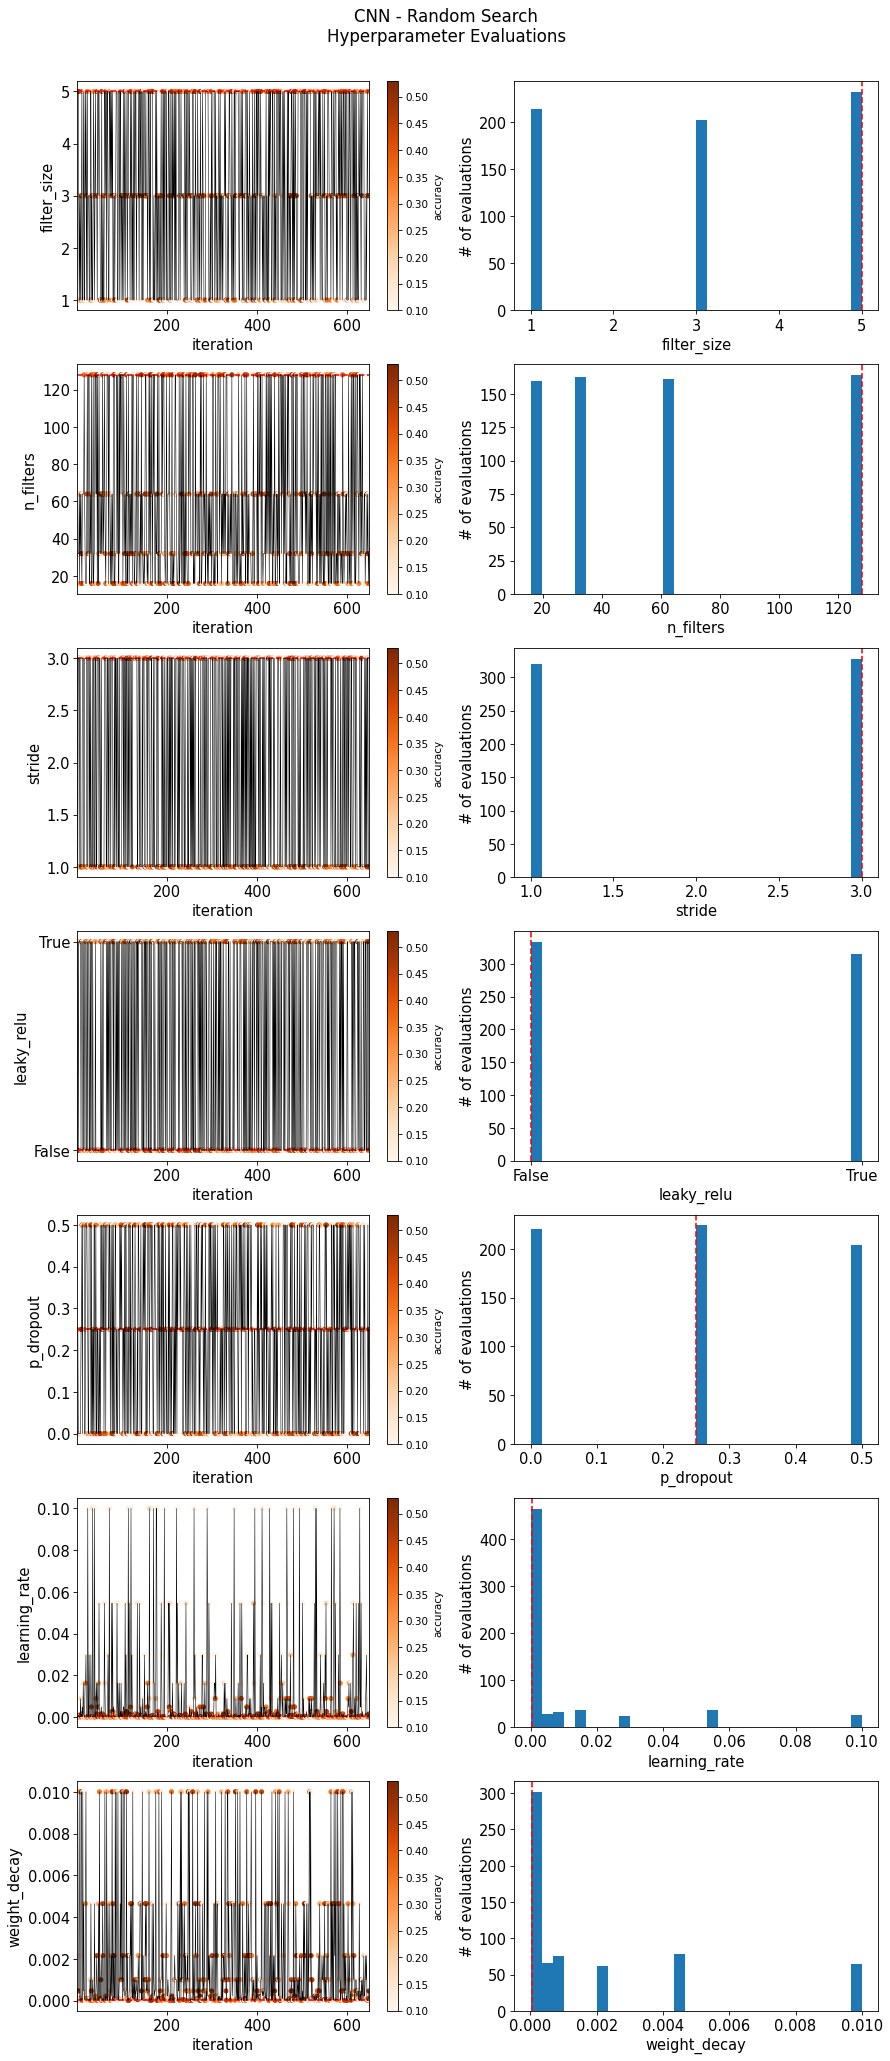

In [30]:
params = rs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in rs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = rs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("CNN - Random Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.95])

# Bayesian Search

In [20]:
bs_hyperparameters = {
     'filter_size': Categorical([1, 3, 5]),  # 1, 3, 5 
     'n_filters': Categorical([16, 32, 64, 128]), 
     'stride': Categorical([1, 3]),
     'leaky_relu': Categorical([False, True]),
     'p_dropout': Categorical([0.50, 0.25, 0.0]), 
     'learning_rate': Real(1e-6, 1e-1, prior='log-uniform'), 
     'weight_decay': Real(1e-5, 1e-2, prior='log-uniform')
}

N_EVALS = 648  # same number as were evaluated in grid search

In [21]:
def cb_print(result):
    ## to be called by BayesSearchCV fit() to print out each iteration
    
    # save progress at each iteration in case of error
    skopt.dump(result, 'tmp_bayes_result_{}.pkl'.format(datetime.now().strftime("%Y%m%d")))
    
    def stringify_params(params):
        # to take the list of hyperparameter values and get a dictionary back out
        params = point_asdict(bs_hyperparameters, params)
        return ', '.join([f'{k}={v}' if type(v) != str else f'{k}="{v}"' \
                          for k, v in params.items()])
    
    score = -(result.func_vals[-1])
    params = stringify_params(result.x_iters[-1])

    # argmin because the values are negative during search
    best_score_pos = np.argmin(result.func_vals)
    
    num_tried = len(result.func_vals)
    N = result.specs['args']['n_initial_points']

    the_time = datetime.now().strftime("%H:%M:%S")
    if best_score_pos == (num_tried - 1):
        print(f'***New best! [{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})\n')
    else:
        print(f'[{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})')
        best_params = stringify_params(result.x_iters[best_score_pos])
        print('    Best accuracy = {} ({})\n'.format(-result.func_vals[best_score_pos], best_params))

In [22]:
np.random.seed(682)
clf = CNNClassifier(n_epochs=N_EPOCHS, loader_val=loader_val)

print('\n--------------------------------------\nBeginning Bayes search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

bayes = BayesSearchCV(
    estimator = clf,
    search_spaces = bs_hyperparameters,
    scoring = _custom_scorer,
    cv = presplit,
    n_jobs = 1,
    n_iter = N_EVALS,
    refit = False,
    random_state = 682
)

early_stopper = DeltaYStopper(0.0001)
timercb = TimerCallback()
bayes_result = bayes.fit(x_train_full, y_train_full, callback=[timercb, cb_print, early_stopper])

the_time = datetime.now().strftime('%Y%m%d_%H%M%S')
skopt.dump(bayes_result, f'cnn_bayes_result_{the_time}.pkl')

with open(f'cnn_bayes_timercb_{the_time}.pkl', 'wb') as f:
    pickle.dump(timercb, f)

scores = bayes_result.cv_results_['mean_test_score']
param_keys = [x for x in bayes_result.cv_results_.keys() if 'param_' in x]
tmp = [bayes_result.cv_results_[x] for x in param_keys] + [scores]
tmp = list(map(list, zip(*tmp)))
tmp = [dict(zip(param_keys + ['mean_test_score'], x)) for x in tmp]
print(pd.DataFrame(tmp))

print('Finished with Bayes search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))

Streaming output truncated to the last 5000 lines.
        Epoch 1, iteration 1: loss = 2.2968909740448, accuracy = 10.0%
        Epoch 1, iteration 200: loss = 1.8852028846740723, accuracy = 32.81%
        Epoch 1, iteration 400: loss = 1.7280291318893433, accuracy = 38.42%
        Epoch 1, iteration 600: loss = 1.548583984375, accuracy = 42.22%
        End of Epoch 1: accuracy = 44.12%
        Epoch 2, iteration 1: loss = 1.8071271181106567, accuracy = 44.16%
        Epoch 2, iteration 200: loss = 1.670588731765747, accuracy = 46.52%
        Epoch 2, iteration 400: loss = 1.7053710222244263, accuracy = 46.4%
        Epoch 2, iteration 600: loss = 1.3002604246139526, accuracy = 47.84%
        End of Epoch 2: accuracy = 48.67%
        Epoch 3, iteration 1: loss = 1.3478760719299316, accuracy = 48.56%
        Epoch 3, iteration 200: loss = 1.2432045936584473, accuracy = 47.89%
        Epoch 3, iteration 400: loss = 1.1061217784881592, accuracy = 50.18%
        Epoch 3, iteration 600: lo

## Bayesian Plots

In [23]:
bayes_result.best_params_

OrderedDict([('filter_size', 3),
             ('leaky_relu', True),
             ('learning_rate', 0.00019357622853419427),
             ('n_filters', 128),
             ('p_dropout', 0.5),
             ('stride', 1),
             ('weight_decay', 0.007697586811219671)])

In [24]:
bayes_result.best_score_

0.5244

In [16]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [26]:
# convergence plot
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("CNN: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend()

In [27]:
#### runtime plot: model vs. bayesian

plt.close('all')
model_times = np.array(bayes_result.cv_results_['mean_fit_time']) + \
              np.array(bayes_result.cv_results_['mean_score_time']) 
total_times = np.array(timercb.iter_time)
bayes_times = total_times - model_times

cumul_totaltime = total_times.cumsum()
cumul_modeltime = model_times.cumsum()
cumul_bayestime = bayes_times.cumsum()

bayes_frac = cumul_bayestime[-1]/cumul_totaltime[-1]
model_frac = cumul_modeltime[-1]/cumul_totaltime[-1]

plt.stackplot(range(0, len(model_times) + 1), [0, *cumul_modeltime], [0, *cumul_bayestime], 
              labels=['Model: Train + Score', 'Bayes Update + Proposal'])
plt.legend(loc='upper left')
plt.xlim((0, len(model_times)))
plt.xlabel('Iteration')
plt.ylabel('Cumulative Runtime (s)')
plt.annotate('Cumulatively:\nModel: {}%\nBayes: {}%'.format(round(model_frac * 100), round(bayes_frac * 100)), 
             (0.02*len(model_times), 0.7*cumul_totaltime[-1]))
plt.title('CNN Runtime\nModel vs. Bayesian Search Contribution')

Text(0.5, 1.0, 'CNN Runtime\nModel vs. Bayesian Search Contribution')

In [28]:
params = bayes_result.search_spaces.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = bayes_result.cv_results_[f'param_{param}']
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = bayes_result.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("CNN - Bayesian Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.95])


# Combined Plots

In [14]:
############################ 
# If re-running this later, or if your connection failed, re-import the results for subsequent plots
############################ 

with open('cnn_gs_results_20201213_190229.pkl', 'rb') as f:
    gs_results = pickle.load(f)
with open('cnn_gs_20201213_190229.pkl', 'rb') as f:
    gs = pickle.load(f)

with open('cnn_rs_results_20201213_233541.pkl', 'rb') as f:
    rs_results = pickle.load(f)
with open('cnn_rs_20201213_233541.pkl', 'rb') as f:
    rs = pickle.load(f)

bayes_result = skopt.load('cnn_bayes_result_20201215_081010.pkl')

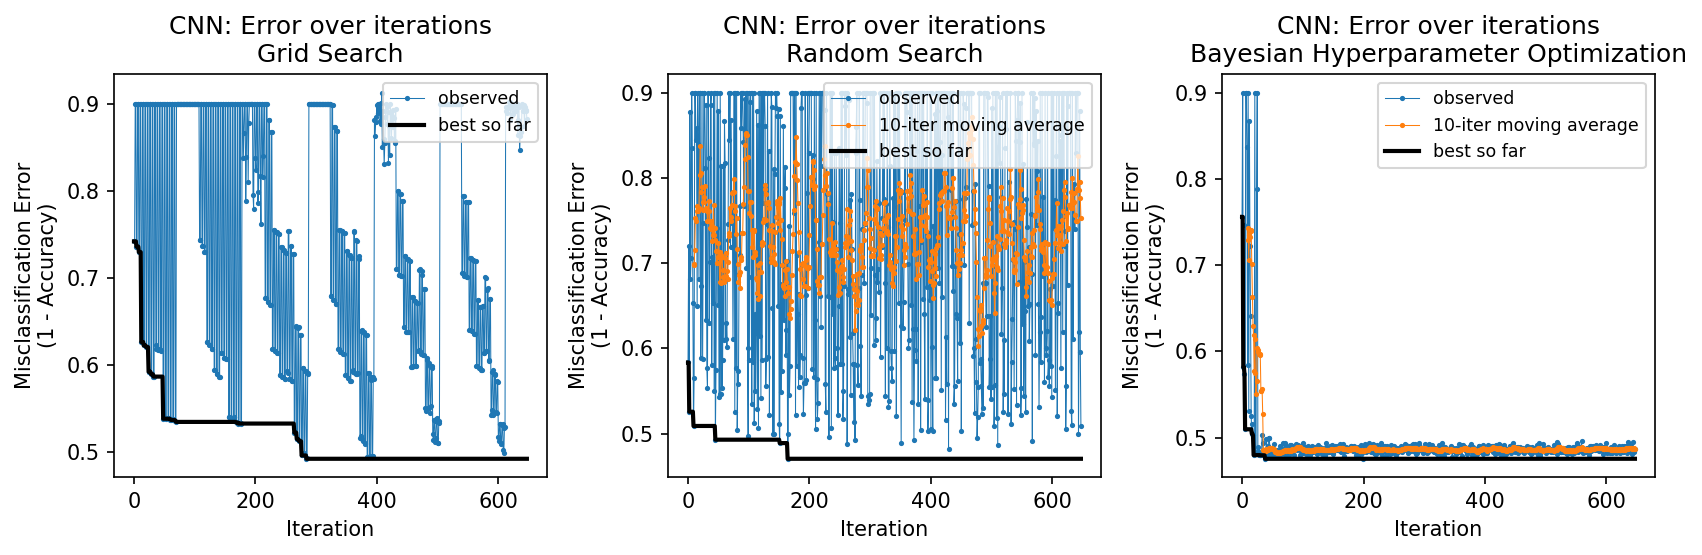

In [17]:
plt.close('all')
plt.figure(figsize=(12, 4), dpi=150)


####### convergence plot, GS
plt.subplot(1, 3, 1)

accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("CNN: Error over iterations\nGrid Search")
plt.legend(loc='upper right', fontsize='small')
#plt.ylim((.28, .55))


####### convergence plot, RS
plt.subplot(1, 3, 2)

accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("CNN: Error over iterations\nRandom Search")
plt.legend(loc='upper right', fontsize='small')
#plt.ylim((.28, .55))


####### convergence plot, Bayesian
plt.subplot(1, 3, 3)

accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("CNN: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend(loc='upper right', fontsize='small')
#plt.ylim((.28, .55))


plt.tight_layout(rect=[0, 0.0, .96, 0.95])

# Get CSVs + best model summaries

In [18]:
print('\nGrid search best model:')
best = max(gs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Grid search best model:
    Score = 0.508
    filter_size = 3
    leaky_relu = False
    learning_rate = 0.0001
    n_filters = 128
    p_dropout = 0.0
    stride = 1
    weight_decay = 1e-05


In [19]:
print('\nRandom search best model:')
best = max(rs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Random search best model:
    Score = 0.5294
    filter_size = 5
    leaky_relu = False
    learning_rate = 0.0004281332398719391
    n_filters = 128
    p_dropout = 0.25
    stride = 3
    weight_decay = 4.641588833612782e-05


In [20]:
print('\nBayes search best model:')
print('    Score = {}'.format(bayes_result.best_score_))
for param in sorted(bayes_result.best_params_.keys()):
    print('    {} = {}'.format(param, bayes_result.best_params_[param]))


Bayes search best model:
    Score = 0.5244
    filter_size = 3
    leaky_relu = True
    learning_rate = 0.00019357622853419427
    n_filters = 128
    p_dropout = 0.5
    stride = 1
    weight_decay = 0.007697586811219671


In [21]:
df_results = pd.DataFrame()
for res in gs_results:
    row = {'search_type': 'grid', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [22]:
for res in rs_results:
    row = {'search_type': 'random', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [23]:
for i, cv_score in enumerate(bayes_result.cv_results_['mean_test_score']):
    row = {'search_type': 'bayes', 'accuracy': cv_score}
    for param in bayes_result.search_spaces.keys():
        row[param] = bayes_result.cv_results_['param_' + param][i]
    df_results = df_results.append(row, ignore_index=True)

In [24]:
df_results.to_csv('cnn_results_{}.csv'.format(datetime.now().strftime('%Y%m%d-%H%M%S')), index=False)